In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd /content/gdrive/MyDrive/multilogue-net
# % cd /content/drive/MyDrive/11-777 MMML/multilogue-net

/content/gdrive/.shortcut-targets-by-id/1-OjvBpuqTljrC41gw_70o-QroM9_HQ8V/multilogue-net


In [ ]:
!pip install -r requirements.txt

In [ ]:
import numpy as np, torch, torch.nn as nn, torch.optim as optim
import argparse, time, pandas as pd, os
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
from model_nce import RegressionModelNCE, MaskedMSELoss, BiModalAttention,CrossLingualNCELoss, RegressionModelNCE_, InterNCELoss
from model import RegressionModel
from dataloader import MOSEIRegressionBi, MOSEIRegression, MOSEIRegression_NCE

np.random.seed(393)
torch.cuda.device([0])

In [ ]:
args = {
    "no_cuda": False,
    "lr": 1e-4,
    "l2": 1e-4,
    "rec_dropout": 0.1,
    "dropout": 0.25,
    "batch_size":64,
    "epochs":250,
    "log_dir": 'logs/moseas_regression'
}
os.makedirs(args["log_dir"], exist_ok = True)

In [ ]:
# Run on either GPU or CPU
args["cuda"] = torch.cuda.is_available() and not args["no_cuda"]
if args["cuda"]:
    print('Running on GPU')
else:
    print('Running on CPU')
print("Tensorboard logs in " + args["log_dir"])

Running on GPU
Tensorboard logs in logs/moseas_regression


In [ ]:
def get_train_valid_sampler(trainset, valid=0.1):
    size = len(trainset)
    idx = range(size)
    split = int(valid*size)
    return SubsetRandomSampler(idx[split:]), SubsetRandomSampler(idx[:split])

def get_MOSEI_loaders(path, batch_size=128, valid=0.1, num_workers=0, pin_memory=False, mode="french"):
    trainset = MOSEIRegression_NCE(path=path)
    train_sampler, valid_sampler = get_train_valid_sampler(trainset, valid)
    train_loader = DataLoader(trainset, batch_size=batch_size, sampler=train_sampler, collate_fn=trainset.collate_fn, num_workers=num_workers, pin_memory=pin_memory)
    valid_loader = DataLoader(trainset, batch_size=batch_size, sampler=valid_sampler, collate_fn=trainset.collate_fn, num_workers=num_workers, pin_memory=pin_memory)
    print(mode)
    testset = MOSEIRegression_NCE(path=path, train=False,mode=mode)
    print("testset.len: ",testset.len)
    test_loader = DataLoader(testset, batch_size=batch_size, collate_fn=testset.collate_fn, num_workers=num_workers, pin_memory=pin_memory)
    return train_loader, valid_loader, test_loader

In [ ]:
def train_or_eval_model(model, MSEloss, CrossLingualNCEloss, InterNCEloss, dataloader, epoch, optimizer=None, train=False):    
    losses, preds, labels, masks = [], [], [], []
    assert not train or optimizer!=None
    if train:
        model.train()
    else:
        model.eval()
    for data in dataloader:
        if train:
            optimizer.zero_grad()
        textf1, textf2, visuf, acouf, qmask, umask, label = [d.cuda() for d in data] if cuda else data
        # print(textf1.shape, textf2.shape)
        # jiu jiu hai zi
        # l = label.detach().numpy()
        # # print("train_or_eval", (abs(l) <= 1e-5).sum())
        # pred, hidden_at1, hidden_at2, hidden_vt1, hidden_vt2 = model(textf1, textf2, acouf, visuf, textf1, qmask, umask) 
        d = model(textf1, textf2, acouf, visuf, textf1, qmask, umask) 
        pred, hidden_a, hidden_v, hidden_t1, hidden_t2, hidden_at1, hidden_at2, hidden_vt1, hidden_vt2 = d['pred'], d['a'], d['v'], d['t1'], d['t2'], d['at1'], d['at2'], d['vt1'], d['vt2']
        labels_ = label.view(-1) 
        umask_ = umask.view(-1)

        mseloss = MSEloss(pred, labels_, umask_)
        nceloss = InterNCEloss(hidden_a, hidden_v)
        loss = mseloss+nceloss

        preds.append(pred.data.cpu().numpy())
        labels.append(labels_.data.cpu().numpy())
        masks.append(umask_.cpu().numpy())
        loss_detach = mseloss.item()*masks[-1].sum() + nceloss.detach().cpu().numpy()
        print(mseloss.item()*masks[-1].sum())
        print(nceloss.detach().cpu().numpy())
        losses.append(loss_detach)
        if train:
            loss.backward()
            optimizer.step()
    if preds!=[]:
        preds  = np.concatenate(preds)
        labels = np.concatenate(labels)
        masks  = np.concatenate(masks)
    else:
        return float('nan'), float('nan'), float('nan'), [], [], []
    avg_loss = round(np.sum(losses)/np.sum(masks),4)
    mae = round(mean_absolute_error(labels,preds,sample_weight=masks),4)
    pred_lab = pd.DataFrame(list(filter(lambda x: x[2]==1, zip(labels, preds, masks))))
    pear = round(pearsonr(pred_lab[0], pred_lab[1])[0], 4)
    return avg_loss, mae, pear, labels, preds, masks

In [ ]:

batch_size = args["batch_size"]
# batch_size = 1
n_classes  = 6
cuda       = args["cuda"]
n_epochs   = args["epochs"]
# MOSEI
# D_m_text, D_m_audio, D_m_video, D_m_context = 300, 384, 35, 300
# MOSEAS
# D_m_text, D_m_audio, D_m_video, D_m_context = 300, 25, 35, 300
# MOSEAS_full
D_m_text, D_m_audio, D_m_video, D_m_context = 300, 25, 35, 300
D_g, D_p, D_e, D_h, D_a = 150, 150, 100, 100, 100

## Data Processing

In [ ]:
import pickle

full_french_data = pickle.load(open('/content/gdrive/MyDrive/multilogue-net/data/moseas_full_regression.pickle', 'rb'))
# keys = full_french_data[0]
len(full_french_data)
all_videos_seg, all_speakers, all_labels, text_feat, audio_feat, visual_feat, train_videos, test_videos = full_french_data

FileNotFoundError: ignored

In [ ]:
text_feat['0sLJvUj7Z7M']

In [ ]:
import pickle
# spanish_data = pickle.load(open('/content/gdrive/MyDrive/moseas_french/moseas_spanish/spanish_french_lang_features_with_id.pickle', 'rb'))
spanish_data = pickle.load(open('/content/drive/MyDrive/moseas_french/moseas_spanish/spanish_french_lang_features_with_id.pickle', 'rb'))

In [ ]:
ids, feats = spanish_data

In [ ]:
for f in feats:
    print(len(f))

In [ ]:
video, seg = 'sLJv_Uj7Z7M_0'.rsplit("_",1)
video, seg

('sLJv_Uj7Z7M', '0')

In [ ]:
new_spanish_data = {}

In [ ]:
spanish_text_feat = {}

for key, vals in all_videos_seg.items():
   for v in vals:
      # v = v[1:]
      if v in ids:
          idx = ids.index(v)
          # print(idx, v)
          video, seg = v.rsplit("_", 1)
          # if (len(feats[idx]) == 0):
          #   print(idx)
          #   print(video)
          if video in spanish_text_feat:
            spanish_text_feat[video].append(feats[idx].mean(axis=0))
          else:
            spanish_text_feat[video] = [feats[idx].mean(axis=0)]

In [ ]:
moseas_regression_data_sp = (all_videos_seg, all_speakers, all_labels, text_feat, spanish_text_feat, audio_feat, visual_feat, train_videos, test_videos)

In [ ]:
import pickle
full_data = pickle.load(open('/content/gdrive/MyDrive/multilogue-net/data/moseas_full_regression_spanish.pickle', 'rb'))
all_videos_seg, all_speakers, all_labels, text_feat, spanish_text_feat, audio_feat, visual_feat, train_videos, test_videos = full_data

In [ ]:
for vid in all_videos_seg:
    if vid not in spanish_text_feat:
        print(vid)
    else:
        print(spanish_text_feat[vid])
        print(torch.FloatTensor(text_feat[vid]).shape, torch.FloatTensor(spanish_text_feat[vid]).shape)

In [ ]:

for k, v in text_feat.items():
    if k in spanish_text_feat:
      if (len(v) != len(spanish_text_feat[k])):
          print('len not eq', k)
    else:
      print('not in', k)
      for d in [all_videos_seg, all_speakers, all_labels, text_feat, audio_feat, visual_feat, train_videos, test_videos]:
        d.pop(k)

In [ ]:
for k, v in text_feat.items():
    if k in spanish_text_feat:
        print(len(v), v[0].shape, len(spanish_text_feat[k]), spanish_text_feat[k][0].shape)

In [ ]:
with open("/content/gdrive/MyDrive/multilogue-net/data/moseas_full_regression_spanish.pickle", "wb") as f:
    pickle.dump(moseas_regression_data_sp,f)

## Training

In [ ]:
def get_MOSEI_2loaders(path1, path2, batch_size=128, valid=0.1, num_workers=0, pin_memory=False, mode="french"):
    trainset = MOSEIRegressionBi(path1=path1, path2=path2)
    train_sampler, valid_sampler = get_train_valid_sampler(trainset, valid)
    train_loader = DataLoader(trainset, batch_size=batch_size, sampler=train_sampler, collate_fn=trainset.collate_fn, num_workers=num_workers, pin_memory=pin_memory)
    valid_loader = DataLoader(trainset, batch_size=batch_size, sampler=valid_sampler, collate_fn=trainset.collate_fn, num_workers=num_workers, pin_memory=pin_memory)
    print(mode)
    testset = MOSEIRegressionBi(path1=path1, path2=path2, train=False,mode=mode)
    print("testset.len: ",testset.len)
    test_loader = DataLoader(testset, batch_size=batch_size, collate_fn=testset.collate_fn, num_workers=num_workers, pin_memory=pin_memory)
    return train_loader, valid_loader, test_loader

In [ ]:
# Instantiate model
model = RegressionModelNCE_(D_m_text, D_m_audio, D_m_video, D_m_context, D_g, D_p, D_e, D_h, dropout_rec=args["rec_dropout"], dropout=args["dropout"])

if cuda:
    model.cuda()
MSEloss = MaskedMSELoss()
internceloss = InterNCELoss()
crosslingualnceloss = CrossLingualNCELoss()

# Get optimizer and relevant dataloaders
optimizer = optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['l2'])
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.7,patience=10,verbose=True)

# amelia
# train_loader, valid_loader, test_loader = get_MOSEI_loaders('/content/drive/MyDrive/11-777 MMML/multilogue-net/data/moseas_full_regression_spanish.pickle', valid=0.0, batch_size=batch_size, num_workers=0)
# abbey
# train_loader, valid_loader, test_loader = get_MOSEI_2loaders('/content/gdrive/MyDrive/multilogue-net/data/moseas_full_regression_french_spanishtranslate.pickle', '/content/gdrive/MyDrive/multilogue-net/data/moseas_spanish_duptextfornce_full_regression.pickle', valid=0.0, batch_size=batch_size, num_workers=0)

train_loader, valid_loader, test_loader = get_MOSEI_loaders('/content/gdrive/MyDrive/multilogue-net/data/moseas_full_regression_french_spanishtranslate.pickle', valid=0.0, batch_size=batch_size, num_workers=0)
best_loss, best_label, best_pred, best_mask, best_pear = None, None, None, None, None
all_train_loss, all_test_loss, all_train_mae, all_test_mae, all_train_pear, all_test_pear = [],[],[],[],[],[]

french
testset.len:  57


In [ ]:
def log_res(train_loss, test_loss, train_mae, test_mae, train_pear, test_pear):
    print("Train Loss - MOSEAS Regression: ", train_loss)
    print("Test Loss - MOSEAS Regression: ", test_loss)
    print("Train MAE - MOSEAS Regression: ", train_mae)
    print("Test MAE - MOSEAS Regression: ", test_mae)
    print("Train Pearson - MOSEAS Regression: ", train_pear)
    print("Test Pearson - MOSEAS Regression: ", test_pear)

    all_train_loss.append(train_loss)
    all_test_loss.append(test_loss)
    all_train_mae.append(train_mae)
    all_test_mae.append(test_mae)
    all_train_pear.append(train_pear)
    all_test_pear.append(test_pear)

In [ ]:
# Training loop
for e in tqdm(range(n_epochs), desc = 'MOSEAS Regression'):
    train_loss, train_mae, train_pear,_,_,_ = train_or_eval_model(model, MSEloss, crosslingualnceloss, internceloss, train_loader, e, optimizer, True)
    test_loss, test_mae, test_pear, test_label, test_pred, test_mask = train_or_eval_model(model, MSEloss, crosslingualnceloss, internceloss, test_loader, e)
    log_res(train_loss, test_loss, train_mae, test_mae, train_pear, test_pear)

    if best_loss == None or best_loss > test_loss:
        best_loss, best_mae, best_label, best_pred, best_mask, best_pear =\
                test_loss, test_mae, test_label, test_pred, test_mask, test_pear
        print(f"saving checkpoint for epoch {e}")
        torch.save(model.state_dict(),f"/content/gdrive/MyDrive/multilogue-net/logs/moseas_regression/epoch{e}_testloss_{best_loss}_testmae_{best_mae}_testpear_{best_pear}.t7")

print('Test performance..')
print('Loss {} MAE {} r {}'.format(best_loss, round(mean_absolute_error(best_label,best_pred,sample_weight=best_mask),4), best_pear))

MOSEAS Regression:   0%|          | 0/250 [00:00<?, ?it/s]/content/gdrive/.shortcut-targets-by-id/1-OjvBpuqTljrC41gw_70o-QroM9_HQ8V/multilogue-net/dataloader.py:92: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  return self._deactive((torch.FloatTensor(self.videoText1[vid]),\


758.3731520175934
1.3345504
618.5760982632637
1.2802695
803.9830303192139
1.2485287
368.99447351694107
1.1845261
585.1718873977661
1.1804849
Train Loss - MOSEAS Regression:  0.6452
Test Loss - MOSEAS Regression:  0.5311
Train MAE - MOSEAS Regression:  0.6083
Test MAE - MOSEAS Regression:  0.56
Train Pearson - MOSEAS Regression:  -0.0069
Test Pearson - MOSEAS Regression:  -0.1099
saving checkpoint for epoch 0


MOSEAS Regression:   0%|          | 1/250 [00:25<1:46:36, 25.69s/it]

541.5248945951462
1.1326374
613.311237692833
1.1705116
646.6353084445
1.0686345
312.3109721541405
0.9729913


MOSEAS Regression:   1%|          | 2/250 [00:40<1:18:54, 19.09s/it]

552.2318258285522
1.0641694
Train Loss - MOSEAS Regression:  0.5349
Test Loss - MOSEAS Regression:  0.5012
Train MAE - MOSEAS Regression:  0.5578
Test MAE - MOSEAS Regression:  0.5554
Train Pearson - MOSEAS Regression:  -0.0504
Test Pearson - MOSEAS Regression:  -0.0934
saving checkpoint for epoch 1
528.1773586273193
1.0292952
692.0291669368744
1.0472347
541.0342177152634
0.83320713
302.6819753050804
1.0056291


MOSEAS Regression:   1%|          | 3/250 [00:54<1:10:34, 17.15s/it]

555.5497055053711
0.9569412
Train Loss - MOSEAS Regression:  0.5222
Test Loss - MOSEAS Regression:  0.5041
Train MAE - MOSEAS Regression:  0.5626
Test MAE - MOSEAS Regression:  0.5655
Train Pearson - MOSEAS Regression:  -0.0342
Test Pearson - MOSEAS Regression:  -0.0815
700.3056688308716
0.8676643
588.6916410923004
0.95543873
503.7015748023987
0.8781785
284.15571653842926
0.6866159


MOSEAS Regression:   2%|▏         | 4/250 [01:11<1:08:28, 16.70s/it]

544.0748863220215
0.85658324
Train Loss - MOSEAS Regression:  0.5253
Test Loss - MOSEAS Regression:  0.4936
Train MAE - MOSEAS Regression:  0.5658
Test MAE - MOSEAS Regression:  0.5541
Train Pearson - MOSEAS Regression:  -0.0383
Test Pearson - MOSEAS Regression:  -0.0628
saving checkpoint for epoch 3
383.83878350257874
0.57367843
487.7295200228691
0.7180075
684.5869015157223
0.7831513
457.0625910758972
0.53775376


MOSEAS Regression:   2%|▏         | 5/250 [01:25<1:04:49, 15.88s/it]

536.0007276535034
0.7543276
Train Loss - MOSEAS Regression:  0.509
Test Loss - MOSEAS Regression:  0.4862
Train MAE - MOSEAS Regression:  0.553
Test MAE - MOSEAS Regression:  0.5384
Train Pearson - MOSEAS Regression:  0.0028
Test Pearson - MOSEAS Regression:  -0.0217
saving checkpoint for epoch 4
557.1253561973572
0.83664197
652.3486108779907
0.5148416
543.6499947309494
0.49543244
296.1593692302704
0.54461116


MOSEAS Regression:   2%|▏         | 6/250 [01:41<1:04:45, 15.93s/it]

536.9434947967529
0.6477037
Train Loss - MOSEAS Regression:  0.5181
Test Loss - MOSEAS Regression:  0.4869
Train MAE - MOSEAS Regression:  0.5536
Test MAE - MOSEAS Regression:  0.536
Train Pearson - MOSEAS Regression:  -0.0269
Test Pearson - MOSEAS Regression:  0.0354
601.2531593441963
0.70456785
543.42467212677
0.53420854
561.6866221427917
0.30691737
323.68303537368774
0.13934614


MOSEAS Regression:   3%|▎         | 7/250 [01:57<1:04:25, 15.91s/it]

532.6573491096497
0.5326474
Train Loss - MOSEAS Regression:  0.5131
Test Loss - MOSEAS Regression:  0.483
Train MAE - MOSEAS Regression:  0.5463
Test MAE - MOSEAS Regression:  0.5342
Train Pearson - MOSEAS Regression:  0.0168
Test Pearson - MOSEAS Regression:  0.0568
saving checkpoint for epoch 6
653.2861992716789
0.3592314
522.7869282960892
0.35823944
593.2388415336609
0.2540844
247.88991111516953
0.5314428


MOSEAS Regression:   3%|▎         | 8/250 [02:13<1:04:14, 15.93s/it]

527.496575832367
0.40299174
Train Loss - MOSEAS Regression:  0.5098
Test Loss - MOSEAS Regression:  0.4782
Train MAE - MOSEAS Regression:  0.5476
Test MAE - MOSEAS Regression:  0.5349
Train Pearson - MOSEAS Regression:  0.0242
Test Pearson - MOSEAS Regression:  0.0617
saving checkpoint for epoch 7
674.1978380084038
0.17129582
527.9735673069954
0.5816052
474.42150181531906
0.08289823
337.6765022277832
-0.40906382


MOSEAS Regression:   4%|▎         | 9/250 [02:28<1:03:25, 15.79s/it]

525.351676940918
0.26631957
Train Loss - MOSEAS Regression:  0.5088
Test Loss - MOSEAS Regression:  0.4761
Train MAE - MOSEAS Regression:  0.5486
Test MAE - MOSEAS Regression:  0.5367
Train Pearson - MOSEAS Regression:  0.0335
Test Pearson - MOSEAS Regression:  0.072
saving checkpoint for epoch 8
632.377937078476
0.0674496
468.3111574649811
-0.25728658
639.3279359936714
0.15354
265.0380236506462
-0.88199157


MOSEAS Regression:   4%|▍         | 10/250 [02:43<1:01:28, 15.37s/it]

523.2003293037415
0.10699976
Train Loss - MOSEAS Regression:  0.5061
Test Loss - MOSEAS Regression:  0.474
Train MAE - MOSEAS Regression:  0.5508
Test MAE - MOSEAS Regression:  0.5342
Train Pearson - MOSEAS Regression:  0.0502
Test Pearson - MOSEAS Regression:  0.0979
saving checkpoint for epoch 9
558.3447534441948
0.22719726
617.4909853935242
-0.7656698
579.461612701416
-0.101179436
296.93239974975586
-0.68687576


MOSEAS Regression:   4%|▍         | 11/250 [02:58<1:01:31, 15.44s/it]

521.8626751899719
-0.077874355
Train Loss - MOSEAS Regression:  0.5179
Test Loss - MOSEAS Regression:  0.4726
Train MAE - MOSEAS Regression:  0.5596
Test MAE - MOSEAS Regression:  0.5321
Train Pearson - MOSEAS Regression:  0.0212
Test Pearson - MOSEAS Regression:  0.1182
saving checkpoint for epoch 10
559.8273980617523
-0.21158233
662.0399022102356
-0.47791645
548.747082233429
-0.33086324
325.02277994155884
1.52651


MOSEAS Regression:   5%|▍         | 12/250 [03:14<1:02:02, 15.64s/it]

520.6791987419128
-0.2688129
Train Loss - MOSEAS Regression:  0.5293
Test Loss - MOSEAS Regression:  0.4714
Train MAE - MOSEAS Regression:  0.5626
Test MAE - MOSEAS Regression:  0.5311
Train Pearson - MOSEAS Regression:  0.0203
Test Pearson - MOSEAS Regression:  0.1312
saving checkpoint for epoch 11
659.2124211788177
-0.14715767
549.6826283633709
-0.6618097
667.6402406096458
-0.94558877
207.84017634391785
-0.32119766


MOSEAS Regression:   5%|▌         | 13/250 [03:31<1:02:50, 15.91s/it]

519.3540143966675
-0.44955966
Train Loss - MOSEAS Regression:  0.5258
Test Loss - MOSEAS Regression:  0.47
Train MAE - MOSEAS Regression:  0.5603
Test MAE - MOSEAS Regression:  0.5305
Train Pearson - MOSEAS Regression:  0.0378
Test Pearson - MOSEAS Regression:  0.1405
saving checkpoint for epoch 12
575.0738426148891
-0.66355556
744.4139295816422
-1.2176874
431.1185209751129
-0.19455846
274.0411922931671
-1.040246


MOSEAS Regression:   6%|▌         | 14/250 [03:48<1:03:24, 16.12s/it]

517.6916527748108
-0.6636783
Train Loss - MOSEAS Regression:  0.5105
Test Loss - MOSEAS Regression:  0.4683
Train MAE - MOSEAS Regression:  0.5521
Test MAE - MOSEAS Regression:  0.5309
Train Pearson - MOSEAS Regression:  0.0853
Test Pearson - MOSEAS Regression:  0.1455
saving checkpoint for epoch 13
627.3512309789658
-1.048946
584.4879102706909
-0.5288664
569.7978515625
-0.97471684
310.97665786743164
-1.7173529


MOSEAS Regression:   6%|▌         | 15/250 [04:04<1:03:50, 16.30s/it]

516.6427116394043
-0.9267774
Train Loss - MOSEAS Regression:  0.5274
Test Loss - MOSEAS Regression:  0.4671
Train MAE - MOSEAS Regression:  0.5633
Test MAE - MOSEAS Regression:  0.5314
Train Pearson - MOSEAS Regression:  0.0393
Test Pearson - MOSEAS Regression:  0.1504
saving checkpoint for epoch 14
659.0967745780945
-0.85093105
538.2353689670563
-1.3579395
489.8622500896454
-1.2010411
385.7759245634079
-2.5997734


MOSEAS Regression:   6%|▋         | 16/250 [04:20<1:03:26, 16.27s/it]

519.3363132476807
-1.2535151
Train Loss - MOSEAS Regression:  0.522
Test Loss - MOSEAS Regression:  0.4693
Train MAE - MOSEAS Regression:  0.5573
Test MAE - MOSEAS Regression:  0.5285
Train Pearson - MOSEAS Regression:  0.06
Test Pearson - MOSEAS Regression:  0.1595
566.3974148631096
-2.1672895
649.6752732396126
-1.798068
583.6402502059937
-2.5634868
312.8304423391819
-1.4085481


MOSEAS Regression:   7%|▋         | 17/250 [04:35<1:01:25, 15.82s/it]

515.5065150260925
-1.6728052
Train Loss - MOSEAS Regression:  0.5315
Test Loss - MOSEAS Regression:  0.4654
Train MAE - MOSEAS Regression:  0.563
Test MAE - MOSEAS Regression:  0.5309
Train Pearson - MOSEAS Regression:  0.0679
Test Pearson - MOSEAS Regression:  0.1574
saving checkpoint for epoch 16
687.9512481689453
-1.4078877
530.9820804595947
-2.048208
724.242849111557
-2.604915
238.14587992429733
-3.2464173


MOSEAS Regression:   7%|▋         | 18/250 [04:52<1:01:45, 15.97s/it]

515.4144229888916
-2.1881218
Train Loss - MOSEAS Regression:  0.5485
Test Loss - MOSEAS Regression:  0.4649
Train MAE - MOSEAS Regression:  0.5762
Test MAE - MOSEAS Regression:  0.532
Train Pearson - MOSEAS Regression:  0.0279
Test Pearson - MOSEAS Regression:  0.1558
saving checkpoint for epoch 17
643.759042263031
-3.0082862
624.4796431064606
-1.8687187
596.030357003212
-2.9265246
281.91655844449997
-6.4344316


MOSEAS Regression:   8%|▊         | 19/250 [05:07<1:01:09, 15.88s/it]

516.8427872657776
-2.849063
Train Loss - MOSEAS Regression:  0.5384
Test Loss - MOSEAS Regression:  0.4656
Train MAE - MOSEAS Regression:  0.5683
Test MAE - MOSEAS Regression:  0.5285
Train Pearson - MOSEAS Regression:  0.0542
Test Pearson - MOSEAS Regression:  0.1599
607.8593586087227
-3.5480003
650.3467655181885
-2.604116
609.6976790428162
-4.765256
326.34709042310715
-3.5752707


MOSEAS Regression:   8%|▊         | 20/250 [05:23<1:01:15, 15.98s/it]

515.4863791465759
-3.7022989
Train Loss - MOSEAS Regression:  0.5504
Test Loss - MOSEAS Regression:  0.4636
Train MAE - MOSEAS Regression:  0.5777
Test MAE - MOSEAS Regression:  0.5291
Train Pearson - MOSEAS Regression:  0.0516
Test Pearson - MOSEAS Regression:  0.1594
saving checkpoint for epoch 19
598.8333984613419
-4.9424543
679.4191464185715
-3.5024548
542.6583534479141
-4.2781243
338.4780018925667
-6.804128


MOSEAS Regression:   8%|▊         | 21/250 [05:39<1:00:52, 15.95s/it]

514.8567051887512
-4.801251
Train Loss - MOSEAS Regression:  0.5404
Test Loss - MOSEAS Regression:  0.462
Train MAE - MOSEAS Regression:  0.5769
Test MAE - MOSEAS Regression:  0.5297
Train Pearson - MOSEAS Regression:  0.095
Test Pearson - MOSEAS Regression:  0.1599
saving checkpoint for epoch 20
646.5577901601791
-5.1941404
540.7218999266624
-5.4316697
633.81381046772
-4.8993244
401.99803590774536
-7.173008


MOSEAS Regression:   9%|▉         | 22/250 [05:56<1:01:40, 16.23s/it]

516.3101735115051
-6.236608
Train Loss - MOSEAS Regression:  0.5557
Test Loss - MOSEAS Regression:  0.462
Train MAE - MOSEAS Regression:  0.582
Test MAE - MOSEAS Regression:  0.5277
Train Pearson - MOSEAS Regression:  0.0799
Test Pearson - MOSEAS Regression:  0.165
524.0170369148254
-7.301873
717.5318701267242
-7.5636187
723.6163258552551
-6.5379057
284.37429815530777
-8.958272


MOSEAS Regression:   9%|▉         | 23/250 [06:12<1:00:59, 16.12s/it]

516.9915690422058
-8.140334
Train Loss - MOSEAS Regression:  0.5604
Test Loss - MOSEAS Regression:  0.4609
Train MAE - MOSEAS Regression:  0.5868
Test MAE - MOSEAS Regression:  0.5274
Train Pearson - MOSEAS Regression:  0.0773
Test Pearson - MOSEAS Regression:  0.1666
saving checkpoint for epoch 22
700.8912566900253
-11.982214
558.4640117883682
-7.46711
550.4905394911766
-10.391869
470.66570699214935
-11.884103


MOSEAS Regression:  10%|▉         | 24/250 [06:27<59:49, 15.88s/it]  

514.9795603752136
-10.783747
Train Loss - MOSEAS Regression:  0.5654
Test Loss - MOSEAS Regression:  0.4567
Train MAE - MOSEAS Regression:  0.5893
Test MAE - MOSEAS Regression:  0.5273
Train Pearson - MOSEAS Regression:  0.1148
Test Pearson - MOSEAS Regression:  0.1654
saving checkpoint for epoch 23
723.7383034825325
-9.666669
619.0961849689484
-12.630341
681.2487867474556
-14.301893
387.9731512069702
-16.520857


MOSEAS Regression:  10%|█         | 25/250 [06:43<59:31, 15.87s/it]

519.16028881073
-14.716426
Train Loss - MOSEAS Regression:  0.5957
Test Loss - MOSEAS Regression:  0.4569
Train MAE - MOSEAS Regression:  0.6104
Test MAE - MOSEAS Regression:  0.5376
Train Pearson - MOSEAS Regression:  0.0714
Test Pearson - MOSEAS Regression:  0.15
576.6023241281509
-17.772442
785.0639630556107
-17.616627
665.1034820079803
-15.627482
330.445865213871
-23.319542


MOSEAS Regression:  10%|█         | 26/250 [06:59<58:37, 15.70s/it]

531.4027061462402
-20.841831
Train Loss - MOSEAS Regression:  0.5765
Test Loss - MOSEAS Regression:  0.4625
Train MAE - MOSEAS Regression:  0.6043
Test MAE - MOSEAS Regression:  0.5298
Train Pearson - MOSEAS Regression:  0.1272
Test Pearson - MOSEAS Regression:  0.1583
663.53974878788
-21.501345
786.1014084219933
-23.257734
692.7192544937134
-21.977562
361.4567965269089
-29.112278


MOSEAS Regression:  11%|█         | 27/250 [07:15<59:23, 15.98s/it]

514.4342794418335
-28.365656
Train Loss - MOSEAS Regression:  0.6081
Test Loss - MOSEAS Regression:  0.4403
Train MAE - MOSEAS Regression:  0.6155
Test MAE - MOSEAS Regression:  0.5291
Train Pearson - MOSEAS Regression:  0.1018
Test Pearson - MOSEAS Regression:  0.1625
saving checkpoint for epoch 26
672.2268104553223
-26.315725
690.712984085083
-29.14679
852.3526341319084
-30.774313
509.8189115524292
-42.585712


MOSEAS Regression:  11%|█         | 28/250 [07:31<59:09, 15.99s/it]

520.3764696121216
-37.404114
Train Loss - MOSEAS Regression:  0.6556
Test Loss - MOSEAS Regression:  0.4375
Train MAE - MOSEAS Regression:  0.6549
Test MAE - MOSEAS Regression:  0.5255
Train Pearson - MOSEAS Regression:  0.094
Test Pearson - MOSEAS Regression:  0.1673
saving checkpoint for epoch 27
953.8557028770447
-34.66411
640.8078712821007
-40.863586
851.2680292129517
-45.29269
441.9555324912071
-46.914383


MOSEAS Regression:  12%|█▏        | 29/250 [07:47<58:38, 15.92s/it]

515.5999231338501
-47.649837
Train Loss - MOSEAS Regression:  0.6869
Test Loss - MOSEAS Regression:  0.4239
Train MAE - MOSEAS Regression:  0.6765
Test MAE - MOSEAS Regression:  0.5331
Train Pearson - MOSEAS Regression:  0.0865
Test Pearson - MOSEAS Regression:  0.164
saving checkpoint for epoch 28
799.8998900055885
-45.221237
744.4249746203423
-53.325054
1000.7289972305298
-53.95725
423.1672005057335
-64.87357


MOSEAS Regression:  12%|█▏        | 30/250 [08:02<57:05, 15.57s/it]

540.8424196243286
-59.39976
Train Loss - MOSEAS Regression:  0.6947
Test Loss - MOSEAS Regression:  0.4361
Train MAE - MOSEAS Regression:  0.6795
Test MAE - MOSEAS Regression:  0.5321
Train Pearson - MOSEAS Regression:  0.117
Test Pearson - MOSEAS Regression:  0.1737
1130.4316718578339
-56.46658
782.4615303277969
-54.630543
1015.0208643078804
-59.157223
388.4510010480881
-70.88018


MOSEAS Regression:  12%|█▏        | 31/250 [08:18<57:36, 15.78s/it]

581.9415264129639
-72.848816
Train Loss - MOSEAS Regression:  0.7766
Test Loss - MOSEAS Regression:  0.4611
Train MAE - MOSEAS Regression:  0.7215
Test MAE - MOSEAS Regression:  0.5841
Train Pearson - MOSEAS Regression:  0.098
Test Pearson - MOSEAS Regression:  0.1515
928.8596744537354
-83.3742
1314.293720126152
-78.80566
877.2423185110092
-81.67246
602.1817525625229
-87.451


MOSEAS Regression:  13%|█▎        | 32/250 [08:34<57:35, 15.85s/it]

624.6611108779907
-88.58361
Train Loss - MOSEAS Regression:  0.8564
Test Loss - MOSEAS Regression:  0.4856
Train MAE - MOSEAS Regression:  0.7731
Test MAE - MOSEAS Regression:  0.5742
Train Pearson - MOSEAS Regression:  0.0681
Test Pearson - MOSEAS Regression:  0.1712
1063.9264698028564
-84.89674
1221.5760295391083
-95.37156
1109.2014112472534
-105.45616
641.3747370243073
-114.61164


MOSEAS Regression:  13%|█▎        | 33/250 [08:50<56:57, 15.75s/it]

580.258074760437
-106.93634
Train Loss - MOSEAS Regression:  0.9181
Test Loss - MOSEAS Regression:  0.4287
Train MAE - MOSEAS Regression:  0.7993
Test MAE - MOSEAS Regression:  0.5816
Train Pearson - MOSEAS Regression:  0.0569
Test Pearson - MOSEAS Regression:  0.1517
1099.8237589001656
-92.52341
1219.767837524414
-109.17865
1244.2908420562744
-118.09115
730.6606620550156
-128.73732


MOSEAS Regression:  14%|█▎        | 34/250 [09:06<57:21, 15.93s/it]

545.0470676422119
-127.817604
Train Loss - MOSEAS Regression:  0.9712
Test Loss - MOSEAS Regression:  0.3779
Train MAE - MOSEAS Regression:  0.8327
Test MAE - MOSEAS Regression:  0.5415
Train Pearson - MOSEAS Regression:  0.0702
Test Pearson - MOSEAS Regression:  0.1579
saving checkpoint for epoch 33
1364.661610364914
-146.5213
1500.8218995332718
-131.8925
1277.1222705841064
-135.4835
761.4400749206543
-150.76648


MOSEAS Regression:  14%|█▍        | 35/250 [09:21<56:19, 15.72s/it]

539.9552564620972
-151.96173
Train Loss - MOSEAS Regression:  1.0958
Test Loss - MOSEAS Regression:  0.3514
Train MAE - MOSEAS Regression:  0.8727
Test MAE - MOSEAS Regression:  0.5404
Train Pearson - MOSEAS Regression:  0.0659
Test Pearson - MOSEAS Regression:  0.1594
saving checkpoint for epoch 34
1105.0832431316376
-143.67273
1529.0564393997192
-180.67181
1664.3092453479767
-158.11617
818.5756888389587
-187.73878


MOSEAS Regression:  14%|█▍        | 36/250 [09:36<55:35, 15.59s/it]

698.9588871002197
-179.4278
Train Loss - MOSEAS Regression:  1.1229
Test Loss - MOSEAS Regression:  0.4706
Train MAE - MOSEAS Regression:  0.9131
Test MAE - MOSEAS Regression:  0.6532
Train Pearson - MOSEAS Regression:  0.1226
Test Pearson - MOSEAS Regression:  0.1509
1643.6963511705399
-207.04459
1829.6544028520584
-185.27266
1453.6602630615234
-172.87338
695.1490888595581
-216.20552


MOSEAS Regression:  15%|█▍        | 37/250 [09:53<56:33, 15.93s/it]

550.127001285553
-210.45352
Train Loss - MOSEAS Regression:  1.2224
Test Loss - MOSEAS Regression:  0.3077
Train MAE - MOSEAS Regression:  0.9638
Test MAE - MOSEAS Regression:  0.5389
Train Pearson - MOSEAS Regression:  0.1112
Test Pearson - MOSEAS Regression:  0.1712
saving checkpoint for epoch 36
1931.8989778757095
-234.42734
1584.6861943006516
-165.97627
1901.1083097457886
-242.13141
1056.4760727882385
-273.8212


MOSEAS Regression:  15%|█▌        | 38/250 [10:09<56:19, 15.94s/it]

572.482795715332
-245.02478
Train Loss - MOSEAS Regression:  1.4035
Test Loss - MOSEAS Regression:  0.2966
Train MAE - MOSEAS Regression:  1.0316
Test MAE - MOSEAS Regression:  0.5786
Train Pearson - MOSEAS Regression:  0.1172
Test Pearson - MOSEAS Regression:  0.1626
saving checkpoint for epoch 37
2460.189174413681
-274.24066
2099.9569741487503
-258.41382
1532.5973889827728
-254.81331
1225.2514898777008
-267.55573


MOSEAS Regression:  16%|█▌        | 39/250 [10:25<55:55, 15.90s/it]

555.2176609039307
-284.23608
Train Loss - MOSEAS Regression:  1.5816
Test Loss - MOSEAS Regression:  0.2455
Train MAE - MOSEAS Regression:  1.1095
Test MAE - MOSEAS Regression:  0.5665
Train Pearson - MOSEAS Regression:  0.0011
Test Pearson - MOSEAS Regression:  0.1667
saving checkpoint for epoch 38
1648.1678992509842
-318.58298
2024.5538928508759
-313.85938
2306.479513645172
-323.3333
1077.4997277259827
-356.92996


MOSEAS Regression:  16%|█▌        | 40/250 [10:41<56:15, 16.07s/it]

549.435537815094
-328.40823
Train Loss - MOSEAS Regression:  1.4505
Test Loss - MOSEAS Regression:  0.2002
Train MAE - MOSEAS Regression:  1.0953
Test MAE - MOSEAS Regression:  0.5613
Train Pearson - MOSEAS Regression:  0.0926
Test Pearson - MOSEAS Regression:  0.1718
saving checkpoint for epoch 39
2332.011224746704
-307.7642
2976.148838996887
-368.19635
2182.3035430908203
-342.16287
1138.192153453827
-407.49805


MOSEAS Regression:  16%|█▋        | 41/250 [10:58<56:08, 16.12s/it]

575.0255756378174
-377.47342
Train Loss - MOSEAS Regression:  1.8189
Test Loss - MOSEAS Regression:  0.1789
Train MAE - MOSEAS Regression:  1.2188
Test MAE - MOSEAS Regression:  0.5795
Train Pearson - MOSEAS Regression:  0.0773
Test Pearson - MOSEAS Regression:  0.1753
saving checkpoint for epoch 40
2160.6011023521423
-422.35718
2671.9996321201324
-401.3547
2577.2582602500916
-355.3509
1766.0574152469635
-484.85092


MOSEAS Regression:  17%|█▋        | 42/250 [11:13<54:53, 15.84s/it]

674.621452331543
-431.1718
Train Loss - MOSEAS Regression:  1.897
Test Loss - MOSEAS Regression:  0.2205
Train MAE - MOSEAS Regression:  1.2603
Test MAE - MOSEAS Regression:  0.6387
Train Pearson - MOSEAS Regression:  0.0315
Test Pearson - MOSEAS Regression:  0.1812
3423.5069983005524
-480.81854
2248.355005502701
-485.88177
2741.5831305980682
-474.41733
1212.5804617404938
-453.03757


MOSEAS Regression:  17%|█▋        | 43/250 [11:28<54:29, 15.80s/it]

706.7906255722046
-490.1889
Train Loss - MOSEAS Regression:  1.9525
Test Loss - MOSEAS Regression:  0.1962
Train MAE - MOSEAS Regression:  1.2954
Test MAE - MOSEAS Regression:  0.6545
Train Pearson - MOSEAS Regression:  0.0944
Test Pearson - MOSEAS Regression:  0.189
2800.922269821167
-454.4908
3018.047881126404
-509.8211
3425.6815016269684
-565.79755
1563.0319476127625
-613.79767


MOSEAS Regression:  18%|█▊        | 44/250 [11:44<53:54, 15.70s/it]

538.8794016838074
-553.9102
Train Loss - MOSEAS Regression:  2.1878
Test Loss - MOSEAS Regression:  -0.0136
Train MAE - MOSEAS Regression:  1.3805
Test MAE - MOSEAS Regression:  0.5457
Train Pearson - MOSEAS Regression:  0.0542
Test Pearson - MOSEAS Regression:  0.1999
saving checkpoint for epoch 43
3790.4838621616364
-623.2153
2675.1698427200317
-623.2873
3015.0943338871
-568.05804
1274.6768727302551
-643.5107


MOSEAS Regression:  18%|█▊        | 45/250 [12:00<54:00, 15.81s/it]

1399.486135482788
-623.4534
Train Loss - MOSEAS Regression:  2.0953
Test Loss - MOSEAS Regression:  0.7029
Train MAE - MOSEAS Regression:  1.3768
Test MAE - MOSEAS Regression:  0.9672
Train Pearson - MOSEAS Regression:  0.0839
Test Pearson - MOSEAS Regression:  0.2063
3206.130868434906
-599.1731
3091.851987838745
-649.77075
3347.411338329315
-679.1337
1961.6549706459045
-725.83606


MOSEAS Regression:  18%|█▊        | 46/250 [12:16<54:03, 15.90s/it]

702.8055639266968
-696.0067
Train Loss - MOSEAS Regression:  2.2609
Test Loss - MOSEAS Regression:  0.0062
Train MAE - MOSEAS Regression:  1.4348
Test MAE - MOSEAS Regression:  0.6478
Train Pearson - MOSEAS Regression:  0.0264
Test Pearson - MOSEAS Regression:  0.2153
3369.94895529747
-557.4343
3875.54935836792
-694.5126
3396.201636314392
-788.66125
2279.062025785446
-677.2709


MOSEAS Regression:  19%|█▉        | 47/250 [12:32<53:25, 15.79s/it]

588.2161560058594
-772.067
Train Loss - MOSEAS Regression:  2.5765
Test Loss - MOSEAS Regression:  -0.1665
Train MAE - MOSEAS Regression:  1.5389
Test MAE - MOSEAS Regression:  0.5623
Train Pearson - MOSEAS Regression:  0.0428
Test Pearson - MOSEAS Regression:  0.2167
saving checkpoint for epoch 46
3776.6069049835205
-863.6863
3784.9438989162445
-750.0337
3913.2412729263306
-756.7181
1875.6447982788086
-898.684


MOSEAS Regression:  19%|█▉        | 48/250 [12:48<54:01, 16.05s/it]

814.4614505767822
-850.1715
Train Loss - MOSEAS Regression:  2.5458
Test Loss - MOSEAS Regression:  -0.0323
Train MAE - MOSEAS Regression:  1.5615
Test MAE - MOSEAS Regression:  0.7015
Train Pearson - MOSEAS Regression:  0.1047
Test Pearson - MOSEAS Regression:  0.2246
3707.3810267448425
-828.896
4797.816447973251
-847.2109
3410.047330379486
-872.7522
2040.1142692565918
-1031.5349


MOSEAS Regression:  20%|█▉        | 49/250 [13:02<51:12, 15.29s/it]

1030.556616783142
-936.0238
Train Loss - MOSEAS Regression:  2.6199
Test Loss - MOSEAS Regression:  0.0856
Train MAE - MOSEAS Regression:  1.613
Test MAE - MOSEAS Regression:  0.8027
Train Pearson - MOSEAS Regression:  0.0065
Test Pearson - MOSEAS Regression:  0.2313
4050.4958539009094
-1020.0814
3587.4487693309784
-833.84753
4393.171291589737
-883.66046
1903.3691284656525
-1086.2812


MOSEAS Regression:  20%|██        | 50/250 [13:17<51:19, 15.40s/it]

712.4268293380737
-1025.5538
Train Loss - MOSEAS Regression:  2.5532
Test Loss - MOSEAS Regression:  -0.2836
Train MAE - MOSEAS Regression:  1.6159
Test MAE - MOSEAS Regression:  0.6454
Train Pearson - MOSEAS Regression:  0.1038
Test Pearson - MOSEAS Regression:  0.2382
saving checkpoint for epoch 49
3289.5210671424866
-1100.2153
4093.745668411255
-962.5457
4668.429125785828
-993.5178
2501.466567516327
-1137.2249


MOSEAS Regression:  20%|██        | 51/250 [13:34<51:45, 15.60s/it]

1293.4047946929932
-1116.2979
Train Loss - MOSEAS Regression:  2.6161
Test Loss - MOSEAS Regression:  0.1604
Train MAE - MOSEAS Regression:  1.6395
Test MAE - MOSEAS Regression:  0.9182
Train Pearson - MOSEAS Regression:  0.0839
Test Pearson - MOSEAS Regression:  0.2411
4444.042463302612
-1124.0254
3922.7141478061676
-1124.542
3816.02147769928
-1163.4338
2683.964967727661
-1169.0327


MOSEAS Regression:  21%|██        | 52/250 [13:49<51:25, 15.58s/it]

1459.495662689209
-1201.4716
Train Loss - MOSEAS Regression:  2.5974
Test Loss - MOSEAS Regression:  0.2337
Train MAE - MOSEAS Regression:  1.673
Test MAE - MOSEAS Regression:  0.9875
Train Pearson - MOSEAS Regression:  0.0532
Test Pearson - MOSEAS Regression:  0.2409
4202.869789123535
-1159.5822
3365.513210296631
-1060.7377
5512.22057056427
-1084.5513
2425.3278856277466
-1318.4855


MOSEAS Regression:  21%|██        | 53/250 [14:05<51:29, 15.68s/it]

950.7806310653687
-1293.5879
Train Loss - MOSEAS Regression:  2.7481
Test Loss - MOSEAS Regression:  -0.3105
Train MAE - MOSEAS Regression:  1.7163
Test MAE - MOSEAS Regression:  0.7442
Train Pearson - MOSEAS Regression:  0.0628
Test Pearson - MOSEAS Regression:  0.2392
saving checkpoint for epoch 52
4684.248767852783
-1240.4586
4972.318296432495
-1325.538
3701.5937461853027
-1291.8749
2081.281714439392
-1443.7728


MOSEAS Regression:  22%|██▏       | 54/250 [14:20<50:35, 15.49s/it]

2095.2260456085205
-1390.561
Train Loss - MOSEAS Regression:  2.5601
Test Loss - MOSEAS Regression:  0.6383
Train MAE - MOSEAS Regression:  1.7058
Test MAE - MOSEAS Regression:  1.2238
Train Pearson - MOSEAS Regression:  0.1173
Test Pearson - MOSEAS Regression:  0.2397
4946.250225067139
-1278.1699
5818.64995765686
-1323.9794
3745.234558582306
-1421.2344
2163.9910912513733
-1474.029


MOSEAS Regression:  22%|██▏       | 55/250 [14:36<51:17, 15.78s/it]

2090.1743087768555
-1494.5652
Train Loss - MOSEAS Regression:  2.8224
Test Loss - MOSEAS Regression:  0.5395
Train MAE - MOSEAS Regression:  1.8046
Test MAE - MOSEAS Regression:  1.2209
Train Pearson - MOSEAS Regression:  0.0413
Test Pearson - MOSEAS Regression:  0.2428
4681.696021556854
-1414.3591
4674.465415477753
-1215.7778
3880.606589317322
-1492.3274
2917.6468563079834
-1606.1122


MOSEAS Regression:  22%|██▏       | 56/250 [14:51<50:13, 15.54s/it]

619.7728958129883
-1596.6437
Train Loss - MOSEAS Regression:  2.6328
Test Loss - MOSEAS Regression:  -0.8848
Train MAE - MOSEAS Regression:  1.7554
Test MAE - MOSEAS Regression:  0.5788
Train Pearson - MOSEAS Regression:  0.0772
Test Pearson - MOSEAS Regression:  0.2466
saving checkpoint for epoch 55
4549.334533691406
-1489.6934
4963.995187282562
-1558.0953
4728.653851032257
-1533.0338
1831.8533120155334
-1587.8124


MOSEAS Regression:  23%|██▎       | 57/250 [15:08<50:33, 15.72s/it]

2511.28609085083
-1691.8494
Train Loss - MOSEAS Regression:  2.5013
Test Loss - MOSEAS Regression:  0.7422
Train MAE - MOSEAS Regression:  1.7476
Test MAE - MOSEAS Regression:  1.3614
Train Pearson - MOSEAS Regression:  0.0869
Test Pearson - MOSEAS Regression:  0.242
3173.0089359283447
-1562.0079
4751.83412361145
-1600.3965
5604.707670211792
-1560.9943
3147.2479701042175
-1691.049


MOSEAS Regression:  23%|██▎       | 58/250 [15:22<48:52, 15.27s/it]

1981.7756309509277
-1786.3934
Train Loss - MOSEAS Regression:  2.5915
Test Loss - MOSEAS Regression:  0.177
Train MAE - MOSEAS Regression:  1.8079
Test MAE - MOSEAS Regression:  1.1816
Train Pearson - MOSEAS Regression:  0.0656
Test Pearson - MOSEAS Regression:  0.2431
4236.565113067627
-1675.3579
4622.788288116455
-1694.9827
5068.75997543335
-1750.948
3265.0083560943604
-1792.5021


MOSEAS Regression:  24%|██▎       | 59/250 [15:37<48:20, 15.19s/it]

745.245285987854
-1885.6001
Train Loss - MOSEAS Regression:  2.5958
Test Loss - MOSEAS Regression:  -1.0329
Train MAE - MOSEAS Regression:  1.8231
Test MAE - MOSEAS Regression:  0.6384
Train Pearson - MOSEAS Regression:  0.0453
Test Pearson - MOSEAS Regression:  0.242
saving checkpoint for epoch 58
5328.751068115234
-1707.8246
4802.30176448822
-1642.9579
4789.6623611450195
-1846.7843
2633.131775856018
-1912.666


MOSEAS Regression:  24%|██▍       | 60/250 [15:53<48:40, 15.37s/it]

2783.3828887939453
-1990.8373
Train Loss - MOSEAS Regression:  2.6373
Test Loss - MOSEAS Regression:  0.7179
Train MAE - MOSEAS Regression:  1.8513
Test MAE - MOSEAS Regression:  1.4429
Train Pearson - MOSEAS Regression:  0.0482
Test Pearson - MOSEAS Regression:  0.2346
5429.169490814209
-1803.9807
5841.02836894989
-1865.0892
4132.286313056946
-1898.189
2217.3384323120117
-1996.3752


MOSEAS Regression:  24%|██▍       | 61/250 [16:08<48:47, 15.49s/it]

1398.6126594543457
-2096.7283
Train Loss - MOSEAS Regression:  2.5394
Test Loss - MOSEAS Regression:  -0.6324
Train MAE - MOSEAS Regression:  1.8599
Test MAE - MOSEAS Regression:  0.9487
Train Pearson - MOSEAS Regression:  0.0414
Test Pearson - MOSEAS Regression:  0.2305
5272.848692893982
-1998.8859
5167.549768447876
-1966.9834
4932.468004703522
-1914.9214
2351.523633003235
-2085.075


MOSEAS Regression:  25%|██▍       | 62/250 [16:24<48:34, 15.50s/it]

761.5462675094604
-2206.3281
Train Loss - MOSEAS Regression:  2.4643
Test Loss - MOSEAS Regression:  -1.3087
Train MAE - MOSEAS Regression:  1.8594
Test MAE - MOSEAS Regression:  0.6567
Train Pearson - MOSEAS Regression:  0.0759
Test Pearson - MOSEAS Regression:  0.2281
saving checkpoint for epoch 61
5105.416251182556
-2051.8975
5542.495094299316
-2083.8755
4865.305662155151
-2155.486
2198.2110500335693
-2182.4954


MOSEAS Regression:  25%|██▌       | 63/250 [16:39<48:13, 15.47s/it]

1766.1010150909424
-2318.4092
Train Loss - MOSEAS Regression:  2.3327
Test Loss - MOSEAS Regression:  -0.5003
Train MAE - MOSEAS Regression:  1.8536
Test MAE - MOSEAS Regression:  1.0864
Train Pearson - MOSEAS Regression:  0.0592
Test Pearson - MOSEAS Regression:  0.2228
4709.827136993408
-1790.2815
5330.313551425934
-2148.7244
4495.281482696533
-2194.4766
2382.064863681793
-2197.5532


MOSEAS Regression:  26%|██▌       | 64/250 [16:55<48:29, 15.64s/it]

881.3136892318726
-2425.2776
Train Loss - MOSEAS Regression:  2.1683
Test Loss - MOSEAS Regression:  -1.3985
Train MAE - MOSEAS Regression:  1.8244
Test MAE - MOSEAS Regression:  0.7186
Train Pearson - MOSEAS Regression:  0.1093
Test Pearson - MOSEAS Regression:  0.2269
saving checkpoint for epoch 63
4476.623110771179
-2165.2393
4849.360384464264
-2199.59
5663.954928398132
-2370.1523
3490.596570968628
-2346.7668


MOSEAS Regression:  26%|██▌       | 65/250 [17:11<47:47, 15.50s/it]

1146.9054794311523
-2542.2346
Train Loss - MOSEAS Regression:  2.3734
Test Loss - MOSEAS Regression:  -1.2639
Train MAE - MOSEAS Regression:  1.8958
Test MAE - MOSEAS Regression:  0.8346
Train Pearson - MOSEAS Regression:  0.0782
Test Pearson - MOSEAS Regression:  0.2287
4294.233500003815
-2333.5254
7023.971963882446
-2058.7856
5096.306531906128
-2365.5803
2544.705467224121
-2323.451


MOSEAS Regression:  26%|██▋       | 66/250 [17:25<46:29, 15.16s/it]

4526.1809005737305
-2655.29
Train Loss - MOSEAS Regression:  2.4944
Test Loss - MOSEAS Regression:  1.6946
Train MAE - MOSEAS Regression:  1.9525
Test MAE - MOSEAS Regression:  1.907
Train Pearson - MOSEAS Regression:  0.0837
Test Pearson - MOSEAS Regression:  0.222
5943.1249260902405
-1994.3024
5046.916341781616
-2335.1145
5057.3838539123535
-2615.6824
2874.537673473358
-2575.2761


MOSEAS Regression:  27%|██▋       | 67/250 [17:40<45:51, 15.03s/it]

867.411114692688
-2767.7886
Train Loss - MOSEAS Regression:  2.3741
Test Loss - MOSEAS Regression:  -1.7214
Train MAE - MOSEAS Regression:  1.9539
Test MAE - MOSEAS Regression:  0.699
Train Pearson - MOSEAS Regression:  0.0806
Test Pearson - MOSEAS Regression:  0.2434
saving checkpoint for epoch 66
6027.592492103577
-1994.2589
5038.961771965027
-2539.3188
5027.084568977356
-2590.4185
2929.642426967621
-2652.417


MOSEAS Regression:  27%|██▋       | 68/250 [17:55<45:48, 15.10s/it]

1095.563461303711
-2877.297
Train Loss - MOSEAS Regression:  2.3351
Test Loss - MOSEAS Regression:  -1.6139
Train MAE - MOSEAS Regression:  1.9355
Test MAE - MOSEAS Regression:  0.8082
Train Pearson - MOSEAS Regression:  0.0549
Test Pearson - MOSEAS Regression:  0.2428
5256.600526809692
-2390.9414
6101.977694988251
-2535.4556
4498.441499233246
-2716.6394
2893.2333755493164
-2840.2605


MOSEAS Regression:  28%|██▊       | 69/250 [18:09<44:42, 14.82s/it]

5205.372276306152
-2993.9072
Train Loss - MOSEAS Regression:  2.0876
Test Loss - MOSEAS Regression:  2.0031
Train MAE - MOSEAS Regression:  1.9459
Test MAE - MOSEAS Regression:  2.0636
Train Pearson - MOSEAS Regression:  0.0897
Test Pearson - MOSEAS Regression:  0.2178
6364.886528015137
-2517.3223
4076.466728210449
-2651.2332
5880.648666381836
-2676.4385
3319.7495126724243
-2903.7595


MOSEAS Regression:  28%|██▊       | 70/250 [18:25<45:40, 15.23s/it]

908.625114440918
-3122.3855
Train Loss - MOSEAS Regression:  2.2457
Test Loss - MOSEAS Regression:  -2.0052
Train MAE - MOSEAS Regression:  2.0049
Test MAE - MOSEAS Regression:  0.7194
Train Pearson - MOSEAS Regression:  0.068
Test Pearson - MOSEAS Regression:  0.2407
saving checkpoint for epoch 69
4999.847039222717
-2869.4749
4469.276526927948
-2857.111
6250.939274787903
-2852.419
2606.8115272521973
-2974.6453


MOSEAS Regression:  28%|██▊       | 71/250 [18:40<45:24, 15.22s/it]

1220.7686233520508
-3243.3547
Train Loss - MOSEAS Regression:  1.7104
Test Loss - MOSEAS Regression:  -1.8321
Train MAE - MOSEAS Regression:  1.8926
Test MAE - MOSEAS Regression:  0.8599
Train Pearson - MOSEAS Regression:  0.0935
Test Pearson - MOSEAS Regression:  0.2367
5711.237640380859
-1895.5574
5069.732698917389
-2983.1064
4875.961430072784
-2989.836
2863.1486892700195
-3130.9033


MOSEAS Regression:  29%|██▉       | 72/250 [18:55<44:57, 15.16s/it]

2983.8846588134766
-3356.4336
Train Loss - MOSEAS Regression:  1.8992
Test Loss - MOSEAS Regression:  -0.3375
Train MAE - MOSEAS Regression:  1.9225
Test MAE - MOSEAS Regression:  1.4834
Train Pearson - MOSEAS Regression:  0.0988
Test Pearson - MOSEAS Regression:  0.2305
4332.764470100403
-3037.392
5946.104395866394
-2416.933
5155.1897621154785
-3128.7852
3474.1353721618652
-3189.2148


MOSEAS Regression:  29%|██▉       | 73/250 [19:11<44:53, 15.22s/it]

1299.6046714782715
-3465.311
Train Loss - MOSEAS Regression:  1.802
Test Loss - MOSEAS Regression:  -1.9617
Train MAE - MOSEAS Regression:  1.9445
Test MAE - MOSEAS Regression:  0.8947
Train Pearson - MOSEAS Regression:  0.1088
Test Pearson - MOSEAS Regression:  0.2394
6002.279554367065
-3154.0242
6376.145610809326
-3195.9417
4715.416578292847
-3277.1848
2736.8493614196777
-3331.3152


MOSEAS Regression:  30%|██▉       | 74/250 [19:25<43:54, 14.97s/it]

2709.489212036133
-3573.226
Train Loss - MOSEAS Regression:  1.7354
Test Loss - MOSEAS Regression:  -0.7824
Train MAE - MOSEAS Regression:  1.9845
Test MAE - MOSEAS Regression:  1.3924
Train Pearson - MOSEAS Regression:  0.0699
Test Pearson - MOSEAS Regression:  0.2324
6418.363338470459
-3215.154
4471.2680196762085
-3429.6316
5210.800735473633
-3294.2148
3079.949990749359
-3436.7322


MOSEAS Regression:  30%|███       | 75/250 [19:39<42:31, 14.58s/it]

3582.0200386047363
-3687.252
Train Loss - MOSEAS Regression:  1.4658
Test Loss - MOSEAS Regression:  -0.0953
Train MAE - MOSEAS Regression:  1.9722
Test MAE - MOSEAS Regression:  1.655
Train Pearson - MOSEAS Regression:  0.0946
Test Pearson - MOSEAS Regression:  0.231
4777.070566177368
-3432.6458
4387.442931175232
-3432.611
6053.45751285553
-3373.4727
3784.4329147338867
-3224.091


MOSEAS Regression:  30%|███       | 76/250 [19:54<43:09, 14.88s/it]

1019.0769281387329
-3813.3142
Train Loss - MOSEAS Regression:  1.3989
Test Loss - MOSEAS Regression:  -2.531
Train MAE - MOSEAS Regression:  1.9533
Test MAE - MOSEAS Regression:  0.77
Train Pearson - MOSEAS Regression:  0.0709
Test Pearson - MOSEAS Regression:  0.2483
saving checkpoint for epoch 75
4641.499300003052
-3600.7793
4998.941211700439
-3594.1396
7795.664116859436
-3532.9238
2892.6247215270996
-3576.3872


MOSEAS Regression:  31%|███       | 77/250 [20:09<42:48, 14.85s/it]

1149.568416595459
-3956.0269
Train Loss - MOSEAS Regression:  1.5213
Test Loss - MOSEAS Regression:  -2.5421
Train MAE - MOSEAS Regression:  2.0126
Test MAE - MOSEAS Regression:  0.834
Train Pearson - MOSEAS Regression:  0.0706
Test Pearson - MOSEAS Regression:  0.2431
saving checkpoint for epoch 76
5333.604543685913
-3410.1616
5978.325710296631
-3505.8108
5382.788572311401
-3524.6382
2574.4061880111694
-3229.1577


MOSEAS Regression:  31%|███       | 78/250 [20:25<43:37, 15.22s/it]

3352.637363433838
-4112.094
Train Loss - MOSEAS Regression:  1.414
Test Loss - MOSEAS Regression:  -0.6879
Train MAE - MOSEAS Regression:  1.9802
Test MAE - MOSEAS Regression:  1.587
Train Pearson - MOSEAS Regression:  0.0999
Test Pearson - MOSEAS Regression:  0.2307
7436.4875593185425
-3786.5889
5692.817531585693
-3748.2437
4624.91131067276
-3148.646
2563.452880859375
-4125.122


MOSEAS Regression:  32%|███▏      | 79/250 [20:40<42:42, 14.99s/it]

1339.8399753570557
-4267.8047
Train Loss - MOSEAS Regression:  1.3912
Test Loss - MOSEAS Regression:  -2.6521
Train MAE - MOSEAS Regression:  2.0176
Test MAE - MOSEAS Regression:  0.9098
Train Pearson - MOSEAS Regression:  0.0257
Test Pearson - MOSEAS Regression:  0.2403
saving checkpoint for epoch 78
4830.1957421302795
-3915.486
5657.904901504517
-4042.94
5307.6443729400635
-4034.6575
3153.969696044922
-4022.2893


MOSEAS Regression:  32%|███▏      | 80/250 [20:54<41:54, 14.79s/it]

2482.1435508728027
-4419.7344
Train Loss - MOSEAS Regression:  0.741
Test Loss - MOSEAS Regression:  -1.7551
Train MAE - MOSEAS Regression:  1.9423
Test MAE - MOSEAS Regression:  1.3109
Train Pearson - MOSEAS Regression:  0.0917
Test Pearson - MOSEAS Regression:  0.2379
5755.57902097702
-3913.9373
5154.935981750488
-3923.5361
6066.990463256836
-3984.373
2233.936641216278
-4160.527


MOSEAS Regression:  32%|███▏      | 81/250 [21:10<42:32, 15.10s/it]

1728.247272491455
-4580.617
Train Loss - MOSEAS Regression:  0.8154
Test Loss - MOSEAS Regression:  -2.5837
Train MAE - MOSEAS Regression:  1.9674
Test MAE - MOSEAS Regression:  1.0463
Train Pearson - MOSEAS Regression:  0.0529
Test Pearson - MOSEAS Regression:  0.2399
5438.285053253174
-4265.2363
5572.2705335617065
-4175.9634
4764.744265079498
-4111.6826
3410.1133346557617
-4216.619


MOSEAS Regression:  33%|███▎      | 82/250 [21:24<41:45, 14.91s/it]

3193.6378784179688
-4740.964
Train Loss - MOSEAS Regression:  0.6101
Test Loss - MOSEAS Regression:  -1.4016
Train MAE - MOSEAS Regression:  1.9621
Test MAE - MOSEAS Regression:  1.5298
Train Pearson - MOSEAS Regression:  0.0965
Test Pearson - MOSEAS Regression:  0.2326
5531.468915939331
-4069.7498
5125.344260215759
-4275.6016
4999.43399810791
-4002.4907
2793.577498435974
-4506.4155


MOSEAS Regression:  33%|███▎      | 83/250 [21:40<42:03, 15.11s/it]

1673.6573238372803
-4905.843
Train Loss - MOSEAS Regression:  0.4029
Test Loss - MOSEAS Regression:  -2.9277
Train MAE - MOSEAS Regression:  1.9251
Test MAE - MOSEAS Regression:  1.0268
Train Pearson - MOSEAS Regression:  0.1226
Test Pearson - MOSEAS Regression:  0.2426
saving checkpoint for epoch 82
4916.5708265304565
-4306.6294
4614.604488372803
-4435.0933
6555.748314857483
-3709.7075
2377.5657353401184
-4544.735


MOSEAS Regression:  34%|███▎      | 84/250 [21:55<41:52, 15.13s/it]

1542.6364459991455
-5069.7524
Train Loss - MOSEAS Regression:  0.3708
Test Loss - MOSEAS Regression:  -3.1949
Train MAE - MOSEAS Regression:  1.9264
Test MAE - MOSEAS Regression:  0.9789
Train Pearson - MOSEAS Regression:  0.1413
Test Pearson - MOSEAS Regression:  0.247
saving checkpoint for epoch 83
4347.571268081665
-4612.4263
6428.245101928711
-4544.6157
5260.398891448975
-4877.2246
3042.656388282776
-4750.368


MOSEAS Regression:  34%|███▍      | 85/250 [22:10<41:20, 15.04s/it]

3190.020263671875
-5233.091
Train Loss - MOSEAS Regression:  0.0743
Test Loss - MOSEAS Regression:  -1.8506
Train MAE - MOSEAS Regression:  1.9522
Test MAE - MOSEAS Regression:  1.5372
Train Pearson - MOSEAS Regression:  0.1101
Test Pearson - MOSEAS Regression:  0.2441
4931.324241638184
-4567.99
6543.357187271118
-4659.366
4587.393831253052
-4829.5435
2291.569098472595
-4831.3433


MOSEAS Regression:  34%|███▍      | 86/250 [22:25<41:05, 15.03s/it]

1112.5659084320068
-5390.089
Train Loss - MOSEAS Regression:  -0.135
Test Loss - MOSEAS Regression:  -3.8746
Train MAE - MOSEAS Regression:  1.9094
Test MAE - MOSEAS Regression:  0.8171
Train Pearson - MOSEAS Regression:  0.0978
Test Pearson - MOSEAS Regression:  0.2565
saving checkpoint for epoch 85
6295.431568622589
-4670.693
4344.8498702049255
-4847.4985
4642.677451133728
-4798.489
3161.1204314231873
-5212.3286


MOSEAS Regression:  35%|███▍      | 87/250 [22:40<41:05, 15.13s/it]

1824.1684169769287
-5541.681
Train Loss - MOSEAS Regression:  -0.274
Test Loss - MOSEAS Regression:  -3.3673
Train MAE - MOSEAS Regression:  1.9066
Test MAE - MOSEAS Regression:  1.0821
Train Pearson - MOSEAS Regression:  0.0958
Test Pearson - MOSEAS Regression:  0.2542
5244.383922576904
-5111.0444
4862.663232326508
-4894.353
5305.602293014526
-5037.932
3060.6792125701904
-5338.591


MOSEAS Regression:  35%|███▌      | 88/250 [22:57<41:50, 15.50s/it]

1678.974775314331
-5693.901
Train Loss - MOSEAS Regression:  -0.482
Test Loss - MOSEAS Regression:  -3.6367
Train MAE - MOSEAS Regression:  1.9314
Test MAE - MOSEAS Regression:  1.028
Train Pearson - MOSEAS Regression:  0.1024
Test Pearson - MOSEAS Regression:  0.2552
4178.31550693512
-4894.031
5586.936198234558
-5271.437
5401.289682388306
-5121.5977
3019.4178223609924
-5115.8125


MOSEAS Regression:  36%|███▌      | 89/250 [23:12<41:28, 15.45s/it]

1035.0717916488647
-5845.5938
Train Loss - MOSEAS Regression:  -0.5598
Test Loss - MOSEAS Regression:  -4.3574
Train MAE - MOSEAS Regression:  1.8937
Test MAE - MOSEAS Regression:  0.7788
Train Pearson - MOSEAS Regression:  0.1375
Test Pearson - MOSEAS Regression:  0.253
saving checkpoint for epoch 88
5460.538177490234
-5172.151
4359.730491638184
-5194.9624
4676.926063537598
-5066.0176
2553.0780630111694
-5627.3843


MOSEAS Regression:  36%|███▌      | 90/250 [23:27<41:03, 15.39s/it]

1177.7495670318604
-6015.007
Train Loss - MOSEAS Regression:  -1.0127
Test Loss - MOSEAS Regression:  -4.3816
Train MAE - MOSEAS Regression:  1.8272
Test MAE - MOSEAS Regression:  0.8347
Train Pearson - MOSEAS Regression:  0.1199
Test Pearson - MOSEAS Regression:  0.2431
saving checkpoint for epoch 89
4940.275421142578
-5239.4526
3734.0426063537598
-5462.5444
5783.73465013504
-5384.99
2524.6776485443115
-5798.5415


MOSEAS Regression:  36%|███▋      | 91/250 [23:42<40:02, 15.11s/it]

1864.8606605529785
-6198.339
Train Loss - MOSEAS Regression:  -1.2381
Test Loss - MOSEAS Regression:  -3.9253
Train MAE - MOSEAS Regression:  1.8148
Test MAE - MOSEAS Regression:  1.1062
Train Pearson - MOSEAS Regression:  0.1134
Test Pearson - MOSEAS Regression:  0.2388
4558.651136398315
-5618.335
5412.927000045776
-5537.277
4365.024284362793
-5799.2485
2293.4681453704834
-5677.606


MOSEAS Regression:  37%|███▋      | 92/250 [23:57<39:49, 15.12s/it]

972.1994819641113
-6376.524
Train Loss - MOSEAS Regression:  -1.5158
Test Loss - MOSEAS Regression:  -4.8952
Train MAE - MOSEAS Regression:  1.8032
Test MAE - MOSEAS Regression:  0.7537
Train Pearson - MOSEAS Regression:  0.0939
Test Pearson - MOSEAS Regression:  0.2464
saving checkpoint for epoch 91
3976.553321838379
-5816.6816
4906.315876960754
-5886.429
4234.488082885742
-5947.7207
3514.6448135375977
-5799.0664


MOSEAS Regression:  37%|███▋      | 93/250 [24:11<38:24, 14.68s/it]

3056.8378715515137
-6547.5103
Train Loss - MOSEAS Regression:  -1.7217
Test Loss - MOSEAS Regression:  -3.1618
Train MAE - MOSEAS Regression:  1.7888
Test MAE - MOSEAS Regression:  1.502
Train Pearson - MOSEAS Regression:  0.1119
Test Pearson - MOSEAS Regression:  0.2353
4120.661641120911
-5842.7144
4471.388088941574
-5885.8066
4770.6633014678955
-5957.187
2584.1829829216003
-6148.467


MOSEAS Regression:  38%|███▊      | 94/250 [24:26<38:35, 14.84s/it]

1028.0422639846802
-6714.3374
Train Loss - MOSEAS Regression:  -1.9917
Test Loss - MOSEAS Regression:  -5.1506
Train MAE - MOSEAS Regression:  1.7592
Test MAE - MOSEAS Regression:  0.7909
Train Pearson - MOSEAS Regression:  0.138
Test Pearson - MOSEAS Regression:  0.2474
saving checkpoint for epoch 93
4662.981552600861
-6058.2905
4356.956775665283
-5989.2686
4460.204032659531
-6044.2363
1994.931634426117
-6306.8223


MOSEAS Regression:  38%|███▊      | 95/250 [24:42<39:30, 15.29s/it]

1808.8164539337158
-6878.2837
Train Loss - MOSEAS Regression:  -2.2534
Test Loss - MOSEAS Regression:  -4.5919
Train MAE - MOSEAS Regression:  1.7273
Test MAE - MOSEAS Regression:  1.0855
Train Pearson - MOSEAS Regression:  0.1408
Test Pearson - MOSEAS Regression:  0.2387
3895.0316531658173
-6259.1147
4827.496531963348
-6194.916
4119.005292892456
-6410.527
2277.915058851242
-6152.6284


MOSEAS Regression:  38%|███▊      | 96/250 [24:57<38:52, 15.15s/it]

1173.255844116211
-7047.423
Train Loss - MOSEAS Regression:  -2.4994
Test Loss - MOSEAS Regression:  -5.3208
Train MAE - MOSEAS Regression:  1.6958
Test MAE - MOSEAS Regression:  0.8475
Train Pearson - MOSEAS Regression:  0.1151
Test Pearson - MOSEAS Regression:  0.239
saving checkpoint for epoch 95
3487.4320554733276
-6445.5747
4539.486191749573
-6435.0034
4232.1534304618835
-6597.393
2040.692013502121
-6369.546


MOSEAS Regression:  39%|███▉      | 97/250 [25:12<38:54, 15.26s/it]

2830.0038986206055
-7232.331
Train Loss - MOSEAS Regression:  -2.9161
Test Loss - MOSEAS Regression:  -3.9876
Train MAE - MOSEAS Regression:  1.6569
Test MAE - MOSEAS Regression:  1.3872
Train Pearson - MOSEAS Regression:  0.1342
Test Pearson - MOSEAS Regression:  0.2454
4264.930755615234
-6462.765
3998.5104060173035
-6548.01
4398.302684783936
-6644.6636
2437.621651649475
-6943.6753


MOSEAS Regression:  39%|███▉      | 98/250 [25:28<39:08, 15.45s/it]

3217.7364463806152
-7421.686
Train Loss - MOSEAS Regression:  -2.904
Test Loss - MOSEAS Regression:  -3.8079
Train MAE - MOSEAS Regression:  1.6863
Test MAE - MOSEAS Regression:  1.5526
Train Pearson - MOSEAS Regression:  0.1284
Test Pearson - MOSEAS Regression:  0.2231
4489.872210979462
-6666.894
4104.989218711853
-6650.7163
4143.938483715057
-6726.932
1937.579345703125
-6981.472


MOSEAS Regression:  40%|███▉      | 99/250 [25:44<39:12, 15.58s/it]

1025.6630716323853
-7615.952
Train Loss - MOSEAS Regression:  -3.1186
Test Loss - MOSEAS Regression:  -5.9695
Train MAE - MOSEAS Regression:  1.6632
Test MAE - MOSEAS Regression:  0.7805
Train Pearson - MOSEAS Regression:  0.1369
Test Pearson - MOSEAS Regression:  0.2486
saving checkpoint for epoch 98
3611.7894711494446
-6711.08
4743.907115697861
-6587.638
4835.995849609375
-6676.705
1846.764948129654
-7146.022


MOSEAS Regression:  40%|████      | 100/250 [26:00<39:04, 15.63s/it]

2038.1268768310547
-7809.954
Train Loss - MOSEAS Regression:  -3.0513
Test Loss - MOSEAS Regression:  -5.2281
Train MAE - MOSEAS Regression:  1.716
Test MAE - MOSEAS Regression:  1.1467
Train Pearson - MOSEAS Regression:  0.1158
Test Pearson - MOSEAS Regression:  0.2602
4269.541006088257
-6776.4985
3896.05370759964
-7127.5557
2935.874058008194
-7025.6284
2154.672374725342
-7207.266


MOSEAS Regression:  40%|████      | 101/250 [26:15<38:34, 15.53s/it]

1539.5342044830322
-7999.467
Train Loss - MOSEAS Regression:  -3.7578
Test Loss - MOSEAS Regression:  -5.8514
Train MAE - MOSEAS Regression:  1.5536
Test MAE - MOSEAS Regression:  0.9873
Train Pearson - MOSEAS Regression:  0.1342
Test Pearson - MOSEAS Regression:  0.249
3948.3572330474854
-6893.43
3201.360005378723
-6968.295
4905.118691444397
-7174.9297
1758.3373987674713
-7457.0303


MOSEAS Regression:  41%|████      | 102/250 [26:31<38:37, 15.66s/it]

1161.1508903503418
-8211.544
Train Loss - MOSEAS Regression:  -3.7072
Test Loss - MOSEAS Regression:  -6.3862
Train MAE - MOSEAS Regression:  1.5955
Test MAE - MOSEAS Regression:  0.8362
Train Pearson - MOSEAS Regression:  0.1087
Test Pearson - MOSEAS Regression:  0.2412
saving checkpoint for epoch 101
3265.003952026367
-7351.8154
3245.9837894439697
-7457.8613
3752.708639860153
-7406.6665
2152.481492996216
-7605.1196


MOSEAS Regression:  41%|████      | 103/250 [26:47<38:12, 15.60s/it]

1360.877363204956
-8415.237
Train Loss - MOSEAS Regression:  -4.3953
Test Loss - MOSEAS Regression:  -6.3898
Train MAE - MOSEAS Regression:  1.5153
Test MAE - MOSEAS Regression:  0.888
Train Pearson - MOSEAS Regression:  0.1204
Test Pearson - MOSEAS Regression:  0.1935
saving checkpoint for epoch 102
3599.2674655914307
-7102.321
2834.3375244140625
-7552.5625
4179.140723228455
-7552.2144
1626.7902374267578
-7680.282


MOSEAS Regression:  42%|████▏     | 104/250 [27:02<37:37, 15.46s/it]

764.3483791351318
-8614.92
Train Loss - MOSEAS Regression:  -4.4565
Test Loss - MOSEAS Regression:  -7.111
Train MAE - MOSEAS Regression:  1.5011
Test MAE - MOSEAS Regression:  0.6566
Train Pearson - MOSEAS Regression:  0.1441
Test Pearson - MOSEAS Regression:  0.1999
saving checkpoint for epoch 103
3527.263719558716
-7634.8955
3705.339359521866
-7810.34
3447.7196571826935
-7734.3613
1804.6770000457764
-7910.848


MOSEAS Regression:  42%|████▏     | 105/250 [27:18<37:41, 15.60s/it]

1847.73779296875
-8825.443
Train Loss - MOSEAS Regression:  -4.6983
Test Loss - MOSEAS Regression:  -6.3204
Train MAE - MOSEAS Regression:  1.5051
Test MAE - MOSEAS Regression:  1.1125
Train Pearson - MOSEAS Regression:  0.1114
Test Pearson - MOSEAS Regression:  0.2337
3360.726318359375
-8019.352
3620.377024412155
-7898.4155
3466.904844045639
-7796.926
1646.9179944992065
-7976.7837


MOSEAS Regression:  42%|████▏     | 106/250 [27:32<36:33, 15.24s/it]

2777.1397132873535
-9033.079
Train Loss - MOSEAS Regression:  -4.9486
Test Loss - MOSEAS Regression:  -5.6666
Train MAE - MOSEAS Regression:  1.4985
Test MAE - MOSEAS Regression:  1.4044
Train Pearson - MOSEAS Regression:  0.148
Test Pearson - MOSEAS Regression:  0.2611
3649.889251470566
-7845.41
2579.4597704410553
-8432.116
4596.0233244895935
-7841.79
1394.9793410301208
-8221.635


MOSEAS Regression:  43%|████▎     | 107/250 [27:46<35:27, 14.88s/it]

787.8401069641113
-9238.001
Train Loss - MOSEAS Regression:  -5.081
Test Loss - MOSEAS Regression:  -7.6541
Train MAE - MOSEAS Regression:  1.4973
Test MAE - MOSEAS Regression:  0.6763
Train Pearson - MOSEAS Regression:  0.1444
Test Pearson - MOSEAS Regression:  0.2672
saving checkpoint for epoch 106
3080.4606461524963
-8230.368
3184.1765627861023
-8282.139
2847.6796510219574
-8394.053
2460.262114048004
-8619.652


MOSEAS Regression:  43%|████▎     | 108/250 [28:00<34:34, 14.61s/it]

713.8394994735718
-9439.125
Train Loss - MOSEAS Regression:  -5.5438
Test Loss - MOSEAS Regression:  -7.9033
Train MAE - MOSEAS Regression:  1.4485
Test MAE - MOSEAS Regression:  0.6406
Train Pearson - MOSEAS Regression:  0.1624
Test Pearson - MOSEAS Regression:  0.2713
saving checkpoint for epoch 107
3047.037652015686
-8583.651
3119.132289171219
-8532.561
3957.434133529663
-8052.6562
1495.181313276291
-8869.196


MOSEAS Regression:  44%|████▎     | 109/250 [28:14<33:54, 14.43s/it]

1231.7475471496582
-9640.896
Train Loss - MOSEAS Regression:  -5.6614
Test Loss - MOSEAS Regression:  -7.617
Train MAE - MOSEAS Regression:  1.4547
Test MAE - MOSEAS Regression:  0.8714
Train Pearson - MOSEAS Regression:  0.1497
Test Pearson - MOSEAS Regression:  0.2662
3337.8211703300476
-8494.65
2761.8029782772064
-8741.923
3495.9709985256195
-8479.947
1654.4846777915955
-8733.0205


MOSEAS Regression:  44%|████▍     | 110/250 [28:29<33:36, 14.41s/it]

1010.0060434341431
-9846.242
Train Loss - MOSEAS Regression:  -5.8584
Test Loss - MOSEAS Regression:  -8.0038
Train MAE - MOSEAS Regression:  1.4203
Test MAE - MOSEAS Regression:  0.7801
Train Pearson - MOSEAS Regression:  0.1166
Test Pearson - MOSEAS Regression:  0.2533
saving checkpoint for epoch 109
2539.822747707367
-8653.798
3939.212279319763
-8806.129
4390.55074930191
-8338.132
1444.0000569820404
-8902.296


MOSEAS Regression:  44%|████▍     | 111/250 [28:44<33:55, 14.65s/it]

5817.939422607422
-10087.993
Train Loss - MOSEAS Regression:  -5.6532
Test Loss - MOSEAS Regression:  -3.8678
Train MAE - MOSEAS Regression:  1.514
Test MAE - MOSEAS Regression:  2.185
Train Pearson - MOSEAS Regression:  0.1126
Test Pearson - MOSEAS Regression:  0.2354
4086.6921186447144
-8878.698
3800.243288040161
-8820.152
2921.8817110061646
-8911.737
2029.491955757141
-8918.968


MOSEAS Regression:  45%|████▍     | 112/250 [29:00<34:31, 15.01s/it]

1500.2064628601074
-10328.664
Train Loss - MOSEAS Regression:  -5.7301
Test Loss - MOSEAS Regression:  -7.9968
Train MAE - MOSEAS Regression:  1.5329
Test MAE - MOSEAS Regression:  0.9907
Train Pearson - MOSEAS Regression:  0.1149
Test Pearson - MOSEAS Regression:  0.2627
3285.8897647857666
-9272.933
3205.0229716300964
-9152.557
4601.771890640259
-9053.882
1681.0305185317993
-9430.035


MOSEAS Regression:  45%|████▌     | 113/250 [29:16<34:56, 15.30s/it]

1757.3274307250977
-10564.642
Train Loss - MOSEAS Regression:  -6.0949
Test Loss - MOSEAS Regression:  -7.9776
Train MAE - MOSEAS Regression:  1.5183
Test MAE - MOSEAS Regression:  1.0925
Train Pearson - MOSEAS Regression:  0.0775
Test Pearson - MOSEAS Regression:  0.277
4080.1490201950073
-9043.852
3540.6375226974487
-9345.064
2399.3084259033203
-9136.324
2140.143084526062
-9469.827


MOSEAS Regression:  46%|████▌     | 114/250 [29:30<34:18, 15.13s/it]

2938.0785598754883
-10788.866
Train Loss - MOSEAS Regression:  -6.2714
Test Loss - MOSEAS Regression:  -7.1112
Train MAE - MOSEAS Regression:  1.4989
Test MAE - MOSEAS Regression:  1.4686
Train Pearson - MOSEAS Regression:  0.1105
Test Pearson - MOSEAS Regression:  0.2783
3549.742573261261
-9438.283
2732.4183864593506
-9428.3125
3572.8321838378906
-9382.016
1445.2937185764313
-9470.083


MOSEAS Regression:  46%|████▌     | 115/250 [29:45<33:53, 15.06s/it]

684.65247631073
-11008.809
Train Loss - MOSEAS Regression:  -6.6713
Test Loss - MOSEAS Regression:  -9.3516
Train MAE - MOSEAS Regression:  1.4299
Test MAE - MOSEAS Regression:  0.6263
Train Pearson - MOSEAS Regression:  0.1613
Test Pearson - MOSEAS Regression:  0.2695
saving checkpoint for epoch 114
3262.7103881835938
-9483.3
3368.955698490143
-9788.995
3769.701512336731
-9742.974
1346.4722900390625
-10275.557


MOSEAS Regression:  46%|████▋     | 116/250 [30:00<33:36, 15.05s/it]

768.1047077178955
-11239.283
Train Loss - MOSEAS Regression:  -6.9553
Test Loss - MOSEAS Regression:  -9.4848
Train MAE - MOSEAS Regression:  1.4578
Test MAE - MOSEAS Regression:  0.6642
Train Pearson - MOSEAS Regression:  0.1239
Test Pearson - MOSEAS Regression:  0.266
saving checkpoint for epoch 115
3132.6544189453125
-9695.784
3179.196566104889
-9599.658
3821.4192986488342
-9560.574
1500.3956971168518
-9809.797


MOSEAS Regression:  47%|████▋     | 117/250 [30:15<33:22, 15.05s/it]

713.914647102356
-11469.303
Train Loss - MOSEAS Regression:  -6.8263
Test Loss - MOSEAS Regression:  -9.7422
Train MAE - MOSEAS Regression:  1.4579
Test MAE - MOSEAS Regression:  0.638
Train Pearson - MOSEAS Regression:  0.1379
Test Pearson - MOSEAS Regression:  0.2665
saving checkpoint for epoch 116
2976.2477831840515
-10216.15
4048.90784740448
-9674.44
3103.1230640411377
-9988.361
1478.046672821045
-9945.011


MOSEAS Regression:  47%|████▋     | 118/250 [30:31<33:36, 15.28s/it]

1163.6183910369873
-11699.472
Train Loss - MOSEAS Regression:  -7.1257
Test Loss - MOSEAS Regression:  -9.5433
Train MAE - MOSEAS Regression:  1.4554
Test MAE - MOSEAS Regression:  0.8488
Train Pearson - MOSEAS Regression:  0.0985
Test Pearson - MOSEAS Regression:  0.276
2942.8015937805176
-10064.896
3762.26567029953
-10103.583
3336.624466896057
-10406.632
1282.6567997932434
-10595.305


MOSEAS Regression:  48%|████▊     | 119/250 [30:47<33:47, 15.48s/it]

668.3189878463745
-11940.078
Train Loss - MOSEAS Regression:  -7.5369
Test Loss - MOSEAS Regression:  -10.2099
Train MAE - MOSEAS Regression:  1.4349
Test MAE - MOSEAS Regression:  0.6166
Train Pearson - MOSEAS Regression:  0.1473
Test Pearson - MOSEAS Regression:  0.2685
saving checkpoint for epoch 118
2587.363224506378
-10639.698
3501.775414943695
-10304.102
2981.158149957657
-10380.821
2074.31325674057
-10378.353


MOSEAS Regression:  48%|████▊     | 120/250 [31:03<33:37, 15.52s/it]

899.7332811355591
-12181.349
Train Loss - MOSEAS Regression:  -7.7168
Test Loss - MOSEAS Regression:  -10.2189
Train MAE - MOSEAS Regression:  1.4117
Test MAE - MOSEAS Regression:  0.7295
Train Pearson - MOSEAS Regression:  0.1297
Test Pearson - MOSEAS Regression:  0.2782
saving checkpoint for epoch 119
3188.7243962287903
-10666.312
3267.0081100463867
-10445.999
3555.9789288043976
-10636.146
2169.686995983124
-10896.677


MOSEAS Regression:  48%|████▊     | 121/250 [31:17<32:45, 15.24s/it]

1144.635389328003
-12431.393
Train Loss - MOSEAS Regression:  -7.6929
Test Loss - MOSEAS Regression:  -10.2235
Train MAE - MOSEAS Regression:  1.4966
Test MAE - MOSEAS Regression:  0.8423
Train Pearson - MOSEAS Regression:  0.1468
Test Pearson - MOSEAS Regression:  0.2875
saving checkpoint for epoch 120
3848.9873015880585
-10784.798
3807.7094464302063
-10837.224
3018.0185651779175
-10709.934
1989.672206878662
-11139.631


MOSEAS Regression:  49%|████▉     | 122/250 [31:32<32:19, 15.15s/it]

3606.5692291259766
-12672.077
Train Loss - MOSEAS Regression:  -7.7796
Test Loss - MOSEAS Regression:  -8.2115
Train MAE - MOSEAS Regression:  1.5289
Test MAE - MOSEAS Regression:  1.6595
Train Pearson - MOSEAS Regression:  0.1186
Test Pearson - MOSEAS Regression:  0.2754
4232.819231033325
-10734.613
2910.7192006111145
-11009.678
3825.5224442481995
-11006.583
2320.0301513671875
-11496.758


MOSEAS Regression:  49%|████▉     | 123/250 [31:47<31:57, 15.10s/it]

691.7126684188843
-12914.832
Train Loss - MOSEAS Regression:  -7.8178
Test Loss - MOSEAS Regression:  -11.0717
Train MAE - MOSEAS Regression:  1.575
Test MAE - MOSEAS Regression:  0.6241
Train Pearson - MOSEAS Regression:  0.1634
Test Pearson - MOSEAS Regression:  0.2553
saving checkpoint for epoch 122
3608.534393310547
-11002.088
3987.42546916008
-11198.6045
2476.9461250305176
-10132.705
2731.2745060920715
-9893.481


MOSEAS Regression:  50%|████▉     | 124/250 [32:03<31:55, 15.20s/it]

921.4073181152344
-13162.389
Train Loss - MOSEAS Regression:  -7.43
Test Loss - MOSEAS Regression:  -11.0878
Train MAE - MOSEAS Regression:  1.5247
Test MAE - MOSEAS Regression:  0.7437
Train Pearson - MOSEAS Regression:  0.1045
Test Pearson - MOSEAS Regression:  0.2824
saving checkpoint for epoch 123
3260.58509349823
-11178.865
3270.759452819824
-11454.484
3712.4144427776337
-11104.704
1587.1669573783875
-11622.285


MOSEAS Regression:  50%|█████     | 125/250 [32:18<31:53, 15.31s/it]

1089.087999343872
-13398.139
Train Loss - MOSEAS Regression:  -8.467
Test Loss - MOSEAS Regression:  -11.1495
Train MAE - MOSEAS Regression:  1.4659
Test MAE - MOSEAS Regression:  0.8187
Train Pearson - MOSEAS Regression:  0.1108
Test Pearson - MOSEAS Regression:  0.2868
saving checkpoint for epoch 124
2810.9752168655396
-11337.225
5499.028473615646
-11188.001
3318.796642780304
-11569.524
1308.675793647766
-11905.4


MOSEAS Regression:  50%|█████     | 126/250 [32:32<30:58, 14.99s/it]

3657.682514190674
-13633.628
Train Loss - MOSEAS Regression:  -8.3492
Test Loss - MOSEAS Regression:  -9.0362
Train MAE - MOSEAS Regression:  1.5591
Test MAE - MOSEAS Regression:  1.6799
Train Pearson - MOSEAS Regression:  0.0772
Test Pearson - MOSEAS Regression:  0.2867
3744.2996864318848
-11507.993
3190.4702241420746
-11453.724
2966.610923051834
-11686.481
2090.362352371216
-12125.939


MOSEAS Regression:  51%|█████     | 127/250 [32:48<31:11, 15.21s/it]

662.0713376998901
-13869.8125
Train Loss - MOSEAS Regression:  -8.7834
Test Loss - MOSEAS Regression:  -11.9635
Train MAE - MOSEAS Regression:  1.4807
Test MAE - MOSEAS Regression:  0.6084
Train Pearson - MOSEAS Regression:  0.1061
Test Pearson - MOSEAS Regression:  0.2877
saving checkpoint for epoch 126
4056.72731924057
-11918.941
3387.19181060791
-11649.44
2650.624041080475
-12042.346
1903.717211484909
-11592.438


MOSEAS Regression:  51%|█████     | 128/250 [33:02<30:17, 14.89s/it]

2547.5254096984863
-14103.22
Train Loss - MOSEAS Regression:  -8.8901
Test Loss - MOSEAS Regression:  -10.4671
Train MAE - MOSEAS Regression:  1.4736
Test MAE - MOSEAS Regression:  1.374
Train Pearson - MOSEAS Regression:  0.0942
Test Pearson - MOSEAS Regression:  0.2844
4513.400835514069
-11829.356
4303.090444564819
-12086.374
2836.888731479645
-12133.61
1864.6390342712402
-12476.997


MOSEAS Regression:  52%|█████▏    | 129/250 [33:18<30:32, 15.15s/it]

1092.3375091552734
-14331.386
Train Loss - MOSEAS Regression:  -8.8405
Test Loss - MOSEAS Regression:  -11.9919
Train MAE - MOSEAS Regression:  1.5892
Test MAE - MOSEAS Regression:  0.8094
Train Pearson - MOSEAS Regression:  0.1054
Test Pearson - MOSEAS Regression:  0.2892
saving checkpoint for epoch 128
2917.860391139984
-12431.177
2967.5039138793945
-12504.89
4556.476174592972
-12275.408
1687.1395289897919
-12215.423


MOSEAS Regression:  52%|█████▏    | 130/250 [33:33<30:20, 15.17s/it]

2579.818359375
-14558.298
Train Loss - MOSEAS Regression:  -9.4187
Test Loss - MOSEAS Regression:  -10.8501
Train MAE - MOSEAS Regression:  1.5022
Test MAE - MOSEAS Regression:  1.3556
Train Pearson - MOSEAS Regression:  0.1033
Test Pearson - MOSEAS Regression:  0.2789
3286.241110801697
-12350.341
3842.8771934509277
-12414.853
3621.4229242801666
-12516.382
2168.4333975315094
-12875.936


MOSEAS Regression:  52%|█████▏    | 131/250 [33:49<30:22, 15.32s/it]

1360.0099411010742
-14784.172
Train Loss - MOSEAS Regression:  -9.4037
Test Loss - MOSEAS Regression:  -12.1596
Train MAE - MOSEAS Regression:  1.5473
Test MAE - MOSEAS Regression:  0.915
Train Pearson - MOSEAS Regression:  0.1017
Test Pearson - MOSEAS Regression:  0.2685
saving checkpoint for epoch 130
3548.96684217453
-12570.193
3476.5801656246185
-12719.329
3591.281008720398
-12754.29
1953.103579044342
-10205.15


MOSEAS Regression:  53%|█████▎    | 132/250 [34:04<30:12, 15.36s/it]

1415.5690441131592
-15006.332
Train Loss - MOSEAS Regression:  -9.0099
Test Loss - MOSEAS Regression:  -12.3105
Train MAE - MOSEAS Regression:  1.5121
Test MAE - MOSEAS Regression:  0.9711
Train Pearson - MOSEAS Regression:  0.1141
Test Pearson - MOSEAS Regression:  0.2251
saving checkpoint for epoch 131
4143.960017442703
-12677.01
3408.0451583862305
-12901.636
3237.4520750045776
-12529.653
1599.073760509491
-13474.89


MOSEAS Regression:  53%|█████▎    | 133/250 [34:19<29:35, 15.18s/it]

1282.7672595977783
-15230.333
Train Loss - MOSEAS Regression:  -9.8976
Test Loss - MOSEAS Regression:  -12.6337
Train MAE - MOSEAS Regression:  1.5026
Test MAE - MOSEAS Regression:  0.9166
Train Pearson - MOSEAS Regression:  0.0728
Test Pearson - MOSEAS Regression:  0.213
saving checkpoint for epoch 132
3180.885481595993
-12972.964
2795.906656265259
-13025.68
4092.3318796157837
-12866.45
2478.8398957252502
-13378.756


MOSEAS Regression:  54%|█████▎    | 134/250 [34:34<29:05, 15.05s/it]

1498.4841213226318
-15461.096
Train Loss - MOSEAS Regression:  -10.0242
Test Loss - MOSEAS Regression:  -12.6473
Train MAE - MOSEAS Regression:  1.523
Test MAE - MOSEAS Regression:  0.9664
Train Pearson - MOSEAS Regression:  0.0924
Test Pearson - MOSEAS Regression:  0.2273
saving checkpoint for epoch 133
3534.03013753891
-13106.98
3446.8769750595093
-13134.033
4040.0425243377686
-13412.867
1527.04585647583
-13162.818


MOSEAS Regression:  54%|█████▍    | 135/250 [34:49<29:00, 15.14s/it]

2642.08797454834
-15695.966
Train Loss - MOSEAS Regression:  -10.1689
Test Loss - MOSEAS Regression:  -11.8242
Train MAE - MOSEAS Regression:  1.5244
Test MAE - MOSEAS Regression:  1.3701
Train Pearson - MOSEAS Regression:  0.0924
Test Pearson - MOSEAS Regression:  0.248
4294.785127878189
-13236.687
3794.0868878364563
-13449.706
2784.0766410827637
-13537.338
1884.612102985382
-13468.8


MOSEAS Regression:  54%|█████▍    | 136/250 [35:04<28:34, 15.04s/it]

1667.3362369537354
-15930.341
Train Loss - MOSEAS Regression:  -10.3371
Test Loss - MOSEAS Regression:  -12.9194
Train MAE - MOSEAS Regression:  1.5174
Test MAE - MOSEAS Regression:  1.0591
Train Pearson - MOSEAS Regression:  0.0819
Test Pearson - MOSEAS Regression:  0.2439
saving checkpoint for epoch 135
3097.4097576141357
-13390.68
3078.141618013382
-13630.9
3790.178060531616
-11410.444
1904.9058055877686
-13643.005


MOSEAS Regression:  55%|█████▍    | 137/250 [35:20<28:35, 15.18s/it]

875.0647230148315
-16160.878
Train Loss - MOSEAS Regression:  -10.1526
Test Loss - MOSEAS Regression:  -13.8458
Train MAE - MOSEAS Regression:  1.4671
Test MAE - MOSEAS Regression:  0.7279
Train Pearson - MOSEAS Regression:  0.127
Test Pearson - MOSEAS Regression:  0.2415
saving checkpoint for epoch 136
3174.2942333221436
-13568.548
3887.7627754211426
-14111.266
2928.624188899994
-13436.118
2640.556599855423
-13206.265


MOSEAS Regression:  55%|█████▌    | 138/250 [35:35<28:17, 15.16s/it]

4443.6016845703125
-16395.494
Train Loss - MOSEAS Regression:  -10.528
Test Loss - MOSEAS Regression:  -10.826
Train MAE - MOSEAS Regression:  1.5302
Test MAE - MOSEAS Regression:  1.8733
Train Pearson - MOSEAS Regression:  0.0681
Test Pearson - MOSEAS Regression:  0.2584
3591.080995082855
-14111.492
3241.5704295635223
-14046.046
4070.949590921402
-14307.557
1787.5016748905182
-13707.738


MOSEAS Regression:  56%|█████▌    | 139/250 [35:51<28:41, 15.51s/it]

1176.3245258331299
-16627.479
Train Loss - MOSEAS Regression:  -10.9802
Test Loss - MOSEAS Regression:  -13.9956
Train MAE - MOSEAS Regression:  1.5216
Test MAE - MOSEAS Regression:  0.8625
Train Pearson - MOSEAS Regression:  0.1119
Test Pearson - MOSEAS Regression:  0.2467
saving checkpoint for epoch 138
4432.07914352417
-13562.826
2829.682725906372
-14482.928
3115.7080471515656
-14300.73
2140.3837072849274
-14476.908


MOSEAS Regression:  56%|█████▌    | 140/250 [36:06<28:24, 15.50s/it]

860.1045541763306
-16858.365
Train Loss - MOSEAS Regression:  -11.1883
Test Loss - MOSEAS Regression:  -14.4912
Train MAE - MOSEAS Regression:  1.5162
Test MAE - MOSEAS Regression:  0.7181
Train Pearson - MOSEAS Regression:  0.1209
Test Pearson - MOSEAS Regression:  0.2459
saving checkpoint for epoch 139
3380.916481733322
-14184.457
2632.178065299988
-14599.086
3915.4791111946106
-14274.409
1983.4370148181915
-14867.639


MOSEAS Regression:  56%|█████▋    | 141/250 [36:21<27:39, 15.22s/it]

914.1635999679565
-17090.367
Train Loss - MOSEAS Regression:  -11.6196
Test Loss - MOSEAS Regression:  -14.6524
Train MAE - MOSEAS Regression:  1.4706
Test MAE - MOSEAS Regression:  0.7079
Train Pearson - MOSEAS Regression:  0.0776
Test Pearson - MOSEAS Regression:  0.2526
saving checkpoint for epoch 140
3337.0883407592773
-8708.715
3136.587392807007
-14842.071
3646.3962078094482
-14209.401
1733.461617231369
-11537.388


MOSEAS Regression:  57%|█████▋    | 142/250 [36:37<27:35, 15.33s/it]

3925.2907218933105
-17315.305
Train Loss - MOSEAS Regression:  -9.4556
Test Loss - MOSEAS Regression:  -12.1286
Train MAE - MOSEAS Regression:  1.4752
Test MAE - MOSEAS Regression:  1.7334
Train Pearson - MOSEAS Regression:  0.1309
Test Pearson - MOSEAS Regression:  0.2491
4161.639722824097
-14548.631
3183.1216621398926
-14992.386
3333.6227202415466
-14825.875
2581.294870376587
-14871.008


MOSEAS Regression:  57%|█████▋    | 143/250 [36:52<27:39, 15.51s/it]

1181.3945560455322
-17541.004
Train Loss - MOSEAS Regression:  -11.6107
Test Loss - MOSEAS Regression:  -14.8185
Train MAE - MOSEAS Regression:  1.5648
Test MAE - MOSEAS Regression:  0.8609
Train Pearson - MOSEAS Regression:  0.0927
Test Pearson - MOSEAS Regression:  0.2364
saving checkpoint for epoch 142
3268.643758535385
-15294.324
4403.473588943481
-14725.604
3941.709975004196
-15058.305
1429.1200742721558
-15346.598


MOSEAS Regression:  58%|█████▊    | 144/250 [37:08<27:14, 15.42s/it]

1987.9272079467773
-17772.178
Train Loss - MOSEAS Regression:  -11.9651
Test Loss - MOSEAS Regression:  -14.2973
Train MAE - MOSEAS Regression:  1.5402
Test MAE - MOSEAS Regression:  1.1737
Train Pearson - MOSEAS Regression:  0.0655
Test Pearson - MOSEAS Regression:  0.2306
4214.5005621910095
-15193.54
2589.6555030345917
-15177.037
3248.903078556061
-15497.45
2788.0899324417114
-15423.144


MOSEAS Regression:  58%|█████▊    | 145/250 [37:22<26:21, 15.06s/it]

1027.4693784713745
-18006.473
Train Loss - MOSEAS Regression:  -12.2349
Test Loss - MOSEAS Regression:  -15.3795
Train MAE - MOSEAS Regression:  1.5382
Test MAE - MOSEAS Regression:  0.7895
Train Pearson - MOSEAS Regression:  0.1194
Test Pearson - MOSEAS Regression:  0.2605
saving checkpoint for epoch 144
3813.4400725364685
-15297.889
3722.600021839142
-14858.156
3430.5785179138184
-15194.399
2099.8952407836914
-15475.784


MOSEAS Regression:  58%|█████▊    | 146/250 [37:38<26:38, 15.37s/it]

3048.304733276367
-18242.535
Train Loss - MOSEAS Regression:  -12.0605
Test Loss - MOSEAS Regression:  -13.7629
Train MAE - MOSEAS Regression:  1.5604
Test MAE - MOSEAS Regression:  1.4927
Train Pearson - MOSEAS Regression:  0.1136
Test Pearson - MOSEAS Regression:  0.253
3742.120646715164
-15407.367
3099.1617081165314
-15764.853
3545.5074577331543
-15481.9375
1956.827443599701
-15400.571


MOSEAS Regression:  59%|█████▉    | 147/250 [37:53<26:15, 15.29s/it]

773.9631299972534
-18478.527
Train Loss - MOSEAS Regression:  -12.5533
Test Loss - MOSEAS Regression:  -16.0367
Train MAE - MOSEAS Regression:  1.5016
Test MAE - MOSEAS Regression:  0.6694
Train Pearson - MOSEAS Regression:  0.1134
Test Pearson - MOSEAS Regression:  0.2357
saving checkpoint for epoch 146
3694.919149875641
-15500.445
3404.2176780700684
-15871.475
2531.2670974731445
-16254.214
2465.5717582702637
-15624.408


MOSEAS Regression:  59%|█████▉    | 148/250 [38:07<25:01, 14.72s/it]

826.9931402206421
-18718.326
Train Loss - MOSEAS Regression:  -12.9178
Test Loss - MOSEAS Regression:  -16.2059
Train MAE - MOSEAS Regression:  1.4855
Test MAE - MOSEAS Regression:  0.6967
Train Pearson - MOSEAS Regression:  0.1058
Test Pearson - MOSEAS Regression:  0.2324
saving checkpoint for epoch 147
3158.5463075637817
-16029.162
3506.1043787002563
-15775.976
3421.761287689209
-15657.023
1879.7953248023987
-16145.916


MOSEAS Regression:  60%|█████▉    | 149/250 [38:21<24:53, 14.78s/it]

955.8371715545654
-18961.705
Train Loss - MOSEAS Regression:  -13.0409
Test Loss - MOSEAS Regression:  -16.3097
Train MAE - MOSEAS Regression:  1.4718
Test MAE - MOSEAS Regression:  0.7571
Train Pearson - MOSEAS Regression:  0.103
Test Pearson - MOSEAS Regression:  0.2397
saving checkpoint for epoch 148
4213.884427070618
-15726.443
3205.9916853904724
-16118.302
3289.5741560459137
-16116.242
1506.031084060669
-16496.17


MOSEAS Regression:  60%|██████    | 150/250 [38:36<24:19, 14.59s/it]

764.2466468811035
-19207.547
Train Loss - MOSEAS Regression:  -13.1923
Test Loss - MOSEAS Regression:  -16.7059
Train MAE - MOSEAS Regression:  1.4903
Test MAE - MOSEAS Regression:  0.6605
Train Pearson - MOSEAS Regression:  0.0732
Test Pearson - MOSEAS Regression:  0.2574
saving checkpoint for epoch 149
3575.5929284095764
-16436.508
3324.9550828933716
-16624.432
3624.515652656555
-15111.335
1596.931803226471
-16873.994


MOSEAS Regression:  60%|██████    | 151/250 [38:51<24:32, 14.88s/it]

760.7753791809082
-19454.77
Train Loss - MOSEAS Regression:  -13.3647
Test Loss - MOSEAS Regression:  -16.933
Train MAE - MOSEAS Regression:  1.4871
Test MAE - MOSEAS Regression:  0.6621
Train Pearson - MOSEAS Regression:  0.1135
Test Pearson - MOSEAS Regression:  0.245
saving checkpoint for epoch 150
3605.470219373703
-15190.992
3136.478572368622
-16840.941
3287.4235367774963
-16171.878
1785.0919246673584
-16950.543


MOSEAS Regression:  61%|██████    | 152/250 [39:07<24:35, 15.06s/it]

978.6379623413086
-19697.756
Train Loss - MOSEAS Regression:  -13.4697
Test Loss - MOSEAS Regression:  -16.9557
Train MAE - MOSEAS Regression:  1.4657
Test MAE - MOSEAS Regression:  0.7492
Train Pearson - MOSEAS Regression:  0.1241
Test Pearson - MOSEAS Regression:  0.2455
saving checkpoint for epoch 151
2737.7274849414825
-15523.75
3636.2739980220795
-16810.299
4279.553839206696
-16401.16
1936.320873260498
-16965.215


MOSEAS Regression:  61%|██████    | 153/250 [39:22<24:28, 15.14s/it]

1034.8674058914185
-19940.6
Train Loss - MOSEAS Regression:  -13.4118
Test Loss - MOSEAS Regression:  -17.1248
Train MAE - MOSEAS Regression:  1.5086
Test MAE - MOSEAS Regression:  0.7868
Train Pearson - MOSEAS Regression:  0.106
Test Pearson - MOSEAS Regression:  0.2573
saving checkpoint for epoch 152
3414.8187193870544
-17160.098
4031.629117488861
-15176.726
3943.433130502701
-16442.234
1545.2648746967316
-17492.527


MOSEAS Regression:  62%|██████▏   | 154/250 [39:37<24:20, 15.21s/it]

3884.7320594787598
-20192.232
Train Loss - MOSEAS Regression:  -13.4688
Test Loss - MOSEAS Regression:  -14.7713
Train MAE - MOSEAS Regression:  1.5354
Test MAE - MOSEAS Regression:  1.7489
Train Pearson - MOSEAS Regression:  0.1071
Test Pearson - MOSEAS Regression:  0.2323
3731.9912910461426
-17191.93
4672.626321315765
-17245.734
3841.23788523674
-17194.982
2252.6635041236877
-17654.06


MOSEAS Regression:  62%|██████▏   | 155/250 [39:53<24:15, 15.32s/it]

757.8452796936035
-20450.48
Train Loss - MOSEAS Regression:  -13.8354
Test Loss - MOSEAS Regression:  -17.8375
Train MAE - MOSEAS Regression:  1.6593
Test MAE - MOSEAS Regression:  0.6582
Train Pearson - MOSEAS Regression:  0.0965
Test Pearson - MOSEAS Regression:  0.2208
saving checkpoint for epoch 154
2788.649663925171
-17653.377
4443.748411178589
-17071.695
3371.3270494937897
-17508.303
2629.6374368667603
-17085.643


MOSEAS Regression:  62%|██████▏   | 156/250 [40:08<23:46, 15.18s/it]

2657.9505729675293
-20714.785
Train Loss - MOSEAS Regression:  -14.163
Test Loss - MOSEAS Regression:  -16.3558
Train MAE - MOSEAS Regression:  1.5801
Test MAE - MOSEAS Regression:  1.3613
Train Pearson - MOSEAS Regression:  0.1262
Test Pearson - MOSEAS Regression:  0.2254
3818.491952419281
-17627.424
2620.214077949524
-17569.246
5050.8604571819305
-17504.043
1685.6238005161285
-16357.17


MOSEAS Regression:  63%|██████▎   | 157/250 [40:23<23:30, 15.17s/it]

2408.743663787842
-20979.873
Train Loss - MOSEAS Regression:  -14.1118
Test Loss - MOSEAS Regression:  -16.8217
Train MAE - MOSEAS Regression:  1.5698
Test MAE - MOSEAS Regression:  1.2785
Train Pearson - MOSEAS Regression:  0.0778
Test Pearson - MOSEAS Regression:  0.2323
3236.3320355415344
-17843.834
3965.7274646759033
-13605.294
4067.3475160598755
-17714.654
1615.043659210205
-18183.316


MOSEAS Regression:  63%|██████▎   | 158/250 [40:37<22:55, 14.95s/it]

1886.1861362457275
-21237.188
Train Loss - MOSEAS Regression:  -13.7532
Test Loss - MOSEAS Regression:  -17.5281
Train MAE - MOSEAS Regression:  1.5411
Test MAE - MOSEAS Regression:  1.084
Train Pearson - MOSEAS Regression:  0.0805
Test Pearson - MOSEAS Regression:  0.2317
3584.6523699760437
-17843.303
3529.356837272644
-16304.238
2951.742780447006
-18110.65
2178.4573352336884
-18143.62


MOSEAS Regression:  64%|██████▎   | 159/250 [40:52<22:21, 14.74s/it]

1608.8049201965332
-21489.629
Train Loss - MOSEAS Regression:  -14.6863
Test Loss - MOSEAS Regression:  -18.008
Train MAE - MOSEAS Regression:  1.4931
Test MAE - MOSEAS Regression:  0.9751
Train Pearson - MOSEAS Regression:  0.1372
Test Pearson - MOSEAS Regression:  0.2302
saving checkpoint for epoch 158
2705.6444387435913
-17035.578
3188.0889108181
-18472.537
3976.5607266426086
-18474.182
2077.9928719997406
-18171.219


MOSEAS Regression:  64%|██████▍   | 160/250 [41:07<22:14, 14.82s/it]

947.3158121109009
-21741.967
Train Loss - MOSEAS Regression:  -15.2033
Test Loss - MOSEAS Regression:  -18.8357
Train MAE - MOSEAS Regression:  1.4716
Test MAE - MOSEAS Regression:  0.7194
Train Pearson - MOSEAS Regression:  0.1371
Test Pearson - MOSEAS Regression:  0.2367
saving checkpoint for epoch 159
3435.892315864563
-18604.172
3542.635556459427
-18821.006
3273.8477244377136
-18346.54
2289.5468652248383
-19064.275


MOSEAS Regression:  64%|██████▍   | 161/250 [41:21<21:58, 14.81s/it]

1233.3674983978271
-21995.887
Train Loss - MOSEAS Regression:  -15.7308
Test Loss - MOSEAS Regression:  -18.8066
Train MAE - MOSEAS Regression:  1.5166
Test MAE - MOSEAS Regression:  0.8771
Train Pearson - MOSEAS Regression:  0.121
Test Pearson - MOSEAS Regression:  0.2317
3606.6829962730408
-18026.037
2999.547725915909
-18884.666
3293.3419227600098
-18757.469
2167.7518968582153
-18231.068


MOSEAS Regression:  65%|██████▍   | 162/250 [41:36<21:41, 14.80s/it]

2095.546377182007
-22269.248
Train Loss - MOSEAS Regression:  -15.6141
Test Loss - MOSEAS Regression:  -18.2733
Train MAE - MOSEAS Regression:  1.4801
Test MAE - MOSEAS Regression:  1.1976
Train Pearson - MOSEAS Regression:  0.14
Test Pearson - MOSEAS Regression:  0.2322
3766.178180217743
-18244.81
3747.510797739029
-17827.572
3928.737449645996
-19179.02
1998.6935834884644
-19262.4


MOSEAS Regression:  65%|██████▌   | 163/250 [41:52<21:45, 15.01s/it]

2632.5346183776855
-22541.61
Train Loss - MOSEAS Regression:  -15.4224
Test Loss - MOSEAS Regression:  -18.0336
Train MAE - MOSEAS Regression:  1.5787
Test MAE - MOSEAS Regression:  1.3803
Train Pearson - MOSEAS Regression:  0.1177
Test Pearson - MOSEAS Regression:  0.2275
4063.7806453704834
-18733.252
4591.7540371418
-17831.37
3094.7548542022705
-19203.043
2123.3891458511353
-19163.781


MOSEAS Regression:  66%|██████▌   | 164/250 [42:08<21:54, 15.29s/it]

828.0388240814209
-22819.037
Train Loss - MOSEAS Regression:  -15.4186
Test Loss - MOSEAS Regression:  -19.9194
Train MAE - MOSEAS Regression:  1.6221
Test MAE - MOSEAS Regression:  0.7038
Train Pearson - MOSEAS Regression:  0.0825
Test Pearson - MOSEAS Regression:  0.224
saving checkpoint for epoch 163
3328.071724176407
-19219.79
4398.761650323868
-18868.713
2828.6381363868713
-19835.75
2208.6815836429596
-19273.988


MOSEAS Regression:  66%|██████▌   | 165/250 [42:22<21:22, 15.09s/it]

916.3949975967407
-23090.162
Train Loss - MOSEAS Regression:  -16.2712
Test Loss - MOSEAS Regression:  -20.0849
Train MAE - MOSEAS Regression:  1.5379
Test MAE - MOSEAS Regression:  0.7163
Train Pearson - MOSEAS Regression:  0.1314
Test Pearson - MOSEAS Regression:  0.2433
saving checkpoint for epoch 164
3222.665620803833
-18723.324
3818.863170146942
-19534.105
3664.024617433548
-16354.617
1780.6101760864258
-19806.945


MOSEAS Regression:  66%|██████▋   | 166/250 [42:37<21:02, 15.03s/it]

750.0024862289429
-23366.299
Train Loss - MOSEAS Regression:  -15.6396
Test Loss - MOSEAS Regression:  -20.4858
Train MAE - MOSEAS Regression:  1.5176
Test MAE - MOSEAS Regression:  0.6521
Train Pearson - MOSEAS Regression:  0.1677
Test Pearson - MOSEAS Regression:  0.2606
saving checkpoint for epoch 165
2473.482641220093
-18602.904
4016.276853084564
-19919.172
3377.6117935180664
-20042.848
1984.275260925293
-19911.08


MOSEAS Regression:  67%|██████▋   | 167/250 [42:52<20:33, 14.86s/it]

757.063138961792
-23638.723
Train Loss - MOSEAS Regression:  -16.8243
Test Loss - MOSEAS Regression:  -20.7261
Train MAE - MOSEAS Regression:  1.4727
Test MAE - MOSEAS Regression:  0.6542
Train Pearson - MOSEAS Regression:  0.1612
Test Pearson - MOSEAS Regression:  0.2675
saving checkpoint for epoch 166
3156.6465282440186
-19989.611
4058.925377845764
-19474.713
3354.880735397339
-20168.268
1896.2828257083893
-20263.88


MOSEAS Regression:  67%|██████▋   | 168/250 [43:08<20:47, 15.21s/it]

3885.341926574707
-23909.162
Train Loss - MOSEAS Regression:  -17.0277
Test Loss - MOSEAS Regression:  -18.1375
Train MAE - MOSEAS Regression:  1.5192
Test MAE - MOSEAS Regression:  1.7242
Train Pearson - MOSEAS Regression:  0.12
Test Pearson - MOSEAS Regression:  0.2641
4489.455814361572
-19906.178
4527.702032566071
-20282.855
4298.036985397339
-20835.855
2146.659592151642
-19212.373


MOSEAS Regression:  68%|██████▊   | 169/250 [43:21<19:44, 14.62s/it]

4798.888092041016
-24180.938
Train Loss - MOSEAS Regression:  -16.3574
Test Loss - MOSEAS Regression:  -17.5562
Train MAE - MOSEAS Regression:  1.7366
Test MAE - MOSEAS Regression:  1.9596
Train Pearson - MOSEAS Regression:  0.1126
Test Pearson - MOSEAS Regression:  0.2726
4952.574642658234
-20286.793
3966.201174259186
-20610.814
4461.687350273132
-19393.006
1957.1586627960205
-21160.727


MOSEAS Regression:  68%|██████▊   | 170/250 [43:36<19:42, 14.78s/it]

1092.4472694396973
-24450.172
Train Loss - MOSEAS Regression:  -16.6954
Test Loss - MOSEAS Regression:  -21.1574
Train MAE - MOSEAS Regression:  1.7108
Test MAE - MOSEAS Regression:  0.817
Train Pearson - MOSEAS Regression:  0.1147
Test Pearson - MOSEAS Regression:  0.2519
saving checkpoint for epoch 169
3883.6029052734375
-20395.307
3627.831840991974
-19867.566
3217.191177368164
-20463.463
2696.7668228149414
-20545.293


MOSEAS Regression:  68%|██████▊   | 171/250 [43:52<19:49, 15.05s/it]

2083.488275527954
-24721.723
Train Loss - MOSEAS Regression:  -17.1329
Test Loss - MOSEAS Regression:  -20.5056
Train MAE - MOSEAS Regression:  1.5733
Test MAE - MOSEAS Regression:  1.2122
Train Pearson - MOSEAS Regression:  0.082
Test Pearson - MOSEAS Regression:  0.2814
3922.369705438614
-20262.135
2994.382548093796
-20879.201
3853.332260131836
-20974.236
1837.554313659668
-21157.285


MOSEAS Regression:  69%|██████▉   | 172/250 [44:06<19:23, 14.92s/it]

3624.2637977600098
-24992.307
Train Loss - MOSEAS Regression:  -17.8448
Test Loss - MOSEAS Regression:  -19.3551
Train MAE - MOSEAS Regression:  1.5292
Test MAE - MOSEAS Regression:  1.6862
Train Pearson - MOSEAS Regression:  0.1473
Test Pearson - MOSEAS Regression:  0.2769
4564.575325965881
-20590.234
4140.6982362270355
-20691.28
3023.4375715255737
-20603.8
2131.809568166733
-20998.607


MOSEAS Regression:  69%|██████▉   | 173/250 [44:22<19:23, 15.11s/it]

661.0361166000366
-25263.63
Train Loss - MOSEAS Regression:  -17.4302
Test Loss - MOSEAS Regression:  -22.285
Train MAE - MOSEAS Regression:  1.6267
Test MAE - MOSEAS Regression:  0.6107
Train Pearson - MOSEAS Regression:  0.1051
Test Pearson - MOSEAS Regression:  0.2778
saving checkpoint for epoch 172
3782.3119583129883
-21027.709
3856.6049423217773
-20838.688
3509.1682069301605
-21464.584
2125.7209074497223
-21446.115


MOSEAS Regression:  70%|██████▉   | 174/250 [44:37<19:08, 15.11s/it]

1300.38720703125
-25536.512
Train Loss - MOSEAS Regression:  -18.0564
Test Loss - MOSEAS Regression:  -21.953
Train MAE - MOSEAS Regression:  1.571
Test MAE - MOSEAS Regression:  0.9054
Train Pearson - MOSEAS Regression:  0.0847
Test Pearson - MOSEAS Regression:  0.2689
3947.172758102417
-21213.748
3786.275177001953
-13426.961
3789.342740535736
-21704.96
1750.2935214042664
-21902.584


MOSEAS Regression:  70%|███████   | 175/250 [44:52<19:00, 15.21s/it]

692.2634439468384
-25802.191
Train Loss - MOSEAS Regression:  -16.4079
Test Loss - MOSEAS Regression:  -22.7445
Train MAE - MOSEAS Regression:  1.5695
Test MAE - MOSEAS Regression:  0.6189
Train Pearson - MOSEAS Regression:  0.0836
Test Pearson - MOSEAS Regression:  0.2712
saving checkpoint for epoch 174
3357.6987648010254
-20776.709
3919.1142790317535
-20918.32
3494.5960578918457
-21721.18
1604.0353546142578
-22020.578


MOSEAS Regression:  70%|███████   | 176/250 [45:08<18:53, 15.31s/it]

781.3791217803955
-26070.193
Train Loss - MOSEAS Regression:  -18.4498
Test Loss - MOSEAS Regression:  -22.9065
Train MAE - MOSEAS Regression:  1.5022
Test MAE - MOSEAS Regression:  0.6824
Train Pearson - MOSEAS Regression:  0.1526
Test Pearson - MOSEAS Regression:  0.2512
saving checkpoint for epoch 175
3347.664270401001
-21809.436
2853.5665929317474
-21503.717
3224.8589754104614
-21387.75
2093.4667541980743
-22333.834


MOSEAS Regression:  71%|███████   | 177/250 [45:23<18:28, 15.18s/it]

1545.0332736968994
-26344.459
Train Loss - MOSEAS Regression:  -19.0695
Test Loss - MOSEAS Regression:  -22.4632
Train MAE - MOSEAS Regression:  1.4416
Test MAE - MOSEAS Regression:  1.0111
Train Pearson - MOSEAS Regression:  0.122
Test Pearson - MOSEAS Regression:  0.2715
3879.5710639953613
-21369.84
4268.156217813492
-22178.34
3208.5628724098206
-22067.834
1755.1864922046661
-22362.68


MOSEAS Regression:  71%|███████   | 178/250 [45:38<18:03, 15.04s/it]

606.4182014465332
-26623.691
Train Loss - MOSEAS Regression:  -18.9059
Test Loss - MOSEAS Regression:  -23.5664
Train MAE - MOSEAS Regression:  1.5578
Test MAE - MOSEAS Regression:  0.5724
Train Pearson - MOSEAS Regression:  0.0867
Test Pearson - MOSEAS Regression:  0.2785
saving checkpoint for epoch 177
3529.2664654254913
-22502.922
3798.422454357147
-21713.434
3207.0889739990234
-22221.42
2272.528331756592
-22343.422


MOSEAS Regression:  72%|███████▏  | 179/250 [45:53<17:55, 15.15s/it]

953.8682641983032
-26904.541
Train Loss - MOSEAS Regression:  -19.1853
Test Loss - MOSEAS Regression:  -23.506
Train MAE - MOSEAS Regression:  1.5373
Test MAE - MOSEAS Regression:  0.7633
Train Pearson - MOSEAS Regression:  0.1066
Test Pearson - MOSEAS Regression:  0.2449
4292.679654598236
-22420.773
3067.050037384033
-22222.99
3254.595656633377
-22208.215
2050.349404335022
-22038.34


MOSEAS Regression:  72%|███████▏  | 180/250 [46:08<17:45, 15.22s/it]

3672.1319160461426
-27197.848
Train Loss - MOSEAS Regression:  -19.2489
Test Loss - MOSEAS Regression:  -21.3095
Train MAE - MOSEAS Regression:  1.5266
Test MAE - MOSEAS Regression:  1.6858
Train Pearson - MOSEAS Regression:  0.0918
Test Pearson - MOSEAS Regression:  0.2537
4245.791435241699
-22915.297
3831.4359922409058
-22364.54
3416.2068700790405
-22971.463
1847.1103963851929
-23474.535


MOSEAS Regression:  72%|███████▏  | 181/250 [46:23<17:25, 15.15s/it]

622.7387924194336
-27502.145
Train Loss - MOSEAS Regression:  -19.7943
Test Loss - MOSEAS Regression:  -24.3473
Train MAE - MOSEAS Regression:  1.5697
Test MAE - MOSEAS Regression:  0.5865
Train Pearson - MOSEAS Regression:  0.1137
Test Pearson - MOSEAS Regression:  0.2598
saving checkpoint for epoch 180
5527.682767152786
-22861.922
3444.500780105591
-23232.082
2438.2899518013
-22551.127
1376.0270919799805
-23066.854


MOSEAS Regression:  73%|███████▎  | 182/250 [46:37<16:34, 14.63s/it]

1328.0281105041504
-27805.844
Train Loss - MOSEAS Regression:  -19.9307
Test Loss - MOSEAS Regression:  -23.9835
Train MAE - MOSEAS Regression:  1.5372
Test MAE - MOSEAS Regression:  0.9099
Train Pearson - MOSEAS Regression:  0.119
Test Pearson - MOSEAS Regression:  0.2643
3714.201443195343
-22943.787
3658.097219467163
-23335.01
3882.771019935608
-23207.602
2522.820378303528
-23859.605


MOSEAS Regression:  73%|███████▎  | 183/250 [46:51<16:21, 14.65s/it]

1366.9377365112305
-28104.715
Train Loss - MOSEAS Regression:  -20.093
Test Loss - MOSEAS Regression:  -24.219
Train MAE - MOSEAS Regression:  1.6015
Test MAE - MOSEAS Regression:  0.9311
Train Pearson - MOSEAS Regression:  0.0591
Test Pearson - MOSEAS Regression:  0.2759
3921.6641778945923
-23747.572
3846.3794689178467
-23857.26
3455.551600456238
-23395.098
2900.203878879547
-23950.957


MOSEAS Regression:  74%|███████▎  | 184/250 [47:06<16:04, 14.62s/it]

2341.3324241638184
-28398.611
Train Loss - MOSEAS Regression:  -20.4109
Test Loss - MOSEAS Regression:  -23.6026
Train MAE - MOSEAS Regression:  1.6273
Test MAE - MOSEAS Regression:  1.2939
Train Pearson - MOSEAS Regression:  0.0599
Test Pearson - MOSEAS Regression:  0.2823
3561.2637984752655
-23431.832
3086.7650389671326
-23508.713
4321.673913002014
-22487.924
2678.292505264282
-23225.936


MOSEAS Regression:  74%|███████▍  | 185/250 [47:20<15:37, 14.43s/it]

1892.2336120605469
-28687.85
Train Loss - MOSEAS Regression:  -19.9511
Test Loss - MOSEAS Regression:  -24.2714
Train MAE - MOSEAS Regression:  1.591
Test MAE - MOSEAS Regression:  1.1352
Train Pearson - MOSEAS Regression:  0.0844
Test Pearson - MOSEAS Regression:  0.2784
4000.834481716156
-23600.732
3307.4530277252197
-23869.64
3938.1727957725525
-23497.871
1914.1476602554321
-24248.84


MOSEAS Regression:  74%|███████▍  | 186/250 [47:35<15:40, 14.70s/it]

732.4951286315918
-28973.697
Train Loss - MOSEAS Regression:  -20.7213
Test Loss - MOSEAS Regression:  -25.5808
Train MAE - MOSEAS Regression:  1.5516
Test MAE - MOSEAS Regression:  0.63
Train Pearson - MOSEAS Regression:  0.0641
Test Pearson - MOSEAS Regression:  0.2769
saving checkpoint for epoch 185
3448.6614060401917
-24125.256
3278.587245941162
-24317.928
4235.301267623901
-22529.377
1949.4507186412811
-24803.768


MOSEAS Regression:  75%|███████▍  | 187/250 [47:50<15:31, 14.79s/it]

1515.9947032928467
-29258.166
Train Loss - MOSEAS Regression:  -20.9253
Test Loss - MOSEAS Regression:  -25.1288
Train MAE - MOSEAS Regression:  1.5421
Test MAE - MOSEAS Regression:  0.9747
Train Pearson - MOSEAS Regression:  0.131
Test Pearson - MOSEAS Regression:  0.2738
3530.6693387031555
-23845.15
5191.593855857849
-23683.756
3214.1815917491913
-22755.629
2789.0156507492065
-24711.324


MOSEAS Regression:  75%|███████▌  | 188/250 [48:05<15:23, 14.89s/it]

811.0798072814941
-29539.293
Train Loss - MOSEAS Regression:  -20.2703
Test Loss - MOSEAS Regression:  -26.0219
Train MAE - MOSEAS Regression:  1.6636
Test MAE - MOSEAS Regression:  0.6645
Train Pearson - MOSEAS Regression:  0.0942
Test Pearson - MOSEAS Regression:  0.2773
saving checkpoint for epoch 187
4302.394396305084
-24100.74
4597.916126251221
-24323.053
3243.6775267124176
-24365.59
2410.89936542511
-24051.379


MOSEAS Regression:  76%|███████▌  | 189/250 [48:20<14:55, 14.67s/it]

1834.7631797790527
-29841.037
Train Loss - MOSEAS Regression:  -20.7793
Test Loss - MOSEAS Regression:  -25.368
Train MAE - MOSEAS Regression:  1.6499
Test MAE - MOSEAS Regression:  1.1202
Train Pearson - MOSEAS Regression:  0.0982
Test Pearson - MOSEAS Regression:  0.2573
3148.106697320938
-24783.564
3855.862755060196
-24556.893
4328.414032459259
-24519.205
2126.7338275909424
-25531.732


MOSEAS Regression:  76%|███████▌  | 190/250 [48:35<14:44, 14.74s/it]

3381.883346557617
-30142.734
Train Loss - MOSEAS Regression:  -21.7001
Test Loss - MOSEAS Regression:  -24.2399
Train MAE - MOSEAS Regression:  1.5746
Test MAE - MOSEAS Regression:  1.6134
Train Pearson - MOSEAS Regression:  0.1131
Test Pearson - MOSEAS Regression:  0.2419
4796.928575992584
-24940.912
3351.6023750305176
-25268.016
4067.05748128891
-24821.354
1376.924443244934
-25868.723


MOSEAS Regression:  76%|███████▋  | 191/250 [48:49<14:32, 14.78s/it]

4359.247089385986
-30446.828
Train Loss - MOSEAS Regression:  -22.0471
Test Loss - MOSEAS Regression:  -23.6301
Train MAE - MOSEAS Regression:  1.5937
Test MAE - MOSEAS Regression:  1.8703
Train Pearson - MOSEAS Regression:  0.0629
Test Pearson - MOSEAS Regression:  0.2454
3827.5345511436462
-24414.33
4300.7973647117615
-24940.217
3370.669075012207
-24679.234
2799.091676235199
-25953.682


MOSEAS Regression:  77%|███████▋  | 192/250 [49:05<14:35, 15.09s/it]

1855.120553970337
-30750.594
Train Loss - MOSEAS Regression:  -21.6387
Test Loss - MOSEAS Regression:  -26.1734
Train MAE - MOSEAS Regression:  1.6541
Test MAE - MOSEAS Regression:  1.1293
Train Pearson - MOSEAS Regression:  0.1336
Test Pearson - MOSEAS Regression:  0.2512
saving checkpoint for epoch 191
4119.208881855011
-25007.64
3952.0931684970856
-25519.332
3410.994197845459
-25926.932
2236.994403362274
-26179.121


MOSEAS Regression:  77%|███████▋  | 193/250 [49:22<14:50, 15.62s/it]

683.4428758621216
-31051.053
Train Loss - MOSEAS Regression:  -22.453
Test Loss - MOSEAS Regression:  -27.5069
Train MAE - MOSEAS Regression:  1.6133
Test MAE - MOSEAS Regression:  0.6182
Train Pearson - MOSEAS Regression:  0.0941
Test Pearson - MOSEAS Regression:  0.2609
saving checkpoint for epoch 192
3927.447835922241
-25915.31
3492.8680057525635
-25914.928
3573.4675538539886
-25605.982
2174.637506008148
-25890.025


MOSEAS Regression:  78%|███████▊  | 194/250 [49:39<14:53, 15.95s/it]

1231.3111381530762
-31350.602
Train Loss - MOSEAS Regression:  -22.7671
Test Loss - MOSEAS Regression:  -27.282
Train MAE - MOSEAS Regression:  1.5638
Test MAE - MOSEAS Regression:  0.8641
Train Pearson - MOSEAS Regression:  0.0987
Test Pearson - MOSEAS Regression:  0.2584
3709.565526008606
-25476.94
3054.386275291443
-26477.566
4498.993768692017
-25579.684
2752.4799060821533
-24623.97


MOSEAS Regression:  78%|███████▊  | 195/250 [49:54<14:28, 15.79s/it]

3622.5960731506348
-31653.549
Train Loss - MOSEAS Regression:  -22.2583
Test Loss - MOSEAS Regression:  -25.3904
Train MAE - MOSEAS Regression:  1.63
Test MAE - MOSEAS Regression:  1.6685
Train Pearson - MOSEAS Regression:  0.1305
Test Pearson - MOSEAS Regression:  0.2592
3423.4828958511353
-26402.088
4597.419991493225
-26237.201
4658.1472182273865
-25585.379
3396.280583381653
-26735.084


MOSEAS Regression:  78%|███████▊  | 196/250 [50:11<14:24, 16.00s/it]

1965.2578926086426
-31954.24
Train Loss - MOSEAS Regression:  -22.4456
Test Loss - MOSEAS Regression:  -27.1639
Train MAE - MOSEAS Regression:  1.7573
Test MAE - MOSEAS Regression:  1.1696
Train Pearson - MOSEAS Regression:  0.049
Test Pearson - MOSEAS Regression:  0.2489
3615.430732727051
-25989.662
6176.955978870392
-26295.467
5190.996192455292
-26859.75
2547.8139781951904
-26864.613


MOSEAS Regression:  79%|███████▉  | 197/250 [50:26<14:02, 15.90s/it]

7261.6198654174805
-32258.803
Train Loss - MOSEAS Regression:  -22.343
Test Loss - MOSEAS Regression:  -22.6424
Train MAE - MOSEAS Regression:  1.8314
Test MAE - MOSEAS Regression:  2.473
Train Pearson - MOSEAS Regression:  0.0537
Test Pearson - MOSEAS Regression:  0.2365
6611.088348388672
-25692.5
5400.059313774109
-26772.559
3309.9608545303345
-26851.469
2827.381278991699
-27213.902


MOSEAS Regression:  79%|███████▉  | 198/250 [50:42<13:46, 15.90s/it]

877.1494445800781
-32563.602
Train Loss - MOSEAS Regression:  -22.3187
Test Loss - MOSEAS Regression:  -28.7015
Train MAE - MOSEAS Regression:  1.9014
Test MAE - MOSEAS Regression:  0.7227
Train Pearson - MOSEAS Regression:  0.0452
Test Pearson - MOSEAS Regression:  0.2553
saving checkpoint for epoch 197
3429.1714968681335
-26606.057
4823.813560009003
-25678.303
3710.8170070648193
-26217.33
2268.794611930847
-27043.996


MOSEAS Regression:  80%|███████▉  | 199/250 [50:58<13:34, 15.97s/it]

4044.390369415283
-32865.316
Train Loss - MOSEAS Regression:  -23.0589
Test Loss - MOSEAS Regression:  -26.1059
Train MAE - MOSEAS Regression:  1.6506
Test MAE - MOSEAS Regression:  1.7781
Train Pearson - MOSEAS Regression:  0.1076
Test Pearson - MOSEAS Regression:  0.2493
3985.099500656128
-26824.46
4623.376117706299
-26501.973
4696.156967163086
-27389.326
1977.4727025032043
-27946.906


MOSEAS Regression:  80%|████████  | 200/250 [51:14<13:08, 15.77s/it]

1497.9566402435303
-33165.87
Train Loss - MOSEAS Regression:  -23.5809
Test Loss - MOSEAS Regression:  -28.6847
Train MAE - MOSEAS Regression:  1.7082
Test MAE - MOSEAS Regression:  0.9945
Train Pearson - MOSEAS Regression:  0.1002
Test Pearson - MOSEAS Regression:  0.2561
3168.643600463867
-27356.54
5911.172420978546
-26632.139
4062.1582102775574
-27672.844
2241.2642211914062
-27607.502


MOSEAS Regression:  80%|████████  | 201/250 [51:29<12:49, 15.70s/it]

5460.470443725586
-33473.066
Train Loss - MOSEAS Regression:  -23.7085
Test Loss - MOSEAS Regression:  -25.3737
Train MAE - MOSEAS Regression:  1.6982
Test MAE - MOSEAS Regression:  2.1208
Train Pearson - MOSEAS Regression:  0.0932
Test Pearson - MOSEAS Regression:  0.2478
4813.587080955505
-27534.547
3842.495976448059
-26533.076
5356.16791343689
-27926.576
2270.0128149986267
-28823.445


MOSEAS Regression:  81%|████████  | 202/250 [51:44<12:27, 15.57s/it]

3482.2413597106934
-33791.254
Train Loss - MOSEAS Regression:  -23.8726
Test Loss - MOSEAS Regression:  -27.4538
Train MAE - MOSEAS Regression:  1.7731
Test MAE - MOSEAS Regression:  1.6437
Train Pearson - MOSEAS Regression:  0.0969
Test Pearson - MOSEAS Regression:  0.2509
3740.005568265915
-28193.975
4339.547513008118
-27813.656
4882.127017021179
-25997.523
2651.203811645508
-27772.527


MOSEAS Regression:  81%|████████  | 203/250 [52:00<12:16, 15.67s/it]

663.9263391494751
-34104.242
Train Loss - MOSEAS Regression:  -23.779
Test Loss - MOSEAS Regression:  -30.2901
Train MAE - MOSEAS Regression:  1.7407
Test MAE - MOSEAS Regression:  0.6175
Train Pearson - MOSEAS Regression:  0.0766
Test Pearson - MOSEAS Regression:  0.263
saving checkpoint for epoch 202
4050.934545993805
-27715.002
2980.0410890579224
-28466.137
3887.2913575172424
-27834.18
2386.0519409179688
-28588.82


MOSEAS Regression:  82%|████████▏ | 204/250 [52:15<11:51, 15.47s/it]

1762.4744510650635
-34443.336
Train Loss - MOSEAS Regression:  -25.0757
Test Loss - MOSEAS Regression:  -29.6022
Train MAE - MOSEAS Regression:  1.5727
Test MAE - MOSEAS Regression:  1.0827
Train Pearson - MOSEAS Regression:  0.1011
Test Pearson - MOSEAS Regression:  0.2888
4074.55313873291
-28094.916
3074.260724067688
-28663.566
4167.90150642395
-28991.494
2911.038565635681
-27315.693


MOSEAS Regression:  82%|████████▏ | 205/250 [52:29<11:04, 14.77s/it]

633.9005842208862
-34771.258
Train Loss - MOSEAS Regression:  -24.9591
Test Loss - MOSEAS Regression:  -30.9215
Train MAE - MOSEAS Regression:  1.6239
Test MAE - MOSEAS Regression:  0.5901
Train Pearson - MOSEAS Regression:  0.0737
Test Pearson - MOSEAS Regression:  0.278
saving checkpoint for epoch 204
4449.370493888855
-27790.328
3542.8408422470093
-28514.102
3321.7934217453003
-29448.748
2336.360415458679
-28922.02


MOSEAS Regression:  82%|████████▏ | 206/250 [52:44<10:58, 14.97s/it]

878.2738952636719
-35091.99
Train Loss - MOSEAS Regression:  -25.5113
Test Loss - MOSEAS Regression:  -30.9907
Train MAE - MOSEAS Regression:  1.6032
Test MAE - MOSEAS Regression:  0.6984
Train Pearson - MOSEAS Regression:  0.1174
Test Pearson - MOSEAS Regression:  0.2758
saving checkpoint for epoch 205
4085.9981389045715
-28000.643
4096.964900016785
-28603.65
3966.8344116210938
-28146.574
2411.355962753296
-29987.156


MOSEAS Regression:  83%|████████▎ | 207/250 [53:00<11:03, 15.43s/it]

3288.4318084716797
-35406.297
Train Loss - MOSEAS Regression:  -25.2972
Test Loss - MOSEAS Regression:  -29.0923
Train MAE - MOSEAS Regression:  1.6571
Test MAE - MOSEAS Regression:  1.5704
Train Pearson - MOSEAS Regression:  0.0858
Test Pearson - MOSEAS Regression:  0.273
4049.659007549286
-29930.965
3076.6987845897675
-28745.436
3770.636737346649
-29453.975
3521.1766600608826
-27422.652


MOSEAS Regression:  83%|████████▎ | 208/250 [53:15<10:42, 15.31s/it]

809.4064893722534
-35718.73
Train Loss - MOSEAS Regression:  -25.5391
Test Loss - MOSEAS Regression:  -31.6208
Train MAE - MOSEAS Regression:  1.6368
Test MAE - MOSEAS Regression:  0.6662
Train Pearson - MOSEAS Regression:  0.1128
Test Pearson - MOSEAS Regression:  0.2918
saving checkpoint for epoch 207
3496.1656494140625
-29314.135
3277.7593030929565
-29475.469
4355.757230758667
-29817.436
2674.5018739700317
-29770.375


MOSEAS Regression:  84%|████████▎ | 209/250 [53:31<10:26, 15.29s/it]

4175.150402069092
-36029.492
Train Loss - MOSEAS Regression:  -26.4074
Test Loss - MOSEAS Regression:  -28.8536
Train MAE - MOSEAS Regression:  1.6062
Test MAE - MOSEAS Regression:  1.8234
Train Pearson - MOSEAS Regression:  0.1315
Test Pearson - MOSEAS Regression:  0.2709
4133.517139434814
-29222.809
4218.243107557297
-29362.568
4704.516138076782
-29103.182
1538.4793710708618
-30742.168


MOSEAS Regression:  84%|████████▍ | 210/250 [53:46<10:07, 15.20s/it]

3371.1368408203125
-36362.258
Train Loss - MOSEAS Regression:  -26.2212
Test Loss - MOSEAS Regression:  -29.8833
Train MAE - MOSEAS Regression:  1.6521
Test MAE - MOSEAS Regression:  1.6079
Train Pearson - MOSEAS Regression:  0.0678
Test Pearson - MOSEAS Regression:  0.2864
4536.956894636154
-29299.693
3741.94521689415
-25597.75
4603.099521636963
-29609.088
2029.5542349815369
-31024.89


MOSEAS Regression:  84%|████████▍ | 211/250 [54:02<10:05, 15.52s/it]

949.1429128646851
-36685.25
Train Loss - MOSEAS Regression:  -25.4091
Test Loss - MOSEAS Regression:  -32.3697
Train MAE - MOSEAS Regression:  1.6846
Test MAE - MOSEAS Regression:  0.7535
Train Pearson - MOSEAS Regression:  0.1143
Test Pearson - MOSEAS Regression:  0.3108
saving checkpoint for epoch 210
4543.629366397858
-29066.47
2838.689965724945
-29704.79
3709.7007467746735
-30021.791
1911.6813912391663
-24367.137


MOSEAS Regression:  85%|████████▍ | 212/250 [54:18<09:50, 15.55s/it]

2403.7699699401855
-37004.125
Train Loss - MOSEAS Regression:  -25.292
Test Loss - MOSEAS Regression:  -31.3409
Train MAE - MOSEAS Regression:  1.5576
Test MAE - MOSEAS Regression:  1.3191
Train Pearson - MOSEAS Regression:  0.1734
Test Pearson - MOSEAS Regression:  0.3028
3711.7051615715027
-30706.895
4109.326275110245
-30152.832
3633.317391872406
-30004.24
2160.272166967392
-31752.553


MOSEAS Regression:  85%|████████▌ | 213/250 [54:33<09:38, 15.63s/it]

3601.4799842834473
-37320.17
Train Loss - MOSEAS Regression:  -27.5257
Test Loss - MOSEAS Regression:  -30.5423
Train MAE - MOSEAS Regression:  1.5798
Test MAE - MOSEAS Regression:  1.6805
Train Pearson - MOSEAS Regression:  0.0874
Test Pearson - MOSEAS Regression:  0.2704
3901.0988852977753
-30253.238
3616.003874063492
-30735.746
4650.806020975113
-30866.459
2180.0410516262054
-30943.13


MOSEAS Regression:  86%|████████▌ | 214/250 [54:49<09:16, 15.46s/it]

4350.527332305908
-37652.29
Train Loss - MOSEAS Regression:  -27.3865
Test Loss - MOSEAS Regression:  -30.1646
Train MAE - MOSEAS Regression:  1.6383
Test MAE - MOSEAS Regression:  1.8707
Train Pearson - MOSEAS Regression:  0.0953
Test Pearson - MOSEAS Regression:  0.2657
4880.305697917938
-30827.172
4637.648319244385
-31806.191
3621.284316778183
-30883.209
2295.1403155326843
-31315.967


MOSEAS Regression:  86%|████████▌ | 215/250 [55:04<09:03, 15.52s/it]

3427.3964881896973
-38018.67
Train Loss - MOSEAS Regression:  -27.6258
Test Loss - MOSEAS Regression:  -31.3327
Train MAE - MOSEAS Regression:  1.7212
Test MAE - MOSEAS Regression:  1.6309
Train Pearson - MOSEAS Regression:  0.0448
Test Pearson - MOSEAS Regression:  0.2626
3442.769795656204
-31063.32
6021.065870761871
-24347.465
3944.5518436431885
-31144.262
2293.1250190734863
-32260.232


MOSEAS Regression:  86%|████████▋ | 216/250 [55:20<08:50, 15.60s/it]

745.6462268829346
-38365.33
Train Loss - MOSEAS Regression:  -26.0388
Test Loss - MOSEAS Regression:  -34.0758
Train MAE - MOSEAS Regression:  1.7486
Test MAE - MOSEAS Regression:  0.6601
Train Pearson - MOSEAS Regression:  0.1091
Test Pearson - MOSEAS Regression:  0.2786
saving checkpoint for epoch 215
3788.226676940918
-30910.254
4699.499263286591
-30544.062
3271.0332515239716
-30899.838
3641.4839386940002
-31509.883


MOSEAS Regression:  87%|████████▋ | 217/250 [55:35<08:26, 15.35s/it]

751.6298732757568
-38701.797
Train Loss - MOSEAS Regression:  -27.3898
Test Loss - MOSEAS Regression:  -34.3752
Train MAE - MOSEAS Regression:  1.7291
Test MAE - MOSEAS Regression:  0.644
Train Pearson - MOSEAS Regression:  0.143
Test Pearson - MOSEAS Regression:  0.2813
saving checkpoint for epoch 216
3197.4921247959137
-32027.867
4519.340801239014
-22582.588
3822.2981872558594
-32034.123
1761.8917925357819
-32147.521


MOSEAS Regression:  87%|████████▋ | 218/250 [55:51<08:22, 15.71s/it]

1216.8843727111816
-39027.773
Train Loss - MOSEAS Regression:  -26.6392
Test Loss - MOSEAS Regression:  -34.249
Train MAE - MOSEAS Regression:  1.5606
Test MAE - MOSEAS Regression:  0.8509
Train Pearson - MOSEAS Regression:  0.119
Test Pearson - MOSEAS Regression:  0.2941
4260.261598348618
-31997.639
3808.1107697486877
-32492.725
3404.3258905410767
-32578.672
3018.3124952316284
-32176.66


MOSEAS Regression:  88%|████████▊ | 219/250 [56:05<07:46, 15.03s/it]

1219.749589920044
-39360.434
Train Loss - MOSEAS Regression:  -28.9785
Test Loss - MOSEAS Regression:  -34.5477
Train MAE - MOSEAS Regression:  1.65
Test MAE - MOSEAS Regression:  0.8749
Train Pearson - MOSEAS Regression:  0.1133
Test Pearson - MOSEAS Regression:  0.2929
saving checkpoint for epoch 218
3899.801505088806
-32072.91
3446.124342441559
-31747.277
5110.974672317505
-32133.637
1793.5536997318268
-32660.572


MOSEAS Regression:  88%|████████▊ | 220/250 [56:20<07:34, 15.15s/it]

2114.729684829712
-39693.24
Train Loss - MOSEAS Regression:  -28.8798
Test Loss - MOSEAS Regression:  -34.0385
Train MAE - MOSEAS Regression:  1.6244
Test MAE - MOSEAS Regression:  1.2143
Train Pearson - MOSEAS Regression:  0.1233
Test Pearson - MOSEAS Regression:  0.2466
3974.1877913475037
-32644.113
4235.94522190094
-31473.715
4456.849042415619
-31790.658
2020.4576604366302
-34215.152


MOSEAS Regression:  88%|████████▊ | 221/250 [56:35<07:16, 15.06s/it]

3436.0601806640625
-40029.31
Train Loss - MOSEAS Regression:  -29.1506
Test Loss - MOSEAS Regression:  -33.1461
Train MAE - MOSEAS Regression:  1.6609
Test MAE - MOSEAS Regression:  1.6269
Train Pearson - MOSEAS Regression:  0.1347
Test Pearson - MOSEAS Regression:  0.2457
4127.031036376953
-32980.754
3552.534299850464
-33652.496
4707.27065205574
-33135.61
2338.2081055641174
-34136.066


MOSEAS Regression:  89%|████████▉ | 222/250 [56:49<06:55, 14.83s/it]

3692.6628799438477
-40374.29
Train Loss - MOSEAS Regression:  -30.0959
Test Loss - MOSEAS Regression:  -33.2261
Train MAE - MOSEAS Regression:  1.6722
Test MAE - MOSEAS Regression:  1.6989
Train Pearson - MOSEAS Regression:  0.1242
Test Pearson - MOSEAS Regression:  0.2448
4143.72175693512
-33045.39
5897.396770477295
-33503.992
4340.514531135559
-33087.72
2169.3101029396057
-33636.72


MOSEAS Regression:  89%|████████▉ | 223/250 [57:05<06:51, 15.24s/it]

7182.889892578125
-40714.47
Train Loss - MOSEAS Regression:  -29.4755
Test Loss - MOSEAS Regression:  -30.3728
Train MAE - MOSEAS Regression:  1.8155
Test MAE - MOSEAS Regression:  2.4575
Train Pearson - MOSEAS Regression:  0.1291
Test Pearson - MOSEAS Regression:  0.2453
4368.890100479126
-33160.664
4043.7411789894104
-32813.785
5592.744167804718
-32916.4
2080.0658967494965
-33079.035


MOSEAS Regression:  90%|████████▉ | 224/250 [57:21<06:40, 15.39s/it]

7981.4704513549805
-41062.664
Train Loss - MOSEAS Regression:  -29.2637
Test Loss - MOSEAS Regression:  -29.9648
Train MAE - MOSEAS Regression:  1.7634
Test MAE - MOSEAS Regression:  2.6025
Train Pearson - MOSEAS Regression:  0.0536
Test Pearson - MOSEAS Regression:  0.2548
3725.5463647842407
-33718.297
4066.3806326389313
-33328.684
4003.6941833496094
-34022.336
3331.1200618743896
-33975.766


MOSEAS Regression:  90%|█████████ | 225/250 [57:35<06:11, 14.85s/it]

638.679762840271
-41407.426
Train Loss - MOSEAS Regression:  -30.2824
Test Loss - MOSEAS Regression:  -36.9282
Train MAE - MOSEAS Regression:  1.6932
Test MAE - MOSEAS Regression:  0.5926
Train Pearson - MOSEAS Regression:  0.1011
Test Pearson - MOSEAS Regression:  0.2897
saving checkpoint for epoch 224
4558.132212162018
-33063.2
3513.3715109825134
-33955.96
4282.233266830444
-29408.041
2190.0266766548157
-35004.4


MOSEAS Regression:  90%|█████████ | 226/250 [57:49<05:53, 14.72s/it]

2110.1152782440186
-41744.02
Train Loss - MOSEAS Regression:  -29.5171
Test Loss - MOSEAS Regression:  -35.9003
Train MAE - MOSEAS Regression:  1.6566
Test MAE - MOSEAS Regression:  1.2188
Train Pearson - MOSEAS Regression:  0.0797
Test Pearson - MOSEAS Regression:  0.2705
3945.1234023571014
-35061.324
5401.139382362366
-32928.04
3467.612868309021
-34325.086
2426.5097513198853
-35201.824


MOSEAS Regression:  91%|█████████ | 227/250 [58:04<05:40, 14.80s/it]

2180.617967605591
-42079.418
Train Loss - MOSEAS Regression:  -30.8777
Test Loss - MOSEAS Regression:  -36.1402
Train MAE - MOSEAS Regression:  1.7037
Test MAE - MOSEAS Regression:  1.2415
Train Pearson - MOSEAS Regression:  0.1272
Test Pearson - MOSEAS Regression:  0.2653
4318.3773188591
-26267.242
4047.185305595398
-28140.078
3609.070315361023
-34394.27
2188.3137588500977
-34663.984


MOSEAS Regression:  91%|█████████ | 228/250 [58:20<05:30, 15.04s/it]

1549.6316242218018
-42454.543
Train Loss - MOSEAS Regression:  -27.6017
Test Loss - MOSEAS Regression:  -37.0516
Train MAE - MOSEAS Regression:  1.6348
Test MAE - MOSEAS Regression:  1.0045
Train Pearson - MOSEAS Regression:  0.1472
Test Pearson - MOSEAS Regression:  0.2956
saving checkpoint for epoch 227
4517.992284297943
-34149.414
3153.7592298984528
-35484.17
4181.290505409241
-30976.791
2186.2644481658936
-34737.684


MOSEAS Regression:  92%|█████████▏| 229/250 [58:36<05:22, 15.35s/it]

3314.9556312561035
-42815.816
Train Loss - MOSEAS Regression:  -30.6335
Test Loss - MOSEAS Regression:  -35.7798
Train MAE - MOSEAS Regression:  1.6192
Test MAE - MOSEAS Regression:  1.5992
Train Pearson - MOSEAS Regression:  0.1359
Test Pearson - MOSEAS Regression:  0.292
4619.155297279358
-33901.473
3848.6805267333984
-33819.62
3968.6687707901
-35095.04
2174.9560952186584
-35001.48


MOSEAS Regression:  92%|█████████▏| 230/250 [58:51<05:08, 15.40s/it]

3424.5948371887207
-43164.227
Train Loss - MOSEAS Regression:  -31.1127
Test Loss - MOSEAS Regression:  -35.996
Train MAE - MOSEAS Regression:  1.6638
Test MAE - MOSEAS Regression:  1.6328
Train Pearson - MOSEAS Regression:  0.0713
Test Pearson - MOSEAS Regression:  0.3101
5080.40009021759
-35074.086
3424.490147590637
-34646.95
3567.9950098991394
-35465.9
2621.9849195480347
-35490.13


MOSEAS Regression:  92%|█████████▏| 231/250 [59:07<04:51, 15.36s/it]

1314.1837062835693
-43507.258
Train Loss - MOSEAS Regression:  -31.8137
Test Loss - MOSEAS Regression:  -38.2184
Train MAE - MOSEAS Regression:  1.6669
Test MAE - MOSEAS Regression:  0.894
Train Pearson - MOSEAS Regression:  0.0737
Test Pearson - MOSEAS Regression:  0.2949
saving checkpoint for epoch 230
4202.254314422607
-35505.31
4229.756409645081
-34852.938
3560.7591552734375
-35434.414
2391.2622566223145
-35369.125


MOSEAS Regression:  93%|█████████▎| 232/250 [59:23<04:43, 15.73s/it]

733.3355712890625
-43850.1
Train Loss - MOSEAS Regression:  -32.0146
Test Loss - MOSEAS Regression:  -39.055
Train MAE - MOSEAS Regression:  1.6409
Test MAE - MOSEAS Regression:  0.6438
Train Pearson - MOSEAS Regression:  0.119
Test Pearson - MOSEAS Regression:  0.3005
saving checkpoint for epoch 231
4009.8731756210327
-36275.773
4191.028898715973
-35143.152
4154.081460952759
-35456.57
1771.5624771118164
-35424.03


MOSEAS Regression:  93%|█████████▎| 233/250 [59:39<04:26, 15.68s/it]

769.8615961074829
-44198.75
Train Loss - MOSEAS Regression:  -32.3669
Test Loss - MOSEAS Regression:  -39.3378
Train MAE - MOSEAS Regression:  1.6361
Test MAE - MOSEAS Regression:  0.6697
Train Pearson - MOSEAS Regression:  0.1051
Test Pearson - MOSEAS Regression:  0.2968
saving checkpoint for epoch 232
2955.387147665024
-35211.082
4229.0206508636475
-36155.723
4904.494930267334
-35094.426
1991.2729103565216
-37432.383


MOSEAS Regression:  94%|█████████▎| 234/250 [59:54<04:10, 15.63s/it]

1343.1787147521973
-44562.086
Train Loss - MOSEAS Regression:  -32.7812
Test Loss - MOSEAS Regression:  -39.1476
Train MAE - MOSEAS Regression:  1.6305
Test MAE - MOSEAS Regression:  0.9055
Train Pearson - MOSEAS Regression:  0.1139
Test Pearson - MOSEAS Regression:  0.281
3742.919584274292
-36588.5
4365.327593326569
-35366.543
4075.703170776367
-36845.71
1648.2366461753845
-37071.824


MOSEAS Regression:  94%|█████████▍| 235/250 [1:00:10<03:52, 15.50s/it]

1119.3711776733398
-44917.383
Train Loss - MOSEAS Regression:  -33.3435
Test Loss - MOSEAS Regression:  -39.6721
Train MAE - MOSEAS Regression:  1.6011
Test MAE - MOSEAS Regression:  0.8336
Train Pearson - MOSEAS Regression:  0.0982
Test Pearson - MOSEAS Regression:  0.2833
saving checkpoint for epoch 234
5081.3726806640625
-36057.375
3884.8384215831757
-36383.156
3667.4565567970276
-36520.516
2261.887936592102
-37427.734


MOSEAS Regression:  94%|█████████▍| 236/250 [1:00:26<03:39, 15.64s/it]

1418.47953414917
-45267.89
Train Loss - MOSEAS Regression:  -33.2054
Test Loss - MOSEAS Regression:  -39.7187
Train MAE - MOSEAS Regression:  1.6771
Test MAE - MOSEAS Regression:  0.9558
Train Pearson - MOSEAS Regression:  0.061
Test Pearson - MOSEAS Regression:  0.2808
saving checkpoint for epoch 235
4464.623074531555
-36987.773
4491.788185119629
-37122.59
3938.4419536590576
-35865.195
2408.183431148529
-37575.984


MOSEAS Regression:  95%|█████████▍| 237/250 [1:00:41<03:21, 15.47s/it]

3347.9324111938477
-45627.56
Train Loss - MOSEAS Regression:  -33.3961
Test Loss - MOSEAS Regression:  -38.2968
Train MAE - MOSEAS Regression:  1.7067
Test MAE - MOSEAS Regression:  1.6076
Train Pearson - MOSEAS Regression:  0.0969
Test Pearson - MOSEAS Regression:  0.2834
4933.342963695526
-36646.023
3726.7981011867523
-37269.44
4356.610597610474
-36830.38
2667.6684379577637
-37251.51


MOSEAS Regression:  95%|█████████▌| 238/250 [1:00:56<03:04, 15.37s/it]

5735.906112670898
-45991.695
Train Loss - MOSEAS Regression:  -33.4124
Test Loss - MOSEAS Regression:  -36.4636
Train MAE - MOSEAS Regression:  1.7379
Test MAE - MOSEAS Regression:  2.1806
Train Pearson - MOSEAS Regression:  0.1296
Test Pearson - MOSEAS Regression:  0.2767
5021.810427188873
-37517.47
3978.8980042934418
-35583.645
5708.766387939453
-37177.457
3460.3384399414062
-37519.355


MOSEAS Regression:  96%|█████████▌| 239/250 [1:01:10<02:45, 15.05s/it]

6288.077201843262
-46351.47
Train Loss - MOSEAS Regression:  -32.7344
Test Loss - MOSEAS Regression:  -36.2893
Train MAE - MOSEAS Regression:  1.8927
Test MAE - MOSEAS Regression:  2.2913
Train Pearson - MOSEAS Regression:  0.0923
Test Pearson - MOSEAS Regression:  0.2636
5210.246247768402
-37805.516
6668.8039355278015
-37156.35
5987.770418643951
-37175.176
2354.6177237033844
-38165.117


MOSEAS Regression:  96%|█████████▌| 240/250 [1:01:26<02:34, 15.44s/it]

10776.327896118164
-46705.637
Train Loss - MOSEAS Regression:  -32.8487
Test Loss - MOSEAS Regression:  -32.5447
Train MAE - MOSEAS Regression:  2.0735
Test MAE - MOSEAS Regression:  3.052
Train Pearson - MOSEAS Regression:  0.1165
Test Pearson - MOSEAS Regression:  0.259
5369.478605270386
-38157.45
4550.384936332703
-37510.15
6303.964576721191
-36996.445
3806.2660961151123
-38919.0


MOSEAS Regression:  96%|█████████▋| 241/250 [1:01:42<02:18, 15.42s/it]

5525.497489929199
-47057.15
Train Loss - MOSEAS Regression:  -33.2204
Test Loss - MOSEAS Regression:  -37.6192
Train MAE - MOSEAS Regression:  2.0122
Test MAE - MOSEAS Regression:  2.1348
Train Pearson - MOSEAS Regression:  0.0088
Test Pearson - MOSEAS Regression:  0.2484
5435.463266372681
-38448.04
5578.22279548645
-37502.637
3809.6123814582825
-38072.785
3222.18696641922
-37264.066


MOSEAS Regression:  97%|█████████▋| 242/250 [1:01:57<02:02, 15.27s/it]

6752.1368408203125
-47407.848
Train Loss - MOSEAS Regression:  -33.647
Test Loss - MOSEAS Regression:  -36.8258
Train MAE - MOSEAS Regression:  1.8856
Test MAE - MOSEAS Regression:  2.3801
Train Pearson - MOSEAS Regression:  0.0807
Test Pearson - MOSEAS Regression:  0.2521
6561.863965988159
-38325.04
5084.023547172546
-37973.562
4487.621322154999
-38697.33
2880.9429988861084
-38745.31


MOSEAS Regression:  97%|█████████▋| 243/250 [1:02:12<01:46, 15.17s/it]

3794.1661376953125
-47756.996
Train Loss - MOSEAS Regression:  -34.0219
Test Loss - MOSEAS Regression:  -39.8214
Train MAE - MOSEAS Regression:  1.953
Test MAE - MOSEAS Regression:  1.7232
Train Pearson - MOSEAS Regression:  0.0854
Test Pearson - MOSEAS Regression:  0.2526
saving checkpoint for epoch 242
4407.333860397339
-39341.44
5086.701212882996
-38758.402
4845.861497879028
-37962.016
2697.6259303092957
-38488.344


MOSEAS Regression:  98%|█████████▊| 244/250 [1:02:27<01:32, 15.38s/it]

5073.657302856445
-48104.566
Train Loss - MOSEAS Regression:  -34.7254
Test Loss - MOSEAS Regression:  -38.9773
Train MAE - MOSEAS Regression:  1.8466
Test MAE - MOSEAS Regression:  2.0162
Train Pearson - MOSEAS Regression:  0.1622
Test Pearson - MOSEAS Regression:  0.2554
4532.578155755997
-37957.254
4809.713991641998
-39384.4
3936.659196138382
-39137.31
2230.857945919037
-40034.414


MOSEAS Regression:  98%|█████████▊| 245/250 [1:02:43<01:16, 15.29s/it]

3372.385265350342
-48451.76
Train Loss - MOSEAS Regression:  -35.607
Test Loss - MOSEAS Regression:  -40.8328
Train MAE - MOSEAS Regression:  1.7211
Test MAE - MOSEAS Regression:  1.587
Train Pearson - MOSEAS Regression:  0.12
Test Pearson - MOSEAS Regression:  0.2577
saving checkpoint for epoch 244
4418.862453460693
-38103.336
3822.3813519477844
-38945.293
4689.565521240234
-39573.184
2621.911164045334
-40427.64


MOSEAS Regression:  98%|█████████▊| 246/250 [1:02:59<01:02, 15.51s/it]

706.2933483123779
-48803.68
Train Loss - MOSEAS Regression:  -35.7315
Test Loss - MOSEAS Regression:  -43.5665
Train MAE - MOSEAS Regression:  1.7332
Test MAE - MOSEAS Regression:  0.6169
Train Pearson - MOSEAS Regression:  0.1746
Test Pearson - MOSEAS Regression:  0.2581
saving checkpoint for epoch 245
4506.349568367004
-39978.19
3874.5190811157227
-39085.566
3438.692770957947
-35781.32
1713.8823902606964
-40469.434


MOSEAS Regression:  99%|█████████▉| 247/250 [1:03:14<00:46, 15.53s/it]

4356.07483291626
-49163.285
Train Loss - MOSEAS Regression:  -35.8033
Test Loss - MOSEAS Regression:  -40.5862
Train MAE - MOSEAS Regression:  1.5819
Test MAE - MOSEAS Regression:  1.8695
Train Pearson - MOSEAS Regression:  0.1254
Test Pearson - MOSEAS Regression:  0.2513
4980.172094345093
-39992.777
4749.383651733398
-38280.78
4360.425968170166
-39311.51
2175.492734193802
-40311.574


MOSEAS Regression:  99%|█████████▉| 248/250 [1:03:29<00:30, 15.37s/it]

4731.504753112793
-49519.098
Train Loss - MOSEAS Regression:  -35.7654
Test Loss - MOSEAS Regression:  -40.5685
Train MAE - MOSEAS Regression:  1.7764
Test MAE - MOSEAS Regression:  1.9586
Train Pearson - MOSEAS Regression:  0.0948
Test Pearson - MOSEAS Regression:  0.2512
5807.676910400391
-39742.723
5177.872919082642
-39027.01
3434.346643924713
-40762.92
2587.1024494171143
-40938.688


MOSEAS Regression: 100%|█████████▉| 249/250 [1:03:45<00:15, 15.45s/it]

3757.6743965148926
-49873.4
Train Loss - MOSEAS Regression:  -36.2284
Test Loss - MOSEAS Regression:  -41.7715
Train MAE - MOSEAS Regression:  1.8316
Test MAE - MOSEAS Regression:  1.6837
Train Pearson - MOSEAS Regression:  0.1056
Test Pearson - MOSEAS Regression:  0.2512
4836.600524902344
-40027.62
5830.928689956665
-40401.957
4933.763286590576
-40978.9
1610.312337398529
-41444.69


MOSEAS Regression: 100%|██████████| 250/250 [1:04:00<00:00, 15.36s/it]

7832.178039550781
-50229.35
Train Loss - MOSEAS Regression:  -36.7782
Test Loss - MOSEAS Regression:  -38.4032
Train MAE - MOSEAS Regression:  1.8519
Test MAE - MOSEAS Regression:  2.5725
Train Pearson - MOSEAS Regression:  0.0981
Test Pearson - MOSEAS Regression:  0.2505
Test performance..
Loss -43.5665 MAE 0.6169000267982483 r 0.2581


# multilogue-net results without NCE, with only french data as feature text1 and text2, with partial acoustic data

In [ ]:
# Training loop
for e in tqdm(range(n_epochs), desc = 'MOSEAS Regression'):
    train_loss, train_mae, train_pear,_,_,_ = train_or_eval_model(model, MSEloss, NCEloss, train_loader, e, optimizer, True)
    test_loss, test_mae, test_pear, test_label, test_pred, test_mask = train_or_eval_model(model, MSEloss, NCEloss, test_loader, e)
    log_res(train_loss, test_loss, train_mae, test_mae, train_pear, test_pear)

    if best_loss == None or best_loss > test_loss:
        best_loss, best_mae, best_label, best_pred, best_mask, best_pear =\
                test_loss, test_mae, test_label, test_pred, test_mask, test_pear
        print(f"saving checkpoint for epoch {e}")
        torch.save(model.state_dict(),f"/content/gdrive/MyDrive/11-777 MMML/multilogue-net/logs/moseas_regression/epoch{e}_testloss_{best_loss}_testmae_{best_mae}_testpear_{best_pear}.t7")

print('Test performance..')
print('Loss {} MAE {} r {}'.format(best_loss, round(mean_absolute_error(best_label,best_pred,sample_weight=best_mask),4), best_pear))

MOSEAS Regression:   0%|          | 0/250 [00:00<?, ?it/s]

Train Loss - MOSEAS Regression:  0.5308
Test Loss - MOSEAS Regression:  0.5143
Train MAE - MOSEAS Regression:  0.5635
Test MAE - MOSEAS Regression:  0.5723
Train Pearson - MOSEAS Regression:  -0.0619
Test Pearson - MOSEAS Regression:  -0.0745
saving checkpoint for epoch 0


MOSEAS Regression:   1%|          | 2/250 [00:42<1:26:47, 21.00s/it]

Train Loss - MOSEAS Regression:  0.5339
Test Loss - MOSEAS Regression:  0.5053
Train MAE - MOSEAS Regression:  0.5746
Test MAE - MOSEAS Regression:  0.5666
Train Pearson - MOSEAS Regression:  -0.0397
Test Pearson - MOSEAS Regression:  -0.0623
saving checkpoint for epoch 1


MOSEAS Regression:   1%|          | 3/250 [01:01<1:21:19, 19.76s/it]

Train Loss - MOSEAS Regression:  0.5184
Test Loss - MOSEAS Regression:  0.4885
Train MAE - MOSEAS Regression:  0.5609
Test MAE - MOSEAS Regression:  0.5455
Train Pearson - MOSEAS Regression:  -0.0395
Test Pearson - MOSEAS Regression:  -0.0369
saving checkpoint for epoch 2


MOSEAS Regression:   2%|▏         | 4/250 [01:20<1:21:01, 19.76s/it]

Train Loss - MOSEAS Regression:  0.5049
Test Loss - MOSEAS Regression:  0.4866
Train MAE - MOSEAS Regression:  0.5496
Test MAE - MOSEAS Regression:  0.5346
Train Pearson - MOSEAS Regression:  -0.0176
Test Pearson - MOSEAS Regression:  0.0219
saving checkpoint for epoch 3


MOSEAS Regression:   2%|▏         | 5/250 [01:39<1:18:32, 19.24s/it]

Train Loss - MOSEAS Regression:  0.495
Test Loss - MOSEAS Regression:  0.4894
Train MAE - MOSEAS Regression:  0.5367
Test MAE - MOSEAS Regression:  0.5374
Train Pearson - MOSEAS Regression:  0.0402
Test Pearson - MOSEAS Regression:  0.0948


MOSEAS Regression:   2%|▏         | 6/250 [01:58<1:17:57, 19.17s/it]

Train Loss - MOSEAS Regression:  0.5014
Test Loss - MOSEAS Regression:  0.4843
Train MAE - MOSEAS Regression:  0.5386
Test MAE - MOSEAS Regression:  0.5339
Train Pearson - MOSEAS Regression:  0.0263
Test Pearson - MOSEAS Regression:  0.1204
saving checkpoint for epoch 5


MOSEAS Regression:   3%|▎         | 7/250 [02:17<1:18:13, 19.31s/it]

Train Loss - MOSEAS Regression:  0.4915
Test Loss - MOSEAS Regression:  0.476
Train MAE - MOSEAS Regression:  0.5323
Test MAE - MOSEAS Regression:  0.5295
Train Pearson - MOSEAS Regression:  0.06
Test Pearson - MOSEAS Regression:  0.122
saving checkpoint for epoch 6


MOSEAS Regression:   3%|▎         | 8/250 [02:36<1:16:43, 19.02s/it]

Train Loss - MOSEAS Regression:  0.4904
Test Loss - MOSEAS Regression:  0.4726
Train MAE - MOSEAS Regression:  0.538
Test MAE - MOSEAS Regression:  0.5319
Train Pearson - MOSEAS Regression:  0.0438
Test Pearson - MOSEAS Regression:  0.1269
saving checkpoint for epoch 7


MOSEAS Regression:   4%|▎         | 9/250 [02:52<1:13:06, 18.20s/it]

Train Loss - MOSEAS Regression:  0.479
Test Loss - MOSEAS Regression:  0.4709
Train MAE - MOSEAS Regression:  0.534
Test MAE - MOSEAS Regression:  0.5315
Train Pearson - MOSEAS Regression:  0.1056
Test Pearson - MOSEAS Regression:  0.1415
saving checkpoint for epoch 8


MOSEAS Regression:   4%|▍         | 10/250 [03:12<1:14:22, 18.59s/it]

Train Loss - MOSEAS Regression:  0.4862
Test Loss - MOSEAS Regression:  0.47
Train MAE - MOSEAS Regression:  0.5348
Test MAE - MOSEAS Regression:  0.5293
Train Pearson - MOSEAS Regression:  0.0665
Test Pearson - MOSEAS Regression:  0.1562
saving checkpoint for epoch 9


MOSEAS Regression:   4%|▍         | 11/250 [03:30<1:13:24, 18.43s/it]

Train Loss - MOSEAS Regression:  0.4792
Test Loss - MOSEAS Regression:  0.4701
Train MAE - MOSEAS Regression:  0.533
Test MAE - MOSEAS Regression:  0.528
Train Pearson - MOSEAS Regression:  0.109
Test Pearson - MOSEAS Regression:  0.1651


MOSEAS Regression:   5%|▍         | 12/250 [03:50<1:15:23, 19.01s/it]

Train Loss - MOSEAS Regression:  0.4727
Test Loss - MOSEAS Regression:  0.4681
Train MAE - MOSEAS Regression:  0.5271
Test MAE - MOSEAS Regression:  0.528
Train Pearson - MOSEAS Regression:  0.1471
Test Pearson - MOSEAS Regression:  0.1709
saving checkpoint for epoch 11


MOSEAS Regression:   5%|▌         | 13/250 [04:09<1:15:05, 19.01s/it]

Train Loss - MOSEAS Regression:  0.4744
Test Loss - MOSEAS Regression:  0.4659
Train MAE - MOSEAS Regression:  0.5269
Test MAE - MOSEAS Regression:  0.5295
Train Pearson - MOSEAS Regression:  0.1337
Test Pearson - MOSEAS Regression:  0.1756
saving checkpoint for epoch 12


MOSEAS Regression:   6%|▌         | 14/250 [04:28<1:14:59, 19.07s/it]

Train Loss - MOSEAS Regression:  0.4736
Test Loss - MOSEAS Regression:  0.4649
Train MAE - MOSEAS Regression:  0.5293
Test MAE - MOSEAS Regression:  0.5287
Train Pearson - MOSEAS Regression:  0.1384
Test Pearson - MOSEAS Regression:  0.1818
saving checkpoint for epoch 13


MOSEAS Regression:   6%|▌         | 15/250 [04:47<1:14:40, 19.07s/it]

Train Loss - MOSEAS Regression:  0.4709
Test Loss - MOSEAS Regression:  0.4637
Train MAE - MOSEAS Regression:  0.5278
Test MAE - MOSEAS Regression:  0.5285
Train Pearson - MOSEAS Regression:  0.1537
Test Pearson - MOSEAS Regression:  0.1882
saving checkpoint for epoch 14


MOSEAS Regression:   6%|▋         | 16/250 [05:04<1:12:09, 18.50s/it]

Train Loss - MOSEAS Regression:  0.4675
Test Loss - MOSEAS Regression:  0.4641
Train MAE - MOSEAS Regression:  0.5244
Test MAE - MOSEAS Regression:  0.5263
Train Pearson - MOSEAS Regression:  0.172
Test Pearson - MOSEAS Regression:  0.1932


MOSEAS Regression:   7%|▋         | 17/250 [05:24<1:13:17, 18.87s/it]

Train Loss - MOSEAS Regression:  0.4674
Test Loss - MOSEAS Regression:  0.4632
Train MAE - MOSEAS Regression:  0.5224
Test MAE - MOSEAS Regression:  0.5257
Train Pearson - MOSEAS Regression:  0.1759
Test Pearson - MOSEAS Regression:  0.1987
saving checkpoint for epoch 16


MOSEAS Regression:   7%|▋         | 18/250 [05:41<1:10:54, 18.34s/it]

Train Loss - MOSEAS Regression:  0.4651
Test Loss - MOSEAS Regression:  0.4615
Train MAE - MOSEAS Regression:  0.5212
Test MAE - MOSEAS Regression:  0.5256
Train Pearson - MOSEAS Regression:  0.1874
Test Pearson - MOSEAS Regression:  0.204
saving checkpoint for epoch 17


MOSEAS Regression:   8%|▊         | 19/250 [06:00<1:10:51, 18.41s/it]

Train Loss - MOSEAS Regression:  0.4619
Test Loss - MOSEAS Regression:  0.4599
Train MAE - MOSEAS Regression:  0.521
Test MAE - MOSEAS Regression:  0.5257
Train Pearson - MOSEAS Regression:  0.2018
Test Pearson - MOSEAS Regression:  0.2098
saving checkpoint for epoch 18


MOSEAS Regression:   8%|▊         | 20/250 [06:19<1:11:54, 18.76s/it]

Train Loss - MOSEAS Regression:  0.4648
Test Loss - MOSEAS Regression:  0.4589
Train MAE - MOSEAS Regression:  0.5224
Test MAE - MOSEAS Regression:  0.5249
Train Pearson - MOSEAS Regression:  0.1868
Test Pearson - MOSEAS Regression:  0.2154
saving checkpoint for epoch 19


MOSEAS Regression:   8%|▊         | 21/250 [06:38<1:11:38, 18.77s/it]

Train Loss - MOSEAS Regression:  0.4623
Test Loss - MOSEAS Regression:  0.4582
Train MAE - MOSEAS Regression:  0.5209
Test MAE - MOSEAS Regression:  0.524
Train Pearson - MOSEAS Regression:  0.2002
Test Pearson - MOSEAS Regression:  0.2195
saving checkpoint for epoch 20


MOSEAS Regression:   9%|▉         | 22/250 [06:56<1:10:42, 18.61s/it]

Train Loss - MOSEAS Regression:  0.4565
Test Loss - MOSEAS Regression:  0.4564
Train MAE - MOSEAS Regression:  0.5186
Test MAE - MOSEAS Regression:  0.5246
Train Pearson - MOSEAS Regression:  0.2269
Test Pearson - MOSEAS Regression:  0.225
saving checkpoint for epoch 21


MOSEAS Regression:   9%|▉         | 23/250 [07:16<1:11:14, 18.83s/it]

Train Loss - MOSEAS Regression:  0.4551
Test Loss - MOSEAS Regression:  0.4563
Train MAE - MOSEAS Regression:  0.5162
Test MAE - MOSEAS Regression:  0.5227
Train Pearson - MOSEAS Regression:  0.2336
Test Pearson - MOSEAS Regression:  0.2282
saving checkpoint for epoch 22


MOSEAS Regression:  10%|▉         | 24/250 [07:35<1:11:09, 18.89s/it]

Train Loss - MOSEAS Regression:  0.4548
Test Loss - MOSEAS Regression:  0.4551
Train MAE - MOSEAS Regression:  0.5168
Test MAE - MOSEAS Regression:  0.5223
Train Pearson - MOSEAS Regression:  0.2359
Test Pearson - MOSEAS Regression:  0.232
saving checkpoint for epoch 23


MOSEAS Regression:  10%|█         | 25/250 [07:54<1:11:12, 18.99s/it]

Train Loss - MOSEAS Regression:  0.4447
Test Loss - MOSEAS Regression:  0.4532
Train MAE - MOSEAS Regression:  0.5107
Test MAE - MOSEAS Regression:  0.5237
Train Pearson - MOSEAS Regression:  0.2791
Test Pearson - MOSEAS Regression:  0.2367
saving checkpoint for epoch 24


MOSEAS Regression:  10%|█         | 26/250 [08:15<1:12:34, 19.44s/it]

Train Loss - MOSEAS Regression:  0.4496
Test Loss - MOSEAS Regression:  0.4538
Train MAE - MOSEAS Regression:  0.5148
Test MAE - MOSEAS Regression:  0.5207
Train Pearson - MOSEAS Regression:  0.2577
Test Pearson - MOSEAS Regression:  0.2385


MOSEAS Regression:  11%|█         | 27/250 [08:34<1:12:36, 19.54s/it]

Train Loss - MOSEAS Regression:  0.4442
Test Loss - MOSEAS Regression:  0.453
Train MAE - MOSEAS Regression:  0.5086
Test MAE - MOSEAS Regression:  0.5201
Train Pearson - MOSEAS Regression:  0.2812
Test Pearson - MOSEAS Regression:  0.2419
saving checkpoint for epoch 26


MOSEAS Regression:  11%|█         | 28/250 [08:53<1:11:02, 19.20s/it]

Train Loss - MOSEAS Regression:  0.4418
Test Loss - MOSEAS Regression:  0.4507
Train MAE - MOSEAS Regression:  0.5088
Test MAE - MOSEAS Regression:  0.5209
Train Pearson - MOSEAS Regression:  0.2891
Test Pearson - MOSEAS Regression:  0.2467
saving checkpoint for epoch 27


MOSEAS Regression:  12%|█▏        | 29/250 [09:13<1:11:44, 19.48s/it]

Train Loss - MOSEAS Regression:  0.4493
Test Loss - MOSEAS Regression:  0.45
Train MAE - MOSEAS Regression:  0.5148
Test MAE - MOSEAS Regression:  0.5238
Train Pearson - MOSEAS Regression:  0.2603
Test Pearson - MOSEAS Regression:  0.2499
saving checkpoint for epoch 28


MOSEAS Regression:  12%|█▏        | 30/250 [09:31<1:10:23, 19.20s/it]

Train Loss - MOSEAS Regression:  0.4406
Test Loss - MOSEAS Regression:  0.4495
Train MAE - MOSEAS Regression:  0.511
Test MAE - MOSEAS Regression:  0.5197
Train Pearson - MOSEAS Regression:  0.2942
Test Pearson - MOSEAS Regression:  0.2522
saving checkpoint for epoch 29


MOSEAS Regression:  12%|█▏        | 31/250 [09:51<1:10:52, 19.42s/it]

Train Loss - MOSEAS Regression:  0.4398
Test Loss - MOSEAS Regression:  0.4519
Train MAE - MOSEAS Regression:  0.5057
Test MAE - MOSEAS Regression:  0.5178
Train Pearson - MOSEAS Regression:  0.2961
Test Pearson - MOSEAS Regression:  0.2522


MOSEAS Regression:  13%|█▎        | 32/250 [10:09<1:08:53, 18.96s/it]

Train Loss - MOSEAS Regression:  0.439
Test Loss - MOSEAS Regression:  0.4477
Train MAE - MOSEAS Regression:  0.5056
Test MAE - MOSEAS Regression:  0.5201
Train Pearson - MOSEAS Regression:  0.3005
Test Pearson - MOSEAS Regression:  0.2571
saving checkpoint for epoch 31


MOSEAS Regression:  13%|█▎        | 33/250 [10:27<1:07:18, 18.61s/it]

Train Loss - MOSEAS Regression:  0.435
Test Loss - MOSEAS Regression:  0.4471
Train MAE - MOSEAS Regression:  0.5057
Test MAE - MOSEAS Regression:  0.5212
Train Pearson - MOSEAS Regression:  0.3128
Test Pearson - MOSEAS Regression:  0.2599
saving checkpoint for epoch 32


MOSEAS Regression:  14%|█▎        | 34/250 [10:46<1:07:25, 18.73s/it]

Train Loss - MOSEAS Regression:  0.4332
Test Loss - MOSEAS Regression:  0.4472
Train MAE - MOSEAS Regression:  0.5056
Test MAE - MOSEAS Regression:  0.5178
Train Pearson - MOSEAS Regression:  0.317
Test Pearson - MOSEAS Regression:  0.2619


MOSEAS Regression:  14%|█▍        | 35/250 [11:06<1:08:28, 19.11s/it]

Train Loss - MOSEAS Regression:  0.429
Test Loss - MOSEAS Regression:  0.4453
Train MAE - MOSEAS Regression:  0.4983
Test MAE - MOSEAS Regression:  0.519
Train Pearson - MOSEAS Regression:  0.3309
Test Pearson - MOSEAS Regression:  0.2664
saving checkpoint for epoch 34


MOSEAS Regression:  14%|█▍        | 36/250 [11:25<1:08:17, 19.15s/it]

Train Loss - MOSEAS Regression:  0.4244
Test Loss - MOSEAS Regression:  0.4446
Train MAE - MOSEAS Regression:  0.4991
Test MAE - MOSEAS Regression:  0.5181
Train Pearson - MOSEAS Regression:  0.3474
Test Pearson - MOSEAS Regression:  0.2695
saving checkpoint for epoch 35


MOSEAS Regression:  15%|█▍        | 37/250 [11:45<1:08:44, 19.36s/it]

Train Loss - MOSEAS Regression:  0.4245
Test Loss - MOSEAS Regression:  0.4442
Train MAE - MOSEAS Regression:  0.4987
Test MAE - MOSEAS Regression:  0.5177
Train Pearson - MOSEAS Regression:  0.3451
Test Pearson - MOSEAS Regression:  0.2711
saving checkpoint for epoch 36


MOSEAS Regression:  15%|█▌        | 38/250 [12:03<1:07:15, 19.03s/it]

Train Loss - MOSEAS Regression:  0.4283
Test Loss - MOSEAS Regression:  0.4453
Train MAE - MOSEAS Regression:  0.4992
Test MAE - MOSEAS Regression:  0.5159
Train Pearson - MOSEAS Regression:  0.3327
Test Pearson - MOSEAS Regression:  0.2725


MOSEAS Regression:  16%|█▌        | 39/250 [12:21<1:05:30, 18.63s/it]

Train Loss - MOSEAS Regression:  0.423
Test Loss - MOSEAS Regression:  0.4436
Train MAE - MOSEAS Regression:  0.4983
Test MAE - MOSEAS Regression:  0.5179
Train Pearson - MOSEAS Regression:  0.3486
Test Pearson - MOSEAS Regression:  0.2747
saving checkpoint for epoch 38


MOSEAS Regression:  16%|█▌        | 40/250 [12:41<1:06:15, 18.93s/it]

Train Loss - MOSEAS Regression:  0.4195
Test Loss - MOSEAS Regression:  0.4438
Train MAE - MOSEAS Regression:  0.4954
Test MAE - MOSEAS Regression:  0.5157
Train Pearson - MOSEAS Regression:  0.36
Test Pearson - MOSEAS Regression:  0.277


MOSEAS Regression:  16%|█▋        | 41/250 [12:59<1:05:16, 18.74s/it]

Train Loss - MOSEAS Regression:  0.4183
Test Loss - MOSEAS Regression:  0.4428
Train MAE - MOSEAS Regression:  0.4956
Test MAE - MOSEAS Regression:  0.5171
Train Pearson - MOSEAS Regression:  0.3626
Test Pearson - MOSEAS Regression:  0.2788
saving checkpoint for epoch 40


MOSEAS Regression:  17%|█▋        | 42/250 [13:19<1:06:07, 19.08s/it]

Train Loss - MOSEAS Regression:  0.415
Test Loss - MOSEAS Regression:  0.4433
Train MAE - MOSEAS Regression:  0.4921
Test MAE - MOSEAS Regression:  0.5158
Train Pearson - MOSEAS Regression:  0.3721
Test Pearson - MOSEAS Regression:  0.2807


MOSEAS Regression:  17%|█▋        | 43/250 [13:38<1:06:01, 19.14s/it]

Train Loss - MOSEAS Regression:  0.4135
Test Loss - MOSEAS Regression:  0.4458
Train MAE - MOSEAS Regression:  0.4923
Test MAE - MOSEAS Regression:  0.5206
Train Pearson - MOSEAS Regression:  0.3767
Test Pearson - MOSEAS Regression:  0.2793


MOSEAS Regression:  18%|█▊        | 44/250 [13:59<1:06:57, 19.50s/it]

Train Loss - MOSEAS Regression:  0.4185
Test Loss - MOSEAS Regression:  0.4442
Train MAE - MOSEAS Regression:  0.4968
Test MAE - MOSEAS Regression:  0.5164
Train Pearson - MOSEAS Regression:  0.3653
Test Pearson - MOSEAS Regression:  0.2821


MOSEAS Regression:  18%|█▊        | 45/250 [14:19<1:07:09, 19.66s/it]

Train Loss - MOSEAS Regression:  0.4109
Test Loss - MOSEAS Regression:  0.4427
Train MAE - MOSEAS Regression:  0.4886
Test MAE - MOSEAS Regression:  0.5174
Train Pearson - MOSEAS Regression:  0.3848
Test Pearson - MOSEAS Regression:  0.2829
saving checkpoint for epoch 44


MOSEAS Regression:  18%|█▊        | 46/250 [14:37<1:05:27, 19.25s/it]

Train Loss - MOSEAS Regression:  0.4084
Test Loss - MOSEAS Regression:  0.4422
Train MAE - MOSEAS Regression:  0.4872
Test MAE - MOSEAS Regression:  0.5165
Train Pearson - MOSEAS Regression:  0.391
Test Pearson - MOSEAS Regression:  0.2852
saving checkpoint for epoch 45


MOSEAS Regression:  19%|█▉        | 47/250 [14:55<1:04:32, 19.08s/it]

Train Loss - MOSEAS Regression:  0.4067
Test Loss - MOSEAS Regression:  0.4429
Train MAE - MOSEAS Regression:  0.4903
Test MAE - MOSEAS Regression:  0.5164
Train Pearson - MOSEAS Regression:  0.3947
Test Pearson - MOSEAS Regression:  0.2865


MOSEAS Regression:  19%|█▉        | 48/250 [15:13<1:02:30, 18.57s/it]

Train Loss - MOSEAS Regression:  0.4069
Test Loss - MOSEAS Regression:  0.4425
Train MAE - MOSEAS Regression:  0.4861
Test MAE - MOSEAS Regression:  0.5173
Train Pearson - MOSEAS Regression:  0.3947
Test Pearson - MOSEAS Regression:  0.2871


MOSEAS Regression:  20%|█▉        | 49/250 [15:32<1:02:50, 18.76s/it]

Train Loss - MOSEAS Regression:  0.4059
Test Loss - MOSEAS Regression:  0.4436
Train MAE - MOSEAS Regression:  0.4899
Test MAE - MOSEAS Regression:  0.5164
Train Pearson - MOSEAS Regression:  0.3994
Test Pearson - MOSEAS Regression:  0.2902


MOSEAS Regression:  20%|██        | 50/250 [15:51<1:02:26, 18.73s/it]

Train Loss - MOSEAS Regression:  0.4003
Test Loss - MOSEAS Regression:  0.4449
Train MAE - MOSEAS Regression:  0.4807
Test MAE - MOSEAS Regression:  0.5194
Train Pearson - MOSEAS Regression:  0.4161
Test Pearson - MOSEAS Regression:  0.2874


MOSEAS Regression:  20%|██        | 51/250 [16:09<1:01:15, 18.47s/it]

Train Loss - MOSEAS Regression:  0.4034
Test Loss - MOSEAS Regression:  0.4436
Train MAE - MOSEAS Regression:  0.4873
Test MAE - MOSEAS Regression:  0.5169
Train Pearson - MOSEAS Regression:  0.4055
Test Pearson - MOSEAS Regression:  0.2913


MOSEAS Regression:  21%|██        | 52/250 [16:26<1:00:07, 18.22s/it]

Train Loss - MOSEAS Regression:  0.3984
Test Loss - MOSEAS Regression:  0.4429
Train MAE - MOSEAS Regression:  0.4797
Test MAE - MOSEAS Regression:  0.5177
Train Pearson - MOSEAS Regression:  0.4165
Test Pearson - MOSEAS Regression:  0.2906


MOSEAS Regression:  21%|██        | 53/250 [16:46<1:01:06, 18.61s/it]

Train Loss - MOSEAS Regression:  0.3963
Test Loss - MOSEAS Regression:  0.4435
Train MAE - MOSEAS Regression:  0.4813
Test MAE - MOSEAS Regression:  0.517
Train Pearson - MOSEAS Regression:  0.4223
Test Pearson - MOSEAS Regression:  0.2935


MOSEAS Regression:  22%|██▏       | 54/250 [17:06<1:02:24, 19.11s/it]

Train Loss - MOSEAS Regression:  0.3994
Test Loss - MOSEAS Regression:  0.4434
Train MAE - MOSEAS Regression:  0.4812
Test MAE - MOSEAS Regression:  0.5178
Train Pearson - MOSEAS Regression:  0.414
Test Pearson - MOSEAS Regression:  0.2932


MOSEAS Regression:  22%|██▏       | 55/250 [17:24<1:01:12, 18.83s/it]

Train Loss - MOSEAS Regression:  0.3982
Test Loss - MOSEAS Regression:  0.4434
Train MAE - MOSEAS Regression:  0.4824
Test MAE - MOSEAS Regression:  0.5176
Train Pearson - MOSEAS Regression:  0.416
Test Pearson - MOSEAS Regression:  0.2955


MOSEAS Regression:  22%|██▏       | 56/250 [17:43<1:00:57, 18.85s/it]

Train Loss - MOSEAS Regression:  0.3915
Test Loss - MOSEAS Regression:  0.4438
Train MAE - MOSEAS Regression:  0.4792
Test MAE - MOSEAS Regression:  0.5179
Train Pearson - MOSEAS Regression:  0.4336
Test Pearson - MOSEAS Regression:  0.2967


MOSEAS Regression:  23%|██▎       | 57/250 [18:02<1:00:26, 18.79s/it]

Train Loss - MOSEAS Regression:  0.3934
Test Loss - MOSEAS Regression:  0.4442
Train MAE - MOSEAS Regression:  0.4775
Test MAE - MOSEAS Regression:  0.5181
Train Pearson - MOSEAS Regression:  0.4292
Test Pearson - MOSEAS Regression:  0.2972


MOSEAS Regression:  23%|██▎       | 58/250 [18:20<1:00:02, 18.76s/it]

Train Loss - MOSEAS Regression:  0.3929
Test Loss - MOSEAS Regression:  0.4436
Train MAE - MOSEAS Regression:  0.48
Test MAE - MOSEAS Regression:  0.5168
Train Pearson - MOSEAS Regression:  0.4301
Test Pearson - MOSEAS Regression:  0.2999


MOSEAS Regression:  24%|██▎       | 59/250 [18:40<1:00:52, 19.12s/it]

Train Loss - MOSEAS Regression:  0.3879
Test Loss - MOSEAS Regression:  0.444
Train MAE - MOSEAS Regression:  0.4746
Test MAE - MOSEAS Regression:  0.5174
Train Pearson - MOSEAS Regression:  0.4424
Test Pearson - MOSEAS Regression:  0.2993


MOSEAS Regression:  24%|██▍       | 60/250 [18:59<1:00:28, 19.10s/it]

Train Loss - MOSEAS Regression:  0.3923
Test Loss - MOSEAS Regression:  0.4471
Train MAE - MOSEAS Regression:  0.4834
Test MAE - MOSEAS Regression:  0.517
Train Pearson - MOSEAS Regression:  0.433
Test Pearson - MOSEAS Regression:  0.3033


MOSEAS Regression:  24%|██▍       | 61/250 [19:17<59:07, 18.77s/it]  

Train Loss - MOSEAS Regression:  0.391
Test Loss - MOSEAS Regression:  0.4439
Train MAE - MOSEAS Regression:  0.4773
Test MAE - MOSEAS Regression:  0.5173
Train Pearson - MOSEAS Regression:  0.4369
Test Pearson - MOSEAS Regression:  0.3028


MOSEAS Regression:  25%|██▍       | 62/250 [19:36<58:26, 18.65s/it]

Train Loss - MOSEAS Regression:  0.3872
Test Loss - MOSEAS Regression:  0.4421
Train MAE - MOSEAS Regression:  0.4757
Test MAE - MOSEAS Regression:  0.515
Train Pearson - MOSEAS Regression:  0.4428
Test Pearson - MOSEAS Regression:  0.3079
saving checkpoint for epoch 61


MOSEAS Regression:  25%|██▌       | 63/250 [19:56<59:06, 18.97s/it]

Train Loss - MOSEAS Regression:  0.389
Test Loss - MOSEAS Regression:  0.4404
Train MAE - MOSEAS Regression:  0.4781
Test MAE - MOSEAS Regression:  0.5144
Train Pearson - MOSEAS Regression:  0.4385
Test Pearson - MOSEAS Regression:  0.3104
saving checkpoint for epoch 62


MOSEAS Regression:  26%|██▌       | 64/250 [20:14<58:06, 18.75s/it]

Train Loss - MOSEAS Regression:  0.3847
Test Loss - MOSEAS Regression:  0.4399
Train MAE - MOSEAS Regression:  0.4746
Test MAE - MOSEAS Regression:  0.5141
Train Pearson - MOSEAS Regression:  0.4494
Test Pearson - MOSEAS Regression:  0.3124
saving checkpoint for epoch 63


MOSEAS Regression:  26%|██▌       | 65/250 [20:32<57:32, 18.66s/it]

Train Loss - MOSEAS Regression:  0.3827
Test Loss - MOSEAS Regression:  0.4393
Train MAE - MOSEAS Regression:  0.4735
Test MAE - MOSEAS Regression:  0.5137
Train Pearson - MOSEAS Regression:  0.4539
Test Pearson - MOSEAS Regression:  0.3147
saving checkpoint for epoch 64


MOSEAS Regression:  26%|██▋       | 66/250 [20:52<58:10, 18.97s/it]

Train Loss - MOSEAS Regression:  0.3813
Test Loss - MOSEAS Regression:  0.4417
Train MAE - MOSEAS Regression:  0.4715
Test MAE - MOSEAS Regression:  0.5151
Train Pearson - MOSEAS Regression:  0.457
Test Pearson - MOSEAS Regression:  0.3133


MOSEAS Regression:  27%|██▋       | 67/250 [21:12<58:28, 19.17s/it]

Train Loss - MOSEAS Regression:  0.3807
Test Loss - MOSEAS Regression:  0.4418
Train MAE - MOSEAS Regression:  0.4741
Test MAE - MOSEAS Regression:  0.5141
Train Pearson - MOSEAS Regression:  0.4602
Test Pearson - MOSEAS Regression:  0.3154


MOSEAS Regression:  27%|██▋       | 68/250 [21:32<58:50, 19.40s/it]

Train Loss - MOSEAS Regression:  0.3796
Test Loss - MOSEAS Regression:  0.4434
Train MAE - MOSEAS Regression:  0.4711
Test MAE - MOSEAS Regression:  0.5155
Train Pearson - MOSEAS Regression:  0.4605
Test Pearson - MOSEAS Regression:  0.3123


MOSEAS Regression:  28%|██▊       | 69/250 [21:49<57:06, 18.93s/it]

Train Loss - MOSEAS Regression:  0.3761
Test Loss - MOSEAS Regression:  0.4449
Train MAE - MOSEAS Regression:  0.4691
Test MAE - MOSEAS Regression:  0.5153
Train Pearson - MOSEAS Regression:  0.4683
Test Pearson - MOSEAS Regression:  0.3128


MOSEAS Regression:  28%|██▊       | 70/250 [22:08<56:54, 18.97s/it]

Train Loss - MOSEAS Regression:  0.3789
Test Loss - MOSEAS Regression:  0.444
Train MAE - MOSEAS Regression:  0.4714
Test MAE - MOSEAS Regression:  0.515
Train Pearson - MOSEAS Regression:  0.4622
Test Pearson - MOSEAS Regression:  0.313


MOSEAS Regression:  28%|██▊       | 71/250 [22:29<57:41, 19.34s/it]

Train Loss - MOSEAS Regression:  0.3802
Test Loss - MOSEAS Regression:  0.4415
Train MAE - MOSEAS Regression:  0.4705
Test MAE - MOSEAS Regression:  0.5129
Train Pearson - MOSEAS Regression:  0.4591
Test Pearson - MOSEAS Regression:  0.3175


MOSEAS Regression:  29%|██▉       | 72/250 [22:46<55:25, 18.68s/it]

Train Loss - MOSEAS Regression:  0.3812
Test Loss - MOSEAS Regression:  0.4401
Train MAE - MOSEAS Regression:  0.4728
Test MAE - MOSEAS Regression:  0.5121
Train Pearson - MOSEAS Regression:  0.4569
Test Pearson - MOSEAS Regression:  0.3211


MOSEAS Regression:  29%|██▉       | 73/250 [23:05<55:52, 18.94s/it]

Train Loss - MOSEAS Regression:  0.3765
Test Loss - MOSEAS Regression:  0.4415
Train MAE - MOSEAS Regression:  0.4681
Test MAE - MOSEAS Regression:  0.5137
Train Pearson - MOSEAS Regression:  0.4696
Test Pearson - MOSEAS Regression:  0.3206


MOSEAS Regression:  30%|██▉       | 74/250 [23:23<54:37, 18.62s/it]

Train Loss - MOSEAS Regression:  0.3773
Test Loss - MOSEAS Regression:  0.4434
Train MAE - MOSEAS Regression:  0.4723
Test MAE - MOSEAS Regression:  0.5131
Train Pearson - MOSEAS Regression:  0.4698
Test Pearson - MOSEAS Regression:  0.3242


MOSEAS Regression:  30%|███       | 75/250 [23:41<53:49, 18.46s/it]

Train Loss - MOSEAS Regression:  0.3777
Test Loss - MOSEAS Regression:  0.4428
Train MAE - MOSEAS Regression:  0.4702
Test MAE - MOSEAS Regression:  0.5149
Train Pearson - MOSEAS Regression:  0.4673
Test Pearson - MOSEAS Regression:  0.3224


MOSEAS Regression:  30%|███       | 76/250 [23:59<53:09, 18.33s/it]

Train Loss - MOSEAS Regression:  0.3727
Test Loss - MOSEAS Regression:  0.4399
Train MAE - MOSEAS Regression:  0.4683
Test MAE - MOSEAS Regression:  0.5112
Train Pearson - MOSEAS Regression:  0.4765
Test Pearson - MOSEAS Regression:  0.3271


MOSEAS Regression:  31%|███       | 77/250 [24:17<52:35, 18.24s/it]

Train Loss - MOSEAS Regression:  0.3749
Test Loss - MOSEAS Regression:  0.4414
Train MAE - MOSEAS Regression:  0.4668
Test MAE - MOSEAS Regression:  0.5136
Train Pearson - MOSEAS Regression:  0.4717
Test Pearson - MOSEAS Regression:  0.3245


MOSEAS Regression:  31%|███       | 78/250 [24:35<52:05, 18.17s/it]

Train Loss - MOSEAS Regression:  0.377
Test Loss - MOSEAS Regression:  0.4386
Train MAE - MOSEAS Regression:  0.4716
Test MAE - MOSEAS Regression:  0.5102
Train Pearson - MOSEAS Regression:  0.4665
Test Pearson - MOSEAS Regression:  0.3287
saving checkpoint for epoch 77


MOSEAS Regression:  32%|███▏      | 79/250 [24:53<51:32, 18.08s/it]

Train Loss - MOSEAS Regression:  0.3716
Test Loss - MOSEAS Regression:  0.4379
Train MAE - MOSEAS Regression:  0.4681
Test MAE - MOSEAS Regression:  0.5112
Train Pearson - MOSEAS Regression:  0.4782
Test Pearson - MOSEAS Regression:  0.3278
saving checkpoint for epoch 78


MOSEAS Regression:  32%|███▏      | 80/250 [25:13<52:29, 18.53s/it]

Train Loss - MOSEAS Regression:  0.372
Test Loss - MOSEAS Regression:  0.436
Train MAE - MOSEAS Regression:  0.4644
Test MAE - MOSEAS Regression:  0.509
Train Pearson - MOSEAS Regression:  0.4779
Test Pearson - MOSEAS Regression:  0.3298
saving checkpoint for epoch 79


MOSEAS Regression:  32%|███▏      | 81/250 [25:32<53:08, 18.87s/it]

Train Loss - MOSEAS Regression:  0.3715
Test Loss - MOSEAS Regression:  0.4361
Train MAE - MOSEAS Regression:  0.4687
Test MAE - MOSEAS Regression:  0.509
Train Pearson - MOSEAS Regression:  0.4812
Test Pearson - MOSEAS Regression:  0.3311


MOSEAS Regression:  33%|███▎      | 82/250 [25:52<53:35, 19.14s/it]

Train Loss - MOSEAS Regression:  0.3688
Test Loss - MOSEAS Regression:  0.4363
Train MAE - MOSEAS Regression:  0.4636
Test MAE - MOSEAS Regression:  0.5101
Train Pearson - MOSEAS Regression:  0.4864
Test Pearson - MOSEAS Regression:  0.3302


MOSEAS Regression:  33%|███▎      | 83/250 [26:11<52:47, 18.97s/it]

Train Loss - MOSEAS Regression:  0.3695
Test Loss - MOSEAS Regression:  0.4417
Train MAE - MOSEAS Regression:  0.466
Test MAE - MOSEAS Regression:  0.5118
Train Pearson - MOSEAS Regression:  0.4862
Test Pearson - MOSEAS Regression:  0.3314


MOSEAS Regression:  34%|███▎      | 84/250 [26:30<52:43, 19.06s/it]

Train Loss - MOSEAS Regression:  0.3748
Test Loss - MOSEAS Regression:  0.451
Train MAE - MOSEAS Regression:  0.4671
Test MAE - MOSEAS Regression:  0.5218
Train Pearson - MOSEAS Regression:  0.479
Test Pearson - MOSEAS Regression:  0.3229


MOSEAS Regression:  34%|███▍      | 85/250 [26:49<52:31, 19.10s/it]

Train Loss - MOSEAS Regression:  0.376
Test Loss - MOSEAS Regression:  0.4455
Train MAE - MOSEAS Regression:  0.4741
Test MAE - MOSEAS Regression:  0.5135
Train Pearson - MOSEAS Regression:  0.4777
Test Pearson - MOSEAS Regression:  0.3318


MOSEAS Regression:  34%|███▍      | 86/250 [27:09<52:24, 19.17s/it]

Train Loss - MOSEAS Regression:  0.3738
Test Loss - MOSEAS Regression:  0.4491
Train MAE - MOSEAS Regression:  0.4662
Test MAE - MOSEAS Regression:  0.5204
Train Pearson - MOSEAS Regression:  0.4842
Test Pearson - MOSEAS Regression:  0.3272


MOSEAS Regression:  35%|███▍      | 87/250 [27:28<51:57, 19.12s/it]

Train Loss - MOSEAS Regression:  0.3743
Test Loss - MOSEAS Regression:  0.4377
Train MAE - MOSEAS Regression:  0.4707
Test MAE - MOSEAS Regression:  0.5089
Train Pearson - MOSEAS Regression:  0.4798
Test Pearson - MOSEAS Regression:  0.3364


MOSEAS Regression:  35%|███▌      | 88/250 [27:47<51:38, 19.12s/it]

Train Loss - MOSEAS Regression:  0.3685
Test Loss - MOSEAS Regression:  0.4381
Train MAE - MOSEAS Regression:  0.4624
Test MAE - MOSEAS Regression:  0.5119
Train Pearson - MOSEAS Regression:  0.4901
Test Pearson - MOSEAS Regression:  0.3351


MOSEAS Regression:  36%|███▌      | 89/250 [28:06<51:24, 19.16s/it]

Train Loss - MOSEAS Regression:  0.3693
Test Loss - MOSEAS Regression:  0.4309
Train MAE - MOSEAS Regression:  0.4658
Test MAE - MOSEAS Regression:  0.5052
Train Pearson - MOSEAS Regression:  0.4869
Test Pearson - MOSEAS Regression:  0.3413
saving checkpoint for epoch 88


MOSEAS Regression:  36%|███▌      | 90/250 [28:25<50:59, 19.12s/it]

Train Loss - MOSEAS Regression:  0.3654
Test Loss - MOSEAS Regression:  0.4322
Train MAE - MOSEAS Regression:  0.4618
Test MAE - MOSEAS Regression:  0.5074
Train Pearson - MOSEAS Regression:  0.4942
Test Pearson - MOSEAS Regression:  0.34


MOSEAS Regression:  36%|███▋      | 91/250 [28:45<51:12, 19.32s/it]

Train Loss - MOSEAS Regression:  0.3635
Test Loss - MOSEAS Regression:  0.4304
Train MAE - MOSEAS Regression:  0.4622
Test MAE - MOSEAS Regression:  0.505
Train Pearson - MOSEAS Regression:  0.4995
Test Pearson - MOSEAS Regression:  0.343
saving checkpoint for epoch 90


MOSEAS Regression:  37%|███▋      | 92/250 [29:04<51:01, 19.38s/it]

Train Loss - MOSEAS Regression:  0.3642
Test Loss - MOSEAS Regression:  0.4298
Train MAE - MOSEAS Regression:  0.4599
Test MAE - MOSEAS Regression:  0.5053
Train Pearson - MOSEAS Regression:  0.4965
Test Pearson - MOSEAS Regression:  0.3441
saving checkpoint for epoch 91


MOSEAS Regression:  37%|███▋      | 93/250 [29:23<50:08, 19.16s/it]

Train Loss - MOSEAS Regression:  0.3619
Test Loss - MOSEAS Regression:  0.4287
Train MAE - MOSEAS Regression:  0.4604
Test MAE - MOSEAS Regression:  0.5042
Train Pearson - MOSEAS Regression:  0.5007
Test Pearson - MOSEAS Regression:  0.3456
saving checkpoint for epoch 92


MOSEAS Regression:  38%|███▊      | 94/250 [29:42<49:56, 19.21s/it]

Train Loss - MOSEAS Regression:  0.3613
Test Loss - MOSEAS Regression:  0.4291
Train MAE - MOSEAS Regression:  0.4588
Test MAE - MOSEAS Regression:  0.5048
Train Pearson - MOSEAS Regression:  0.5012
Test Pearson - MOSEAS Regression:  0.3453


MOSEAS Regression:  38%|███▊      | 95/250 [30:01<49:31, 19.17s/it]

Train Loss - MOSEAS Regression:  0.359
Test Loss - MOSEAS Regression:  0.4298
Train MAE - MOSEAS Regression:  0.4589
Test MAE - MOSEAS Regression:  0.5055
Train Pearson - MOSEAS Regression:  0.505
Test Pearson - MOSEAS Regression:  0.3448


MOSEAS Regression:  38%|███▊      | 96/250 [30:20<48:35, 18.93s/it]

Train Loss - MOSEAS Regression:  0.3612
Test Loss - MOSEAS Regression:  0.43
Train MAE - MOSEAS Regression:  0.4589
Test MAE - MOSEAS Regression:  0.5052
Train Pearson - MOSEAS Regression:  0.5006
Test Pearson - MOSEAS Regression:  0.3452


MOSEAS Regression:  39%|███▉      | 97/250 [30:39<48:35, 19.06s/it]

Train Loss - MOSEAS Regression:  0.3589
Test Loss - MOSEAS Regression:  0.4309
Train MAE - MOSEAS Regression:  0.4589
Test MAE - MOSEAS Regression:  0.5057
Train Pearson - MOSEAS Regression:  0.5056
Test Pearson - MOSEAS Regression:  0.3459


MOSEAS Regression:  39%|███▉      | 98/250 [30:57<47:43, 18.84s/it]

Train Loss - MOSEAS Regression:  0.3566
Test Loss - MOSEAS Regression:  0.4313
Train MAE - MOSEAS Regression:  0.4569
Test MAE - MOSEAS Regression:  0.5062
Train Pearson - MOSEAS Regression:  0.5099
Test Pearson - MOSEAS Regression:  0.3464


MOSEAS Regression:  40%|███▉      | 99/250 [31:17<47:41, 18.95s/it]

Train Loss - MOSEAS Regression:  0.3597
Test Loss - MOSEAS Regression:  0.4305
Train MAE - MOSEAS Regression:  0.4593
Test MAE - MOSEAS Regression:  0.5051
Train Pearson - MOSEAS Regression:  0.5037
Test Pearson - MOSEAS Regression:  0.3476


MOSEAS Regression:  40%|████      | 100/250 [31:35<46:55, 18.77s/it]

Train Loss - MOSEAS Regression:  0.3561
Test Loss - MOSEAS Regression:  0.4305
Train MAE - MOSEAS Regression:  0.4562
Test MAE - MOSEAS Regression:  0.5056
Train Pearson - MOSEAS Regression:  0.5107
Test Pearson - MOSEAS Regression:  0.3477


MOSEAS Regression:  40%|████      | 101/250 [31:54<46:47, 18.84s/it]

Train Loss - MOSEAS Regression:  0.3557
Test Loss - MOSEAS Regression:  0.4303
Train MAE - MOSEAS Regression:  0.456
Test MAE - MOSEAS Regression:  0.5042
Train Pearson - MOSEAS Regression:  0.5117
Test Pearson - MOSEAS Regression:  0.3485


MOSEAS Regression:  41%|████      | 102/250 [32:14<47:12, 19.14s/it]

Train Loss - MOSEAS Regression:  0.3526
Test Loss - MOSEAS Regression:  0.4312
Train MAE - MOSEAS Regression:  0.4548
Test MAE - MOSEAS Regression:  0.5063
Train Pearson - MOSEAS Regression:  0.5191
Test Pearson - MOSEAS Regression:  0.347


MOSEAS Regression:  41%|████      | 103/250 [32:32<46:33, 19.00s/it]

Train Loss - MOSEAS Regression:  0.3579
Test Loss - MOSEAS Regression:  0.4302
Train MAE - MOSEAS Regression:  0.4586
Test MAE - MOSEAS Regression:  0.5039
Train Pearson - MOSEAS Regression:  0.5076
Test Pearson - MOSEAS Regression:  0.3505


MOSEAS Regression:  42%|████▏     | 104/250 [32:52<46:35, 19.15s/it]

Train Loss - MOSEAS Regression:  0.3593
Test Loss - MOSEAS Regression:  0.4297
Train MAE - MOSEAS Regression:  0.4593
Test MAE - MOSEAS Regression:  0.5048
Train Pearson - MOSEAS Regression:  0.5043
Test Pearson - MOSEAS Regression:  0.3511


MOSEAS Regression:  42%|████▏     | 105/250 [33:11<46:27, 19.23s/it]

Train Loss - MOSEAS Regression:  0.3509
Test Loss - MOSEAS Regression:  0.428
Train MAE - MOSEAS Regression:  0.4537
Test MAE - MOSEAS Regression:  0.5026
Train Pearson - MOSEAS Regression:  0.5217
Test Pearson - MOSEAS Regression:  0.3538
saving checkpoint for epoch 104


MOSEAS Regression:  42%|████▏     | 106/250 [33:30<45:48, 19.09s/it]

Train Loss - MOSEAS Regression:  0.3513
Test Loss - MOSEAS Regression:  0.4286
Train MAE - MOSEAS Regression:  0.4542
Test MAE - MOSEAS Regression:  0.5046
Train Pearson - MOSEAS Regression:  0.521
Test Pearson - MOSEAS Regression:  0.3535


MOSEAS Regression:  43%|████▎     | 107/250 [33:49<45:14, 18.98s/it]

Train Loss - MOSEAS Regression:  0.3525
Test Loss - MOSEAS Regression:  0.4284
Train MAE - MOSEAS Regression:  0.4544
Test MAE - MOSEAS Regression:  0.5027
Train Pearson - MOSEAS Regression:  0.5183
Test Pearson - MOSEAS Regression:  0.3559


MOSEAS Regression:  43%|████▎     | 108/250 [34:06<43:47, 18.51s/it]

Train Loss - MOSEAS Regression:  0.3485
Test Loss - MOSEAS Regression:  0.431
Train MAE - MOSEAS Regression:  0.4514
Test MAE - MOSEAS Regression:  0.5071
Train Pearson - MOSEAS Regression:  0.5262
Test Pearson - MOSEAS Regression:  0.3531


MOSEAS Regression:  44%|████▎     | 109/250 [34:26<44:32, 18.96s/it]

Train Loss - MOSEAS Regression:  0.3533
Test Loss - MOSEAS Regression:  0.4276
Train MAE - MOSEAS Regression:  0.4558
Test MAE - MOSEAS Regression:  0.5025
Train Pearson - MOSEAS Regression:  0.5163
Test Pearson - MOSEAS Regression:  0.3558
saving checkpoint for epoch 108


MOSEAS Regression:  44%|████▍     | 110/250 [34:46<44:42, 19.16s/it]

Train Loss - MOSEAS Regression:  0.3514
Test Loss - MOSEAS Regression:  0.4281
Train MAE - MOSEAS Regression:  0.4559
Test MAE - MOSEAS Regression:  0.504
Train Pearson - MOSEAS Regression:  0.5204
Test Pearson - MOSEAS Regression:  0.3554


MOSEAS Regression:  44%|████▍     | 111/250 [35:05<44:28, 19.20s/it]

Train Loss - MOSEAS Regression:  0.3466
Test Loss - MOSEAS Regression:  0.4284
Train MAE - MOSEAS Regression:  0.4501
Test MAE - MOSEAS Regression:  0.5042
Train Pearson - MOSEAS Regression:  0.5299
Test Pearson - MOSEAS Regression:  0.3559


MOSEAS Regression:  45%|████▍     | 112/250 [35:25<44:32, 19.37s/it]

Train Loss - MOSEAS Regression:  0.348
Test Loss - MOSEAS Regression:  0.4289
Train MAE - MOSEAS Regression:  0.4535
Test MAE - MOSEAS Regression:  0.5025
Train Pearson - MOSEAS Regression:  0.5278
Test Pearson - MOSEAS Regression:  0.358


MOSEAS Regression:  45%|████▌     | 113/250 [35:44<44:11, 19.35s/it]

Train Loss - MOSEAS Regression:  0.3506
Test Loss - MOSEAS Regression:  0.4359
Train MAE - MOSEAS Regression:  0.4532
Test MAE - MOSEAS Regression:  0.511
Train Pearson - MOSEAS Regression:  0.5245
Test Pearson - MOSEAS Regression:  0.3512


MOSEAS Regression:  46%|████▌     | 114/250 [36:03<43:36, 19.24s/it]

Train Loss - MOSEAS Regression:  0.3529
Test Loss - MOSEAS Regression:  0.4292
Train MAE - MOSEAS Regression:  0.4565
Test MAE - MOSEAS Regression:  0.5023
Train Pearson - MOSEAS Regression:  0.5181
Test Pearson - MOSEAS Regression:  0.3602


MOSEAS Regression:  46%|████▌     | 115/250 [36:21<42:23, 18.84s/it]

Train Loss - MOSEAS Regression:  0.3523
Test Loss - MOSEAS Regression:  0.43
Train MAE - MOSEAS Regression:  0.4561
Test MAE - MOSEAS Regression:  0.5058
Train Pearson - MOSEAS Regression:  0.5186
Test Pearson - MOSEAS Regression:  0.3574


MOSEAS Regression:  46%|████▋     | 116/250 [36:39<41:40, 18.66s/it]

Train Loss - MOSEAS Regression:  0.348
Test Loss - MOSEAS Regression:  0.4254
Train MAE - MOSEAS Regression:  0.4518
Test MAE - MOSEAS Regression:  0.5025
Train Pearson - MOSEAS Regression:  0.5275
Test Pearson - MOSEAS Regression:  0.3602
saving checkpoint for epoch 115


MOSEAS Regression:  47%|████▋     | 117/250 [36:59<42:01, 18.96s/it]

Train Loss - MOSEAS Regression:  0.3477
Test Loss - MOSEAS Regression:  0.4227
Train MAE - MOSEAS Regression:  0.4513
Test MAE - MOSEAS Regression:  0.4996
Train Pearson - MOSEAS Regression:  0.5294
Test Pearson - MOSEAS Regression:  0.363
saving checkpoint for epoch 116


MOSEAS Regression:  47%|████▋     | 118/250 [37:16<40:23, 18.36s/it]

Train Loss - MOSEAS Regression:  0.3479
Test Loss - MOSEAS Regression:  0.4303
Train MAE - MOSEAS Regression:  0.4512
Test MAE - MOSEAS Regression:  0.5072
Train Pearson - MOSEAS Regression:  0.5298
Test Pearson - MOSEAS Regression:  0.3566


MOSEAS Regression:  48%|████▊     | 119/250 [37:34<40:08, 18.38s/it]

Train Loss - MOSEAS Regression:  0.3476
Test Loss - MOSEAS Regression:  0.4276
Train MAE - MOSEAS Regression:  0.4526
Test MAE - MOSEAS Regression:  0.5015
Train Pearson - MOSEAS Regression:  0.5294
Test Pearson - MOSEAS Regression:  0.3612


MOSEAS Regression:  48%|████▊     | 120/250 [37:52<39:15, 18.12s/it]

Train Loss - MOSEAS Regression:  0.3492
Test Loss - MOSEAS Regression:  0.4272
Train MAE - MOSEAS Regression:  0.4528
Test MAE - MOSEAS Regression:  0.504
Train Pearson - MOSEAS Regression:  0.5246
Test Pearson - MOSEAS Regression:  0.3607


MOSEAS Regression:  48%|████▊     | 121/250 [38:12<40:13, 18.71s/it]

Train Loss - MOSEAS Regression:  0.3452
Test Loss - MOSEAS Regression:  0.4229
Train MAE - MOSEAS Regression:  0.4502
Test MAE - MOSEAS Regression:  0.4994
Train Pearson - MOSEAS Regression:  0.5327
Test Pearson - MOSEAS Regression:  0.3636


MOSEAS Regression:  49%|████▉     | 122/250 [38:32<40:42, 19.08s/it]

Train Loss - MOSEAS Regression:  0.3429
Test Loss - MOSEAS Regression:  0.4249
Train MAE - MOSEAS Regression:  0.4483
Test MAE - MOSEAS Regression:  0.5024
Train Pearson - MOSEAS Regression:  0.5375
Test Pearson - MOSEAS Regression:  0.3611


MOSEAS Regression:  49%|████▉     | 123/250 [38:52<40:50, 19.30s/it]

Train Loss - MOSEAS Regression:  0.3445
Test Loss - MOSEAS Regression:  0.4245
Train MAE - MOSEAS Regression:  0.4485
Test MAE - MOSEAS Regression:  0.4994
Train Pearson - MOSEAS Regression:  0.5339
Test Pearson - MOSEAS Regression:  0.3651


MOSEAS Regression:  50%|████▉     | 124/250 [39:11<40:31, 19.30s/it]

Train Loss - MOSEAS Regression:  0.3426
Test Loss - MOSEAS Regression:  0.4257
Train MAE - MOSEAS Regression:  0.4492
Test MAE - MOSEAS Regression:  0.5016
Train Pearson - MOSEAS Regression:  0.5377
Test Pearson - MOSEAS Regression:  0.3631


MOSEAS Regression:  50%|█████     | 125/250 [39:30<40:00, 19.20s/it]

Train Loss - MOSEAS Regression:  0.3375
Test Loss - MOSEAS Regression:  0.4257
Train MAE - MOSEAS Regression:  0.4446
Test MAE - MOSEAS Regression:  0.5025
Train Pearson - MOSEAS Regression:  0.5479
Test Pearson - MOSEAS Regression:  0.3625


MOSEAS Regression:  50%|█████     | 126/250 [39:48<38:54, 18.83s/it]

Train Loss - MOSEAS Regression:  0.343
Test Loss - MOSEAS Regression:  0.4255
Train MAE - MOSEAS Regression:  0.4499
Test MAE - MOSEAS Regression:  0.5003
Train Pearson - MOSEAS Regression:  0.5369
Test Pearson - MOSEAS Regression:  0.3651


MOSEAS Regression:  51%|█████     | 127/250 [40:07<38:48, 18.93s/it]

Train Loss - MOSEAS Regression:  0.3386
Test Loss - MOSEAS Regression:  0.4252
Train MAE - MOSEAS Regression:  0.4448
Test MAE - MOSEAS Regression:  0.5028
Train Pearson - MOSEAS Regression:  0.5456
Test Pearson - MOSEAS Regression:  0.3633


MOSEAS Regression:  51%|█████     | 128/250 [40:28<39:22, 19.36s/it]

Train Loss - MOSEAS Regression:  0.3398
Test Loss - MOSEAS Regression:  0.4234
Train MAE - MOSEAS Regression:  0.4469
Test MAE - MOSEAS Regression:  0.5009
Train Pearson - MOSEAS Regression:  0.5431
Test Pearson - MOSEAS Regression:  0.3659


MOSEAS Regression:  52%|█████▏    | 129/250 [40:46<38:18, 19.00s/it]

Train Loss - MOSEAS Regression:  0.3408
Test Loss - MOSEAS Regression:  0.4243
Train MAE - MOSEAS Regression:  0.4475
Test MAE - MOSEAS Regression:  0.5012
Train Pearson - MOSEAS Regression:  0.5411
Test Pearson - MOSEAS Regression:  0.3662


MOSEAS Regression:  52%|█████▏    | 130/250 [41:04<37:42, 18.85s/it]

Train Loss - MOSEAS Regression:  0.34
Test Loss - MOSEAS Regression:  0.4258
Train MAE - MOSEAS Regression:  0.4483
Test MAE - MOSEAS Regression:  0.5039
Train Pearson - MOSEAS Regression:  0.5427
Test Pearson - MOSEAS Regression:  0.3661


MOSEAS Regression:  52%|█████▏    | 131/250 [41:24<37:51, 19.09s/it]

Train Loss - MOSEAS Regression:  0.3392
Test Loss - MOSEAS Regression:  0.4213
Train MAE - MOSEAS Regression:  0.4462
Test MAE - MOSEAS Regression:  0.4989
Train Pearson - MOSEAS Regression:  0.5445
Test Pearson - MOSEAS Regression:  0.3693
saving checkpoint for epoch 130


MOSEAS Regression:  53%|█████▎    | 132/250 [41:44<38:15, 19.46s/it]

Train Loss - MOSEAS Regression:  0.3371
Test Loss - MOSEAS Regression:  0.4232
Train MAE - MOSEAS Regression:  0.4442
Test MAE - MOSEAS Regression:  0.4994
Train Pearson - MOSEAS Regression:  0.5482
Test Pearson - MOSEAS Regression:  0.3693


MOSEAS Regression:  53%|█████▎    | 133/250 [42:04<38:22, 19.68s/it]

Train Loss - MOSEAS Regression:  0.3358
Test Loss - MOSEAS Regression:  0.4246
Train MAE - MOSEAS Regression:  0.4433
Test MAE - MOSEAS Regression:  0.5024
Train Pearson - MOSEAS Regression:  0.5511
Test Pearson - MOSEAS Regression:  0.3679


MOSEAS Regression:  54%|█████▎    | 134/250 [42:23<37:14, 19.26s/it]

Train Loss - MOSEAS Regression:  0.3335
Test Loss - MOSEAS Regression:  0.4235
Train MAE - MOSEAS Regression:  0.4439
Test MAE - MOSEAS Regression:  0.4995
Train Pearson - MOSEAS Regression:  0.5552
Test Pearson - MOSEAS Regression:  0.3706


MOSEAS Regression:  54%|█████▍    | 135/250 [42:40<36:00, 18.79s/it]

Train Loss - MOSEAS Regression:  0.3372
Test Loss - MOSEAS Regression:  0.4225
Train MAE - MOSEAS Regression:  0.4471
Test MAE - MOSEAS Regression:  0.4997
Train Pearson - MOSEAS Regression:  0.5484
Test Pearson - MOSEAS Regression:  0.3718


MOSEAS Regression:  54%|█████▍    | 136/250 [42:59<35:50, 18.86s/it]

Train Loss - MOSEAS Regression:  0.3384
Test Loss - MOSEAS Regression:  0.4221
Train MAE - MOSEAS Regression:  0.445
Test MAE - MOSEAS Regression:  0.5004
Train Pearson - MOSEAS Regression:  0.5471
Test Pearson - MOSEAS Regression:  0.3722


MOSEAS Regression:  55%|█████▍    | 137/250 [43:19<35:48, 19.01s/it]

Train Loss - MOSEAS Regression:  0.3386
Test Loss - MOSEAS Regression:  0.4245
Train MAE - MOSEAS Regression:  0.446
Test MAE - MOSEAS Regression:  0.4989
Train Pearson - MOSEAS Regression:  0.5476
Test Pearson - MOSEAS Regression:  0.3748


MOSEAS Regression:  55%|█████▌    | 138/250 [43:37<35:09, 18.84s/it]

Train Loss - MOSEAS Regression:  0.3374
Test Loss - MOSEAS Regression:  0.4241
Train MAE - MOSEAS Regression:  0.4446
Test MAE - MOSEAS Regression:  0.5022
Train Pearson - MOSEAS Regression:  0.5488
Test Pearson - MOSEAS Regression:  0.3705


MOSEAS Regression:  56%|█████▌    | 139/250 [43:57<35:07, 18.98s/it]

Train Loss - MOSEAS Regression:  0.3382
Test Loss - MOSEAS Regression:  0.422
Train MAE - MOSEAS Regression:  0.448
Test MAE - MOSEAS Regression:  0.5008
Train Pearson - MOSEAS Regression:  0.5465
Test Pearson - MOSEAS Regression:  0.371


MOSEAS Regression:  56%|█████▌    | 140/250 [44:16<35:14, 19.22s/it]

Train Loss - MOSEAS Regression:  0.3337
Test Loss - MOSEAS Regression:  0.4199
Train MAE - MOSEAS Regression:  0.4425
Test MAE - MOSEAS Regression:  0.4985
Train Pearson - MOSEAS Regression:  0.5554
Test Pearson - MOSEAS Regression:  0.3722
saving checkpoint for epoch 139


MOSEAS Regression:  56%|█████▋    | 141/250 [44:36<35:18, 19.44s/it]

Train Loss - MOSEAS Regression:  0.3335
Test Loss - MOSEAS Regression:  0.42
Train MAE - MOSEAS Regression:  0.444
Test MAE - MOSEAS Regression:  0.4982
Train Pearson - MOSEAS Regression:  0.5551
Test Pearson - MOSEAS Regression:  0.3715


MOSEAS Regression:  57%|█████▋    | 142/250 [44:55<34:48, 19.33s/it]

Train Loss - MOSEAS Regression:  0.3317
Test Loss - MOSEAS Regression:  0.4229
Train MAE - MOSEAS Regression:  0.4399
Test MAE - MOSEAS Regression:  0.5013
Train Pearson - MOSEAS Regression:  0.559
Test Pearson - MOSEAS Regression:  0.3698


MOSEAS Regression:  57%|█████▋    | 143/250 [45:13<33:43, 18.91s/it]

Train Loss - MOSEAS Regression:  0.3323
Test Loss - MOSEAS Regression:  0.4222
Train MAE - MOSEAS Regression:  0.4431
Test MAE - MOSEAS Regression:  0.499
Train Pearson - MOSEAS Regression:  0.5574
Test Pearson - MOSEAS Regression:  0.3713


MOSEAS Regression:  58%|█████▊    | 144/250 [45:33<33:40, 19.06s/it]

Train Loss - MOSEAS Regression:  0.3339
Test Loss - MOSEAS Regression:  0.4209
Train MAE - MOSEAS Regression:  0.4434
Test MAE - MOSEAS Regression:  0.4985
Train Pearson - MOSEAS Regression:  0.5548
Test Pearson - MOSEAS Regression:  0.373


MOSEAS Regression:  58%|█████▊    | 145/250 [45:51<33:04, 18.90s/it]

Train Loss - MOSEAS Regression:  0.3299
Test Loss - MOSEAS Regression:  0.4224
Train MAE - MOSEAS Regression:  0.4395
Test MAE - MOSEAS Regression:  0.5016
Train Pearson - MOSEAS Regression:  0.5622
Test Pearson - MOSEAS Regression:  0.3706


MOSEAS Regression:  58%|█████▊    | 146/250 [46:10<32:35, 18.80s/it]

Train Loss - MOSEAS Regression:  0.3305
Test Loss - MOSEAS Regression:  0.4208
Train MAE - MOSEAS Regression:  0.4406
Test MAE - MOSEAS Regression:  0.4986
Train Pearson - MOSEAS Regression:  0.561
Test Pearson - MOSEAS Regression:  0.3724


MOSEAS Regression:  59%|█████▉    | 147/250 [46:28<32:13, 18.77s/it]

Train Loss - MOSEAS Regression:  0.3294
Test Loss - MOSEAS Regression:  0.4235
Train MAE - MOSEAS Regression:  0.4417
Test MAE - MOSEAS Regression:  0.5019
Train Pearson - MOSEAS Regression:  0.5625
Test Pearson - MOSEAS Regression:  0.3696


MOSEAS Regression:  59%|█████▉    | 148/250 [46:47<31:41, 18.64s/it]

Train Loss - MOSEAS Regression:  0.3299
Test Loss - MOSEAS Regression:  0.425
Train MAE - MOSEAS Regression:  0.4405
Test MAE - MOSEAS Regression:  0.5029
Train Pearson - MOSEAS Regression:  0.5618
Test Pearson - MOSEAS Regression:  0.3679


MOSEAS Regression:  60%|█████▉    | 149/250 [47:06<31:47, 18.89s/it]

Train Loss - MOSEAS Regression:  0.3274
Test Loss - MOSEAS Regression:  0.4228
Train MAE - MOSEAS Regression:  0.4388
Test MAE - MOSEAS Regression:  0.4992
Train Pearson - MOSEAS Regression:  0.5672
Test Pearson - MOSEAS Regression:  0.3714


MOSEAS Regression:  60%|██████    | 150/250 [47:25<31:30, 18.91s/it]

Train Loss - MOSEAS Regression:  0.3277
Test Loss - MOSEAS Regression:  0.424
Train MAE - MOSEAS Regression:  0.4394
Test MAE - MOSEAS Regression:  0.5027
Train Pearson - MOSEAS Regression:  0.5665
Test Pearson - MOSEAS Regression:  0.3692


MOSEAS Regression:  60%|██████    | 151/250 [47:45<31:35, 19.14s/it]

Train Loss - MOSEAS Regression:  0.3276
Test Loss - MOSEAS Regression:  0.4251
Train MAE - MOSEAS Regression:  0.4402
Test MAE - MOSEAS Regression:  0.5032
Train Pearson - MOSEAS Regression:  0.5663
Test Pearson - MOSEAS Regression:  0.3706


MOSEAS Regression:  61%|██████    | 152/250 [48:04<31:01, 18.99s/it]

Train Loss - MOSEAS Regression:  0.3283
Test Loss - MOSEAS Regression:  0.4225
Train MAE - MOSEAS Regression:  0.4402
Test MAE - MOSEAS Regression:  0.4995
Train Pearson - MOSEAS Regression:  0.5661
Test Pearson - MOSEAS Regression:  0.3734


MOSEAS Regression:  61%|██████    | 153/250 [48:23<30:45, 19.03s/it]

Train Loss - MOSEAS Regression:  0.3276
Test Loss - MOSEAS Regression:  0.4246
Train MAE - MOSEAS Regression:  0.4388
Test MAE - MOSEAS Regression:  0.5034
Train Pearson - MOSEAS Regression:  0.5664
Test Pearson - MOSEAS Regression:  0.3699


MOSEAS Regression:  62%|██████▏   | 154/250 [48:42<30:48, 19.25s/it]

Train Loss - MOSEAS Regression:  0.3302
Test Loss - MOSEAS Regression:  0.4225
Train MAE - MOSEAS Regression:  0.4421
Test MAE - MOSEAS Regression:  0.5013
Train Pearson - MOSEAS Regression:  0.561
Test Pearson - MOSEAS Regression:  0.3734


MOSEAS Regression:  62%|██████▏   | 155/250 [49:02<30:47, 19.45s/it]

Train Loss - MOSEAS Regression:  0.323
Test Loss - MOSEAS Regression:  0.4228
Train MAE - MOSEAS Regression:  0.4373
Test MAE - MOSEAS Regression:  0.4998
Train Pearson - MOSEAS Regression:  0.5764
Test Pearson - MOSEAS Regression:  0.3749


MOSEAS Regression:  62%|██████▏   | 156/250 [49:21<30:07, 19.23s/it]

Train Loss - MOSEAS Regression:  0.3225
Test Loss - MOSEAS Regression:  0.4226
Train MAE - MOSEAS Regression:  0.4346
Test MAE - MOSEAS Regression:  0.5019
Train Pearson - MOSEAS Regression:  0.5753
Test Pearson - MOSEAS Regression:  0.3749


MOSEAS Regression:  63%|██████▎   | 157/250 [49:39<29:05, 18.77s/it]

Train Loss - MOSEAS Regression:  0.3255
Test Loss - MOSEAS Regression:  0.4193
Train MAE - MOSEAS Regression:  0.4377
Test MAE - MOSEAS Regression:  0.4984
Train Pearson - MOSEAS Regression:  0.5698
Test Pearson - MOSEAS Regression:  0.3766
saving checkpoint for epoch 156


MOSEAS Regression:  63%|██████▎   | 158/250 [49:56<27:51, 18.17s/it]

Train Loss - MOSEAS Regression:  0.3228
Test Loss - MOSEAS Regression:  0.4189
Train MAE - MOSEAS Regression:  0.4361
Test MAE - MOSEAS Regression:  0.4976
Train Pearson - MOSEAS Regression:  0.5753
Test Pearson - MOSEAS Regression:  0.3787
saving checkpoint for epoch 157


MOSEAS Regression:  64%|██████▎   | 159/250 [50:13<27:20, 18.03s/it]

Train Loss - MOSEAS Regression:  0.319
Test Loss - MOSEAS Regression:  0.4234
Train MAE - MOSEAS Regression:  0.4315
Test MAE - MOSEAS Regression:  0.5028
Train Pearson - MOSEAS Regression:  0.5826
Test Pearson - MOSEAS Regression:  0.3766


MOSEAS Regression:  64%|██████▍   | 160/250 [50:33<27:36, 18.41s/it]

Train Loss - MOSEAS Regression:  0.3211
Test Loss - MOSEAS Regression:  0.4226
Train MAE - MOSEAS Regression:  0.4343
Test MAE - MOSEAS Regression:  0.499
Train Pearson - MOSEAS Regression:  0.5785
Test Pearson - MOSEAS Regression:  0.3786


MOSEAS Regression:  64%|██████▍   | 161/250 [50:51<27:19, 18.42s/it]

Train Loss - MOSEAS Regression:  0.3202
Test Loss - MOSEAS Regression:  0.4268
Train MAE - MOSEAS Regression:  0.4317
Test MAE - MOSEAS Regression:  0.5063
Train Pearson - MOSEAS Regression:  0.58
Test Pearson - MOSEAS Regression:  0.3724


MOSEAS Regression:  65%|██████▍   | 162/250 [51:10<27:18, 18.62s/it]

Train Loss - MOSEAS Regression:  0.3201
Test Loss - MOSEAS Regression:  0.4211
Train MAE - MOSEAS Regression:  0.4331
Test MAE - MOSEAS Regression:  0.499
Train Pearson - MOSEAS Regression:  0.5796
Test Pearson - MOSEAS Regression:  0.3764


MOSEAS Regression:  65%|██████▌   | 163/250 [51:28<26:52, 18.53s/it]

Train Loss - MOSEAS Regression:  0.323
Test Loss - MOSEAS Regression:  0.4213
Train MAE - MOSEAS Regression:  0.4376
Test MAE - MOSEAS Regression:  0.4997
Train Pearson - MOSEAS Regression:  0.5744
Test Pearson - MOSEAS Regression:  0.376


MOSEAS Regression:  66%|██████▌   | 164/250 [51:47<26:33, 18.53s/it]

Train Loss - MOSEAS Regression:  0.3213
Test Loss - MOSEAS Regression:  0.4243
Train MAE - MOSEAS Regression:  0.4347
Test MAE - MOSEAS Regression:  0.5035
Train Pearson - MOSEAS Regression:  0.578
Test Pearson - MOSEAS Regression:  0.3729


MOSEAS Regression:  66%|██████▌   | 165/250 [52:06<26:22, 18.62s/it]

Train Loss - MOSEAS Regression:  0.3187
Test Loss - MOSEAS Regression:  0.4222
Train MAE - MOSEAS Regression:  0.4351
Test MAE - MOSEAS Regression:  0.4989
Train Pearson - MOSEAS Regression:  0.5826
Test Pearson - MOSEAS Regression:  0.3751


MOSEAS Regression:  66%|██████▋   | 166/250 [52:25<26:26, 18.89s/it]

Train Loss - MOSEAS Regression:  0.3188
Test Loss - MOSEAS Regression:  0.4228
Train MAE - MOSEAS Regression:  0.4341
Test MAE - MOSEAS Regression:  0.5015
Train Pearson - MOSEAS Regression:  0.582
Test Pearson - MOSEAS Regression:  0.3738


MOSEAS Regression:  67%|██████▋   | 167/250 [52:45<26:38, 19.26s/it]

Train Loss - MOSEAS Regression:  0.3181
Test Loss - MOSEAS Regression:  0.4226
Train MAE - MOSEAS Regression:  0.4318
Test MAE - MOSEAS Regression:  0.5015
Train Pearson - MOSEAS Regression:  0.5831
Test Pearson - MOSEAS Regression:  0.3746


MOSEAS Regression:  67%|██████▋   | 168/250 [53:03<25:28, 18.64s/it]

Train Loss - MOSEAS Regression:  0.3207
Test Loss - MOSEAS Regression:  0.4242
Train MAE - MOSEAS Regression:  0.436
Test MAE - MOSEAS Regression:  0.4999
Train Pearson - MOSEAS Regression:  0.5796
Test Pearson - MOSEAS Regression:  0.3768


MOSEAS Regression:  68%|██████▊   | 169/250 [53:22<25:30, 18.90s/it]

Train Loss - MOSEAS Regression:  0.3193
Test Loss - MOSEAS Regression:  0.43
Train MAE - MOSEAS Regression:  0.4315
Test MAE - MOSEAS Regression:  0.5084
Train Pearson - MOSEAS Regression:  0.5832
Test Pearson - MOSEAS Regression:  0.3712


MOSEAS Regression:  68%|██████▊   | 170/250 [53:41<25:15, 18.95s/it]

Train Loss - MOSEAS Regression:  0.3208
Test Loss - MOSEAS Regression:  0.4219
Train MAE - MOSEAS Regression:  0.4354
Test MAE - MOSEAS Regression:  0.5003
Train Pearson - MOSEAS Regression:  0.5788
Test Pearson - MOSEAS Regression:  0.3767


MOSEAS Regression:  68%|██████▊   | 171/250 [53:58<24:17, 18.45s/it]

Train Loss - MOSEAS Regression:  0.3151
Test Loss - MOSEAS Regression:  0.4236
Train MAE - MOSEAS Regression:  0.4326
Test MAE - MOSEAS Regression:  0.5034
Train Pearson - MOSEAS Regression:  0.5886
Test Pearson - MOSEAS Regression:  0.3738


MOSEAS Regression:  69%|██████▉   | 172/250 [54:17<23:51, 18.35s/it]

Train Loss - MOSEAS Regression:  0.3177
Test Loss - MOSEAS Regression:  0.4229
Train MAE - MOSEAS Regression:  0.4332
Test MAE - MOSEAS Regression:  0.5021
Train Pearson - MOSEAS Regression:  0.5839
Test Pearson - MOSEAS Regression:  0.376


MOSEAS Regression:  69%|██████▉   | 173/250 [54:36<23:56, 18.66s/it]

Train Loss - MOSEAS Regression:  0.3198
Test Loss - MOSEAS Regression:  0.423
Train MAE - MOSEAS Regression:  0.4351
Test MAE - MOSEAS Regression:  0.4992
Train Pearson - MOSEAS Regression:  0.5817
Test Pearson - MOSEAS Regression:  0.3791


MOSEAS Regression:  70%|██████▉   | 174/250 [54:55<23:39, 18.68s/it]

Train Loss - MOSEAS Regression:  0.3143
Test Loss - MOSEAS Regression:  0.4247
Train MAE - MOSEAS Regression:  0.4306
Test MAE - MOSEAS Regression:  0.5045
Train Pearson - MOSEAS Regression:  0.5903
Test Pearson - MOSEAS Regression:  0.3767


MOSEAS Regression:  70%|███████   | 175/250 [55:12<22:47, 18.23s/it]

Train Loss - MOSEAS Regression:  0.3149
Test Loss - MOSEAS Regression:  0.4198
Train MAE - MOSEAS Regression:  0.4305
Test MAE - MOSEAS Regression:  0.4986
Train Pearson - MOSEAS Regression:  0.589
Test Pearson - MOSEAS Regression:  0.3818


MOSEAS Regression:  70%|███████   | 176/250 [55:31<22:45, 18.46s/it]

Train Loss - MOSEAS Regression:  0.3135
Test Loss - MOSEAS Regression:  0.419
Train MAE - MOSEAS Regression:  0.4292
Test MAE - MOSEAS Regression:  0.4984
Train Pearson - MOSEAS Regression:  0.5917
Test Pearson - MOSEAS Regression:  0.3835


MOSEAS Regression:  71%|███████   | 177/250 [55:49<22:22, 18.39s/it]

Train Loss - MOSEAS Regression:  0.3152
Test Loss - MOSEAS Regression:  0.4236
Train MAE - MOSEAS Regression:  0.4307
Test MAE - MOSEAS Regression:  0.5048
Train Pearson - MOSEAS Regression:  0.5895
Test Pearson - MOSEAS Regression:  0.3786


MOSEAS Regression:  71%|███████   | 178/250 [56:09<22:33, 18.79s/it]

Train Loss - MOSEAS Regression:  0.318
Test Loss - MOSEAS Regression:  0.4196
Train MAE - MOSEAS Regression:  0.4335
Test MAE - MOSEAS Regression:  0.4992
Train Pearson - MOSEAS Regression:  0.5834
Test Pearson - MOSEAS Regression:  0.3804


MOSEAS Regression:  72%|███████▏  | 179/250 [56:28<22:19, 18.87s/it]

Train Loss - MOSEAS Regression:  0.3142
Test Loss - MOSEAS Regression:  0.4211
Train MAE - MOSEAS Regression:  0.4327
Test MAE - MOSEAS Regression:  0.4998
Train Pearson - MOSEAS Regression:  0.5914
Test Pearson - MOSEAS Regression:  0.3787


MOSEAS Regression:  72%|███████▏  | 180/250 [56:47<22:08, 18.98s/it]

Train Loss - MOSEAS Regression:  0.3152
Test Loss - MOSEAS Regression:  0.4265
Train MAE - MOSEAS Regression:  0.4293
Test MAE - MOSEAS Regression:  0.5058
Train Pearson - MOSEAS Regression:  0.5892
Test Pearson - MOSEAS Regression:  0.3729


MOSEAS Regression:  72%|███████▏  | 181/250 [57:06<21:48, 18.96s/it]

Train Loss - MOSEAS Regression:  0.3147
Test Loss - MOSEAS Regression:  0.4232
Train MAE - MOSEAS Regression:  0.4309
Test MAE - MOSEAS Regression:  0.5017
Train Pearson - MOSEAS Regression:  0.5892
Test Pearson - MOSEAS Regression:  0.3744


MOSEAS Regression:  73%|███████▎  | 182/250 [57:26<21:42, 19.16s/it]

Train Loss - MOSEAS Regression:  0.3126
Test Loss - MOSEAS Regression:  0.423
Train MAE - MOSEAS Regression:  0.4294
Test MAE - MOSEAS Regression:  0.5012
Train Pearson - MOSEAS Regression:  0.5932
Test Pearson - MOSEAS Regression:  0.3744


MOSEAS Regression:  73%|███████▎  | 183/250 [57:45<21:29, 19.25s/it]

Train Loss - MOSEAS Regression:  0.3074
Test Loss - MOSEAS Regression:  0.4239
Train MAE - MOSEAS Regression:  0.425
Test MAE - MOSEAS Regression:  0.5033
Train Pearson - MOSEAS Regression:  0.6022
Test Pearson - MOSEAS Regression:  0.374


MOSEAS Regression:  74%|███████▎  | 184/250 [58:03<20:45, 18.87s/it]

Train Loss - MOSEAS Regression:  0.3137
Test Loss - MOSEAS Regression:  0.4274
Train MAE - MOSEAS Regression:  0.4292
Test MAE - MOSEAS Regression:  0.5069
Train Pearson - MOSEAS Regression:  0.5911
Test Pearson - MOSEAS Regression:  0.3713


MOSEAS Regression:  74%|███████▍  | 185/250 [58:23<20:38, 19.05s/it]

Train Loss - MOSEAS Regression:  0.3118
Test Loss - MOSEAS Regression:  0.4239
Train MAE - MOSEAS Regression:  0.4293
Test MAE - MOSEAS Regression:  0.5017
Train Pearson - MOSEAS Regression:  0.5951
Test Pearson - MOSEAS Regression:  0.3753


MOSEAS Regression:  74%|███████▍  | 186/250 [58:41<20:00, 18.75s/it]

Train Loss - MOSEAS Regression:  0.3073
Test Loss - MOSEAS Regression:  0.4242
Train MAE - MOSEAS Regression:  0.4255
Test MAE - MOSEAS Regression:  0.5024
Train Pearson - MOSEAS Regression:  0.6023
Test Pearson - MOSEAS Regression:  0.3766


MOSEAS Regression:  75%|███████▍  | 187/250 [59:00<19:54, 18.96s/it]

Train Loss - MOSEAS Regression:  0.3117
Test Loss - MOSEAS Regression:  0.4252
Train MAE - MOSEAS Regression:  0.4292
Test MAE - MOSEAS Regression:  0.5054
Train Pearson - MOSEAS Regression:  0.5951
Test Pearson - MOSEAS Regression:  0.3754


MOSEAS Regression:  75%|███████▌  | 188/250 [59:18<19:21, 18.74s/it]

Train Loss - MOSEAS Regression:  0.3055
Test Loss - MOSEAS Regression:  0.4238
Train MAE - MOSEAS Regression:  0.4259
Test MAE - MOSEAS Regression:  0.5024
Train Pearson - MOSEAS Regression:  0.6057
Test Pearson - MOSEAS Regression:  0.3779


MOSEAS Regression:  76%|███████▌  | 189/250 [59:36<18:51, 18.56s/it]

Train Loss - MOSEAS Regression:  0.3099
Test Loss - MOSEAS Regression:  0.4255
Train MAE - MOSEAS Regression:  0.4281
Test MAE - MOSEAS Regression:  0.5028
Train Pearson - MOSEAS Regression:  0.5982
Test Pearson - MOSEAS Regression:  0.3773


MOSEAS Regression:  76%|███████▌  | 190/250 [59:55<18:29, 18.49s/it]

Train Loss - MOSEAS Regression:  0.3069
Test Loss - MOSEAS Regression:  0.4249
Train MAE - MOSEAS Regression:  0.4252
Test MAE - MOSEAS Regression:  0.504
Train Pearson - MOSEAS Regression:  0.6028
Test Pearson - MOSEAS Regression:  0.3769


MOSEAS Regression:  76%|███████▋  | 191/250 [1:00:15<18:38, 18.95s/it]

Train Loss - MOSEAS Regression:  0.3062
Test Loss - MOSEAS Regression:  0.4239
Train MAE - MOSEAS Regression:  0.4248
Test MAE - MOSEAS Regression:  0.5034
Train Pearson - MOSEAS Regression:  0.6041
Test Pearson - MOSEAS Regression:  0.3777


MOSEAS Regression:  77%|███████▋  | 192/250 [1:00:34<18:22, 19.01s/it]

Train Loss - MOSEAS Regression:  0.3068
Test Loss - MOSEAS Regression:  0.4246
Train MAE - MOSEAS Regression:  0.4263
Test MAE - MOSEAS Regression:  0.5018
Train Pearson - MOSEAS Regression:  0.6039
Test Pearson - MOSEAS Regression:  0.3794


MOSEAS Regression:  77%|███████▋  | 193/250 [1:00:53<18:01, 18.97s/it]

Train Loss - MOSEAS Regression:  0.3119
Test Loss - MOSEAS Regression:  0.4243
Train MAE - MOSEAS Regression:  0.4312
Test MAE - MOSEAS Regression:  0.5033
Train Pearson - MOSEAS Regression:  0.5942
Test Pearson - MOSEAS Regression:  0.3764


MOSEAS Regression:  78%|███████▊  | 194/250 [1:01:11<17:23, 18.64s/it]

Train Loss - MOSEAS Regression:  0.3084
Test Loss - MOSEAS Regression:  0.4398
Train MAE - MOSEAS Regression:  0.4236
Test MAE - MOSEAS Regression:  0.5162
Train Pearson - MOSEAS Regression:  0.6026
Test Pearson - MOSEAS Regression:  0.3678


MOSEAS Regression:  78%|███████▊  | 195/250 [1:01:29<17:07, 18.69s/it]

Train Loss - MOSEAS Regression:  0.3117
Test Loss - MOSEAS Regression:  0.4306
Train MAE - MOSEAS Regression:  0.4297
Test MAE - MOSEAS Regression:  0.5048
Train Pearson - MOSEAS Regression:  0.5982
Test Pearson - MOSEAS Regression:  0.3747


MOSEAS Regression:  78%|███████▊  | 196/250 [1:01:48<16:41, 18.54s/it]

Train Loss - MOSEAS Regression:  0.3076
Test Loss - MOSEAS Regression:  0.4303
Train MAE - MOSEAS Regression:  0.4253
Test MAE - MOSEAS Regression:  0.5095
Train Pearson - MOSEAS Regression:  0.6019
Test Pearson - MOSEAS Regression:  0.3679


MOSEAS Regression:  79%|███████▉  | 197/250 [1:02:07<16:28, 18.66s/it]

Train Loss - MOSEAS Regression:  0.3075
Test Loss - MOSEAS Regression:  0.4262
Train MAE - MOSEAS Regression:  0.4283
Test MAE - MOSEAS Regression:  0.5046
Train Pearson - MOSEAS Regression:  0.6021
Test Pearson - MOSEAS Regression:  0.3727


MOSEAS Regression:  79%|███████▉  | 198/250 [1:02:26<16:14, 18.74s/it]

Train Loss - MOSEAS Regression:  0.3048
Test Loss - MOSEAS Regression:  0.4278
Train MAE - MOSEAS Regression:  0.4247
Test MAE - MOSEAS Regression:  0.5058
Train Pearson - MOSEAS Regression:  0.6073
Test Pearson - MOSEAS Regression:  0.372


MOSEAS Regression:  80%|███████▉  | 199/250 [1:02:43<15:32, 18.29s/it]

Train Loss - MOSEAS Regression:  0.3034
Test Loss - MOSEAS Regression:  0.4288
Train MAE - MOSEAS Regression:  0.4208
Test MAE - MOSEAS Regression:  0.5056
Train Pearson - MOSEAS Regression:  0.6091
Test Pearson - MOSEAS Regression:  0.3725


MOSEAS Regression:  80%|████████  | 200/250 [1:03:00<15:02, 18.05s/it]

Train Loss - MOSEAS Regression:  0.3033
Test Loss - MOSEAS Regression:  0.4344
Train MAE - MOSEAS Regression:  0.423
Test MAE - MOSEAS Regression:  0.5123
Train Pearson - MOSEAS Regression:  0.6093
Test Pearson - MOSEAS Regression:  0.3692


MOSEAS Regression:  80%|████████  | 201/250 [1:03:19<14:50, 18.18s/it]

Train Loss - MOSEAS Regression:  0.3055
Test Loss - MOSEAS Regression:  0.43
Train MAE - MOSEAS Regression:  0.4252
Test MAE - MOSEAS Regression:  0.5067
Train Pearson - MOSEAS Regression:  0.6054
Test Pearson - MOSEAS Regression:  0.3739


MOSEAS Regression:  81%|████████  | 202/250 [1:03:38<14:44, 18.43s/it]

Train Loss - MOSEAS Regression:  0.2995
Test Loss - MOSEAS Regression:  0.4294
Train MAE - MOSEAS Regression:  0.42
Test MAE - MOSEAS Regression:  0.5062
Train Pearson - MOSEAS Regression:  0.6162
Test Pearson - MOSEAS Regression:  0.3758


MOSEAS Regression:  81%|████████  | 203/250 [1:03:55<14:11, 18.11s/it]

Train Loss - MOSEAS Regression:  0.3049
Test Loss - MOSEAS Regression:  0.4348
Train MAE - MOSEAS Regression:  0.4235
Test MAE - MOSEAS Regression:  0.5133
Train Pearson - MOSEAS Regression:  0.609
Test Pearson - MOSEAS Regression:  0.3715


MOSEAS Regression:  82%|████████▏ | 204/250 [1:04:12<13:38, 17.80s/it]

Train Loss - MOSEAS Regression:  0.3029
Test Loss - MOSEAS Regression:  0.4288
Train MAE - MOSEAS Regression:  0.4224
Test MAE - MOSEAS Regression:  0.505
Train Pearson - MOSEAS Regression:  0.611
Test Pearson - MOSEAS Regression:  0.3754


MOSEAS Regression:  82%|████████▏ | 205/250 [1:04:31<13:34, 18.10s/it]

Train Loss - MOSEAS Regression:  0.304
Test Loss - MOSEAS Regression:  0.4286
Train MAE - MOSEAS Regression:  0.4246
Test MAE - MOSEAS Regression:  0.5076
Train Pearson - MOSEAS Regression:  0.6081
Test Pearson - MOSEAS Regression:  0.3711


MOSEAS Regression:  82%|████████▏ | 206/250 [1:04:49<13:19, 18.17s/it]

Train Loss - MOSEAS Regression:  0.3018
Test Loss - MOSEAS Regression:  0.4301
Train MAE - MOSEAS Regression:  0.4216
Test MAE - MOSEAS Regression:  0.5076
Train Pearson - MOSEAS Regression:  0.6116
Test Pearson - MOSEAS Regression:  0.3707


MOSEAS Regression:  83%|████████▎ | 207/250 [1:05:08<13:03, 18.23s/it]

Train Loss - MOSEAS Regression:  0.2999
Test Loss - MOSEAS Regression:  0.4304
Train MAE - MOSEAS Regression:  0.4192
Test MAE - MOSEAS Regression:  0.5063
Train Pearson - MOSEAS Regression:  0.6151
Test Pearson - MOSEAS Regression:  0.3707


MOSEAS Regression:  83%|████████▎ | 208/250 [1:05:26<12:46, 18.26s/it]

Train Loss - MOSEAS Regression:  0.3017
Test Loss - MOSEAS Regression:  0.4296
Train MAE - MOSEAS Regression:  0.4211
Test MAE - MOSEAS Regression:  0.5069
Train Pearson - MOSEAS Regression:  0.6118
Test Pearson - MOSEAS Regression:  0.3696


MOSEAS Regression:  84%|████████▎ | 209/250 [1:05:43<12:17, 17.98s/it]

Train Loss - MOSEAS Regression:  0.2989
Test Loss - MOSEAS Regression:  0.4324
Train MAE - MOSEAS Regression:  0.4191
Test MAE - MOSEAS Regression:  0.5105
Train Pearson - MOSEAS Regression:  0.6166
Test Pearson - MOSEAS Regression:  0.3668


MOSEAS Regression:  84%|████████▍ | 210/250 [1:06:02<12:12, 18.32s/it]

Train Loss - MOSEAS Regression:  0.2998
Test Loss - MOSEAS Regression:  0.4328
Train MAE - MOSEAS Regression:  0.4215
Test MAE - MOSEAS Regression:  0.5103
Train Pearson - MOSEAS Regression:  0.615
Test Pearson - MOSEAS Regression:  0.3699


MOSEAS Regression:  84%|████████▍ | 211/250 [1:06:19<11:37, 17.88s/it]

Train Loss - MOSEAS Regression:  0.3021
Test Loss - MOSEAS Regression:  0.4302
Train MAE - MOSEAS Regression:  0.4229
Test MAE - MOSEAS Regression:  0.5062
Train Pearson - MOSEAS Regression:  0.6119
Test Pearson - MOSEAS Regression:  0.3737


MOSEAS Regression:  85%|████████▍ | 212/250 [1:06:39<11:39, 18.41s/it]

Train Loss - MOSEAS Regression:  0.2981
Test Loss - MOSEAS Regression:  0.434
Train MAE - MOSEAS Regression:  0.4208
Test MAE - MOSEAS Regression:  0.5131
Train Pearson - MOSEAS Regression:  0.6186
Test Pearson - MOSEAS Regression:  0.366


MOSEAS Regression:  85%|████████▌ | 213/250 [1:06:56<11:08, 18.08s/it]

Train Loss - MOSEAS Regression:  0.2996
Test Loss - MOSEAS Regression:  0.4295
Train MAE - MOSEAS Regression:  0.4191
Test MAE - MOSEAS Regression:  0.5059
Train Pearson - MOSEAS Regression:  0.6153
Test Pearson - MOSEAS Regression:  0.373


MOSEAS Regression:  86%|████████▌ | 214/250 [1:07:13<10:39, 17.78s/it]

Train Loss - MOSEAS Regression:  0.2971
Test Loss - MOSEAS Regression:  0.4351
Train MAE - MOSEAS Regression:  0.4189
Test MAE - MOSEAS Regression:  0.5116
Train Pearson - MOSEAS Regression:  0.6195
Test Pearson - MOSEAS Regression:  0.3694


MOSEAS Regression:  86%|████████▌ | 215/250 [1:07:32<10:34, 18.14s/it]

Train Loss - MOSEAS Regression:  0.295
Test Loss - MOSEAS Regression:  0.4311
Train MAE - MOSEAS Regression:  0.4173
Test MAE - MOSEAS Regression:  0.5057
Train Pearson - MOSEAS Regression:  0.6234
Test Pearson - MOSEAS Regression:  0.3716


MOSEAS Regression:  86%|████████▋ | 216/250 [1:07:51<10:24, 18.37s/it]

Train Loss - MOSEAS Regression:  0.2961
Test Loss - MOSEAS Regression:  0.4359
Train MAE - MOSEAS Regression:  0.4191
Test MAE - MOSEAS Regression:  0.5132
Train Pearson - MOSEAS Regression:  0.6213
Test Pearson - MOSEAS Regression:  0.3645


MOSEAS Regression:  87%|████████▋ | 217/250 [1:08:10<10:14, 18.63s/it]

Train Loss - MOSEAS Regression:  0.2987
Test Loss - MOSEAS Regression:  0.4302
Train MAE - MOSEAS Regression:  0.4202
Test MAE - MOSEAS Regression:  0.5059
Train Pearson - MOSEAS Regression:  0.6168
Test Pearson - MOSEAS Regression:  0.372


MOSEAS Regression:  87%|████████▋ | 218/250 [1:08:30<10:08, 19.00s/it]

Train Loss - MOSEAS Regression:  0.2985
Test Loss - MOSEAS Regression:  0.4286
Train MAE - MOSEAS Regression:  0.4218
Test MAE - MOSEAS Regression:  0.5061
Train Pearson - MOSEAS Regression:  0.6177
Test Pearson - MOSEAS Regression:  0.3727


MOSEAS Regression:  88%|████████▊ | 219/250 [1:08:49<09:46, 18.92s/it]

Train Loss - MOSEAS Regression:  0.2993
Test Loss - MOSEAS Regression:  0.4326
Train MAE - MOSEAS Regression:  0.4202
Test MAE - MOSEAS Regression:  0.5117
Train Pearson - MOSEAS Regression:  0.617
Test Pearson - MOSEAS Regression:  0.3698


MOSEAS Regression:  88%|████████▊ | 220/250 [1:09:08<09:32, 19.07s/it]

Train Loss - MOSEAS Regression:  0.2959
Test Loss - MOSEAS Regression:  0.4289
Train MAE - MOSEAS Regression:  0.4204
Test MAE - MOSEAS Regression:  0.5055
Train Pearson - MOSEAS Regression:  0.6219
Test Pearson - MOSEAS Regression:  0.3722


MOSEAS Regression:  88%|████████▊ | 221/250 [1:09:28<09:14, 19.11s/it]

Train Loss - MOSEAS Regression:  0.2948
Test Loss - MOSEAS Regression:  0.4311
Train MAE - MOSEAS Regression:  0.418
Test MAE - MOSEAS Regression:  0.5094
Train Pearson - MOSEAS Regression:  0.6239
Test Pearson - MOSEAS Regression:  0.3694


MOSEAS Regression:  89%|████████▉ | 222/250 [1:09:45<08:40, 18.59s/it]

Train Loss - MOSEAS Regression:  0.2937
Test Loss - MOSEAS Regression:  0.4339
Train MAE - MOSEAS Regression:  0.4157
Test MAE - MOSEAS Regression:  0.5115
Train Pearson - MOSEAS Regression:  0.6256
Test Pearson - MOSEAS Regression:  0.368


MOSEAS Regression:  89%|████████▉ | 223/250 [1:10:04<08:24, 18.68s/it]

Train Loss - MOSEAS Regression:  0.2925
Test Loss - MOSEAS Regression:  0.4338
Train MAE - MOSEAS Regression:  0.4159
Test MAE - MOSEAS Regression:  0.5085
Train Pearson - MOSEAS Regression:  0.6285
Test Pearson - MOSEAS Regression:  0.3695


MOSEAS Regression:  90%|████████▉ | 224/250 [1:10:24<08:17, 19.13s/it]

Train Loss - MOSEAS Regression:  0.2937
Test Loss - MOSEAS Regression:  0.4373
Train MAE - MOSEAS Regression:  0.4154
Test MAE - MOSEAS Regression:  0.5146
Train Pearson - MOSEAS Regression:  0.6255
Test Pearson - MOSEAS Regression:  0.3649


MOSEAS Regression:  90%|█████████ | 225/250 [1:10:43<07:55, 19.04s/it]

Train Loss - MOSEAS Regression:  0.2946
Test Loss - MOSEAS Regression:  0.4345
Train MAE - MOSEAS Regression:  0.4168
Test MAE - MOSEAS Regression:  0.5104
Train Pearson - MOSEAS Regression:  0.6237
Test Pearson - MOSEAS Regression:  0.3663


MOSEAS Regression:  90%|█████████ | 226/250 [1:11:02<07:40, 19.19s/it]

Train Loss - MOSEAS Regression:  0.2943
Test Loss - MOSEAS Regression:  0.4356
Train MAE - MOSEAS Regression:  0.4169
Test MAE - MOSEAS Regression:  0.5097
Train Pearson - MOSEAS Regression:  0.6246
Test Pearson - MOSEAS Regression:  0.3675


MOSEAS Regression:  91%|█████████ | 227/250 [1:11:21<07:15, 18.91s/it]

Train Loss - MOSEAS Regression:  0.2921
Test Loss - MOSEAS Regression:  0.4409
Train MAE - MOSEAS Regression:  0.4157
Test MAE - MOSEAS Regression:  0.5182
Train Pearson - MOSEAS Regression:  0.6286
Test Pearson - MOSEAS Regression:  0.3621


MOSEAS Regression:  91%|█████████ | 228/250 [1:11:39<06:51, 18.69s/it]

Train Loss - MOSEAS Regression:  0.2929
Test Loss - MOSEAS Regression:  0.4342
Train MAE - MOSEAS Regression:  0.4164
Test MAE - MOSEAS Regression:  0.5107
Train Pearson - MOSEAS Regression:  0.6266
Test Pearson - MOSEAS Regression:  0.3667


MOSEAS Regression:  92%|█████████▏| 229/250 [1:11:58<06:32, 18.67s/it]

Train Loss - MOSEAS Regression:  0.2882
Test Loss - MOSEAS Regression:  0.4355
Train MAE - MOSEAS Regression:  0.4123
Test MAE - MOSEAS Regression:  0.5089
Train Pearson - MOSEAS Regression:  0.6362
Test Pearson - MOSEAS Regression:  0.37


MOSEAS Regression:  92%|█████████▏| 230/250 [1:12:16<06:09, 18.47s/it]

Train Loss - MOSEAS Regression:  0.2896
Test Loss - MOSEAS Regression:  0.4364
Train MAE - MOSEAS Regression:  0.4138
Test MAE - MOSEAS Regression:  0.5135
Train Pearson - MOSEAS Regression:  0.6326
Test Pearson - MOSEAS Regression:  0.3688


MOSEAS Regression:  92%|█████████▏| 231/250 [1:12:35<05:57, 18.82s/it]

Train Loss - MOSEAS Regression:  0.2903
Test Loss - MOSEAS Regression:  0.4321
Train MAE - MOSEAS Regression:  0.4143
Test MAE - MOSEAS Regression:  0.5089
Train Pearson - MOSEAS Regression:  0.631
Test Pearson - MOSEAS Regression:  0.3694


MOSEAS Regression:  93%|█████████▎| 232/250 [1:12:54<05:40, 18.91s/it]

Train Loss - MOSEAS Regression:  0.291
Test Loss - MOSEAS Regression:  0.4329
Train MAE - MOSEAS Regression:  0.4155
Test MAE - MOSEAS Regression:  0.5085
Train Pearson - MOSEAS Regression:  0.6298
Test Pearson - MOSEAS Regression:  0.3697


MOSEAS Regression:  93%|█████████▎| 233/250 [1:13:14<05:24, 19.06s/it]

Train Loss - MOSEAS Regression:  0.2899
Test Loss - MOSEAS Regression:  0.4346
Train MAE - MOSEAS Regression:  0.4153
Test MAE - MOSEAS Regression:  0.5096
Train Pearson - MOSEAS Regression:  0.6317
Test Pearson - MOSEAS Regression:  0.3688


MOSEAS Regression:  94%|█████████▎| 234/250 [1:13:32<05:03, 18.97s/it]

Train Loss - MOSEAS Regression:  0.288
Test Loss - MOSEAS Regression:  0.434
Train MAE - MOSEAS Regression:  0.4119
Test MAE - MOSEAS Regression:  0.5101
Train Pearson - MOSEAS Regression:  0.6347
Test Pearson - MOSEAS Regression:  0.3687


MOSEAS Regression:  94%|█████████▍| 235/250 [1:13:51<04:41, 18.75s/it]

Train Loss - MOSEAS Regression:  0.2932
Test Loss - MOSEAS Regression:  0.4337
Train MAE - MOSEAS Regression:  0.4181
Test MAE - MOSEAS Regression:  0.5096
Train Pearson - MOSEAS Regression:  0.6264
Test Pearson - MOSEAS Regression:  0.3696


MOSEAS Regression:  94%|█████████▍| 236/250 [1:14:11<04:28, 19.18s/it]

Train Loss - MOSEAS Regression:  0.2863
Test Loss - MOSEAS Regression:  0.4346
Train MAE - MOSEAS Regression:  0.4114
Test MAE - MOSEAS Regression:  0.5111
Train Pearson - MOSEAS Regression:  0.6374
Test Pearson - MOSEAS Regression:  0.3683


MOSEAS Regression:  95%|█████████▍| 237/250 [1:14:30<04:07, 19.06s/it]

Train Loss - MOSEAS Regression:  0.2899
Test Loss - MOSEAS Regression:  0.4373
Train MAE - MOSEAS Regression:  0.4139
Test MAE - MOSEAS Regression:  0.5117
Train Pearson - MOSEAS Regression:  0.6315
Test Pearson - MOSEAS Regression:  0.3663


MOSEAS Regression:  95%|█████████▌| 238/250 [1:14:50<03:52, 19.37s/it]

Train Loss - MOSEAS Regression:  0.2878
Test Loss - MOSEAS Regression:  0.4396
Train MAE - MOSEAS Regression:  0.4137
Test MAE - MOSEAS Regression:  0.5132
Train Pearson - MOSEAS Regression:  0.6349
Test Pearson - MOSEAS Regression:  0.3634


MOSEAS Regression:  96%|█████████▌| 239/250 [1:15:09<03:31, 19.25s/it]

Train Loss - MOSEAS Regression:  0.2876
Test Loss - MOSEAS Regression:  0.4414
Train MAE - MOSEAS Regression:  0.4121
Test MAE - MOSEAS Regression:  0.5163
Train Pearson - MOSEAS Regression:  0.6353
Test Pearson - MOSEAS Regression:  0.3611


MOSEAS Regression:  96%|█████████▌| 240/250 [1:15:27<03:08, 18.89s/it]

Train Loss - MOSEAS Regression:  0.2849
Test Loss - MOSEAS Regression:  0.4378
Train MAE - MOSEAS Regression:  0.4095
Test MAE - MOSEAS Regression:  0.5125
Train Pearson - MOSEAS Regression:  0.6398
Test Pearson - MOSEAS Regression:  0.3662


MOSEAS Regression:  96%|█████████▋| 241/250 [1:15:46<02:49, 18.85s/it]

Train Loss - MOSEAS Regression:  0.2875
Test Loss - MOSEAS Regression:  0.4374
Train MAE - MOSEAS Regression:  0.4124
Test MAE - MOSEAS Regression:  0.5118
Train Pearson - MOSEAS Regression:  0.6355
Test Pearson - MOSEAS Regression:  0.367


MOSEAS Regression:  97%|█████████▋| 242/250 [1:16:04<02:29, 18.68s/it]

Train Loss - MOSEAS Regression:  0.2879
Test Loss - MOSEAS Regression:  0.4383
Train MAE - MOSEAS Regression:  0.4119
Test MAE - MOSEAS Regression:  0.5114
Train Pearson - MOSEAS Regression:  0.6348
Test Pearson - MOSEAS Regression:  0.3666


MOSEAS Regression:  97%|█████████▋| 243/250 [1:16:23<02:10, 18.68s/it]

Train Loss - MOSEAS Regression:  0.284
Test Loss - MOSEAS Regression:  0.4437
Train MAE - MOSEAS Regression:  0.408
Test MAE - MOSEAS Regression:  0.5183
Train Pearson - MOSEAS Regression:  0.6415
Test Pearson - MOSEAS Regression:  0.3601


MOSEAS Regression:  98%|█████████▊| 244/250 [1:16:42<01:52, 18.81s/it]

Train Loss - MOSEAS Regression:  0.2859
Test Loss - MOSEAS Regression:  0.4386
Train MAE - MOSEAS Regression:  0.4115
Test MAE - MOSEAS Regression:  0.5116
Train Pearson - MOSEAS Regression:  0.6388
Test Pearson - MOSEAS Regression:  0.3664


MOSEAS Regression:  98%|█████████▊| 245/250 [1:17:01<01:34, 18.99s/it]

Train Loss - MOSEAS Regression:  0.2875
Test Loss - MOSEAS Regression:  0.4395
Train MAE - MOSEAS Regression:  0.4127
Test MAE - MOSEAS Regression:  0.5138
Train Pearson - MOSEAS Regression:  0.6354
Test Pearson - MOSEAS Regression:  0.3644


MOSEAS Regression:  98%|█████████▊| 246/250 [1:17:19<01:14, 18.63s/it]

Train Loss - MOSEAS Regression:  0.2849
Test Loss - MOSEAS Regression:  0.4389
Train MAE - MOSEAS Regression:  0.4094
Test MAE - MOSEAS Regression:  0.5139
Train Pearson - MOSEAS Regression:  0.6398
Test Pearson - MOSEAS Regression:  0.3644


MOSEAS Regression:  99%|█████████▉| 247/250 [1:17:38<00:56, 18.73s/it]

Train Loss - MOSEAS Regression:  0.281
Test Loss - MOSEAS Regression:  0.4395
Train MAE - MOSEAS Regression:  0.4081
Test MAE - MOSEAS Regression:  0.5144
Train Pearson - MOSEAS Regression:  0.6462
Test Pearson - MOSEAS Regression:  0.3642


MOSEAS Regression:  99%|█████████▉| 248/250 [1:17:57<00:37, 18.93s/it]

Train Loss - MOSEAS Regression:  0.2858
Test Loss - MOSEAS Regression:  0.4425
Train MAE - MOSEAS Regression:  0.414
Test MAE - MOSEAS Regression:  0.5168
Train Pearson - MOSEAS Regression:  0.6383
Test Pearson - MOSEAS Regression:  0.362


MOSEAS Regression: 100%|█████████▉| 249/250 [1:18:16<00:18, 18.93s/it]

Train Loss - MOSEAS Regression:  0.283
Test Loss - MOSEAS Regression:  0.4454
Train MAE - MOSEAS Regression:  0.4094
Test MAE - MOSEAS Regression:  0.5181
Train Pearson - MOSEAS Regression:  0.6429
Test Pearson - MOSEAS Regression:  0.3586


MOSEAS Regression: 100%|██████████| 250/250 [1:18:36<00:00, 18.86s/it]

Train Loss - MOSEAS Regression:  0.2834
Test Loss - MOSEAS Regression:  0.4468
Train MAE - MOSEAS Regression:  0.4099
Test MAE - MOSEAS Regression:  0.5194
Train Pearson - MOSEAS Regression:  0.6422
Test Pearson - MOSEAS Regression:  0.3553
Test performance..
Loss 0.4189 MAE 0.4975999891757965 r 0.3787


In [ ]:
# Training loop
for e in tqdm(range(n_epochs), desc = 'MOSEAS Regression'):
    train_loss, train_mae, train_pear,_,_,_ = train_or_eval_model(model, loss_function, train_loader, e, optimizer, True)
    test_loss, test_mae, test_pear, test_label, test_pred, test_mask = train_or_eval_model(model, loss_function, test_loader, e)
    log_res(train_loss, test_loss, train_mae, test_mae, train_pear, test_pear)

    if best_loss == None or best_loss > test_loss:
        best_loss, best_mae, best_label, best_pred, best_mask, best_pear =\
                test_loss, test_mae, test_label, test_pred, test_mask, test_pear
        print(f"saving checkpoint for epoch {e}")
        torch.save(model.state_dict(),f"/content/gdrive/MyDrive/11-777 MMML/multilogue-net/logs/moseas_regression/epoch{e}_testloss_{best_loss}_testmae_{best_mae}_testpear_{best_pear}.t7")

print('Test performance..')
print('Loss {} MAE {} r {}'.format(best_loss, round(mean_absolute_error(best_label,best_pred,sample_weight=best_mask),4), best_pear))

MOSEAS Regression:   0%|          | 0/250 [00:00<?, ?it/s]/content/gdrive/.shortcut-targets-by-id/1sKygtzdMExNjy2GJE2k9Z6m8S3ehIYG3/11-777 MMML/multilogue-net/dataloader.py:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  return self._deactive((torch.FloatTensor(self.videoText[vid]),\


Train Loss - MOSEAS Regression:  0.6639
Test Loss - MOSEAS Regression:  0.5621
Train MAE - MOSEAS Regression:  0.6179
Test MAE - MOSEAS Regression:  0.5692
Train Pearson - MOSEAS Regression:  -0.0484
Test Pearson - MOSEAS Regression:  -0.1142
saving checkpoint for epoch 0


MOSEAS Regression:   1%|          | 2/250 [00:32<1:04:43, 15.66s/it]

Train Loss - MOSEAS Regression:  0.5439
Test Loss - MOSEAS Regression:  0.5079
Train MAE - MOSEAS Regression:  0.5543
Test MAE - MOSEAS Regression:  0.5467
Train Pearson - MOSEAS Regression:  0.0058
Test Pearson - MOSEAS Regression:  -0.0995
saving checkpoint for epoch 1


MOSEAS Regression:   1%|          | 3/250 [00:44<57:53, 14.06s/it]  

Train Loss - MOSEAS Regression:  0.5211
Test Loss - MOSEAS Regression:  0.5041
Train MAE - MOSEAS Regression:  0.5546
Test MAE - MOSEAS Regression:  0.5604
Train Pearson - MOSEAS Regression:  -0.0389
Test Pearson - MOSEAS Regression:  -0.0906
saving checkpoint for epoch 2


MOSEAS Regression:   2%|▏         | 4/250 [00:57<55:27, 13.53s/it]

Train Loss - MOSEAS Regression:  0.5239
Test Loss - MOSEAS Regression:  0.5113
Train MAE - MOSEAS Regression:  0.5666
Test MAE - MOSEAS Regression:  0.5713
Train Pearson - MOSEAS Regression:  -0.0297
Test Pearson - MOSEAS Regression:  -0.0829


MOSEAS Regression:   2%|▏         | 5/250 [01:10<54:45, 13.41s/it]

Train Loss - MOSEAS Regression:  0.5372
Test Loss - MOSEAS Regression:  0.5095
Train MAE - MOSEAS Regression:  0.5787
Test MAE - MOSEAS Regression:  0.5713
Train Pearson - MOSEAS Regression:  -0.0543
Test Pearson - MOSEAS Regression:  -0.0743


MOSEAS Regression:   2%|▏         | 6/250 [01:23<53:59, 13.28s/it]

Train Loss - MOSEAS Regression:  0.5324
Test Loss - MOSEAS Regression:  0.499
Train MAE - MOSEAS Regression:  0.575
Test MAE - MOSEAS Regression:  0.5621
Train Pearson - MOSEAS Regression:  -0.0472
Test Pearson - MOSEAS Regression:  -0.0623
saving checkpoint for epoch 5


MOSEAS Regression:   3%|▎         | 7/250 [01:36<53:14, 13.15s/it]

Train Loss - MOSEAS Regression:  0.5159
Test Loss - MOSEAS Regression:  0.489
Train MAE - MOSEAS Regression:  0.5627
Test MAE - MOSEAS Regression:  0.549
Train Pearson - MOSEAS Regression:  -0.0126
Test Pearson - MOSEAS Regression:  -0.0438
saving checkpoint for epoch 6


MOSEAS Regression:   3%|▎         | 8/250 [01:49<52:30, 13.02s/it]

Train Loss - MOSEAS Regression:  0.513
Test Loss - MOSEAS Regression:  0.4843
Train MAE - MOSEAS Regression:  0.5571
Test MAE - MOSEAS Regression:  0.5369
Train Pearson - MOSEAS Regression:  -0.0428
Test Pearson - MOSEAS Regression:  -0.0143
saving checkpoint for epoch 7


MOSEAS Regression:   4%|▎         | 9/250 [02:01<51:27, 12.81s/it]

Train Loss - MOSEAS Regression:  0.4983
Test Loss - MOSEAS Regression:  0.4848
Train MAE - MOSEAS Regression:  0.5428
Test MAE - MOSEAS Regression:  0.5345
Train Pearson - MOSEAS Regression:  0.0169
Test Pearson - MOSEAS Regression:  0.0262


MOSEAS Regression:   4%|▍         | 10/250 [02:13<50:25, 12.61s/it]

Train Loss - MOSEAS Regression:  0.4964
Test Loss - MOSEAS Regression:  0.4869
Train MAE - MOSEAS Regression:  0.542
Test MAE - MOSEAS Regression:  0.5359
Train Pearson - MOSEAS Regression:  0.0358
Test Pearson - MOSEAS Regression:  0.0651


MOSEAS Regression:   4%|▍         | 11/250 [02:26<50:28, 12.67s/it]

Train Loss - MOSEAS Regression:  0.497
Test Loss - MOSEAS Regression:  0.4873
Train MAE - MOSEAS Regression:  0.5372
Test MAE - MOSEAS Regression:  0.5362
Train Pearson - MOSEAS Regression:  0.0517
Test Pearson - MOSEAS Regression:  0.0909


MOSEAS Regression:   5%|▍         | 12/250 [02:39<49:58, 12.60s/it]

Train Loss - MOSEAS Regression:  0.5013
Test Loss - MOSEAS Regression:  0.4851
Train MAE - MOSEAS Regression:  0.5373
Test MAE - MOSEAS Regression:  0.5348
Train Pearson - MOSEAS Regression:  0.0349
Test Pearson - MOSEAS Regression:  0.1049


MOSEAS Regression:   5%|▌         | 13/250 [02:51<49:34, 12.55s/it]

Train Loss - MOSEAS Regression:  0.4944
Test Loss - MOSEAS Regression:  0.4802
Train MAE - MOSEAS Regression:  0.5348
Test MAE - MOSEAS Regression:  0.532
Train Pearson - MOSEAS Regression:  0.0668
Test Pearson - MOSEAS Regression:  0.1099
saving checkpoint for epoch 12


MOSEAS Regression:   6%|▌         | 14/250 [03:04<50:15, 12.78s/it]

Train Loss - MOSEAS Regression:  0.4901
Test Loss - MOSEAS Regression:  0.476
Train MAE - MOSEAS Regression:  0.5346
Test MAE - MOSEAS Regression:  0.5309
Train Pearson - MOSEAS Regression:  0.0759
Test Pearson - MOSEAS Regression:  0.113
saving checkpoint for epoch 13


MOSEAS Regression:   6%|▌         | 15/250 [03:17<50:05, 12.79s/it]

Train Loss - MOSEAS Regression:  0.4869
Test Loss - MOSEAS Regression:  0.473
Train MAE - MOSEAS Regression:  0.5331
Test MAE - MOSEAS Regression:  0.5322
Train Pearson - MOSEAS Regression:  0.0693
Test Pearson - MOSEAS Regression:  0.1144
saving checkpoint for epoch 14


MOSEAS Regression:   6%|▋         | 16/250 [03:30<50:23, 12.92s/it]

Train Loss - MOSEAS Regression:  0.4841
Test Loss - MOSEAS Regression:  0.4716
Train MAE - MOSEAS Regression:  0.5363
Test MAE - MOSEAS Regression:  0.5343
Train Pearson - MOSEAS Regression:  0.0822
Test Pearson - MOSEAS Regression:  0.1172
saving checkpoint for epoch 15


MOSEAS Regression:   7%|▋         | 17/250 [03:43<50:12, 12.93s/it]

Train Loss - MOSEAS Regression:  0.4763
Test Loss - MOSEAS Regression:  0.4708
Train MAE - MOSEAS Regression:  0.5347
Test MAE - MOSEAS Regression:  0.5352
Train Pearson - MOSEAS Regression:  0.1236
Test Pearson - MOSEAS Regression:  0.1237
saving checkpoint for epoch 16


MOSEAS Regression:   7%|▋         | 18/250 [03:56<49:32, 12.81s/it]

Train Loss - MOSEAS Regression:  0.4851
Test Loss - MOSEAS Regression:  0.4698
Train MAE - MOSEAS Regression:  0.5414
Test MAE - MOSEAS Regression:  0.5347
Train Pearson - MOSEAS Regression:  0.0804
Test Pearson - MOSEAS Regression:  0.1323
saving checkpoint for epoch 17


MOSEAS Regression:   8%|▊         | 19/250 [04:09<50:03, 13.00s/it]

Train Loss - MOSEAS Regression:  0.4781
Test Loss - MOSEAS Regression:  0.4687
Train MAE - MOSEAS Regression:  0.5335
Test MAE - MOSEAS Regression:  0.533
Train Pearson - MOSEAS Regression:  0.1171
Test Pearson - MOSEAS Regression:  0.1421
saving checkpoint for epoch 18


MOSEAS Regression:   8%|▊         | 20/250 [04:22<49:39, 12.95s/it]

Train Loss - MOSEAS Regression:  0.4785
Test Loss - MOSEAS Regression:  0.4683
Train MAE - MOSEAS Regression:  0.5333
Test MAE - MOSEAS Regression:  0.5309
Train Pearson - MOSEAS Regression:  0.1126
Test Pearson - MOSEAS Regression:  0.151
saving checkpoint for epoch 19


MOSEAS Regression:   8%|▊         | 21/250 [04:35<49:49, 13.05s/it]

Train Loss - MOSEAS Regression:  0.4764
Test Loss - MOSEAS Regression:  0.4687
Train MAE - MOSEAS Regression:  0.5309
Test MAE - MOSEAS Regression:  0.5295
Train Pearson - MOSEAS Regression:  0.1231
Test Pearson - MOSEAS Regression:  0.1575


MOSEAS Regression:   9%|▉         | 22/250 [04:48<48:51, 12.86s/it]

Train Loss - MOSEAS Regression:  0.4763
Test Loss - MOSEAS Regression:  0.4697
Train MAE - MOSEAS Regression:  0.53
Test MAE - MOSEAS Regression:  0.5287
Train Pearson - MOSEAS Regression:  0.1278
Test Pearson - MOSEAS Regression:  0.1625


MOSEAS Regression:   9%|▉         | 23/250 [05:01<48:59, 12.95s/it]

Train Loss - MOSEAS Regression:  0.4802
Test Loss - MOSEAS Regression:  0.4703
Train MAE - MOSEAS Regression:  0.5304
Test MAE - MOSEAS Regression:  0.5285
Train Pearson - MOSEAS Regression:  0.1171
Test Pearson - MOSEAS Regression:  0.1662


MOSEAS Regression:  10%|▉         | 24/250 [05:13<48:11, 12.79s/it]

Train Loss - MOSEAS Regression:  0.4769
Test Loss - MOSEAS Regression:  0.4689
Train MAE - MOSEAS Regression:  0.5269
Test MAE - MOSEAS Regression:  0.5283
Train Pearson - MOSEAS Regression:  0.1352
Test Pearson - MOSEAS Regression:  0.1694


MOSEAS Regression:  10%|█         | 25/250 [05:26<48:02, 12.81s/it]

Train Loss - MOSEAS Regression:  0.4735
Test Loss - MOSEAS Regression:  0.4665
Train MAE - MOSEAS Regression:  0.5268
Test MAE - MOSEAS Regression:  0.5284
Train Pearson - MOSEAS Regression:  0.1471
Test Pearson - MOSEAS Regression:  0.1723
saving checkpoint for epoch 24


MOSEAS Regression:  10%|█         | 26/250 [05:39<47:32, 12.73s/it]

Train Loss - MOSEAS Regression:  0.4721
Test Loss - MOSEAS Regression:  0.4644
Train MAE - MOSEAS Regression:  0.5271
Test MAE - MOSEAS Regression:  0.5293
Train Pearson - MOSEAS Regression:  0.1475
Test Pearson - MOSEAS Regression:  0.1749
saving checkpoint for epoch 25


MOSEAS Regression:  11%|█         | 27/250 [05:51<47:06, 12.67s/it]

Train Loss - MOSEAS Regression:  0.4628
Test Loss - MOSEAS Regression:  0.4634
Train MAE - MOSEAS Regression:  0.5234
Test MAE - MOSEAS Regression:  0.5301
Train Pearson - MOSEAS Regression:  0.1902
Test Pearson - MOSEAS Regression:  0.1777
saving checkpoint for epoch 26


MOSEAS Regression:  11%|█         | 28/250 [06:04<47:06, 12.73s/it]

Train Loss - MOSEAS Regression:  0.4677
Test Loss - MOSEAS Regression:  0.4627
Train MAE - MOSEAS Regression:  0.5255
Test MAE - MOSEAS Regression:  0.5303
Train Pearson - MOSEAS Regression:  0.1677
Test Pearson - MOSEAS Regression:  0.1806
saving checkpoint for epoch 27


MOSEAS Regression:  12%|█▏        | 29/250 [06:18<47:40, 12.94s/it]

Train Loss - MOSEAS Regression:  0.4649
Test Loss - MOSEAS Regression:  0.4621
Train MAE - MOSEAS Regression:  0.5262
Test MAE - MOSEAS Regression:  0.53
Train Pearson - MOSEAS Regression:  0.1815
Test Pearson - MOSEAS Regression:  0.1835
saving checkpoint for epoch 28


MOSEAS Regression:  12%|█▏        | 30/250 [06:31<47:52, 13.06s/it]

Train Loss - MOSEAS Regression:  0.4658
Test Loss - MOSEAS Regression:  0.462
Train MAE - MOSEAS Regression:  0.5237
Test MAE - MOSEAS Regression:  0.5289
Train Pearson - MOSEAS Regression:  0.1773
Test Pearson - MOSEAS Regression:  0.1861
saving checkpoint for epoch 29


MOSEAS Regression:  12%|█▏        | 31/250 [06:43<46:59, 12.88s/it]

Train Loss - MOSEAS Regression:  0.4644
Test Loss - MOSEAS Regression:  0.4621
Train MAE - MOSEAS Regression:  0.5248
Test MAE - MOSEAS Regression:  0.5278
Train Pearson - MOSEAS Regression:  0.1837
Test Pearson - MOSEAS Regression:  0.1886


MOSEAS Regression:  13%|█▎        | 32/250 [06:56<46:41, 12.85s/it]

Train Loss - MOSEAS Regression:  0.4642
Test Loss - MOSEAS Regression:  0.4629
Train MAE - MOSEAS Regression:  0.5242
Test MAE - MOSEAS Regression:  0.5267
Train Pearson - MOSEAS Regression:  0.186
Test Pearson - MOSEAS Regression:  0.1907


MOSEAS Regression:  13%|█▎        | 33/250 [07:10<46:56, 12.98s/it]

Train Loss - MOSEAS Regression:  0.4644
Test Loss - MOSEAS Regression:  0.4631
Train MAE - MOSEAS Regression:  0.5213
Test MAE - MOSEAS Regression:  0.5263
Train Pearson - MOSEAS Regression:  0.1902
Test Pearson - MOSEAS Regression:  0.1928


MOSEAS Regression:  14%|█▎        | 34/250 [07:23<47:09, 13.10s/it]

Train Loss - MOSEAS Regression:  0.4623
Test Loss - MOSEAS Regression:  0.462
Train MAE - MOSEAS Regression:  0.5206
Test MAE - MOSEAS Regression:  0.5263
Train Pearson - MOSEAS Regression:  0.1998
Test Pearson - MOSEAS Regression:  0.1952


MOSEAS Regression:  14%|█▍        | 35/250 [07:35<45:37, 12.73s/it]

Train Loss - MOSEAS Regression:  0.4552
Test Loss - MOSEAS Regression:  0.4609
Train MAE - MOSEAS Regression:  0.5171
Test MAE - MOSEAS Regression:  0.5265
Train Pearson - MOSEAS Regression:  0.2291
Test Pearson - MOSEAS Regression:  0.1975
saving checkpoint for epoch 34


MOSEAS Regression:  14%|█▍        | 36/250 [07:47<44:23, 12.45s/it]

Train Loss - MOSEAS Regression:  0.4503
Test Loss - MOSEAS Regression:  0.4595
Train MAE - MOSEAS Regression:  0.5145
Test MAE - MOSEAS Regression:  0.5273
Train Pearson - MOSEAS Regression:  0.2483
Test Pearson - MOSEAS Regression:  0.1998
saving checkpoint for epoch 35


MOSEAS Regression:  15%|█▍        | 37/250 [08:00<44:46, 12.61s/it]

Train Loss - MOSEAS Regression:  0.4523
Test Loss - MOSEAS Regression:  0.459
Train MAE - MOSEAS Regression:  0.5178
Test MAE - MOSEAS Regression:  0.5274
Train Pearson - MOSEAS Regression:  0.2397
Test Pearson - MOSEAS Regression:  0.2018
saving checkpoint for epoch 36


MOSEAS Regression:  15%|█▌        | 38/250 [08:12<44:19, 12.54s/it]

Train Loss - MOSEAS Regression:  0.4575
Test Loss - MOSEAS Regression:  0.4585
Train MAE - MOSEAS Regression:  0.5196
Test MAE - MOSEAS Regression:  0.5275
Train Pearson - MOSEAS Regression:  0.2197
Test Pearson - MOSEAS Regression:  0.2038
saving checkpoint for epoch 37


MOSEAS Regression:  16%|█▌        | 39/250 [08:25<44:37, 12.69s/it]

Train Loss - MOSEAS Regression:  0.4481
Test Loss - MOSEAS Regression:  0.458
Train MAE - MOSEAS Regression:  0.5131
Test MAE - MOSEAS Regression:  0.5278
Train Pearson - MOSEAS Regression:  0.2573
Test Pearson - MOSEAS Regression:  0.2059
saving checkpoint for epoch 38


MOSEAS Regression:  16%|█▌        | 40/250 [08:37<44:12, 12.63s/it]

Train Loss - MOSEAS Regression:  0.4518
Test Loss - MOSEAS Regression:  0.4579
Train MAE - MOSEAS Regression:  0.5163
Test MAE - MOSEAS Regression:  0.5269
Train Pearson - MOSEAS Regression:  0.2423
Test Pearson - MOSEAS Regression:  0.2081
saving checkpoint for epoch 39


MOSEAS Regression:  16%|█▋        | 41/250 [08:50<43:44, 12.56s/it]

Train Loss - MOSEAS Regression:  0.4505
Test Loss - MOSEAS Regression:  0.4581
Train MAE - MOSEAS Regression:  0.5167
Test MAE - MOSEAS Regression:  0.5259
Train Pearson - MOSEAS Regression:  0.2486
Test Pearson - MOSEAS Regression:  0.21


MOSEAS Regression:  17%|█▋        | 42/250 [09:03<43:43, 12.61s/it]

Train Loss - MOSEAS Regression:  0.4453
Test Loss - MOSEAS Regression:  0.4587
Train MAE - MOSEAS Regression:  0.5091
Test MAE - MOSEAS Regression:  0.5251
Train Pearson - MOSEAS Regression:  0.2688
Test Pearson - MOSEAS Regression:  0.2116


MOSEAS Regression:  17%|█▋        | 43/250 [09:15<43:42, 12.67s/it]

Train Loss - MOSEAS Regression:  0.4475
Test Loss - MOSEAS Regression:  0.4589
Train MAE - MOSEAS Regression:  0.5115
Test MAE - MOSEAS Regression:  0.5247
Train Pearson - MOSEAS Regression:  0.2615
Test Pearson - MOSEAS Regression:  0.2132


MOSEAS Regression:  18%|█▊        | 44/250 [09:28<43:23, 12.64s/it]

Train Loss - MOSEAS Regression:  0.4456
Test Loss - MOSEAS Regression:  0.4572
Train MAE - MOSEAS Regression:  0.51
Test MAE - MOSEAS Regression:  0.5255
Train Pearson - MOSEAS Regression:  0.2691
Test Pearson - MOSEAS Regression:  0.2154
saving checkpoint for epoch 43


MOSEAS Regression:  18%|█▊        | 45/250 [09:41<43:06, 12.62s/it]

Train Loss - MOSEAS Regression:  0.4444
Test Loss - MOSEAS Regression:  0.4561
Train MAE - MOSEAS Regression:  0.5121
Test MAE - MOSEAS Regression:  0.5263
Train Pearson - MOSEAS Regression:  0.2719
Test Pearson - MOSEAS Regression:  0.2172
saving checkpoint for epoch 44


MOSEAS Regression:  18%|█▊        | 46/250 [09:53<42:44, 12.57s/it]

Train Loss - MOSEAS Regression:  0.4448
Test Loss - MOSEAS Regression:  0.4557
Train MAE - MOSEAS Regression:  0.5105
Test MAE - MOSEAS Regression:  0.5266
Train Pearson - MOSEAS Regression:  0.2706
Test Pearson - MOSEAS Regression:  0.219
saving checkpoint for epoch 45


MOSEAS Regression:  19%|█▉        | 47/250 [10:06<42:56, 12.69s/it]

Train Loss - MOSEAS Regression:  0.4421
Test Loss - MOSEAS Regression:  0.456
Train MAE - MOSEAS Regression:  0.5106
Test MAE - MOSEAS Regression:  0.5252
Train Pearson - MOSEAS Regression:  0.2811
Test Pearson - MOSEAS Regression:  0.2208


MOSEAS Regression:  19%|█▉        | 48/250 [10:19<42:46, 12.71s/it]

Train Loss - MOSEAS Regression:  0.4386
Test Loss - MOSEAS Regression:  0.4571
Train MAE - MOSEAS Regression:  0.5077
Test MAE - MOSEAS Regression:  0.524
Train Pearson - MOSEAS Regression:  0.2937
Test Pearson - MOSEAS Regression:  0.2225


MOSEAS Regression:  20%|█▉        | 49/250 [10:32<42:42, 12.75s/it]

Train Loss - MOSEAS Regression:  0.4394
Test Loss - MOSEAS Regression:  0.4558
Train MAE - MOSEAS Regression:  0.5071
Test MAE - MOSEAS Regression:  0.5242
Train Pearson - MOSEAS Regression:  0.2931
Test Pearson - MOSEAS Regression:  0.2248


MOSEAS Regression:  20%|██        | 50/250 [10:45<43:10, 12.95s/it]

Train Loss - MOSEAS Regression:  0.4378
Test Loss - MOSEAS Regression:  0.4545
Train MAE - MOSEAS Regression:  0.5053
Test MAE - MOSEAS Regression:  0.5247
Train Pearson - MOSEAS Regression:  0.2963
Test Pearson - MOSEAS Regression:  0.2273
saving checkpoint for epoch 49


MOSEAS Regression:  20%|██        | 51/250 [10:58<43:20, 13.07s/it]

Train Loss - MOSEAS Regression:  0.4385
Test Loss - MOSEAS Regression:  0.4537
Train MAE - MOSEAS Regression:  0.5075
Test MAE - MOSEAS Regression:  0.5249
Train Pearson - MOSEAS Regression:  0.2935
Test Pearson - MOSEAS Regression:  0.2296
saving checkpoint for epoch 50


MOSEAS Regression:  21%|██        | 52/250 [11:11<42:59, 13.03s/it]

Train Loss - MOSEAS Regression:  0.4368
Test Loss - MOSEAS Regression:  0.4533
Train MAE - MOSEAS Regression:  0.5068
Test MAE - MOSEAS Regression:  0.5241
Train Pearson - MOSEAS Regression:  0.2996
Test Pearson - MOSEAS Regression:  0.2322
saving checkpoint for epoch 51


MOSEAS Regression:  21%|██        | 53/250 [11:25<43:05, 13.12s/it]

Train Loss - MOSEAS Regression:  0.435
Test Loss - MOSEAS Regression:  0.4538
Train MAE - MOSEAS Regression:  0.5062
Test MAE - MOSEAS Regression:  0.5226
Train Pearson - MOSEAS Regression:  0.3057
Test Pearson - MOSEAS Regression:  0.2348


MOSEAS Regression:  22%|██▏       | 54/250 [11:37<42:35, 13.04s/it]

Train Loss - MOSEAS Regression:  0.4354
Test Loss - MOSEAS Regression:  0.4539
Train MAE - MOSEAS Regression:  0.5038
Test MAE - MOSEAS Regression:  0.5219
Train Pearson - MOSEAS Regression:  0.3061
Test Pearson - MOSEAS Regression:  0.2372


MOSEAS Regression:  22%|██▏       | 55/250 [11:51<42:49, 13.18s/it]

Train Loss - MOSEAS Regression:  0.4305
Test Loss - MOSEAS Regression:  0.4521
Train MAE - MOSEAS Regression:  0.5011
Test MAE - MOSEAS Regression:  0.5224
Train Pearson - MOSEAS Regression:  0.3243
Test Pearson - MOSEAS Regression:  0.2398
saving checkpoint for epoch 54


MOSEAS Regression:  22%|██▏       | 56/250 [12:04<42:30, 13.15s/it]

Train Loss - MOSEAS Regression:  0.428
Test Loss - MOSEAS Regression:  0.4508
Train MAE - MOSEAS Regression:  0.5004
Test MAE - MOSEAS Regression:  0.5239
Train Pearson - MOSEAS Regression:  0.329
Test Pearson - MOSEAS Regression:  0.2418
saving checkpoint for epoch 55


MOSEAS Regression:  23%|██▎       | 57/250 [12:17<42:12, 13.12s/it]

Train Loss - MOSEAS Regression:  0.4301
Test Loss - MOSEAS Regression:  0.4503
Train MAE - MOSEAS Regression:  0.5044
Test MAE - MOSEAS Regression:  0.5233
Train Pearson - MOSEAS Regression:  0.3232
Test Pearson - MOSEAS Regression:  0.2443
saving checkpoint for epoch 56


MOSEAS Regression:  23%|██▎       | 58/250 [12:30<41:52, 13.09s/it]

Train Loss - MOSEAS Regression:  0.4278
Test Loss - MOSEAS Regression:  0.4501
Train MAE - MOSEAS Regression:  0.5017
Test MAE - MOSEAS Regression:  0.5219
Train Pearson - MOSEAS Regression:  0.3298
Test Pearson - MOSEAS Regression:  0.2467
saving checkpoint for epoch 57


MOSEAS Regression:  24%|██▎       | 59/250 [12:42<40:59, 12.88s/it]

Train Loss - MOSEAS Regression:  0.424
Test Loss - MOSEAS Regression:  0.4502
Train MAE - MOSEAS Regression:  0.4969
Test MAE - MOSEAS Regression:  0.5212
Train Pearson - MOSEAS Regression:  0.3422
Test Pearson - MOSEAS Regression:  0.2485


MOSEAS Regression:  24%|██▍       | 60/250 [12:55<40:48, 12.89s/it]

Train Loss - MOSEAS Regression:  0.4221
Test Loss - MOSEAS Regression:  0.4492
Train MAE - MOSEAS Regression:  0.4979
Test MAE - MOSEAS Regression:  0.5224
Train Pearson - MOSEAS Regression:  0.3485
Test Pearson - MOSEAS Regression:  0.2496
saving checkpoint for epoch 59


MOSEAS Regression:  24%|██▍       | 61/250 [13:08<40:05, 12.73s/it]

Train Loss - MOSEAS Regression:  0.4226
Test Loss - MOSEAS Regression:  0.4493
Train MAE - MOSEAS Regression:  0.4973
Test MAE - MOSEAS Regression:  0.523
Train Pearson - MOSEAS Regression:  0.3465
Test Pearson - MOSEAS Regression:  0.2504


MOSEAS Regression:  25%|██▍       | 62/250 [13:20<39:17, 12.54s/it]

Train Loss - MOSEAS Regression:  0.4215
Test Loss - MOSEAS Regression:  0.4491
Train MAE - MOSEAS Regression:  0.4964
Test MAE - MOSEAS Regression:  0.5218
Train Pearson - MOSEAS Regression:  0.3494
Test Pearson - MOSEAS Regression:  0.2522
saving checkpoint for epoch 61


MOSEAS Regression:  25%|██▌       | 63/250 [13:33<39:23, 12.64s/it]

Train Loss - MOSEAS Regression:  0.4223
Test Loss - MOSEAS Regression:  0.4496
Train MAE - MOSEAS Regression:  0.4997
Test MAE - MOSEAS Regression:  0.5212
Train Pearson - MOSEAS Regression:  0.3469
Test Pearson - MOSEAS Regression:  0.2535


MOSEAS Regression:  26%|██▌       | 64/250 [13:46<39:33, 12.76s/it]

Train Loss - MOSEAS Regression:  0.4184
Test Loss - MOSEAS Regression:  0.4498
Train MAE - MOSEAS Regression:  0.495
Test MAE - MOSEAS Regression:  0.521
Train Pearson - MOSEAS Regression:  0.3601
Test Pearson - MOSEAS Regression:  0.2549


MOSEAS Regression:  26%|██▌       | 65/250 [13:59<39:54, 12.94s/it]

Train Loss - MOSEAS Regression:  0.4156
Test Loss - MOSEAS Regression:  0.4487
Train MAE - MOSEAS Regression:  0.4928
Test MAE - MOSEAS Regression:  0.5219
Train Pearson - MOSEAS Regression:  0.3672
Test Pearson - MOSEAS Regression:  0.2558
saving checkpoint for epoch 64


MOSEAS Regression:  26%|██▋       | 66/250 [14:12<40:03, 13.06s/it]

Train Loss - MOSEAS Regression:  0.4169
Test Loss - MOSEAS Regression:  0.4488
Train MAE - MOSEAS Regression:  0.4945
Test MAE - MOSEAS Regression:  0.5223
Train Pearson - MOSEAS Regression:  0.3634
Test Pearson - MOSEAS Regression:  0.2566


MOSEAS Regression:  27%|██▋       | 67/250 [14:25<39:01, 12.80s/it]

Train Loss - MOSEAS Regression:  0.4178
Test Loss - MOSEAS Regression:  0.4499
Train MAE - MOSEAS Regression:  0.4962
Test MAE - MOSEAS Regression:  0.5209
Train Pearson - MOSEAS Regression:  0.36
Test Pearson - MOSEAS Regression:  0.2585


MOSEAS Regression:  27%|██▋       | 68/250 [14:37<38:47, 12.79s/it]

Train Loss - MOSEAS Regression:  0.4124
Test Loss - MOSEAS Regression:  0.45
Train MAE - MOSEAS Regression:  0.4902
Test MAE - MOSEAS Regression:  0.5208
Train Pearson - MOSEAS Regression:  0.3776
Test Pearson - MOSEAS Regression:  0.2598


MOSEAS Regression:  28%|██▊       | 69/250 [14:50<38:41, 12.83s/it]

Train Loss - MOSEAS Regression:  0.4131
Test Loss - MOSEAS Regression:  0.4486
Train MAE - MOSEAS Regression:  0.4922
Test MAE - MOSEAS Regression:  0.522
Train Pearson - MOSEAS Regression:  0.3736
Test Pearson - MOSEAS Regression:  0.2605
saving checkpoint for epoch 68


MOSEAS Regression:  28%|██▊       | 70/250 [15:03<38:10, 12.72s/it]

Train Loss - MOSEAS Regression:  0.4124
Test Loss - MOSEAS Regression:  0.4483
Train MAE - MOSEAS Regression:  0.4913
Test MAE - MOSEAS Regression:  0.5213
Train Pearson - MOSEAS Regression:  0.3756
Test Pearson - MOSEAS Regression:  0.2626
saving checkpoint for epoch 69


MOSEAS Regression:  28%|██▊       | 71/250 [15:16<38:03, 12.76s/it]

Train Loss - MOSEAS Regression:  0.4095
Test Loss - MOSEAS Regression:  0.4505
Train MAE - MOSEAS Regression:  0.4892
Test MAE - MOSEAS Regression:  0.5206
Train Pearson - MOSEAS Regression:  0.3837
Test Pearson - MOSEAS Regression:  0.2643


MOSEAS Regression:  29%|██▉       | 72/250 [15:29<37:59, 12.80s/it]

Train Loss - MOSEAS Regression:  0.4054
Test Loss - MOSEAS Regression:  0.4481
Train MAE - MOSEAS Regression:  0.4861
Test MAE - MOSEAS Regression:  0.521
Train Pearson - MOSEAS Regression:  0.3976
Test Pearson - MOSEAS Regression:  0.2652
saving checkpoint for epoch 71


MOSEAS Regression:  29%|██▉       | 73/250 [15:42<37:55, 12.85s/it]

Train Loss - MOSEAS Regression:  0.4085
Test Loss - MOSEAS Regression:  0.4491
Train MAE - MOSEAS Regression:  0.4907
Test MAE - MOSEAS Regression:  0.5223
Train Pearson - MOSEAS Regression:  0.3858
Test Pearson - MOSEAS Regression:  0.2644


MOSEAS Regression:  30%|██▉       | 74/250 [15:55<38:07, 13.00s/it]

Train Loss - MOSEAS Regression:  0.4082
Test Loss - MOSEAS Regression:  0.4481
Train MAE - MOSEAS Regression:  0.4916
Test MAE - MOSEAS Regression:  0.5207
Train Pearson - MOSEAS Regression:  0.3887
Test Pearson - MOSEAS Regression:  0.2674


MOSEAS Regression:  30%|███       | 75/250 [16:08<37:47, 12.96s/it]

Train Loss - MOSEAS Regression:  0.3982
Test Loss - MOSEAS Regression:  0.4494
Train MAE - MOSEAS Regression:  0.4832
Test MAE - MOSEAS Regression:  0.5208
Train Pearson - MOSEAS Regression:  0.4141
Test Pearson - MOSEAS Regression:  0.2682


MOSEAS Regression:  30%|███       | 76/250 [16:20<36:49, 12.70s/it]

Train Loss - MOSEAS Regression:  0.4057
Test Loss - MOSEAS Regression:  0.4488
Train MAE - MOSEAS Regression:  0.4884
Test MAE - MOSEAS Regression:  0.5214
Train Pearson - MOSEAS Regression:  0.3951
Test Pearson - MOSEAS Regression:  0.2678


MOSEAS Regression:  31%|███       | 77/250 [16:33<36:43, 12.74s/it]

Train Loss - MOSEAS Regression:  0.403
Test Loss - MOSEAS Regression:  0.4492
Train MAE - MOSEAS Regression:  0.4876
Test MAE - MOSEAS Regression:  0.5218
Train Pearson - MOSEAS Regression:  0.4023
Test Pearson - MOSEAS Regression:  0.2682


MOSEAS Regression:  31%|███       | 78/250 [16:46<36:42, 12.81s/it]

Train Loss - MOSEAS Regression:  0.4003
Test Loss - MOSEAS Regression:  0.4542
Train MAE - MOSEAS Regression:  0.4851
Test MAE - MOSEAS Regression:  0.5222
Train Pearson - MOSEAS Regression:  0.4073
Test Pearson - MOSEAS Regression:  0.2698


MOSEAS Regression:  32%|███▏      | 79/250 [16:58<36:07, 12.68s/it]

Train Loss - MOSEAS Regression:  0.405
Test Loss - MOSEAS Regression:  0.4489
Train MAE - MOSEAS Regression:  0.4851
Test MAE - MOSEAS Regression:  0.5218
Train Pearson - MOSEAS Regression:  0.4023
Test Pearson - MOSEAS Regression:  0.2705


MOSEAS Regression:  32%|███▏      | 80/250 [17:11<36:03, 12.72s/it]

Train Loss - MOSEAS Regression:  0.3993
Test Loss - MOSEAS Regression:  0.4518
Train MAE - MOSEAS Regression:  0.4851
Test MAE - MOSEAS Regression:  0.5246
Train Pearson - MOSEAS Regression:  0.4139
Test Pearson - MOSEAS Regression:  0.2686


MOSEAS Regression:  32%|███▏      | 81/250 [17:23<35:04, 12.45s/it]

Train Loss - MOSEAS Regression:  0.3968
Test Loss - MOSEAS Regression:  0.4523
Train MAE - MOSEAS Regression:  0.4846
Test MAE - MOSEAS Regression:  0.5218
Train Pearson - MOSEAS Regression:  0.4192
Test Pearson - MOSEAS Regression:  0.2724


MOSEAS Regression:  33%|███▎      | 82/250 [17:35<35:08, 12.55s/it]

Train Loss - MOSEAS Regression:  0.4012
Test Loss - MOSEAS Regression:  0.4497
Train MAE - MOSEAS Regression:  0.4827
Test MAE - MOSEAS Regression:  0.5214
Train Pearson - MOSEAS Regression:  0.4132
Test Pearson - MOSEAS Regression:  0.2729


MOSEAS Regression:  33%|███▎      | 83/250 [17:48<35:07, 12.62s/it]

Train Loss - MOSEAS Regression:  0.4023
Test Loss - MOSEAS Regression:  0.4518
Train MAE - MOSEAS Regression:  0.486
Test MAE - MOSEAS Regression:  0.5242
Train Pearson - MOSEAS Regression:  0.4021
Test Pearson - MOSEAS Regression:  0.2691


MOSEAS Regression:  34%|███▎      | 84/250 [18:01<34:52, 12.60s/it]

Train Loss - MOSEAS Regression:  0.3947
Test Loss - MOSEAS Regression:  0.4491
Train MAE - MOSEAS Regression:  0.4824
Test MAE - MOSEAS Regression:  0.5217
Train Pearson - MOSEAS Regression:  0.4259
Test Pearson - MOSEAS Regression:  0.2731


MOSEAS Regression:  34%|███▍      | 85/250 [18:14<35:13, 12.81s/it]

Train Loss - MOSEAS Regression:  0.3926
Test Loss - MOSEAS Regression:  0.4524
Train MAE - MOSEAS Regression:  0.4798
Test MAE - MOSEAS Regression:  0.5219
Train Pearson - MOSEAS Regression:  0.4277
Test Pearson - MOSEAS Regression:  0.2747


MOSEAS Regression:  34%|███▍      | 86/250 [18:27<35:03, 12.83s/it]

Train Loss - MOSEAS Regression:  0.3936
Test Loss - MOSEAS Regression:  0.4498
Train MAE - MOSEAS Regression:  0.4787
Test MAE - MOSEAS Regression:  0.5219
Train Pearson - MOSEAS Regression:  0.4281
Test Pearson - MOSEAS Regression:  0.2739


MOSEAS Regression:  35%|███▍      | 87/250 [18:39<34:33, 12.72s/it]

Train Loss - MOSEAS Regression:  0.3932
Test Loss - MOSEAS Regression:  0.4511
Train MAE - MOSEAS Regression:  0.4809
Test MAE - MOSEAS Regression:  0.5232
Train Pearson - MOSEAS Regression:  0.4257
Test Pearson - MOSEAS Regression:  0.273


MOSEAS Regression:  35%|███▌      | 88/250 [18:52<34:26, 12.75s/it]

Train Loss - MOSEAS Regression:  0.3917
Test Loss - MOSEAS Regression:  0.4519
Train MAE - MOSEAS Regression:  0.4791
Test MAE - MOSEAS Regression:  0.5221
Train Pearson - MOSEAS Regression:  0.4304
Test Pearson - MOSEAS Regression:  0.2761


MOSEAS Regression:  36%|███▌      | 89/250 [19:06<34:43, 12.94s/it]

Train Loss - MOSEAS Regression:  0.3905
Test Loss - MOSEAS Regression:  0.4514
Train MAE - MOSEAS Regression:  0.4769
Test MAE - MOSEAS Regression:  0.5221
Train Pearson - MOSEAS Regression:  0.4333
Test Pearson - MOSEAS Regression:  0.2767


MOSEAS Regression:  36%|███▌      | 90/250 [19:17<33:29, 12.56s/it]

Train Loss - MOSEAS Regression:  0.3897
Test Loss - MOSEAS Regression:  0.4512
Train MAE - MOSEAS Regression:  0.4777
Test MAE - MOSEAS Regression:  0.5226
Train Pearson - MOSEAS Regression:  0.4336
Test Pearson - MOSEAS Regression:  0.2768


MOSEAS Regression:  36%|███▋      | 91/250 [19:29<32:32, 12.28s/it]

Train Loss - MOSEAS Regression:  0.3893
Test Loss - MOSEAS Regression:  0.4516
Train MAE - MOSEAS Regression:  0.4772
Test MAE - MOSEAS Regression:  0.5224
Train Pearson - MOSEAS Regression:  0.4348
Test Pearson - MOSEAS Regression:  0.278


MOSEAS Regression:  37%|███▋      | 92/250 [19:41<32:32, 12.35s/it]

Train Loss - MOSEAS Regression:  0.3911
Test Loss - MOSEAS Regression:  0.4521
Train MAE - MOSEAS Regression:  0.4766
Test MAE - MOSEAS Regression:  0.5224
Train Pearson - MOSEAS Regression:  0.4301
Test Pearson - MOSEAS Regression:  0.279


MOSEAS Regression:  37%|███▋      | 93/250 [19:53<31:46, 12.15s/it]

Train Loss - MOSEAS Regression:  0.3888
Test Loss - MOSEAS Regression:  0.4511
Train MAE - MOSEAS Regression:  0.478
Test MAE - MOSEAS Regression:  0.5224
Train Pearson - MOSEAS Regression:  0.4372
Test Pearson - MOSEAS Regression:  0.2793


MOSEAS Regression:  38%|███▊      | 94/250 [20:06<32:20, 12.44s/it]

Train Loss - MOSEAS Regression:  0.387
Test Loss - MOSEAS Regression:  0.4508
Train MAE - MOSEAS Regression:  0.4757
Test MAE - MOSEAS Regression:  0.5224
Train Pearson - MOSEAS Regression:  0.4404
Test Pearson - MOSEAS Regression:  0.2799


MOSEAS Regression:  38%|███▊      | 95/250 [20:19<32:25, 12.55s/it]

Train Loss - MOSEAS Regression:  0.3897
Test Loss - MOSEAS Regression:  0.4505
Train MAE - MOSEAS Regression:  0.4775
Test MAE - MOSEAS Regression:  0.5214
Train Pearson - MOSEAS Regression:  0.4339
Test Pearson - MOSEAS Regression:  0.2827


MOSEAS Regression:  38%|███▊      | 96/250 [20:31<32:04, 12.49s/it]

Train Loss - MOSEAS Regression:  0.3842
Test Loss - MOSEAS Regression:  0.4497
Train MAE - MOSEAS Regression:  0.4736
Test MAE - MOSEAS Regression:  0.5211
Train Pearson - MOSEAS Regression:  0.4481
Test Pearson - MOSEAS Regression:  0.2839


MOSEAS Regression:  39%|███▉      | 97/250 [20:44<32:11, 12.63s/it]

Train Loss - MOSEAS Regression:  0.3847
Test Loss - MOSEAS Regression:  0.4494
Train MAE - MOSEAS Regression:  0.4737
Test MAE - MOSEAS Regression:  0.5213
Train Pearson - MOSEAS Regression:  0.4457
Test Pearson - MOSEAS Regression:  0.2844


MOSEAS Regression:  39%|███▉      | 98/250 [20:57<31:53, 12.59s/it]

Train Loss - MOSEAS Regression:  0.3842
Test Loss - MOSEAS Regression:  0.4489
Train MAE - MOSEAS Regression:  0.4759
Test MAE - MOSEAS Regression:  0.5208
Train Pearson - MOSEAS Regression:  0.4467
Test Pearson - MOSEAS Regression:  0.2861


MOSEAS Regression:  40%|███▉      | 99/250 [21:10<31:47, 12.63s/it]

Train Loss - MOSEAS Regression:  0.3804
Test Loss - MOSEAS Regression:  0.4492
Train MAE - MOSEAS Regression:  0.472
Test MAE - MOSEAS Regression:  0.52
Train Pearson - MOSEAS Regression:  0.4558
Test Pearson - MOSEAS Regression:  0.2886


MOSEAS Regression:  40%|████      | 100/250 [21:22<31:19, 12.53s/it]

Train Loss - MOSEAS Regression:  0.3812
Test Loss - MOSEAS Regression:  0.4484
Train MAE - MOSEAS Regression:  0.4742
Test MAE - MOSEAS Regression:  0.5202
Train Pearson - MOSEAS Regression:  0.4546
Test Pearson - MOSEAS Regression:  0.2888


MOSEAS Regression:  40%|████      | 101/250 [21:35<31:37, 12.74s/it]

Train Loss - MOSEAS Regression:  0.3817
Test Loss - MOSEAS Regression:  0.4483
Train MAE - MOSEAS Regression:  0.4749
Test MAE - MOSEAS Regression:  0.52
Train Pearson - MOSEAS Regression:  0.4524
Test Pearson - MOSEAS Regression:  0.2899


MOSEAS Regression:  41%|████      | 102/250 [21:48<31:30, 12.77s/it]

Train Loss - MOSEAS Regression:  0.3791
Test Loss - MOSEAS Regression:  0.4483
Train MAE - MOSEAS Regression:  0.4713
Test MAE - MOSEAS Regression:  0.5196
Train Pearson - MOSEAS Regression:  0.4586
Test Pearson - MOSEAS Regression:  0.2916


MOSEAS Regression:  41%|████      | 103/250 [22:00<30:56, 12.63s/it]

Train Loss - MOSEAS Regression:  0.383
Test Loss - MOSEAS Regression:  0.4484
Train MAE - MOSEAS Regression:  0.4736
Test MAE - MOSEAS Regression:  0.5193
Train Pearson - MOSEAS Regression:  0.4499
Test Pearson - MOSEAS Regression:  0.2931


MOSEAS Regression:  42%|████▏     | 104/250 [22:13<31:10, 12.81s/it]

Train Loss - MOSEAS Regression:  0.3785
Test Loss - MOSEAS Regression:  0.4483
Train MAE - MOSEAS Regression:  0.4706
Test MAE - MOSEAS Regression:  0.5199
Train Pearson - MOSEAS Regression:  0.4599
Test Pearson - MOSEAS Regression:  0.2922


MOSEAS Regression:  42%|████▏     | 105/250 [22:26<31:07, 12.88s/it]

Train Loss - MOSEAS Regression:  0.3803
Test Loss - MOSEAS Regression:  0.4473
Train MAE - MOSEAS Regression:  0.4748
Test MAE - MOSEAS Regression:  0.5189
Train Pearson - MOSEAS Regression:  0.4563
Test Pearson - MOSEAS Regression:  0.2944
saving checkpoint for epoch 104


MOSEAS Regression:  42%|████▏     | 106/250 [22:39<30:46, 12.82s/it]

Train Loss - MOSEAS Regression:  0.3765
Test Loss - MOSEAS Regression:  0.4482
Train MAE - MOSEAS Regression:  0.4693
Test MAE - MOSEAS Regression:  0.5187
Train Pearson - MOSEAS Regression:  0.4643
Test Pearson - MOSEAS Regression:  0.2968


MOSEAS Regression:  43%|████▎     | 107/250 [22:53<30:58, 13.00s/it]

Train Loss - MOSEAS Regression:  0.3809
Test Loss - MOSEAS Regression:  0.4465
Train MAE - MOSEAS Regression:  0.4715
Test MAE - MOSEAS Regression:  0.5183
Train Pearson - MOSEAS Regression:  0.4567
Test Pearson - MOSEAS Regression:  0.297
saving checkpoint for epoch 106


MOSEAS Regression:  43%|████▎     | 108/250 [23:06<30:53, 13.05s/it]

Train Loss - MOSEAS Regression:  0.3792
Test Loss - MOSEAS Regression:  0.4477
Train MAE - MOSEAS Regression:  0.4723
Test MAE - MOSEAS Regression:  0.5193
Train Pearson - MOSEAS Regression:  0.4585
Test Pearson - MOSEAS Regression:  0.2964


MOSEAS Regression:  44%|████▎     | 109/250 [23:18<30:24, 12.94s/it]

Train Loss - MOSEAS Regression:  0.3768
Test Loss - MOSEAS Regression:  0.4487
Train MAE - MOSEAS Regression:  0.4709
Test MAE - MOSEAS Regression:  0.5183
Train Pearson - MOSEAS Regression:  0.4643
Test Pearson - MOSEAS Regression:  0.3008


MOSEAS Regression:  44%|████▍     | 110/250 [23:31<30:06, 12.91s/it]

Train Loss - MOSEAS Regression:  0.38
Test Loss - MOSEAS Regression:  0.4453
Train MAE - MOSEAS Regression:  0.4693
Test MAE - MOSEAS Regression:  0.5173
Train Pearson - MOSEAS Regression:  0.4601
Test Pearson - MOSEAS Regression:  0.3012
saving checkpoint for epoch 109


MOSEAS Regression:  44%|████▍     | 111/250 [23:44<30:02, 12.97s/it]

Train Loss - MOSEAS Regression:  0.3773
Test Loss - MOSEAS Regression:  0.446
Train MAE - MOSEAS Regression:  0.4721
Test MAE - MOSEAS Regression:  0.518
Train Pearson - MOSEAS Regression:  0.4627
Test Pearson - MOSEAS Regression:  0.3008


MOSEAS Regression:  45%|████▍     | 112/250 [23:58<30:01, 13.06s/it]

Train Loss - MOSEAS Regression:  0.3764
Test Loss - MOSEAS Regression:  0.4472
Train MAE - MOSEAS Regression:  0.4709
Test MAE - MOSEAS Regression:  0.5175
Train Pearson - MOSEAS Regression:  0.4646
Test Pearson - MOSEAS Regression:  0.3036


MOSEAS Regression:  45%|████▌     | 113/250 [24:11<30:04, 13.17s/it]

Train Loss - MOSEAS Regression:  0.3744
Test Loss - MOSEAS Regression:  0.4449
Train MAE - MOSEAS Regression:  0.4674
Test MAE - MOSEAS Regression:  0.517
Train Pearson - MOSEAS Regression:  0.472
Test Pearson - MOSEAS Regression:  0.3031
saving checkpoint for epoch 112


MOSEAS Regression:  46%|████▌     | 114/250 [24:24<29:32, 13.03s/it]

Train Loss - MOSEAS Regression:  0.3728
Test Loss - MOSEAS Regression:  0.4456
Train MAE - MOSEAS Regression:  0.4682
Test MAE - MOSEAS Regression:  0.5175
Train Pearson - MOSEAS Regression:  0.4733
Test Pearson - MOSEAS Regression:  0.3028


MOSEAS Regression:  46%|████▌     | 115/250 [24:37<29:10, 12.97s/it]

Train Loss - MOSEAS Regression:  0.3743
Test Loss - MOSEAS Regression:  0.4453
Train MAE - MOSEAS Regression:  0.4691
Test MAE - MOSEAS Regression:  0.5167
Train Pearson - MOSEAS Regression:  0.4692
Test Pearson - MOSEAS Regression:  0.3048


MOSEAS Regression:  46%|████▋     | 116/250 [24:49<28:48, 12.90s/it]

Train Loss - MOSEAS Regression:  0.3733
Test Loss - MOSEAS Regression:  0.4448
Train MAE - MOSEAS Regression:  0.4689
Test MAE - MOSEAS Regression:  0.5165
Train Pearson - MOSEAS Regression:  0.4718
Test Pearson - MOSEAS Regression:  0.3051
saving checkpoint for epoch 115


MOSEAS Regression:  47%|████▋     | 117/250 [25:02<28:34, 12.89s/it]

Train Loss - MOSEAS Regression:  0.372
Test Loss - MOSEAS Regression:  0.4445
Train MAE - MOSEAS Regression:  0.4684
Test MAE - MOSEAS Regression:  0.5164
Train Pearson - MOSEAS Regression:  0.4741
Test Pearson - MOSEAS Regression:  0.3053
saving checkpoint for epoch 116


MOSEAS Regression:  47%|████▋     | 118/250 [25:15<28:36, 13.00s/it]

Train Loss - MOSEAS Regression:  0.3732
Test Loss - MOSEAS Regression:  0.4441
Train MAE - MOSEAS Regression:  0.4679
Test MAE - MOSEAS Regression:  0.516
Train Pearson - MOSEAS Regression:  0.4715
Test Pearson - MOSEAS Regression:  0.3062
saving checkpoint for epoch 117


MOSEAS Regression:  48%|████▊     | 119/250 [25:29<28:33, 13.08s/it]

Train Loss - MOSEAS Regression:  0.3691
Test Loss - MOSEAS Regression:  0.4438
Train MAE - MOSEAS Regression:  0.4646
Test MAE - MOSEAS Regression:  0.5157
Train Pearson - MOSEAS Regression:  0.4805
Test Pearson - MOSEAS Regression:  0.3068
saving checkpoint for epoch 118


MOSEAS Regression:  48%|████▊     | 120/250 [25:42<28:15, 13.04s/it]

Train Loss - MOSEAS Regression:  0.3733
Test Loss - MOSEAS Regression:  0.4439
Train MAE - MOSEAS Regression:  0.4678
Test MAE - MOSEAS Regression:  0.5156
Train Pearson - MOSEAS Regression:  0.4712
Test Pearson - MOSEAS Regression:  0.3072


MOSEAS Regression:  48%|████▊     | 121/250 [25:54<27:32, 12.81s/it]

Train Loss - MOSEAS Regression:  0.3671
Test Loss - MOSEAS Regression:  0.444
Train MAE - MOSEAS Regression:  0.4653
Test MAE - MOSEAS Regression:  0.516
Train Pearson - MOSEAS Regression:  0.4851
Test Pearson - MOSEAS Regression:  0.307


MOSEAS Regression:  49%|████▉     | 122/250 [26:07<27:37, 12.95s/it]

Train Loss - MOSEAS Regression:  0.37
Test Loss - MOSEAS Regression:  0.4434
Train MAE - MOSEAS Regression:  0.467
Test MAE - MOSEAS Regression:  0.5152
Train Pearson - MOSEAS Regression:  0.4788
Test Pearson - MOSEAS Regression:  0.3082
saving checkpoint for epoch 121


MOSEAS Regression:  49%|████▉     | 123/250 [26:20<27:19, 12.91s/it]

Train Loss - MOSEAS Regression:  0.3659
Test Loss - MOSEAS Regression:  0.4438
Train MAE - MOSEAS Regression:  0.4649
Test MAE - MOSEAS Regression:  0.515
Train Pearson - MOSEAS Regression:  0.4875
Test Pearson - MOSEAS Regression:  0.3093


MOSEAS Regression:  50%|████▉     | 124/250 [26:33<26:56, 12.83s/it]

Train Loss - MOSEAS Regression:  0.3718
Test Loss - MOSEAS Regression:  0.4435
Train MAE - MOSEAS Regression:  0.4673
Test MAE - MOSEAS Regression:  0.515
Train Pearson - MOSEAS Regression:  0.4753
Test Pearson - MOSEAS Regression:  0.3086


MOSEAS Regression:  50%|█████     | 125/250 [26:44<26:00, 12.49s/it]

Train Loss - MOSEAS Regression:  0.3652
Test Loss - MOSEAS Regression:  0.4436
Train MAE - MOSEAS Regression:  0.4639
Test MAE - MOSEAS Regression:  0.5147
Train Pearson - MOSEAS Regression:  0.4892
Test Pearson - MOSEAS Regression:  0.3097


MOSEAS Regression:  50%|█████     | 126/250 [26:57<25:58, 12.57s/it]

Train Loss - MOSEAS Regression:  0.3698
Test Loss - MOSEAS Regression:  0.4438
Train MAE - MOSEAS Regression:  0.465
Test MAE - MOSEAS Regression:  0.5147
Train Pearson - MOSEAS Regression:  0.4795
Test Pearson - MOSEAS Regression:  0.3105


MOSEAS Regression:  51%|█████     | 127/250 [27:10<25:52, 12.62s/it]

Train Loss - MOSEAS Regression:  0.3683
Test Loss - MOSEAS Regression:  0.4449
Train MAE - MOSEAS Regression:  0.4646
Test MAE - MOSEAS Regression:  0.5162
Train Pearson - MOSEAS Regression:  0.4822
Test Pearson - MOSEAS Regression:  0.3095


MOSEAS Regression:  51%|█████     | 128/250 [27:22<25:17, 12.44s/it]

Train Loss - MOSEAS Regression:  0.3689
Test Loss - MOSEAS Regression:  0.4423
Train MAE - MOSEAS Regression:  0.4668
Test MAE - MOSEAS Regression:  0.5139
Train Pearson - MOSEAS Regression:  0.481
Test Pearson - MOSEAS Regression:  0.3135
saving checkpoint for epoch 127


MOSEAS Regression:  52%|█████▏    | 129/250 [27:35<25:35, 12.69s/it]

Train Loss - MOSEAS Regression:  0.3673
Test Loss - MOSEAS Regression:  0.4418
Train MAE - MOSEAS Regression:  0.4624
Test MAE - MOSEAS Regression:  0.5143
Train Pearson - MOSEAS Regression:  0.4845
Test Pearson - MOSEAS Regression:  0.3139
saving checkpoint for epoch 128


MOSEAS Regression:  52%|█████▏    | 130/250 [27:48<25:43, 12.86s/it]

Train Loss - MOSEAS Regression:  0.3676
Test Loss - MOSEAS Regression:  0.4409
Train MAE - MOSEAS Regression:  0.4657
Test MAE - MOSEAS Regression:  0.5137
Train Pearson - MOSEAS Regression:  0.484
Test Pearson - MOSEAS Regression:  0.3153
saving checkpoint for epoch 129


MOSEAS Regression:  52%|█████▏    | 131/250 [28:02<25:43, 12.97s/it]

Train Loss - MOSEAS Regression:  0.3642
Test Loss - MOSEAS Regression:  0.4404
Train MAE - MOSEAS Regression:  0.4627
Test MAE - MOSEAS Regression:  0.5126
Train Pearson - MOSEAS Regression:  0.4912
Test Pearson - MOSEAS Regression:  0.3175
saving checkpoint for epoch 130


MOSEAS Regression:  53%|█████▎    | 132/250 [28:15<25:32, 12.98s/it]

Train Loss - MOSEAS Regression:  0.3626
Test Loss - MOSEAS Regression:  0.4401
Train MAE - MOSEAS Regression:  0.46
Test MAE - MOSEAS Regression:  0.5129
Train Pearson - MOSEAS Regression:  0.4952
Test Pearson - MOSEAS Regression:  0.3173
saving checkpoint for epoch 131


MOSEAS Regression:  53%|█████▎    | 133/250 [28:27<25:00, 12.83s/it]

Train Loss - MOSEAS Regression:  0.3617
Test Loss - MOSEAS Regression:  0.4395
Train MAE - MOSEAS Regression:  0.4618
Test MAE - MOSEAS Regression:  0.5121
Train Pearson - MOSEAS Regression:  0.4969
Test Pearson - MOSEAS Regression:  0.3187
saving checkpoint for epoch 132


MOSEAS Regression:  54%|█████▎    | 134/250 [28:40<25:03, 12.96s/it]

Train Loss - MOSEAS Regression:  0.3619
Test Loss - MOSEAS Regression:  0.4399
Train MAE - MOSEAS Regression:  0.4605
Test MAE - MOSEAS Regression:  0.5119
Train Pearson - MOSEAS Regression:  0.4961
Test Pearson - MOSEAS Regression:  0.3196


MOSEAS Regression:  54%|█████▍    | 135/250 [28:53<24:42, 12.89s/it]

Train Loss - MOSEAS Regression:  0.3651
Test Loss - MOSEAS Regression:  0.4403
Train MAE - MOSEAS Regression:  0.4617
Test MAE - MOSEAS Regression:  0.5127
Train Pearson - MOSEAS Regression:  0.4889
Test Pearson - MOSEAS Regression:  0.3188


MOSEAS Regression:  54%|█████▍    | 136/250 [29:06<24:38, 12.97s/it]

Train Loss - MOSEAS Regression:  0.3629
Test Loss - MOSEAS Regression:  0.4405
Train MAE - MOSEAS Regression:  0.4606
Test MAE - MOSEAS Regression:  0.5122
Train Pearson - MOSEAS Regression:  0.4939
Test Pearson - MOSEAS Regression:  0.3199


MOSEAS Regression:  55%|█████▍    | 137/250 [29:19<24:23, 12.95s/it]

Train Loss - MOSEAS Regression:  0.3584
Test Loss - MOSEAS Regression:  0.4408
Train MAE - MOSEAS Regression:  0.4592
Test MAE - MOSEAS Regression:  0.5131
Train Pearson - MOSEAS Regression:  0.5036
Test Pearson - MOSEAS Regression:  0.3188


MOSEAS Regression:  55%|█████▌    | 138/250 [29:31<23:38, 12.66s/it]

Train Loss - MOSEAS Regression:  0.3575
Test Loss - MOSEAS Regression:  0.4399
Train MAE - MOSEAS Regression:  0.46
Test MAE - MOSEAS Regression:  0.5119
Train Pearson - MOSEAS Regression:  0.5057
Test Pearson - MOSEAS Regression:  0.3204


MOSEAS Regression:  56%|█████▌    | 139/250 [29:44<23:30, 12.71s/it]

Train Loss - MOSEAS Regression:  0.3591
Test Loss - MOSEAS Regression:  0.4398
Train MAE - MOSEAS Regression:  0.4592
Test MAE - MOSEAS Regression:  0.5117
Train Pearson - MOSEAS Regression:  0.5021
Test Pearson - MOSEAS Regression:  0.3211


MOSEAS Regression:  56%|█████▌    | 140/250 [29:57<23:20, 12.74s/it]

Train Loss - MOSEAS Regression:  0.3586
Test Loss - MOSEAS Regression:  0.4403
Train MAE - MOSEAS Regression:  0.4594
Test MAE - MOSEAS Regression:  0.5129
Train Pearson - MOSEAS Regression:  0.5031
Test Pearson - MOSEAS Regression:  0.3205


MOSEAS Regression:  56%|█████▋    | 141/250 [30:10<23:28, 12.92s/it]

Train Loss - MOSEAS Regression:  0.3561
Test Loss - MOSEAS Regression:  0.4394
Train MAE - MOSEAS Regression:  0.458
Test MAE - MOSEAS Regression:  0.5118
Train Pearson - MOSEAS Regression:  0.5089
Test Pearson - MOSEAS Regression:  0.3222
saving checkpoint for epoch 140


MOSEAS Regression:  57%|█████▋    | 142/250 [30:23<23:03, 12.81s/it]

Train Loss - MOSEAS Regression:  0.3562
Test Loss - MOSEAS Regression:  0.4392
Train MAE - MOSEAS Regression:  0.4572
Test MAE - MOSEAS Regression:  0.5118
Train Pearson - MOSEAS Regression:  0.5082
Test Pearson - MOSEAS Regression:  0.3227
saving checkpoint for epoch 141


MOSEAS Regression:  57%|█████▋    | 143/250 [30:36<23:06, 12.95s/it]

Train Loss - MOSEAS Regression:  0.3618
Test Loss - MOSEAS Regression:  0.4391
Train MAE - MOSEAS Regression:  0.4609
Test MAE - MOSEAS Regression:  0.5117
Train Pearson - MOSEAS Regression:  0.4959
Test Pearson - MOSEAS Regression:  0.3232
saving checkpoint for epoch 142


MOSEAS Regression:  58%|█████▊    | 144/250 [30:49<22:55, 12.98s/it]

Train Loss - MOSEAS Regression:  0.3573
Test Loss - MOSEAS Regression:  0.4376
Train MAE - MOSEAS Regression:  0.4588
Test MAE - MOSEAS Regression:  0.51
Train Pearson - MOSEAS Regression:  0.5059
Test Pearson - MOSEAS Regression:  0.3259
saving checkpoint for epoch 143


MOSEAS Regression:  58%|█████▊    | 145/250 [31:02<22:39, 12.95s/it]

Train Loss - MOSEAS Regression:  0.3562
Test Loss - MOSEAS Regression:  0.4369
Train MAE - MOSEAS Regression:  0.4583
Test MAE - MOSEAS Regression:  0.5098
Train Pearson - MOSEAS Regression:  0.509
Test Pearson - MOSEAS Regression:  0.327
saving checkpoint for epoch 144


MOSEAS Regression:  58%|█████▊    | 146/250 [31:14<21:56, 12.66s/it]

Train Loss - MOSEAS Regression:  0.3538
Test Loss - MOSEAS Regression:  0.4385
Train MAE - MOSEAS Regression:  0.4568
Test MAE - MOSEAS Regression:  0.5119
Train Pearson - MOSEAS Regression:  0.5127
Test Pearson - MOSEAS Regression:  0.3263


MOSEAS Regression:  59%|█████▉    | 147/250 [31:25<21:11, 12.35s/it]

Train Loss - MOSEAS Regression:  0.3566
Test Loss - MOSEAS Regression:  0.4379
Train MAE - MOSEAS Regression:  0.46
Test MAE - MOSEAS Regression:  0.5094
Train Pearson - MOSEAS Regression:  0.5082
Test Pearson - MOSEAS Regression:  0.3298


MOSEAS Regression:  59%|█████▉    | 148/250 [31:38<21:12, 12.48s/it]

Train Loss - MOSEAS Regression:  0.3577
Test Loss - MOSEAS Regression:  0.4367
Train MAE - MOSEAS Regression:  0.4562
Test MAE - MOSEAS Regression:  0.5105
Train Pearson - MOSEAS Regression:  0.5076
Test Pearson - MOSEAS Regression:  0.3294
saving checkpoint for epoch 147


MOSEAS Regression:  60%|█████▉    | 149/250 [31:51<21:08, 12.56s/it]

Train Loss - MOSEAS Regression:  0.3577
Test Loss - MOSEAS Regression:  0.435
Train MAE - MOSEAS Regression:  0.4617
Test MAE - MOSEAS Regression:  0.5089
Train Pearson - MOSEAS Regression:  0.5086
Test Pearson - MOSEAS Regression:  0.3314
saving checkpoint for epoch 148


MOSEAS Regression:  60%|██████    | 150/250 [32:04<21:03, 12.63s/it]

Train Loss - MOSEAS Regression:  0.3564
Test Loss - MOSEAS Regression:  0.4354
Train MAE - MOSEAS Regression:  0.4569
Test MAE - MOSEAS Regression:  0.5083
Train Pearson - MOSEAS Regression:  0.5091
Test Pearson - MOSEAS Regression:  0.3328


MOSEAS Regression:  60%|██████    | 151/250 [32:17<20:56, 12.69s/it]

Train Loss - MOSEAS Regression:  0.3555
Test Loss - MOSEAS Regression:  0.44
Train MAE - MOSEAS Regression:  0.4565
Test MAE - MOSEAS Regression:  0.5142
Train Pearson - MOSEAS Regression:  0.5094
Test Pearson - MOSEAS Regression:  0.329


MOSEAS Regression:  61%|██████    | 152/250 [32:30<21:05, 12.91s/it]

Train Loss - MOSEAS Regression:  0.3606
Test Loss - MOSEAS Regression:  0.4335
Train MAE - MOSEAS Regression:  0.4641
Test MAE - MOSEAS Regression:  0.507
Train Pearson - MOSEAS Regression:  0.5017
Test Pearson - MOSEAS Regression:  0.3348
saving checkpoint for epoch 151


MOSEAS Regression:  61%|██████    | 153/250 [32:42<20:36, 12.75s/it]

Train Loss - MOSEAS Regression:  0.3543
Test Loss - MOSEAS Regression:  0.4327
Train MAE - MOSEAS Regression:  0.4561
Test MAE - MOSEAS Regression:  0.507
Train Pearson - MOSEAS Regression:  0.5145
Test Pearson - MOSEAS Regression:  0.3344
saving checkpoint for epoch 152


MOSEAS Regression:  62%|██████▏   | 154/250 [32:56<20:40, 12.92s/it]

Train Loss - MOSEAS Regression:  0.3497
Test Loss - MOSEAS Regression:  0.4345
Train MAE - MOSEAS Regression:  0.4534
Test MAE - MOSEAS Regression:  0.509
Train Pearson - MOSEAS Regression:  0.5215
Test Pearson - MOSEAS Regression:  0.3327


MOSEAS Regression:  62%|██████▏   | 155/250 [33:08<20:21, 12.86s/it]

Train Loss - MOSEAS Regression:  0.352
Test Loss - MOSEAS Regression:  0.4345
Train MAE - MOSEAS Regression:  0.4558
Test MAE - MOSEAS Regression:  0.5072
Train Pearson - MOSEAS Regression:  0.5167
Test Pearson - MOSEAS Regression:  0.3345


MOSEAS Regression:  62%|██████▏   | 156/250 [33:21<20:10, 12.88s/it]

Train Loss - MOSEAS Regression:  0.3502
Test Loss - MOSEAS Regression:  0.4343
Train MAE - MOSEAS Regression:  0.453
Test MAE - MOSEAS Regression:  0.5082
Train Pearson - MOSEAS Regression:  0.5211
Test Pearson - MOSEAS Regression:  0.334


MOSEAS Regression:  63%|██████▎   | 157/250 [33:34<19:58, 12.88s/it]

Train Loss - MOSEAS Regression:  0.3466
Test Loss - MOSEAS Regression:  0.4341
Train MAE - MOSEAS Regression:  0.4522
Test MAE - MOSEAS Regression:  0.5079
Train Pearson - MOSEAS Regression:  0.5276
Test Pearson - MOSEAS Regression:  0.3348


MOSEAS Regression:  63%|██████▎   | 158/250 [33:48<19:53, 12.98s/it]

Train Loss - MOSEAS Regression:  0.3528
Test Loss - MOSEAS Regression:  0.4339
Train MAE - MOSEAS Regression:  0.4554
Test MAE - MOSEAS Regression:  0.5071
Train Pearson - MOSEAS Regression:  0.5145
Test Pearson - MOSEAS Regression:  0.3361


MOSEAS Regression:  64%|██████▎   | 159/250 [34:00<19:36, 12.93s/it]

Train Loss - MOSEAS Regression:  0.3498
Test Loss - MOSEAS Regression:  0.4337
Train MAE - MOSEAS Regression:  0.4529
Test MAE - MOSEAS Regression:  0.5082
Train Pearson - MOSEAS Regression:  0.5207
Test Pearson - MOSEAS Regression:  0.3357


MOSEAS Regression:  64%|██████▍   | 160/250 [34:13<19:19, 12.88s/it]

Train Loss - MOSEAS Regression:  0.3442
Test Loss - MOSEAS Regression:  0.4321
Train MAE - MOSEAS Regression:  0.4499
Test MAE - MOSEAS Regression:  0.5069
Train Pearson - MOSEAS Regression:  0.532
Test Pearson - MOSEAS Regression:  0.3372
saving checkpoint for epoch 159


MOSEAS Regression:  64%|██████▍   | 161/250 [34:27<19:22, 13.07s/it]

Train Loss - MOSEAS Regression:  0.3466
Test Loss - MOSEAS Regression:  0.4312
Train MAE - MOSEAS Regression:  0.4529
Test MAE - MOSEAS Regression:  0.5064
Train Pearson - MOSEAS Regression:  0.527
Test Pearson - MOSEAS Regression:  0.3384
saving checkpoint for epoch 160


MOSEAS Regression:  65%|██████▍   | 162/250 [34:39<19:04, 13.00s/it]

Train Loss - MOSEAS Regression:  0.3453
Test Loss - MOSEAS Regression:  0.4309
Train MAE - MOSEAS Regression:  0.4525
Test MAE - MOSEAS Regression:  0.5066
Train Pearson - MOSEAS Regression:  0.5296
Test Pearson - MOSEAS Regression:  0.339
saving checkpoint for epoch 161


MOSEAS Regression:  65%|██████▌   | 163/250 [34:52<18:50, 13.00s/it]

Train Loss - MOSEAS Regression:  0.35
Test Loss - MOSEAS Regression:  0.4304
Train MAE - MOSEAS Regression:  0.4543
Test MAE - MOSEAS Regression:  0.5056
Train Pearson - MOSEAS Regression:  0.5206
Test Pearson - MOSEAS Regression:  0.3409
saving checkpoint for epoch 162


MOSEAS Regression:  66%|██████▌   | 164/250 [35:06<18:40, 13.02s/it]

Train Loss - MOSEAS Regression:  0.3466
Test Loss - MOSEAS Regression:  0.4319
Train MAE - MOSEAS Regression:  0.45
Test MAE - MOSEAS Regression:  0.508
Train Pearson - MOSEAS Regression:  0.5273
Test Pearson - MOSEAS Regression:  0.3402


MOSEAS Regression:  66%|██████▌   | 165/250 [35:18<18:22, 12.97s/it]

Train Loss - MOSEAS Regression:  0.3444
Test Loss - MOSEAS Regression:  0.4309
Train MAE - MOSEAS Regression:  0.4504
Test MAE - MOSEAS Regression:  0.5064
Train Pearson - MOSEAS Regression:  0.5321
Test Pearson - MOSEAS Regression:  0.3413


MOSEAS Regression:  66%|██████▋   | 166/250 [35:31<17:52, 12.77s/it]

Train Loss - MOSEAS Regression:  0.3442
Test Loss - MOSEAS Regression:  0.4308
Train MAE - MOSEAS Regression:  0.4489
Test MAE - MOSEAS Regression:  0.5052
Train Pearson - MOSEAS Regression:  0.5319
Test Pearson - MOSEAS Regression:  0.3424


MOSEAS Regression:  67%|██████▋   | 167/250 [35:44<17:51, 12.90s/it]

Train Loss - MOSEAS Regression:  0.3463
Test Loss - MOSEAS Regression:  0.4317
Train MAE - MOSEAS Regression:  0.4521
Test MAE - MOSEAS Regression:  0.5076
Train Pearson - MOSEAS Regression:  0.528
Test Pearson - MOSEAS Regression:  0.3408


MOSEAS Regression:  67%|██████▋   | 168/250 [35:57<17:39, 12.92s/it]

Train Loss - MOSEAS Regression:  0.3472
Test Loss - MOSEAS Regression:  0.43
Train MAE - MOSEAS Regression:  0.454
Test MAE - MOSEAS Regression:  0.5055
Train Pearson - MOSEAS Regression:  0.5266
Test Pearson - MOSEAS Regression:  0.3428
saving checkpoint for epoch 167


MOSEAS Regression:  68%|██████▊   | 169/250 [36:10<17:28, 12.95s/it]

Train Loss - MOSEAS Regression:  0.3443
Test Loss - MOSEAS Regression:  0.4299
Train MAE - MOSEAS Regression:  0.4516
Test MAE - MOSEAS Regression:  0.5051
Train Pearson - MOSEAS Regression:  0.5319
Test Pearson - MOSEAS Regression:  0.3438
saving checkpoint for epoch 168


MOSEAS Regression:  68%|██████▊   | 170/250 [36:23<17:14, 12.93s/it]

Train Loss - MOSEAS Regression:  0.3444
Test Loss - MOSEAS Regression:  0.4312
Train MAE - MOSEAS Regression:  0.4509
Test MAE - MOSEAS Regression:  0.507
Train Pearson - MOSEAS Regression:  0.5313
Test Pearson - MOSEAS Regression:  0.3431


MOSEAS Regression:  68%|██████▊   | 171/250 [36:36<17:04, 12.97s/it]

Train Loss - MOSEAS Regression:  0.3413
Test Loss - MOSEAS Regression:  0.4297
Train MAE - MOSEAS Regression:  0.4486
Test MAE - MOSEAS Regression:  0.5052
Train Pearson - MOSEAS Regression:  0.5375
Test Pearson - MOSEAS Regression:  0.3451
saving checkpoint for epoch 170


MOSEAS Regression:  69%|██████▉   | 172/250 [36:49<17:00, 13.09s/it]

Train Loss - MOSEAS Regression:  0.3404
Test Loss - MOSEAS Regression:  0.4293
Train MAE - MOSEAS Regression:  0.4482
Test MAE - MOSEAS Regression:  0.5055
Train Pearson - MOSEAS Regression:  0.5395
Test Pearson - MOSEAS Regression:  0.3453
saving checkpoint for epoch 171


MOSEAS Regression:  69%|██████▉   | 173/250 [37:02<16:39, 12.98s/it]

Train Loss - MOSEAS Regression:  0.3425
Test Loss - MOSEAS Regression:  0.4325
Train MAE - MOSEAS Regression:  0.4494
Test MAE - MOSEAS Regression:  0.5091
Train Pearson - MOSEAS Regression:  0.535
Test Pearson - MOSEAS Regression:  0.343


MOSEAS Regression:  70%|██████▉   | 174/250 [37:15<16:29, 13.03s/it]

Train Loss - MOSEAS Regression:  0.3435
Test Loss - MOSEAS Regression:  0.4292
Train MAE - MOSEAS Regression:  0.4509
Test MAE - MOSEAS Regression:  0.5041
Train Pearson - MOSEAS Regression:  0.5337
Test Pearson - MOSEAS Regression:  0.3473
saving checkpoint for epoch 173


MOSEAS Regression:  70%|███████   | 175/250 [37:27<16:03, 12.85s/it]

Train Loss - MOSEAS Regression:  0.3407
Test Loss - MOSEAS Regression:  0.4312
Train MAE - MOSEAS Regression:  0.4462
Test MAE - MOSEAS Regression:  0.5077
Train Pearson - MOSEAS Regression:  0.5403
Test Pearson - MOSEAS Regression:  0.3437


MOSEAS Regression:  70%|███████   | 176/250 [37:40<15:42, 12.74s/it]

Train Loss - MOSEAS Regression:  0.3417
Test Loss - MOSEAS Regression:  0.4294
Train MAE - MOSEAS Regression:  0.4515
Test MAE - MOSEAS Regression:  0.5037
Train Pearson - MOSEAS Regression:  0.5393
Test Pearson - MOSEAS Regression:  0.3471


MOSEAS Regression:  71%|███████   | 177/250 [37:52<15:21, 12.62s/it]

Train Loss - MOSEAS Regression:  0.3411
Test Loss - MOSEAS Regression:  0.4289
Train MAE - MOSEAS Regression:  0.4468
Test MAE - MOSEAS Regression:  0.5048
Train Pearson - MOSEAS Regression:  0.5426
Test Pearson - MOSEAS Regression:  0.346
saving checkpoint for epoch 176


MOSEAS Regression:  71%|███████   | 178/250 [38:05<15:01, 12.52s/it]

Train Loss - MOSEAS Regression:  0.3399
Test Loss - MOSEAS Regression:  0.4324
Train MAE - MOSEAS Regression:  0.449
Test MAE - MOSEAS Regression:  0.5087
Train Pearson - MOSEAS Regression:  0.5418
Test Pearson - MOSEAS Regression:  0.3445


MOSEAS Regression:  72%|███████▏  | 179/250 [38:17<14:47, 12.50s/it]

Train Loss - MOSEAS Regression:  0.3418
Test Loss - MOSEAS Regression:  0.4306
Train MAE - MOSEAS Regression:  0.4495
Test MAE - MOSEAS Regression:  0.5043
Train Pearson - MOSEAS Regression:  0.5365
Test Pearson - MOSEAS Regression:  0.3476


MOSEAS Regression:  72%|███████▏  | 180/250 [38:30<14:41, 12.59s/it]

Train Loss - MOSEAS Regression:  0.3426
Test Loss - MOSEAS Regression:  0.4331
Train MAE - MOSEAS Regression:  0.4504
Test MAE - MOSEAS Regression:  0.5097
Train Pearson - MOSEAS Regression:  0.5362
Test Pearson - MOSEAS Regression:  0.3438


MOSEAS Regression:  72%|███████▏  | 181/250 [38:43<14:44, 12.81s/it]

Train Loss - MOSEAS Regression:  0.3382
Test Loss - MOSEAS Regression:  0.4287
Train MAE - MOSEAS Regression:  0.4485
Test MAE - MOSEAS Regression:  0.5034
Train Pearson - MOSEAS Regression:  0.5468
Test Pearson - MOSEAS Regression:  0.3477
saving checkpoint for epoch 180


MOSEAS Regression:  73%|███████▎  | 182/250 [38:56<14:24, 12.71s/it]

Train Loss - MOSEAS Regression:  0.3421
Test Loss - MOSEAS Regression:  0.4282
Train MAE - MOSEAS Regression:  0.449
Test MAE - MOSEAS Regression:  0.5046
Train Pearson - MOSEAS Regression:  0.5413
Test Pearson - MOSEAS Regression:  0.3465
saving checkpoint for epoch 181


MOSEAS Regression:  73%|███████▎  | 183/250 [39:09<14:16, 12.78s/it]

Train Loss - MOSEAS Regression:  0.3389
Test Loss - MOSEAS Regression:  0.4326
Train MAE - MOSEAS Regression:  0.4471
Test MAE - MOSEAS Regression:  0.5091
Train Pearson - MOSEAS Regression:  0.5427
Test Pearson - MOSEAS Regression:  0.3433


MOSEAS Regression:  74%|███████▎  | 184/250 [39:22<14:14, 12.95s/it]

Train Loss - MOSEAS Regression:  0.3397
Test Loss - MOSEAS Regression:  0.4303
Train MAE - MOSEAS Regression:  0.449
Test MAE - MOSEAS Regression:  0.5037
Train Pearson - MOSEAS Regression:  0.5418
Test Pearson - MOSEAS Regression:  0.3493


MOSEAS Regression:  74%|███████▍  | 185/250 [39:35<14:07, 13.04s/it]

Train Loss - MOSEAS Regression:  0.3382
Test Loss - MOSEAS Regression:  0.43
Train MAE - MOSEAS Regression:  0.4476
Test MAE - MOSEAS Regression:  0.5067
Train Pearson - MOSEAS Regression:  0.5474
Test Pearson - MOSEAS Regression:  0.3471


MOSEAS Regression:  74%|███████▍  | 186/250 [39:49<14:00, 13.13s/it]

Train Loss - MOSEAS Regression:  0.3358
Test Loss - MOSEAS Regression:  0.4288
Train MAE - MOSEAS Regression:  0.4467
Test MAE - MOSEAS Regression:  0.5055
Train Pearson - MOSEAS Regression:  0.5508
Test Pearson - MOSEAS Regression:  0.3486


MOSEAS Regression:  75%|███████▍  | 187/250 [40:02<13:49, 13.17s/it]

Train Loss - MOSEAS Regression:  0.3377
Test Loss - MOSEAS Regression:  0.4286
Train MAE - MOSEAS Regression:  0.4463
Test MAE - MOSEAS Regression:  0.5035
Train Pearson - MOSEAS Regression:  0.5445
Test Pearson - MOSEAS Regression:  0.3506


MOSEAS Regression:  75%|███████▌  | 188/250 [40:15<13:30, 13.07s/it]

Train Loss - MOSEAS Regression:  0.3356
Test Loss - MOSEAS Regression:  0.4321
Train MAE - MOSEAS Regression:  0.4446
Test MAE - MOSEAS Regression:  0.509
Train Pearson - MOSEAS Regression:  0.5489
Test Pearson - MOSEAS Regression:  0.3476


MOSEAS Regression:  76%|███████▌  | 189/250 [40:28<13:14, 13.03s/it]

Train Loss - MOSEAS Regression:  0.3401
Test Loss - MOSEAS Regression:  0.428
Train MAE - MOSEAS Regression:  0.4509
Test MAE - MOSEAS Regression:  0.5036
Train Pearson - MOSEAS Regression:  0.5424
Test Pearson - MOSEAS Regression:  0.3508
saving checkpoint for epoch 188


MOSEAS Regression:  76%|███████▌  | 190/250 [40:40<12:58, 12.98s/it]

Train Loss - MOSEAS Regression:  0.3381
Test Loss - MOSEAS Regression:  0.4281
Train MAE - MOSEAS Regression:  0.446
Test MAE - MOSEAS Regression:  0.505
Train Pearson - MOSEAS Regression:  0.5458
Test Pearson - MOSEAS Regression:  0.3498


MOSEAS Regression:  76%|███████▋  | 191/250 [40:53<12:45, 12.97s/it]

Train Loss - MOSEAS Regression:  0.336
Test Loss - MOSEAS Regression:  0.4295
Train MAE - MOSEAS Regression:  0.4444
Test MAE - MOSEAS Regression:  0.5065
Train Pearson - MOSEAS Regression:  0.5483
Test Pearson - MOSEAS Regression:  0.3491


MOSEAS Regression:  77%|███████▋  | 192/250 [41:07<12:38, 13.08s/it]

Train Loss - MOSEAS Regression:  0.3341
Test Loss - MOSEAS Regression:  0.4273
Train MAE - MOSEAS Regression:  0.4456
Test MAE - MOSEAS Regression:  0.5037
Train Pearson - MOSEAS Regression:  0.5511
Test Pearson - MOSEAS Regression:  0.3511
saving checkpoint for epoch 191


MOSEAS Regression:  77%|███████▋  | 193/250 [41:19<12:14, 12.89s/it]

Train Loss - MOSEAS Regression:  0.3297
Test Loss - MOSEAS Regression:  0.4275
Train MAE - MOSEAS Regression:  0.441
Test MAE - MOSEAS Regression:  0.5045
Train Pearson - MOSEAS Regression:  0.5599
Test Pearson - MOSEAS Regression:  0.3511


MOSEAS Regression:  78%|███████▊  | 194/250 [41:31<11:42, 12.54s/it]

Train Loss - MOSEAS Regression:  0.3349
Test Loss - MOSEAS Regression:  0.4269
Train MAE - MOSEAS Regression:  0.4466
Test MAE - MOSEAS Regression:  0.5039
Train Pearson - MOSEAS Regression:  0.5497
Test Pearson - MOSEAS Regression:  0.3523
saving checkpoint for epoch 193


MOSEAS Regression:  78%|███████▊  | 195/250 [41:44<11:44, 12.81s/it]

Train Loss - MOSEAS Regression:  0.3371
Test Loss - MOSEAS Regression:  0.426
Train MAE - MOSEAS Regression:  0.4461
Test MAE - MOSEAS Regression:  0.5027
Train Pearson - MOSEAS Regression:  0.5462
Test Pearson - MOSEAS Regression:  0.3538
saving checkpoint for epoch 194


MOSEAS Regression:  78%|███████▊  | 196/250 [41:57<11:25, 12.70s/it]

Train Loss - MOSEAS Regression:  0.3312
Test Loss - MOSEAS Regression:  0.4296
Train MAE - MOSEAS Regression:  0.4433
Test MAE - MOSEAS Regression:  0.5074
Train Pearson - MOSEAS Regression:  0.557
Test Pearson - MOSEAS Regression:  0.3511


MOSEAS Regression:  79%|███████▉  | 197/250 [42:10<11:16, 12.77s/it]

Train Loss - MOSEAS Regression:  0.3327
Test Loss - MOSEAS Regression:  0.4259
Train MAE - MOSEAS Regression:  0.443
Test MAE - MOSEAS Regression:  0.5021
Train Pearson - MOSEAS Regression:  0.5552
Test Pearson - MOSEAS Regression:  0.3555
saving checkpoint for epoch 196


MOSEAS Regression:  79%|███████▉  | 198/250 [42:22<11:00, 12.70s/it]

Train Loss - MOSEAS Regression:  0.3286
Test Loss - MOSEAS Regression:  0.4272
Train MAE - MOSEAS Regression:  0.4386
Test MAE - MOSEAS Regression:  0.5047
Train Pearson - MOSEAS Regression:  0.5639
Test Pearson - MOSEAS Regression:  0.3538


MOSEAS Regression:  80%|███████▉  | 199/250 [42:35<10:55, 12.85s/it]

Train Loss - MOSEAS Regression:  0.3329
Test Loss - MOSEAS Regression:  0.4265
Train MAE - MOSEAS Regression:  0.4448
Test MAE - MOSEAS Regression:  0.5037
Train Pearson - MOSEAS Regression:  0.5544
Test Pearson - MOSEAS Regression:  0.3549


MOSEAS Regression:  80%|████████  | 200/250 [42:48<10:39, 12.78s/it]

Train Loss - MOSEAS Regression:  0.3306
Test Loss - MOSEAS Regression:  0.4262
Train MAE - MOSEAS Regression:  0.4419
Test MAE - MOSEAS Regression:  0.5017
Train Pearson - MOSEAS Regression:  0.5577
Test Pearson - MOSEAS Regression:  0.3569


MOSEAS Regression:  80%|████████  | 201/250 [43:00<10:15, 12.56s/it]

Train Loss - MOSEAS Regression:  0.3312
Test Loss - MOSEAS Regression:  0.4297
Train MAE - MOSEAS Regression:  0.4413
Test MAE - MOSEAS Regression:  0.5071
Train Pearson - MOSEAS Regression:  0.5578
Test Pearson - MOSEAS Regression:  0.3534


MOSEAS Regression:  81%|████████  | 202/250 [43:13<10:08, 12.67s/it]

Train Loss - MOSEAS Regression:  0.3274
Test Loss - MOSEAS Regression:  0.4258
Train MAE - MOSEAS Regression:  0.4407
Test MAE - MOSEAS Regression:  0.502
Train Pearson - MOSEAS Regression:  0.5674
Test Pearson - MOSEAS Regression:  0.3568
saving checkpoint for epoch 201


MOSEAS Regression:  81%|████████  | 203/250 [43:26<10:05, 12.87s/it]

Train Loss - MOSEAS Regression:  0.3317
Test Loss - MOSEAS Regression:  0.4258
Train MAE - MOSEAS Regression:  0.4433
Test MAE - MOSEAS Regression:  0.5022
Train Pearson - MOSEAS Regression:  0.5583
Test Pearson - MOSEAS Regression:  0.3565


MOSEAS Regression:  82%|████████▏ | 204/250 [43:39<09:49, 12.82s/it]

Train Loss - MOSEAS Regression:  0.3301
Test Loss - MOSEAS Regression:  0.4272
Train MAE - MOSEAS Regression:  0.4424
Test MAE - MOSEAS Regression:  0.5048
Train Pearson - MOSEAS Regression:  0.5589
Test Pearson - MOSEAS Regression:  0.3543


MOSEAS Regression:  82%|████████▏ | 205/250 [43:52<09:42, 12.95s/it]

Train Loss - MOSEAS Regression:  0.3328
Test Loss - MOSEAS Regression:  0.4265
Train MAE - MOSEAS Regression:  0.4441
Test MAE - MOSEAS Regression:  0.5025
Train Pearson - MOSEAS Regression:  0.5536
Test Pearson - MOSEAS Regression:  0.3563


MOSEAS Regression:  82%|████████▏ | 206/250 [44:05<09:28, 12.92s/it]

Train Loss - MOSEAS Regression:  0.328
Test Loss - MOSEAS Regression:  0.4294
Train MAE - MOSEAS Regression:  0.4405
Test MAE - MOSEAS Regression:  0.5075
Train Pearson - MOSEAS Regression:  0.5633
Test Pearson - MOSEAS Regression:  0.3525


MOSEAS Regression:  83%|████████▎ | 207/250 [44:18<09:09, 12.79s/it]

Train Loss - MOSEAS Regression:  0.3267
Test Loss - MOSEAS Regression:  0.4259
Train MAE - MOSEAS Regression:  0.44
Test MAE - MOSEAS Regression:  0.5037
Train Pearson - MOSEAS Regression:  0.566
Test Pearson - MOSEAS Regression:  0.3548


MOSEAS Regression:  83%|████████▎ | 208/250 [44:31<09:00, 12.87s/it]

Train Loss - MOSEAS Regression:  0.3276
Test Loss - MOSEAS Regression:  0.4261
Train MAE - MOSEAS Regression:  0.4415
Test MAE - MOSEAS Regression:  0.504
Train Pearson - MOSEAS Regression:  0.564
Test Pearson - MOSEAS Regression:  0.3544


MOSEAS Regression:  84%|████████▎ | 209/250 [44:44<08:51, 12.96s/it]

Train Loss - MOSEAS Regression:  0.3267
Test Loss - MOSEAS Regression:  0.4265
Train MAE - MOSEAS Regression:  0.4405
Test MAE - MOSEAS Regression:  0.5041
Train Pearson - MOSEAS Regression:  0.5653
Test Pearson - MOSEAS Regression:  0.3544


MOSEAS Regression:  84%|████████▍ | 210/250 [44:57<08:41, 13.04s/it]

Train Loss - MOSEAS Regression:  0.3271
Test Loss - MOSEAS Regression:  0.4261
Train MAE - MOSEAS Regression:  0.4394
Test MAE - MOSEAS Regression:  0.5028
Train Pearson - MOSEAS Regression:  0.5648
Test Pearson - MOSEAS Regression:  0.3553


MOSEAS Regression:  84%|████████▍ | 211/250 [45:10<08:27, 13.01s/it]

Train Loss - MOSEAS Regression:  0.3245
Test Loss - MOSEAS Regression:  0.4275
Train MAE - MOSEAS Regression:  0.4384
Test MAE - MOSEAS Regression:  0.5041
Train Pearson - MOSEAS Regression:  0.5696
Test Pearson - MOSEAS Regression:  0.3545


MOSEAS Regression:  85%|████████▍ | 212/250 [45:23<08:14, 13.02s/it]

Train Loss - MOSEAS Regression:  0.3265
Test Loss - MOSEAS Regression:  0.4263
Train MAE - MOSEAS Regression:  0.4401
Test MAE - MOSEAS Regression:  0.5018
Train Pearson - MOSEAS Regression:  0.5652
Test Pearson - MOSEAS Regression:  0.356


MOSEAS Regression:  85%|████████▌ | 213/250 [45:36<08:00, 12.98s/it]

Train Loss - MOSEAS Regression:  0.3262
Test Loss - MOSEAS Regression:  0.4268
Train MAE - MOSEAS Regression:  0.4401
Test MAE - MOSEAS Regression:  0.5036
Train Pearson - MOSEAS Regression:  0.5662
Test Pearson - MOSEAS Regression:  0.3555


MOSEAS Regression:  86%|████████▌ | 214/250 [45:48<07:41, 12.82s/it]

Train Loss - MOSEAS Regression:  0.3254
Test Loss - MOSEAS Regression:  0.4267
Train MAE - MOSEAS Regression:  0.4373
Test MAE - MOSEAS Regression:  0.5039
Train Pearson - MOSEAS Regression:  0.5675
Test Pearson - MOSEAS Regression:  0.3556


MOSEAS Regression:  86%|████████▌ | 215/250 [46:01<07:28, 12.82s/it]

Train Loss - MOSEAS Regression:  0.3253
Test Loss - MOSEAS Regression:  0.4257
Train MAE - MOSEAS Regression:  0.4373
Test MAE - MOSEAS Regression:  0.5028
Train Pearson - MOSEAS Regression:  0.5675
Test Pearson - MOSEAS Regression:  0.3567
saving checkpoint for epoch 214


MOSEAS Regression:  86%|████████▋ | 216/250 [46:14<07:17, 12.86s/it]

Train Loss - MOSEAS Regression:  0.3226
Test Loss - MOSEAS Regression:  0.4256
Train MAE - MOSEAS Regression:  0.4352
Test MAE - MOSEAS Regression:  0.5028
Train Pearson - MOSEAS Regression:  0.5725
Test Pearson - MOSEAS Regression:  0.3572
saving checkpoint for epoch 215


MOSEAS Regression:  87%|████████▋ | 217/250 [46:27<07:04, 12.85s/it]

Train Loss - MOSEAS Regression:  0.3232
Test Loss - MOSEAS Regression:  0.4254
Train MAE - MOSEAS Regression:  0.4389
Test MAE - MOSEAS Regression:  0.5025
Train Pearson - MOSEAS Regression:  0.5717
Test Pearson - MOSEAS Regression:  0.3581
saving checkpoint for epoch 216


MOSEAS Regression:  87%|████████▋ | 218/250 [46:40<06:51, 12.87s/it]

Train Loss - MOSEAS Regression:  0.3242
Test Loss - MOSEAS Regression:  0.4269
Train MAE - MOSEAS Regression:  0.4385
Test MAE - MOSEAS Regression:  0.505
Train Pearson - MOSEAS Regression:  0.5695
Test Pearson - MOSEAS Regression:  0.357


MOSEAS Regression:  88%|████████▊ | 219/250 [46:53<06:43, 13.02s/it]

Train Loss - MOSEAS Regression:  0.3234
Test Loss - MOSEAS Regression:  0.425
Train MAE - MOSEAS Regression:  0.4378
Test MAE - MOSEAS Regression:  0.5016
Train Pearson - MOSEAS Regression:  0.571
Test Pearson - MOSEAS Regression:  0.3595
saving checkpoint for epoch 218


MOSEAS Regression:  88%|████████▊ | 220/250 [47:06<06:30, 13.01s/it]

Train Loss - MOSEAS Regression:  0.3243
Test Loss - MOSEAS Regression:  0.4287
Train MAE - MOSEAS Regression:  0.4376
Test MAE - MOSEAS Regression:  0.507
Train Pearson - MOSEAS Regression:  0.5707
Test Pearson - MOSEAS Regression:  0.3559


MOSEAS Regression:  88%|████████▊ | 221/250 [47:19<06:11, 12.82s/it]

Train Loss - MOSEAS Regression:  0.3285
Test Loss - MOSEAS Regression:  0.4252
Train MAE - MOSEAS Regression:  0.4419
Test MAE - MOSEAS Regression:  0.5018
Train Pearson - MOSEAS Regression:  0.5652
Test Pearson - MOSEAS Regression:  0.359


MOSEAS Regression:  89%|████████▉ | 222/250 [47:32<05:59, 12.84s/it]

Train Loss - MOSEAS Regression:  0.3211
Test Loss - MOSEAS Regression:  0.4256
Train MAE - MOSEAS Regression:  0.4358
Test MAE - MOSEAS Regression:  0.5023
Train Pearson - MOSEAS Regression:  0.5777
Test Pearson - MOSEAS Regression:  0.3582


MOSEAS Regression:  89%|████████▉ | 223/250 [47:44<05:43, 12.74s/it]

Train Loss - MOSEAS Regression:  0.3206
Test Loss - MOSEAS Regression:  0.4293
Train MAE - MOSEAS Regression:  0.4352
Test MAE - MOSEAS Regression:  0.5072
Train Pearson - MOSEAS Regression:  0.5765
Test Pearson - MOSEAS Regression:  0.3551


MOSEAS Regression:  90%|████████▉ | 224/250 [47:57<05:31, 12.75s/it]

Train Loss - MOSEAS Regression:  0.3221
Test Loss - MOSEAS Regression:  0.4268
Train MAE - MOSEAS Regression:  0.4376
Test MAE - MOSEAS Regression:  0.502
Train Pearson - MOSEAS Regression:  0.5737
Test Pearson - MOSEAS Regression:  0.358


MOSEAS Regression:  90%|█████████ | 225/250 [48:10<05:19, 12.79s/it]

Train Loss - MOSEAS Regression:  0.3215
Test Loss - MOSEAS Regression:  0.4271
Train MAE - MOSEAS Regression:  0.4359
Test MAE - MOSEAS Regression:  0.5036
Train Pearson - MOSEAS Regression:  0.5749
Test Pearson - MOSEAS Regression:  0.3555


MOSEAS Regression:  90%|█████████ | 226/250 [48:23<05:07, 12.82s/it]

Train Loss - MOSEAS Regression:  0.3197
Test Loss - MOSEAS Regression:  0.4274
Train MAE - MOSEAS Regression:  0.4343
Test MAE - MOSEAS Regression:  0.5035
Train Pearson - MOSEAS Regression:  0.5779
Test Pearson - MOSEAS Regression:  0.3547


MOSEAS Regression:  91%|█████████ | 227/250 [48:36<04:57, 12.94s/it]

Train Loss - MOSEAS Regression:  0.3156
Test Loss - MOSEAS Regression:  0.4306
Train MAE - MOSEAS Regression:  0.4314
Test MAE - MOSEAS Regression:  0.5077
Train Pearson - MOSEAS Regression:  0.5859
Test Pearson - MOSEAS Regression:  0.3519


MOSEAS Regression:  91%|█████████ | 228/250 [48:49<04:45, 12.98s/it]

Train Loss - MOSEAS Regression:  0.3197
Test Loss - MOSEAS Regression:  0.4278
Train MAE - MOSEAS Regression:  0.4351
Test MAE - MOSEAS Regression:  0.5034
Train Pearson - MOSEAS Regression:  0.5792
Test Pearson - MOSEAS Regression:  0.3547


MOSEAS Regression:  92%|█████████▏| 229/250 [49:02<04:34, 13.09s/it]

Train Loss - MOSEAS Regression:  0.326
Test Loss - MOSEAS Regression:  0.4285
Train MAE - MOSEAS Regression:  0.4392
Test MAE - MOSEAS Regression:  0.5049
Train Pearson - MOSEAS Regression:  0.5692
Test Pearson - MOSEAS Regression:  0.3537


MOSEAS Regression:  92%|█████████▏| 230/250 [49:14<04:13, 12.69s/it]

Train Loss - MOSEAS Regression:  0.3201
Test Loss - MOSEAS Regression:  0.4288
Train MAE - MOSEAS Regression:  0.4364
Test MAE - MOSEAS Regression:  0.506
Train Pearson - MOSEAS Regression:  0.5781
Test Pearson - MOSEAS Regression:  0.3537


MOSEAS Regression:  92%|█████████▏| 231/250 [49:27<04:01, 12.71s/it]

Train Loss - MOSEAS Regression:  0.3171
Test Loss - MOSEAS Regression:  0.4279
Train MAE - MOSEAS Regression:  0.4337
Test MAE - MOSEAS Regression:  0.5018
Train Pearson - MOSEAS Regression:  0.5825
Test Pearson - MOSEAS Regression:  0.3587


MOSEAS Regression:  93%|█████████▎| 232/250 [49:40<03:51, 12.85s/it]

Train Loss - MOSEAS Regression:  0.3207
Test Loss - MOSEAS Regression:  0.4272
Train MAE - MOSEAS Regression:  0.4365
Test MAE - MOSEAS Regression:  0.505
Train Pearson - MOSEAS Regression:  0.5775
Test Pearson - MOSEAS Regression:  0.3572


MOSEAS Regression:  93%|█████████▎| 233/250 [49:52<03:36, 12.74s/it]

Train Loss - MOSEAS Regression:  0.3153
Test Loss - MOSEAS Regression:  0.425
Train MAE - MOSEAS Regression:  0.4328
Test MAE - MOSEAS Regression:  0.5015
Train Pearson - MOSEAS Regression:  0.5869
Test Pearson - MOSEAS Regression:  0.3601


MOSEAS Regression:  94%|█████████▎| 234/250 [50:05<03:21, 12.62s/it]

Train Loss - MOSEAS Regression:  0.3174
Test Loss - MOSEAS Regression:  0.4247
Train MAE - MOSEAS Regression:  0.4329
Test MAE - MOSEAS Regression:  0.5018
Train Pearson - MOSEAS Regression:  0.5827
Test Pearson - MOSEAS Regression:  0.3606
saving checkpoint for epoch 233


MOSEAS Regression:  94%|█████████▍| 235/250 [50:18<03:11, 12.80s/it]

Train Loss - MOSEAS Regression:  0.3148
Test Loss - MOSEAS Regression:  0.4304
Train MAE - MOSEAS Regression:  0.4319
Test MAE - MOSEAS Regression:  0.5091
Train Pearson - MOSEAS Regression:  0.5866
Test Pearson - MOSEAS Regression:  0.3574


MOSEAS Regression:  94%|█████████▍| 236/250 [50:31<03:01, 12.99s/it]

Train Loss - MOSEAS Regression:  0.3178
Test Loss - MOSEAS Regression:  0.4246
Train MAE - MOSEAS Regression:  0.4352
Test MAE - MOSEAS Regression:  0.5005
Train Pearson - MOSEAS Regression:  0.5835
Test Pearson - MOSEAS Regression:  0.3621
saving checkpoint for epoch 235


MOSEAS Regression:  95%|█████████▍| 237/250 [50:45<02:49, 13.06s/it]

Train Loss - MOSEAS Regression:  0.3177
Test Loss - MOSEAS Regression:  0.4253
Train MAE - MOSEAS Regression:  0.4327
Test MAE - MOSEAS Regression:  0.503
Train Pearson - MOSEAS Regression:  0.5832
Test Pearson - MOSEAS Regression:  0.36


MOSEAS Regression:  95%|█████████▌| 238/250 [50:57<02:35, 12.93s/it]

Train Loss - MOSEAS Regression:  0.3165
Test Loss - MOSEAS Regression:  0.4259
Train MAE - MOSEAS Regression:  0.4344
Test MAE - MOSEAS Regression:  0.5035
Train Pearson - MOSEAS Regression:  0.584
Test Pearson - MOSEAS Regression:  0.3591


MOSEAS Regression:  96%|█████████▌| 239/250 [51:10<02:22, 12.95s/it]

Train Loss - MOSEAS Regression:  0.3137
Test Loss - MOSEAS Regression:  0.4259
Train MAE - MOSEAS Regression:  0.4308
Test MAE - MOSEAS Regression:  0.5021
Train Pearson - MOSEAS Regression:  0.5887
Test Pearson - MOSEAS Regression:  0.3597


MOSEAS Regression:  96%|█████████▌| 240/250 [51:23<02:07, 12.76s/it]

Train Loss - MOSEAS Regression:  0.317
Test Loss - MOSEAS Regression:  0.4278
Train MAE - MOSEAS Regression:  0.4333
Test MAE - MOSEAS Regression:  0.5053
Train Pearson - MOSEAS Regression:  0.5827
Test Pearson - MOSEAS Regression:  0.3572


MOSEAS Regression:  96%|█████████▋| 241/250 [51:35<01:55, 12.81s/it]

Train Loss - MOSEAS Regression:  0.3137
Test Loss - MOSEAS Regression:  0.4278
Train MAE - MOSEAS Regression:  0.432
Test MAE - MOSEAS Regression:  0.5049
Train Pearson - MOSEAS Regression:  0.5885
Test Pearson - MOSEAS Regression:  0.3573


MOSEAS Regression:  97%|█████████▋| 242/250 [51:49<01:43, 12.92s/it]

Train Loss - MOSEAS Regression:  0.3176
Test Loss - MOSEAS Regression:  0.428
Train MAE - MOSEAS Regression:  0.4338
Test MAE - MOSEAS Regression:  0.5048
Train Pearson - MOSEAS Regression:  0.5815
Test Pearson - MOSEAS Regression:  0.3573


MOSEAS Regression:  97%|█████████▋| 243/250 [52:02<01:31, 13.02s/it]

Train Loss - MOSEAS Regression:  0.3164
Test Loss - MOSEAS Regression:  0.4299
Train MAE - MOSEAS Regression:  0.4335
Test MAE - MOSEAS Regression:  0.5071
Train Pearson - MOSEAS Regression:  0.5838
Test Pearson - MOSEAS Regression:  0.3558


MOSEAS Regression:  98%|█████████▊| 244/250 [52:15<01:18, 13.12s/it]

Train Loss - MOSEAS Regression:  0.3117
Test Loss - MOSEAS Regression:  0.4283
Train MAE - MOSEAS Regression:  0.4289
Test MAE - MOSEAS Regression:  0.5049
Train Pearson - MOSEAS Regression:  0.5922
Test Pearson - MOSEAS Regression:  0.3573


MOSEAS Regression:  98%|█████████▊| 245/250 [52:29<01:05, 13.18s/it]

Train Loss - MOSEAS Regression:  0.3118
Test Loss - MOSEAS Regression:  0.4282
Train MAE - MOSEAS Regression:  0.4297
Test MAE - MOSEAS Regression:  0.505
Train Pearson - MOSEAS Regression:  0.592
Test Pearson - MOSEAS Regression:  0.3571


MOSEAS Regression:  98%|█████████▊| 246/250 [52:42<00:52, 13.11s/it]

Train Loss - MOSEAS Regression:  0.3137
Test Loss - MOSEAS Regression:  0.4284
Train MAE - MOSEAS Regression:  0.4308
Test MAE - MOSEAS Regression:  0.5053
Train Pearson - MOSEAS Regression:  0.5888
Test Pearson - MOSEAS Regression:  0.3568


MOSEAS Regression:  99%|█████████▉| 247/250 [52:54<00:39, 13.05s/it]

Train Loss - MOSEAS Regression:  0.3151
Test Loss - MOSEAS Regression:  0.4288
Train MAE - MOSEAS Regression:  0.432
Test MAE - MOSEAS Regression:  0.5055
Train Pearson - MOSEAS Regression:  0.5866
Test Pearson - MOSEAS Regression:  0.3563


MOSEAS Regression:  99%|█████████▉| 248/250 [53:07<00:25, 12.86s/it]

Train Loss - MOSEAS Regression:  0.3118
Test Loss - MOSEAS Regression:  0.431
Train MAE - MOSEAS Regression:  0.4295
Test MAE - MOSEAS Regression:  0.5081
Train Pearson - MOSEAS Regression:  0.5919
Test Pearson - MOSEAS Regression:  0.3545


MOSEAS Regression: 100%|█████████▉| 249/250 [53:20<00:12, 12.85s/it]

Train Loss - MOSEAS Regression:  0.3123
Test Loss - MOSEAS Regression:  0.4289
Train MAE - MOSEAS Regression:  0.43
Test MAE - MOSEAS Regression:  0.5044
Train Pearson - MOSEAS Regression:  0.5912
Test Pearson - MOSEAS Regression:  0.357


MOSEAS Regression: 100%|██████████| 250/250 [53:31<00:00, 12.85s/it]

Train Loss - MOSEAS Regression:  0.3103
Test Loss - MOSEAS Regression:  0.4312
Train MAE - MOSEAS Regression:  0.4279
Test MAE - MOSEAS Regression:  0.508
Train Pearson - MOSEAS Regression:  0.5951
Test Pearson - MOSEAS Regression:  0.3547
Test performance..
Loss 0.4246 MAE 0.5005000233650208 r 0.3621


In [ ]:
import pickle

with open("training_res.pickle", "wb") as f:
    pickle.dump({"all_train_loss": all_train_loss,
    "all_test_loss": all_test_loss,
    "all_train_mae": all_train_mae,
    "all_test_mae":all_test_mae,
    "all_train_pear":all_train_pear,
    "all_test_pear": all_test_pear},f)

In [ ]:
import pickle

with open("training_res.pickle", "rb") as f:
    d = pickle.load(f)
all_train_loss = d["all_train_loss"]
all_test_loss = d["all_test_loss"]
all_train_mae = d["all_train_mae"]
all_test_mae = d["all_test_mae"]
all_train_pear = d["all_train_pear"]
all_test_pear = d["all_test_pear"]


Text(0.5, 0, 'Epoch')

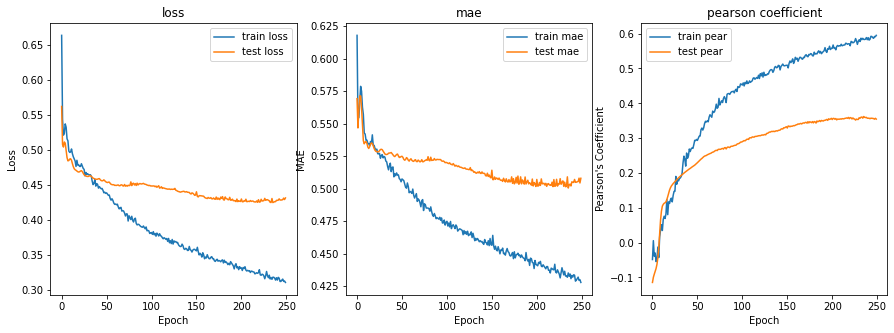

In [ ]:
import matplotlib.pyplot as plt

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))
ax1.plot(all_train_loss, label="train loss")
ax1.plot(all_test_loss, label="test loss")
ax1.set_ylabel("Loss")
ax1.set_xlabel("Epoch")
ax1.legend(loc="best")
ax1.set_title("loss")

ax2.plot(all_train_mae, label="train mae")
ax2.plot(all_test_mae, label="test mae")
ax2.set_title("mae")
ax2.set_ylabel("MAE")
ax2.set_xlabel("Epoch")
ax2.legend(loc="best")

ax3.plot(all_train_pear, label="train pear")
ax3.plot(all_test_pear, label="test pear")
ax3.set_title("pearson coefficient")
ax3.legend(loc="best")
ax3.set_ylabel("Pearson's Coefficient")
ax3.set_xlabel("Epoch")

# plt.show()

# training result without neutral labels

In [ ]:
# Instantiate model
model = RegressionModelNCE(D_m_text, D_m_audio, D_m_video, D_m_context, D_g, D_p, D_e, D_h, dropout_rec=args["rec_dropout"], dropout=args["dropout"])

if cuda:
    model.cuda()
loss_function = MaskedMSELoss()

# Get optimizer and relevant dataloaders
optimizer = optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['l2'])
train_loader, valid_loader, test_loader = get_MOSEI_loaders('/content/gdrive/MyDrive/11-777 MMML/multilogue-net/data/moseas_full_no_neutral_regression.pickle', valid=0.0, batch_size=batch_size, num_workers=0)
best_loss, best_label, best_pred, best_mask, best_pear = None, None, None, None, None
all_train_loss, all_test_loss, all_train_mae, all_test_mae, all_train_pear, all_test_pear = [],[],[],[],[],[]

In [ ]:
# Training loop
for e in tqdm(range(n_epochs), desc = 'MOSEAS Regression'):
    train_loss, train_mae, train_pear,_,_,_ = train_or_eval_model(model, loss_function, train_loader, e, optimizer, True)
    test_loss, test_mae, test_pear, test_label, test_pred, test_mask = train_or_eval_model(model, loss_function, test_loader, e)
    log_res(train_loss, test_loss, train_mae, test_mae, train_pear, test_pear)

    if best_loss == None or best_loss > test_loss:
        best_loss, best_mae, best_label, best_pred, best_mask, best_pear =\
                test_loss, test_mae, test_label, test_pred, test_mask, test_pear
        print(f"saving checkpoint for epoch {e}")
        model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self
        torch.save(model_to_save.state_dict(), f"/content/gdrive/MyDrive/11-777 MMML/multilogue-net/logs/moseas_noneutral_regression/epoch{e}_testloss_{best_loss}_testmae_{best_mae}_testpear_{best_pear}.pth")

print('Test performance..')
print('Loss {} MAE {} r {}'.format(best_loss, round(mean_absolute_error(best_label,best_pred,sample_weight=best_mask),4), best_pear))

MOSEAS Regression:   0%|          | 0/250 [00:00<?, ?it/s]

Train Loss - MOSEAS Regression:  1.3135
Test Loss - MOSEAS Regression:  1.1031
Train MAE - MOSEAS Regression:  1.0531
Test MAE - MOSEAS Regression:  0.9688
Train Pearson - MOSEAS Regression:  0.0321
Test Pearson - MOSEAS Regression:  0.0015
saving checkpoint for epoch 0


MOSEAS Regression:   1%|          | 2/250 [00:11<22:41,  5.49s/it]

Train Loss - MOSEAS Regression:  1.1251
Test Loss - MOSEAS Regression:  0.9351
Train MAE - MOSEAS Regression:  0.9609
Test MAE - MOSEAS Regression:  0.8617
Train Pearson - MOSEAS Regression:  -0.0299
Test Pearson - MOSEAS Regression:  0.035
saving checkpoint for epoch 1


MOSEAS Regression:   1%|          | 3/250 [00:15<20:46,  5.05s/it]

Train Loss - MOSEAS Regression:  0.9764
Test Loss - MOSEAS Regression:  0.831
Train MAE - MOSEAS Regression:  0.8591
Test MAE - MOSEAS Regression:  0.7614
Train Pearson - MOSEAS Regression:  -0.0143
Test Pearson - MOSEAS Regression:  0.0443
saving checkpoint for epoch 2


MOSEAS Regression:   2%|▏         | 4/250 [00:20<21:01,  5.13s/it]

Train Loss - MOSEAS Regression:  0.8929
Test Loss - MOSEAS Regression:  0.7808
Train MAE - MOSEAS Regression:  0.7786
Test MAE - MOSEAS Regression:  0.6873
Train Pearson - MOSEAS Regression:  0.0015
Test Pearson - MOSEAS Regression:  0.0487
saving checkpoint for epoch 3


MOSEAS Regression:   2%|▏         | 5/250 [00:25<20:44,  5.08s/it]

Train Loss - MOSEAS Regression:  0.8522
Test Loss - MOSEAS Regression:  0.769
Train MAE - MOSEAS Regression:  0.7221
Test MAE - MOSEAS Regression:  0.6546
Train Pearson - MOSEAS Regression:  0.0161
Test Pearson - MOSEAS Regression:  0.0512
saving checkpoint for epoch 4


MOSEAS Regression:   2%|▏         | 6/250 [00:31<20:53,  5.14s/it]

Train Loss - MOSEAS Regression:  0.8357
Test Loss - MOSEAS Regression:  0.7765
Train MAE - MOSEAS Regression:  0.6873
Test MAE - MOSEAS Regression:  0.6384
Train Pearson - MOSEAS Regression:  0.0431
Test Pearson - MOSEAS Regression:  0.0531


MOSEAS Regression:   3%|▎         | 7/250 [00:35<20:25,  5.04s/it]

Train Loss - MOSEAS Regression:  0.8664
Test Loss - MOSEAS Regression:  0.7867
Train MAE - MOSEAS Regression:  0.6858
Test MAE - MOSEAS Regression:  0.6327
Train Pearson - MOSEAS Regression:  -0.0028
Test Pearson - MOSEAS Regression:  0.0547


MOSEAS Regression:   3%|▎         | 8/250 [00:41<20:27,  5.07s/it]

Train Loss - MOSEAS Regression:  0.8741
Test Loss - MOSEAS Regression:  0.7907
Train MAE - MOSEAS Regression:  0.6768
Test MAE - MOSEAS Regression:  0.6305
Train Pearson - MOSEAS Regression:  -0.0003
Test Pearson - MOSEAS Regression:  0.0563


MOSEAS Regression:   4%|▎         | 9/250 [00:46<20:11,  5.03s/it]

Train Loss - MOSEAS Regression:  0.8822
Test Loss - MOSEAS Regression:  0.7843
Train MAE - MOSEAS Regression:  0.6763
Test MAE - MOSEAS Regression:  0.6268
Train Pearson - MOSEAS Regression:  -0.0083
Test Pearson - MOSEAS Regression:  0.0581


MOSEAS Regression:   4%|▍         | 10/250 [00:50<20:01,  5.01s/it]

Train Loss - MOSEAS Regression:  0.8701
Test Loss - MOSEAS Regression:  0.7723
Train MAE - MOSEAS Regression:  0.6749
Test MAE - MOSEAS Regression:  0.624
Train Pearson - MOSEAS Regression:  -0.0052
Test Pearson - MOSEAS Regression:  0.0601


MOSEAS Regression:   4%|▍         | 11/250 [00:55<19:52,  4.99s/it]

Train Loss - MOSEAS Regression:  0.8575
Test Loss - MOSEAS Regression:  0.7602
Train MAE - MOSEAS Regression:  0.6683
Test MAE - MOSEAS Regression:  0.6254
Train Pearson - MOSEAS Regression:  0.0023
Test Pearson - MOSEAS Regression:  0.0626
saving checkpoint for epoch 10


MOSEAS Regression:   5%|▍         | 12/250 [01:00<19:12,  4.84s/it]

Train Loss - MOSEAS Regression:  0.8354
Test Loss - MOSEAS Regression:  0.7513
Train MAE - MOSEAS Regression:  0.6682
Test MAE - MOSEAS Regression:  0.6293
Train Pearson - MOSEAS Regression:  0.02
Test Pearson - MOSEAS Regression:  0.0656
saving checkpoint for epoch 11


MOSEAS Regression:   5%|▌         | 13/250 [01:05<19:21,  4.90s/it]

Train Loss - MOSEAS Regression:  0.8237
Test Loss - MOSEAS Regression:  0.7465
Train MAE - MOSEAS Regression:  0.6679
Test MAE - MOSEAS Regression:  0.6341
Train Pearson - MOSEAS Regression:  0.0252
Test Pearson - MOSEAS Regression:  0.0692
saving checkpoint for epoch 12


MOSEAS Regression:   6%|▌         | 14/250 [01:10<19:12,  4.88s/it]

Train Loss - MOSEAS Regression:  0.8114
Test Loss - MOSEAS Regression:  0.7453
Train MAE - MOSEAS Regression:  0.671
Test MAE - MOSEAS Regression:  0.6383
Train Pearson - MOSEAS Regression:  0.0525
Test Pearson - MOSEAS Regression:  0.0733
saving checkpoint for epoch 13


MOSEAS Regression:   6%|▌         | 15/250 [01:15<19:29,  4.98s/it]

Train Loss - MOSEAS Regression:  0.8062
Test Loss - MOSEAS Regression:  0.7461
Train MAE - MOSEAS Regression:  0.6774
Test MAE - MOSEAS Regression:  0.642
Train Pearson - MOSEAS Regression:  0.0587
Test Pearson - MOSEAS Regression:  0.0779


MOSEAS Regression:   6%|▋         | 16/250 [01:20<19:25,  4.98s/it]

Train Loss - MOSEAS Regression:  0.8093
Test Loss - MOSEAS Regression:  0.748
Train MAE - MOSEAS Regression:  0.6835
Test MAE - MOSEAS Regression:  0.6471
Train Pearson - MOSEAS Regression:  0.0536
Test Pearson - MOSEAS Regression:  0.0831


MOSEAS Regression:   7%|▋         | 17/250 [01:25<19:16,  4.96s/it]

Train Loss - MOSEAS Regression:  0.8139
Test Loss - MOSEAS Regression:  0.7488
Train MAE - MOSEAS Regression:  0.6927
Test MAE - MOSEAS Regression:  0.6515
Train Pearson - MOSEAS Regression:  0.0443
Test Pearson - MOSEAS Regression:  0.0882


MOSEAS Regression:   7%|▋         | 18/250 [01:30<19:09,  4.95s/it]

Train Loss - MOSEAS Regression:  0.8181
Test Loss - MOSEAS Regression:  0.7484
Train MAE - MOSEAS Regression:  0.6938
Test MAE - MOSEAS Regression:  0.6531
Train Pearson - MOSEAS Regression:  0.0259
Test Pearson - MOSEAS Regression:  0.0931


MOSEAS Regression:   8%|▊         | 19/250 [01:34<18:33,  4.82s/it]

Train Loss - MOSEAS Regression:  0.8094
Test Loss - MOSEAS Regression:  0.7464
Train MAE - MOSEAS Regression:  0.6917
Test MAE - MOSEAS Regression:  0.6501
Train Pearson - MOSEAS Regression:  0.0574
Test Pearson - MOSEAS Regression:  0.0976


MOSEAS Regression:   8%|▊         | 20/250 [01:39<18:32,  4.84s/it]

Train Loss - MOSEAS Regression:  0.8027
Test Loss - MOSEAS Regression:  0.7426
Train MAE - MOSEAS Regression:  0.689
Test MAE - MOSEAS Regression:  0.6424
Train Pearson - MOSEAS Regression:  0.0798
Test Pearson - MOSEAS Regression:  0.1013
saving checkpoint for epoch 19


MOSEAS Regression:   8%|▊         | 21/250 [01:44<18:04,  4.74s/it]

Train Loss - MOSEAS Regression:  0.801
Test Loss - MOSEAS Regression:  0.7392
Train MAE - MOSEAS Regression:  0.6799
Test MAE - MOSEAS Regression:  0.6358
Train Pearson - MOSEAS Regression:  0.0691
Test Pearson - MOSEAS Regression:  0.105
saving checkpoint for epoch 20


MOSEAS Regression:   9%|▉         | 22/250 [01:49<18:10,  4.78s/it]

Train Loss - MOSEAS Regression:  0.8002
Test Loss - MOSEAS Regression:  0.7358
Train MAE - MOSEAS Regression:  0.6733
Test MAE - MOSEAS Regression:  0.6287
Train Pearson - MOSEAS Regression:  0.0659
Test Pearson - MOSEAS Regression:  0.1083
saving checkpoint for epoch 21


MOSEAS Regression:   9%|▉         | 23/250 [01:54<18:19,  4.84s/it]

Train Loss - MOSEAS Regression:  0.7901
Test Loss - MOSEAS Regression:  0.7335
Train MAE - MOSEAS Regression:  0.6629
Test MAE - MOSEAS Regression:  0.6239
Train Pearson - MOSEAS Regression:  0.0929
Test Pearson - MOSEAS Regression:  0.1121
saving checkpoint for epoch 22


MOSEAS Regression:  10%|▉         | 24/250 [01:59<18:23,  4.88s/it]

Train Loss - MOSEAS Regression:  0.7958
Test Loss - MOSEAS Regression:  0.7318
Train MAE - MOSEAS Regression:  0.6636
Test MAE - MOSEAS Regression:  0.6206
Train Pearson - MOSEAS Regression:  0.0683
Test Pearson - MOSEAS Regression:  0.1163
saving checkpoint for epoch 23


MOSEAS Regression:  10%|█         | 25/250 [02:04<18:26,  4.92s/it]

Train Loss - MOSEAS Regression:  0.7923
Test Loss - MOSEAS Regression:  0.7305
Train MAE - MOSEAS Regression:  0.6557
Test MAE - MOSEAS Regression:  0.6173
Train Pearson - MOSEAS Regression:  0.0807
Test Pearson - MOSEAS Regression:  0.1203
saving checkpoint for epoch 24


MOSEAS Regression:  10%|█         | 26/250 [02:08<18:13,  4.88s/it]

Train Loss - MOSEAS Regression:  0.784
Test Loss - MOSEAS Regression:  0.7294
Train MAE - MOSEAS Regression:  0.6531
Test MAE - MOSEAS Regression:  0.6156
Train Pearson - MOSEAS Regression:  0.1065
Test Pearson - MOSEAS Regression:  0.1253
saving checkpoint for epoch 25


MOSEAS Regression:  11%|█         | 27/250 [02:13<18:21,  4.94s/it]

Train Loss - MOSEAS Regression:  0.795
Test Loss - MOSEAS Regression:  0.7284
Train MAE - MOSEAS Regression:  0.6552
Test MAE - MOSEAS Regression:  0.6148
Train Pearson - MOSEAS Regression:  0.069
Test Pearson - MOSEAS Regression:  0.1309
saving checkpoint for epoch 26


MOSEAS Regression:  11%|█         | 28/250 [02:19<18:34,  5.02s/it]

Train Loss - MOSEAS Regression:  0.7816
Test Loss - MOSEAS Regression:  0.7274
Train MAE - MOSEAS Regression:  0.6461
Test MAE - MOSEAS Regression:  0.6146
Train Pearson - MOSEAS Regression:  0.1144
Test Pearson - MOSEAS Regression:  0.1367
saving checkpoint for epoch 27


MOSEAS Regression:  12%|█▏        | 29/250 [02:23<18:05,  4.91s/it]

Train Loss - MOSEAS Regression:  0.7879
Test Loss - MOSEAS Regression:  0.7267
Train MAE - MOSEAS Regression:  0.6499
Test MAE - MOSEAS Regression:  0.6162
Train Pearson - MOSEAS Regression:  0.0946
Test Pearson - MOSEAS Regression:  0.1432
saving checkpoint for epoch 28


MOSEAS Regression:  12%|█▏        | 30/250 [02:28<18:04,  4.93s/it]

Train Loss - MOSEAS Regression:  0.7729
Test Loss - MOSEAS Regression:  0.726
Train MAE - MOSEAS Regression:  0.6448
Test MAE - MOSEAS Regression:  0.6174
Train Pearson - MOSEAS Regression:  0.1459
Test Pearson - MOSEAS Regression:  0.149
saving checkpoint for epoch 29


MOSEAS Regression:  12%|█▏        | 31/250 [02:33<17:39,  4.84s/it]

Train Loss - MOSEAS Regression:  0.7696
Test Loss - MOSEAS Regression:  0.7254
Train MAE - MOSEAS Regression:  0.6429
Test MAE - MOSEAS Regression:  0.6188
Train Pearson - MOSEAS Regression:  0.1576
Test Pearson - MOSEAS Regression:  0.1544
saving checkpoint for epoch 30


MOSEAS Regression:  13%|█▎        | 32/250 [02:38<17:42,  4.87s/it]

Train Loss - MOSEAS Regression:  0.7779
Test Loss - MOSEAS Regression:  0.7247
Train MAE - MOSEAS Regression:  0.6524
Test MAE - MOSEAS Regression:  0.6195
Train Pearson - MOSEAS Regression:  0.1319
Test Pearson - MOSEAS Regression:  0.1594
saving checkpoint for epoch 31


MOSEAS Regression:  13%|█▎        | 33/250 [02:43<17:48,  4.92s/it]

Train Loss - MOSEAS Regression:  0.7746
Test Loss - MOSEAS Regression:  0.7239
Train MAE - MOSEAS Regression:  0.6501
Test MAE - MOSEAS Regression:  0.6195
Train Pearson - MOSEAS Regression:  0.141
Test Pearson - MOSEAS Regression:  0.1639
saving checkpoint for epoch 32


MOSEAS Regression:  14%|█▎        | 34/250 [02:48<17:24,  4.84s/it]

Train Loss - MOSEAS Regression:  0.7648
Test Loss - MOSEAS Regression:  0.7231
Train MAE - MOSEAS Regression:  0.6423
Test MAE - MOSEAS Regression:  0.6197
Train Pearson - MOSEAS Regression:  0.1746
Test Pearson - MOSEAS Regression:  0.1678
saving checkpoint for epoch 33


MOSEAS Regression:  14%|█▍        | 35/250 [02:53<17:43,  4.95s/it]

Train Loss - MOSEAS Regression:  0.7708
Test Loss - MOSEAS Regression:  0.7223
Train MAE - MOSEAS Regression:  0.6481
Test MAE - MOSEAS Regression:  0.6197
Train Pearson - MOSEAS Regression:  0.1553
Test Pearson - MOSEAS Regression:  0.1712
saving checkpoint for epoch 34


MOSEAS Regression:  14%|█▍        | 36/250 [02:58<17:41,  4.96s/it]

Train Loss - MOSEAS Regression:  0.7662
Test Loss - MOSEAS Regression:  0.7214
Train MAE - MOSEAS Regression:  0.646
Test MAE - MOSEAS Regression:  0.6193
Train Pearson - MOSEAS Regression:  0.1712
Test Pearson - MOSEAS Regression:  0.1744
saving checkpoint for epoch 35


MOSEAS Regression:  15%|█▍        | 37/250 [03:03<17:31,  4.94s/it]

Train Loss - MOSEAS Regression:  0.7617
Test Loss - MOSEAS Regression:  0.7205
Train MAE - MOSEAS Regression:  0.6406
Test MAE - MOSEAS Regression:  0.6187
Train Pearson - MOSEAS Regression:  0.1847
Test Pearson - MOSEAS Regression:  0.1775
saving checkpoint for epoch 36


MOSEAS Regression:  15%|█▌        | 38/250 [03:07<17:21,  4.91s/it]

Train Loss - MOSEAS Regression:  0.7674
Test Loss - MOSEAS Regression:  0.7193
Train MAE - MOSEAS Regression:  0.6481
Test MAE - MOSEAS Regression:  0.6173
Train Pearson - MOSEAS Regression:  0.1661
Test Pearson - MOSEAS Regression:  0.1807
saving checkpoint for epoch 37


MOSEAS Regression:  16%|█▌        | 39/250 [03:12<17:03,  4.85s/it]

Train Loss - MOSEAS Regression:  0.7574
Test Loss - MOSEAS Regression:  0.7188
Train MAE - MOSEAS Regression:  0.642
Test MAE - MOSEAS Regression:  0.6183
Train Pearson - MOSEAS Regression:  0.1995
Test Pearson - MOSEAS Regression:  0.183
saving checkpoint for epoch 38


MOSEAS Regression:  16%|█▌        | 40/250 [03:17<17:09,  4.90s/it]

Train Loss - MOSEAS Regression:  0.7579
Test Loss - MOSEAS Regression:  0.7179
Train MAE - MOSEAS Regression:  0.6426
Test MAE - MOSEAS Regression:  0.6179
Train Pearson - MOSEAS Regression:  0.1983
Test Pearson - MOSEAS Regression:  0.1855
saving checkpoint for epoch 39


MOSEAS Regression:  16%|█▋        | 41/250 [03:23<17:29,  5.02s/it]

Train Loss - MOSEAS Regression:  0.7557
Test Loss - MOSEAS Regression:  0.717
Train MAE - MOSEAS Regression:  0.6383
Test MAE - MOSEAS Regression:  0.6175
Train Pearson - MOSEAS Regression:  0.2049
Test Pearson - MOSEAS Regression:  0.1878
saving checkpoint for epoch 40


MOSEAS Regression:  17%|█▋        | 42/250 [03:28<17:41,  5.10s/it]

Train Loss - MOSEAS Regression:  0.753
Test Loss - MOSEAS Regression:  0.7157
Train MAE - MOSEAS Regression:  0.6398
Test MAE - MOSEAS Regression:  0.6155
Train Pearson - MOSEAS Regression:  0.2136
Test Pearson - MOSEAS Regression:  0.1908
saving checkpoint for epoch 41


MOSEAS Regression:  17%|█▋        | 43/250 [03:32<17:02,  4.94s/it]

Train Loss - MOSEAS Regression:  0.7488
Test Loss - MOSEAS Regression:  0.7147
Train MAE - MOSEAS Regression:  0.6361
Test MAE - MOSEAS Regression:  0.6146
Train Pearson - MOSEAS Regression:  0.2242
Test Pearson - MOSEAS Regression:  0.1931
saving checkpoint for epoch 42


MOSEAS Regression:  18%|█▊        | 44/250 [03:37<17:00,  4.95s/it]

Train Loss - MOSEAS Regression:  0.7373
Test Loss - MOSEAS Regression:  0.7139
Train MAE - MOSEAS Regression:  0.6291
Test MAE - MOSEAS Regression:  0.6144
Train Pearson - MOSEAS Regression:  0.2569
Test Pearson - MOSEAS Regression:  0.1953
saving checkpoint for epoch 43


MOSEAS Regression:  18%|█▊        | 45/250 [03:42<16:57,  4.96s/it]

Train Loss - MOSEAS Regression:  0.7404
Test Loss - MOSEAS Regression:  0.7133
Train MAE - MOSEAS Regression:  0.6337
Test MAE - MOSEAS Regression:  0.615
Train Pearson - MOSEAS Regression:  0.2489
Test Pearson - MOSEAS Regression:  0.1968
saving checkpoint for epoch 44


MOSEAS Regression:  18%|█▊        | 46/250 [03:48<17:13,  5.07s/it]

Train Loss - MOSEAS Regression:  0.7356
Test Loss - MOSEAS Regression:  0.7126
Train MAE - MOSEAS Regression:  0.6267
Test MAE - MOSEAS Regression:  0.6155
Train Pearson - MOSEAS Regression:  0.2611
Test Pearson - MOSEAS Regression:  0.1985
saving checkpoint for epoch 45


MOSEAS Regression:  19%|█▉        | 47/250 [03:52<16:36,  4.91s/it]

Train Loss - MOSEAS Regression:  0.7324
Test Loss - MOSEAS Regression:  0.7125
Train MAE - MOSEAS Regression:  0.6255
Test MAE - MOSEAS Regression:  0.6172
Train Pearson - MOSEAS Regression:  0.2707
Test Pearson - MOSEAS Regression:  0.1991
saving checkpoint for epoch 46


MOSEAS Regression:  19%|█▉        | 48/250 [03:57<16:33,  4.92s/it]

Train Loss - MOSEAS Regression:  0.728
Test Loss - MOSEAS Regression:  0.7124
Train MAE - MOSEAS Regression:  0.6308
Test MAE - MOSEAS Regression:  0.6193
Train Pearson - MOSEAS Regression:  0.2821
Test Pearson - MOSEAS Regression:  0.1999
saving checkpoint for epoch 47


MOSEAS Regression:  20%|█▉        | 49/250 [04:02<16:26,  4.91s/it]

Train Loss - MOSEAS Regression:  0.7263
Test Loss - MOSEAS Regression:  0.7112
Train MAE - MOSEAS Regression:  0.6286
Test MAE - MOSEAS Regression:  0.6182
Train Pearson - MOSEAS Regression:  0.2846
Test Pearson - MOSEAS Regression:  0.2028
saving checkpoint for epoch 48


MOSEAS Regression:  20%|██        | 50/250 [04:07<16:20,  4.90s/it]

Train Loss - MOSEAS Regression:  0.7229
Test Loss - MOSEAS Regression:  0.7097
Train MAE - MOSEAS Regression:  0.6235
Test MAE - MOSEAS Regression:  0.6158
Train Pearson - MOSEAS Regression:  0.2918
Test Pearson - MOSEAS Regression:  0.2064
saving checkpoint for epoch 49


MOSEAS Regression:  20%|██        | 51/250 [04:12<16:21,  4.93s/it]

Train Loss - MOSEAS Regression:  0.7219
Test Loss - MOSEAS Regression:  0.7083
Train MAE - MOSEAS Regression:  0.6267
Test MAE - MOSEAS Regression:  0.6134
Train Pearson - MOSEAS Regression:  0.2935
Test Pearson - MOSEAS Regression:  0.2102
saving checkpoint for epoch 50


MOSEAS Regression:  21%|██        | 52/250 [04:17<16:36,  5.03s/it]

Train Loss - MOSEAS Regression:  0.7125
Test Loss - MOSEAS Regression:  0.7071
Train MAE - MOSEAS Regression:  0.618
Test MAE - MOSEAS Regression:  0.6112
Train Pearson - MOSEAS Regression:  0.3151
Test Pearson - MOSEAS Regression:  0.2136
saving checkpoint for epoch 51


MOSEAS Regression:  21%|██        | 53/250 [04:22<16:37,  5.06s/it]

Train Loss - MOSEAS Regression:  0.7162
Test Loss - MOSEAS Regression:  0.7069
Train MAE - MOSEAS Regression:  0.6196
Test MAE - MOSEAS Regression:  0.6131
Train Pearson - MOSEAS Regression:  0.3037
Test Pearson - MOSEAS Regression:  0.2143
saving checkpoint for epoch 52


MOSEAS Regression:  22%|██▏       | 54/250 [04:28<16:39,  5.10s/it]

Train Loss - MOSEAS Regression:  0.7211
Test Loss - MOSEAS Regression:  0.7079
Train MAE - MOSEAS Regression:  0.6225
Test MAE - MOSEAS Regression:  0.6181
Train Pearson - MOSEAS Regression:  0.2925
Test Pearson - MOSEAS Regression:  0.2129


MOSEAS Regression:  22%|██▏       | 55/250 [04:33<16:41,  5.13s/it]

Train Loss - MOSEAS Regression:  0.716
Test Loss - MOSEAS Regression:  0.7082
Train MAE - MOSEAS Regression:  0.625
Test MAE - MOSEAS Regression:  0.6205
Train Pearson - MOSEAS Regression:  0.3042
Test Pearson - MOSEAS Regression:  0.2134


MOSEAS Regression:  22%|██▏       | 56/250 [04:37<16:08,  4.99s/it]

Train Loss - MOSEAS Regression:  0.7052
Test Loss - MOSEAS Regression:  0.7093
Train MAE - MOSEAS Regression:  0.623
Test MAE - MOSEAS Regression:  0.624
Train Pearson - MOSEAS Regression:  0.3271
Test Pearson - MOSEAS Regression:  0.2128


MOSEAS Regression:  23%|██▎       | 57/250 [04:42<15:58,  4.97s/it]

Train Loss - MOSEAS Regression:  0.6992
Test Loss - MOSEAS Regression:  0.7074
Train MAE - MOSEAS Regression:  0.6181
Test MAE - MOSEAS Regression:  0.6213
Train Pearson - MOSEAS Regression:  0.3392
Test Pearson - MOSEAS Regression:  0.217


MOSEAS Regression:  23%|██▎       | 58/250 [04:47<15:52,  4.96s/it]

Train Loss - MOSEAS Regression:  0.6996
Test Loss - MOSEAS Regression:  0.7061
Train MAE - MOSEAS Regression:  0.6203
Test MAE - MOSEAS Regression:  0.6199
Train Pearson - MOSEAS Regression:  0.3389
Test Pearson - MOSEAS Regression:  0.2205
saving checkpoint for epoch 57


MOSEAS Regression:  24%|██▎       | 59/250 [04:52<15:35,  4.90s/it]

Train Loss - MOSEAS Regression:  0.6956
Test Loss - MOSEAS Regression:  0.7038
Train MAE - MOSEAS Regression:  0.615
Test MAE - MOSEAS Regression:  0.6156
Train Pearson - MOSEAS Regression:  0.3451
Test Pearson - MOSEAS Regression:  0.2262
saving checkpoint for epoch 58


MOSEAS Regression:  24%|██▍       | 60/250 [04:57<15:33,  4.92s/it]

Train Loss - MOSEAS Regression:  0.699
Test Loss - MOSEAS Regression:  0.7026
Train MAE - MOSEAS Regression:  0.6091
Test MAE - MOSEAS Regression:  0.613
Train Pearson - MOSEAS Regression:  0.3384
Test Pearson - MOSEAS Regression:  0.2304
saving checkpoint for epoch 59


MOSEAS Regression:  24%|██▍       | 61/250 [05:02<15:37,  4.96s/it]

Train Loss - MOSEAS Regression:  0.697
Test Loss - MOSEAS Regression:  0.7023
Train MAE - MOSEAS Regression:  0.6096
Test MAE - MOSEAS Regression:  0.6147
Train Pearson - MOSEAS Regression:  0.3416
Test Pearson - MOSEAS Regression:  0.2317
saving checkpoint for epoch 60


MOSEAS Regression:  25%|██▍       | 62/250 [05:07<15:30,  4.95s/it]

Train Loss - MOSEAS Regression:  0.6897
Test Loss - MOSEAS Regression:  0.703
Train MAE - MOSEAS Regression:  0.6097
Test MAE - MOSEAS Regression:  0.6197
Train Pearson - MOSEAS Regression:  0.3561
Test Pearson - MOSEAS Regression:  0.2309


MOSEAS Regression:  25%|██▌       | 63/250 [05:12<15:22,  4.93s/it]

Train Loss - MOSEAS Regression:  0.6935
Test Loss - MOSEAS Regression:  0.7033
Train MAE - MOSEAS Regression:  0.6156
Test MAE - MOSEAS Regression:  0.6221
Train Pearson - MOSEAS Regression:  0.3474
Test Pearson - MOSEAS Regression:  0.2317


MOSEAS Regression:  26%|██▌       | 64/250 [05:17<15:30,  5.00s/it]

Train Loss - MOSEAS Regression:  0.6873
Test Loss - MOSEAS Regression:  0.7025
Train MAE - MOSEAS Regression:  0.6137
Test MAE - MOSEAS Regression:  0.622
Train Pearson - MOSEAS Regression:  0.3596
Test Pearson - MOSEAS Regression:  0.2344


MOSEAS Regression:  26%|██▌       | 65/250 [05:22<15:24,  5.00s/it]

Train Loss - MOSEAS Regression:  0.6806
Test Loss - MOSEAS Regression:  0.6997
Train MAE - MOSEAS Regression:  0.6076
Test MAE - MOSEAS Regression:  0.6172
Train Pearson - MOSEAS Regression:  0.3714
Test Pearson - MOSEAS Regression:  0.2408
saving checkpoint for epoch 64


MOSEAS Regression:  26%|██▋       | 66/250 [05:27<15:35,  5.08s/it]

Train Loss - MOSEAS Regression:  0.685
Test Loss - MOSEAS Regression:  0.6978
Train MAE - MOSEAS Regression:  0.6103
Test MAE - MOSEAS Regression:  0.615
Train Pearson - MOSEAS Regression:  0.3632
Test Pearson - MOSEAS Regression:  0.2459
saving checkpoint for epoch 65


MOSEAS Regression:  27%|██▋       | 67/250 [05:33<15:41,  5.15s/it]

Train Loss - MOSEAS Regression:  0.6772
Test Loss - MOSEAS Regression:  0.6973
Train MAE - MOSEAS Regression:  0.6025
Test MAE - MOSEAS Regression:  0.6164
Train Pearson - MOSEAS Regression:  0.3773
Test Pearson - MOSEAS Regression:  0.2478
saving checkpoint for epoch 66


MOSEAS Regression:  27%|██▋       | 68/250 [05:38<15:40,  5.17s/it]

Train Loss - MOSEAS Regression:  0.6765
Test Loss - MOSEAS Regression:  0.6972
Train MAE - MOSEAS Regression:  0.6064
Test MAE - MOSEAS Regression:  0.619
Train Pearson - MOSEAS Regression:  0.3783
Test Pearson - MOSEAS Regression:  0.2488
saving checkpoint for epoch 67


MOSEAS Regression:  28%|██▊       | 69/250 [05:43<15:17,  5.07s/it]

Train Loss - MOSEAS Regression:  0.6707
Test Loss - MOSEAS Regression:  0.696
Train MAE - MOSEAS Regression:  0.6038
Test MAE - MOSEAS Regression:  0.6181
Train Pearson - MOSEAS Regression:  0.3884
Test Pearson - MOSEAS Regression:  0.2524
saving checkpoint for epoch 68


MOSEAS Regression:  28%|██▊       | 70/250 [05:47<15:01,  5.01s/it]

Train Loss - MOSEAS Regression:  0.668
Test Loss - MOSEAS Regression:  0.6958
Train MAE - MOSEAS Regression:  0.6022
Test MAE - MOSEAS Regression:  0.6209
Train Pearson - MOSEAS Regression:  0.3927
Test Pearson - MOSEAS Regression:  0.2539
saving checkpoint for epoch 69


MOSEAS Regression:  28%|██▊       | 71/250 [05:52<14:48,  4.97s/it]

Train Loss - MOSEAS Regression:  0.6638
Test Loss - MOSEAS Regression:  0.6933
Train MAE - MOSEAS Regression:  0.6023
Test MAE - MOSEAS Regression:  0.6157
Train Pearson - MOSEAS Regression:  0.4003
Test Pearson - MOSEAS Regression:  0.2598
saving checkpoint for epoch 70


MOSEAS Regression:  29%|██▉       | 72/250 [05:57<14:50,  5.00s/it]

Train Loss - MOSEAS Regression:  0.6603
Test Loss - MOSEAS Regression:  0.6921
Train MAE - MOSEAS Regression:  0.5966
Test MAE - MOSEAS Regression:  0.61
Train Pearson - MOSEAS Regression:  0.4047
Test Pearson - MOSEAS Regression:  0.2655
saving checkpoint for epoch 71


MOSEAS Regression:  29%|██▉       | 73/250 [06:02<14:26,  4.90s/it]

Train Loss - MOSEAS Regression:  0.6612
Test Loss - MOSEAS Regression:  0.6918
Train MAE - MOSEAS Regression:  0.5956
Test MAE - MOSEAS Regression:  0.6102
Train Pearson - MOSEAS Regression:  0.404
Test Pearson - MOSEAS Regression:  0.2672
saving checkpoint for epoch 72


MOSEAS Regression:  30%|██▉       | 74/250 [06:07<14:26,  4.92s/it]

Train Loss - MOSEAS Regression:  0.662
Test Loss - MOSEAS Regression:  0.6919
Train MAE - MOSEAS Regression:  0.5929
Test MAE - MOSEAS Regression:  0.6161
Train Pearson - MOSEAS Regression:  0.4016
Test Pearson - MOSEAS Regression:  0.2659


MOSEAS Regression:  30%|███       | 75/250 [06:12<14:24,  4.94s/it]

Train Loss - MOSEAS Regression:  0.6616
Test Loss - MOSEAS Regression:  0.6944
Train MAE - MOSEAS Regression:  0.6003
Test MAE - MOSEAS Regression:  0.6244
Train Pearson - MOSEAS Regression:  0.4028
Test Pearson - MOSEAS Regression:  0.2625


MOSEAS Regression:  30%|███       | 76/250 [06:17<14:15,  4.92s/it]

Train Loss - MOSEAS Regression:  0.6454
Test Loss - MOSEAS Regression:  0.6925
Train MAE - MOSEAS Regression:  0.5953
Test MAE - MOSEAS Regression:  0.6208
Train Pearson - MOSEAS Regression:  0.429
Test Pearson - MOSEAS Regression:  0.2666


MOSEAS Regression:  31%|███       | 77/250 [06:22<13:57,  4.84s/it]

Train Loss - MOSEAS Regression:  0.6511
Test Loss - MOSEAS Regression:  0.6907
Train MAE - MOSEAS Regression:  0.5952
Test MAE - MOSEAS Regression:  0.6135
Train Pearson - MOSEAS Regression:  0.4176
Test Pearson - MOSEAS Regression:  0.2727
saving checkpoint for epoch 76


MOSEAS Regression:  31%|███       | 78/250 [06:27<14:12,  4.95s/it]

Train Loss - MOSEAS Regression:  0.6501
Test Loss - MOSEAS Regression:  0.691
Train MAE - MOSEAS Regression:  0.5914
Test MAE - MOSEAS Regression:  0.6168
Train Pearson - MOSEAS Regression:  0.4193
Test Pearson - MOSEAS Regression:  0.2721


MOSEAS Regression:  32%|███▏      | 79/250 [06:32<14:04,  4.94s/it]

Train Loss - MOSEAS Regression:  0.6362
Test Loss - MOSEAS Regression:  0.6917
Train MAE - MOSEAS Regression:  0.5872
Test MAE - MOSEAS Regression:  0.6201
Train Pearson - MOSEAS Regression:  0.4398
Test Pearson - MOSEAS Regression:  0.2712


MOSEAS Regression:  32%|███▏      | 80/250 [06:36<13:19,  4.71s/it]

Train Loss - MOSEAS Regression:  0.644
Test Loss - MOSEAS Regression:  0.6919
Train MAE - MOSEAS Regression:  0.5907
Test MAE - MOSEAS Regression:  0.6209
Train Pearson - MOSEAS Regression:  0.4288
Test Pearson - MOSEAS Regression:  0.2717


MOSEAS Regression:  32%|███▏      | 81/250 [06:41<13:43,  4.87s/it]

Train Loss - MOSEAS Regression:  0.6351
Test Loss - MOSEAS Regression:  0.6911
Train MAE - MOSEAS Regression:  0.5848
Test MAE - MOSEAS Regression:  0.6149
Train Pearson - MOSEAS Regression:  0.4428
Test Pearson - MOSEAS Regression:  0.2755


MOSEAS Regression:  33%|███▎      | 82/250 [06:46<13:46,  4.92s/it]

Train Loss - MOSEAS Regression:  0.6357
Test Loss - MOSEAS Regression:  0.692
Train MAE - MOSEAS Regression:  0.5818
Test MAE - MOSEAS Regression:  0.6171
Train Pearson - MOSEAS Regression:  0.4418
Test Pearson - MOSEAS Regression:  0.2746


MOSEAS Regression:  33%|███▎      | 83/250 [06:51<13:41,  4.92s/it]

Train Loss - MOSEAS Regression:  0.631
Test Loss - MOSEAS Regression:  0.6965
Train MAE - MOSEAS Regression:  0.5853
Test MAE - MOSEAS Regression:  0.6279
Train Pearson - MOSEAS Regression:  0.4489
Test Pearson - MOSEAS Regression:  0.2685


MOSEAS Regression:  34%|███▎      | 84/250 [06:56<13:15,  4.79s/it]

Train Loss - MOSEAS Regression:  0.6263
Test Loss - MOSEAS Regression:  0.6956
Train MAE - MOSEAS Regression:  0.5922
Test MAE - MOSEAS Regression:  0.6242
Train Pearson - MOSEAS Regression:  0.4558
Test Pearson - MOSEAS Regression:  0.2705


MOSEAS Regression:  34%|███▍      | 85/250 [07:00<13:15,  4.82s/it]

Train Loss - MOSEAS Regression:  0.6292
Test Loss - MOSEAS Regression:  0.6954
Train MAE - MOSEAS Regression:  0.585
Test MAE - MOSEAS Regression:  0.62
Train Pearson - MOSEAS Regression:  0.4498
Test Pearson - MOSEAS Regression:  0.2725


MOSEAS Regression:  34%|███▍      | 86/250 [07:05<13:19,  4.88s/it]

Train Loss - MOSEAS Regression:  0.6287
Test Loss - MOSEAS Regression:  0.6969
Train MAE - MOSEAS Regression:  0.585
Test MAE - MOSEAS Regression:  0.6204
Train Pearson - MOSEAS Regression:  0.4503
Test Pearson - MOSEAS Regression:  0.2716


MOSEAS Regression:  35%|███▍      | 87/250 [07:10<13:00,  4.79s/it]

Train Loss - MOSEAS Regression:  0.6226
Test Loss - MOSEAS Regression:  0.6981
Train MAE - MOSEAS Regression:  0.5792
Test MAE - MOSEAS Regression:  0.6189
Train Pearson - MOSEAS Regression:  0.4587
Test Pearson - MOSEAS Regression:  0.2718


MOSEAS Regression:  35%|███▌      | 88/250 [07:15<12:51,  4.76s/it]

Train Loss - MOSEAS Regression:  0.6259
Test Loss - MOSEAS Regression:  0.7019
Train MAE - MOSEAS Regression:  0.5803
Test MAE - MOSEAS Regression:  0.6272
Train Pearson - MOSEAS Regression:  0.4542
Test Pearson - MOSEAS Regression:  0.2669


MOSEAS Regression:  36%|███▌      | 89/250 [07:19<12:33,  4.68s/it]

Train Loss - MOSEAS Regression:  0.6199
Test Loss - MOSEAS Regression:  0.7019
Train MAE - MOSEAS Regression:  0.5805
Test MAE - MOSEAS Regression:  0.6243
Train Pearson - MOSEAS Regression:  0.4627
Test Pearson - MOSEAS Regression:  0.2683


MOSEAS Regression:  36%|███▌      | 90/250 [07:24<12:40,  4.75s/it]

Train Loss - MOSEAS Regression:  0.6274
Test Loss - MOSEAS Regression:  0.7015
Train MAE - MOSEAS Regression:  0.5841
Test MAE - MOSEAS Regression:  0.6193
Train Pearson - MOSEAS Regression:  0.4518
Test Pearson - MOSEAS Regression:  0.2712


MOSEAS Regression:  36%|███▋      | 91/250 [07:29<12:45,  4.82s/it]

Train Loss - MOSEAS Regression:  0.6143
Test Loss - MOSEAS Regression:  0.7023
Train MAE - MOSEAS Regression:  0.5769
Test MAE - MOSEAS Regression:  0.6186
Train Pearson - MOSEAS Regression:  0.4703
Test Pearson - MOSEAS Regression:  0.2716


MOSEAS Regression:  37%|███▋      | 92/250 [07:34<12:49,  4.87s/it]

Train Loss - MOSEAS Regression:  0.6145
Test Loss - MOSEAS Regression:  0.705
Train MAE - MOSEAS Regression:  0.5762
Test MAE - MOSEAS Regression:  0.6269
Train Pearson - MOSEAS Regression:  0.4703
Test Pearson - MOSEAS Regression:  0.268


MOSEAS Regression:  37%|███▋      | 93/250 [07:39<12:49,  4.90s/it]

Train Loss - MOSEAS Regression:  0.61
Test Loss - MOSEAS Regression:  0.7045
Train MAE - MOSEAS Regression:  0.5767
Test MAE - MOSEAS Regression:  0.6242
Train Pearson - MOSEAS Regression:  0.4769
Test Pearson - MOSEAS Regression:  0.2702


MOSEAS Regression:  38%|███▊      | 94/250 [07:44<12:56,  4.98s/it]

Train Loss - MOSEAS Regression:  0.612
Test Loss - MOSEAS Regression:  0.7044
Train MAE - MOSEAS Regression:  0.579
Test MAE - MOSEAS Regression:  0.6196
Train Pearson - MOSEAS Regression:  0.4738
Test Pearson - MOSEAS Regression:  0.2729


MOSEAS Regression:  38%|███▊      | 95/250 [07:49<12:59,  5.03s/it]

Train Loss - MOSEAS Regression:  0.6049
Test Loss - MOSEAS Regression:  0.7063
Train MAE - MOSEAS Regression:  0.575
Test MAE - MOSEAS Regression:  0.6244
Train Pearson - MOSEAS Regression:  0.4834
Test Pearson - MOSEAS Regression:  0.2714


MOSEAS Regression:  38%|███▊      | 96/250 [07:55<13:00,  5.07s/it]

Train Loss - MOSEAS Regression:  0.6076
Test Loss - MOSEAS Regression:  0.7105
Train MAE - MOSEAS Regression:  0.5777
Test MAE - MOSEAS Regression:  0.6319
Train Pearson - MOSEAS Regression:  0.4799
Test Pearson - MOSEAS Regression:  0.2683


MOSEAS Regression:  39%|███▉      | 97/250 [07:59<12:43,  4.99s/it]

Train Loss - MOSEAS Regression:  0.6031
Test Loss - MOSEAS Regression:  0.7069
Train MAE - MOSEAS Regression:  0.5795
Test MAE - MOSEAS Regression:  0.621
Train Pearson - MOSEAS Regression:  0.4866
Test Pearson - MOSEAS Regression:  0.2745


MOSEAS Regression:  39%|███▉      | 98/250 [08:04<12:37,  4.98s/it]

Train Loss - MOSEAS Regression:  0.6007
Test Loss - MOSEAS Regression:  0.7077
Train MAE - MOSEAS Regression:  0.5682
Test MAE - MOSEAS Regression:  0.6215
Train Pearson - MOSEAS Regression:  0.4892
Test Pearson - MOSEAS Regression:  0.2749


MOSEAS Regression:  40%|███▉      | 99/250 [08:09<12:10,  4.84s/it]

Train Loss - MOSEAS Regression:  0.5912
Test Loss - MOSEAS Regression:  0.7185
Train MAE - MOSEAS Regression:  0.5674
Test MAE - MOSEAS Regression:  0.6402
Train Pearson - MOSEAS Regression:  0.5007
Test Pearson - MOSEAS Regression:  0.2658


MOSEAS Regression:  40%|████      | 100/250 [08:14<12:11,  4.88s/it]

Train Loss - MOSEAS Regression:  0.6015
Test Loss - MOSEAS Regression:  0.7093
Train MAE - MOSEAS Regression:  0.5818
Test MAE - MOSEAS Regression:  0.6251
Train Pearson - MOSEAS Regression:  0.4918
Test Pearson - MOSEAS Regression:  0.2752


MOSEAS Regression:  40%|████      | 101/250 [08:18<11:48,  4.76s/it]

Train Loss - MOSEAS Regression:  0.6
Test Loss - MOSEAS Regression:  0.709
Train MAE - MOSEAS Regression:  0.5729
Test MAE - MOSEAS Regression:  0.6131
Train Pearson - MOSEAS Regression:  0.4893
Test Pearson - MOSEAS Regression:  0.2827


MOSEAS Regression:  41%|████      | 102/250 [08:23<11:53,  4.82s/it]

Train Loss - MOSEAS Regression:  0.6024
Test Loss - MOSEAS Regression:  0.7085
Train MAE - MOSEAS Regression:  0.5705
Test MAE - MOSEAS Regression:  0.625
Train Pearson - MOSEAS Regression:  0.4877
Test Pearson - MOSEAS Regression:  0.2785


MOSEAS Regression:  41%|████      | 103/250 [08:28<11:49,  4.83s/it]

Train Loss - MOSEAS Regression:  0.5981
Test Loss - MOSEAS Regression:  0.7126
Train MAE - MOSEAS Regression:  0.572
Test MAE - MOSEAS Regression:  0.6336
Train Pearson - MOSEAS Regression:  0.4913
Test Pearson - MOSEAS Regression:  0.2758


MOSEAS Regression:  42%|████▏     | 104/250 [08:33<11:46,  4.84s/it]

Train Loss - MOSEAS Regression:  0.5923
Test Loss - MOSEAS Regression:  0.7066
Train MAE - MOSEAS Regression:  0.5724
Test MAE - MOSEAS Regression:  0.6218
Train Pearson - MOSEAS Regression:  0.5003
Test Pearson - MOSEAS Regression:  0.2832


MOSEAS Regression:  42%|████▏     | 105/250 [08:38<11:51,  4.91s/it]

Train Loss - MOSEAS Regression:  0.5852
Test Loss - MOSEAS Regression:  0.706
Train MAE - MOSEAS Regression:  0.5666
Test MAE - MOSEAS Regression:  0.6203
Train Pearson - MOSEAS Regression:  0.5084
Test Pearson - MOSEAS Regression:  0.2855


MOSEAS Regression:  42%|████▏     | 106/250 [08:43<11:46,  4.91s/it]

Train Loss - MOSEAS Regression:  0.5832
Test Loss - MOSEAS Regression:  0.7091
Train MAE - MOSEAS Regression:  0.5625
Test MAE - MOSEAS Regression:  0.6286
Train Pearson - MOSEAS Regression:  0.511
Test Pearson - MOSEAS Regression:  0.2826


MOSEAS Regression:  43%|████▎     | 107/250 [08:48<11:30,  4.83s/it]

Train Loss - MOSEAS Regression:  0.5879
Test Loss - MOSEAS Regression:  0.7092
Train MAE - MOSEAS Regression:  0.5713
Test MAE - MOSEAS Regression:  0.6305
Train Pearson - MOSEAS Regression:  0.5051
Test Pearson - MOSEAS Regression:  0.2837


MOSEAS Regression:  43%|████▎     | 108/250 [08:52<11:20,  4.79s/it]

Train Loss - MOSEAS Regression:  0.5808
Test Loss - MOSEAS Regression:  0.7034
Train MAE - MOSEAS Regression:  0.5616
Test MAE - MOSEAS Regression:  0.6177
Train Pearson - MOSEAS Regression:  0.5133
Test Pearson - MOSEAS Regression:  0.2924


MOSEAS Regression:  44%|████▎     | 109/250 [08:57<11:32,  4.91s/it]

Train Loss - MOSEAS Regression:  0.5899
Test Loss - MOSEAS Regression:  0.7031
Train MAE - MOSEAS Regression:  0.564
Test MAE - MOSEAS Regression:  0.6228
Train Pearson - MOSEAS Regression:  0.5033
Test Pearson - MOSEAS Regression:  0.292


MOSEAS Regression:  44%|████▍     | 110/250 [09:03<11:36,  4.97s/it]

Train Loss - MOSEAS Regression:  0.5856
Test Loss - MOSEAS Regression:  0.7068
Train MAE - MOSEAS Regression:  0.5654
Test MAE - MOSEAS Regression:  0.6322
Train Pearson - MOSEAS Regression:  0.5071
Test Pearson - MOSEAS Regression:  0.2897


MOSEAS Regression:  44%|████▍     | 111/250 [09:07<11:13,  4.84s/it]

Train Loss - MOSEAS Regression:  0.5839
Test Loss - MOSEAS Regression:  0.7002
Train MAE - MOSEAS Regression:  0.5699
Test MAE - MOSEAS Regression:  0.6228
Train Pearson - MOSEAS Regression:  0.511
Test Pearson - MOSEAS Regression:  0.2969


MOSEAS Regression:  45%|████▍     | 112/250 [09:12<11:20,  4.93s/it]

Train Loss - MOSEAS Regression:  0.5792
Test Loss - MOSEAS Regression:  0.6982
Train MAE - MOSEAS Regression:  0.5638
Test MAE - MOSEAS Regression:  0.6187
Train Pearson - MOSEAS Regression:  0.5164
Test Pearson - MOSEAS Regression:  0.3008


MOSEAS Regression:  45%|████▌     | 113/250 [09:17<11:18,  4.95s/it]

Train Loss - MOSEAS Regression:  0.5753
Test Loss - MOSEAS Regression:  0.7011
Train MAE - MOSEAS Regression:  0.5619
Test MAE - MOSEAS Regression:  0.6258
Train Pearson - MOSEAS Regression:  0.5211
Test Pearson - MOSEAS Regression:  0.2988


MOSEAS Regression:  46%|████▌     | 114/250 [09:22<11:14,  4.96s/it]

Train Loss - MOSEAS Regression:  0.5793
Test Loss - MOSEAS Regression:  0.7013
Train MAE - MOSEAS Regression:  0.569
Test MAE - MOSEAS Regression:  0.6256
Train Pearson - MOSEAS Regression:  0.5155
Test Pearson - MOSEAS Regression:  0.3


MOSEAS Regression:  46%|████▌     | 115/250 [09:27<11:10,  4.96s/it]

Train Loss - MOSEAS Regression:  0.5737
Test Loss - MOSEAS Regression:  0.6999
Train MAE - MOSEAS Regression:  0.564
Test MAE - MOSEAS Regression:  0.6206
Train Pearson - MOSEAS Regression:  0.5223
Test Pearson - MOSEAS Regression:  0.3035


MOSEAS Regression:  46%|████▋     | 116/250 [09:32<10:58,  4.91s/it]

Train Loss - MOSEAS Regression:  0.5792
Test Loss - MOSEAS Regression:  0.7018
Train MAE - MOSEAS Regression:  0.5598
Test MAE - MOSEAS Regression:  0.6251
Train Pearson - MOSEAS Regression:  0.5154
Test Pearson - MOSEAS Regression:  0.3027


MOSEAS Regression:  47%|████▋     | 117/250 [09:37<10:55,  4.93s/it]

Train Loss - MOSEAS Regression:  0.5749
Test Loss - MOSEAS Regression:  0.7034
Train MAE - MOSEAS Regression:  0.5653
Test MAE - MOSEAS Regression:  0.6288
Train Pearson - MOSEAS Regression:  0.5206
Test Pearson - MOSEAS Regression:  0.3025


MOSEAS Regression:  47%|████▋     | 118/250 [09:42<10:59,  5.00s/it]

Train Loss - MOSEAS Regression:  0.5698
Test Loss - MOSEAS Regression:  0.6994
Train MAE - MOSEAS Regression:  0.5594
Test MAE - MOSEAS Regression:  0.6221
Train Pearson - MOSEAS Regression:  0.5266
Test Pearson - MOSEAS Regression:  0.3075


MOSEAS Regression:  48%|████▊     | 119/250 [09:47<10:52,  4.98s/it]

Train Loss - MOSEAS Regression:  0.5708
Test Loss - MOSEAS Regression:  0.6975
Train MAE - MOSEAS Regression:  0.5608
Test MAE - MOSEAS Regression:  0.6189
Train Pearson - MOSEAS Regression:  0.5252
Test Pearson - MOSEAS Regression:  0.3106


MOSEAS Regression:  48%|████▊     | 120/250 [09:52<10:47,  4.98s/it]

Train Loss - MOSEAS Regression:  0.5713
Test Loss - MOSEAS Regression:  0.7003
Train MAE - MOSEAS Regression:  0.56
Test MAE - MOSEAS Regression:  0.6258
Train Pearson - MOSEAS Regression:  0.525
Test Pearson - MOSEAS Regression:  0.3078


MOSEAS Regression:  48%|████▊     | 121/250 [09:57<10:49,  5.03s/it]

Train Loss - MOSEAS Regression:  0.5681
Test Loss - MOSEAS Regression:  0.7003
Train MAE - MOSEAS Regression:  0.5611
Test MAE - MOSEAS Regression:  0.6258
Train Pearson - MOSEAS Regression:  0.5289
Test Pearson - MOSEAS Regression:  0.3087


MOSEAS Regression:  49%|████▉     | 122/250 [10:02<10:38,  4.99s/it]

Train Loss - MOSEAS Regression:  0.5703
Test Loss - MOSEAS Regression:  0.6979
Train MAE - MOSEAS Regression:  0.5641
Test MAE - MOSEAS Regression:  0.6183
Train Pearson - MOSEAS Regression:  0.526
Test Pearson - MOSEAS Regression:  0.3131


MOSEAS Regression:  49%|████▉     | 123/250 [10:07<10:31,  4.97s/it]

Train Loss - MOSEAS Regression:  0.5632
Test Loss - MOSEAS Regression:  0.6994
Train MAE - MOSEAS Regression:  0.5562
Test MAE - MOSEAS Regression:  0.622
Train Pearson - MOSEAS Regression:  0.5348
Test Pearson - MOSEAS Regression:  0.3114


MOSEAS Regression:  50%|████▉     | 124/250 [10:12<10:25,  4.96s/it]

Train Loss - MOSEAS Regression:  0.5599
Test Loss - MOSEAS Regression:  0.7005
Train MAE - MOSEAS Regression:  0.5592
Test MAE - MOSEAS Regression:  0.6239
Train Pearson - MOSEAS Regression:  0.5388
Test Pearson - MOSEAS Regression:  0.3106


MOSEAS Regression:  50%|█████     | 125/250 [10:17<10:05,  4.85s/it]

Train Loss - MOSEAS Regression:  0.5602
Test Loss - MOSEAS Regression:  0.699
Train MAE - MOSEAS Regression:  0.5563
Test MAE - MOSEAS Regression:  0.6213
Train Pearson - MOSEAS Regression:  0.538
Test Pearson - MOSEAS Regression:  0.313


MOSEAS Regression:  50%|█████     | 126/250 [10:21<09:59,  4.84s/it]

Train Loss - MOSEAS Regression:  0.565
Test Loss - MOSEAS Regression:  0.6981
Train MAE - MOSEAS Regression:  0.5565
Test MAE - MOSEAS Regression:  0.6222
Train Pearson - MOSEAS Regression:  0.5323
Test Pearson - MOSEAS Regression:  0.314


MOSEAS Regression:  51%|█████     | 127/250 [10:26<09:48,  4.79s/it]

Train Loss - MOSEAS Regression:  0.5634
Test Loss - MOSEAS Regression:  0.6981
Train MAE - MOSEAS Regression:  0.5589
Test MAE - MOSEAS Regression:  0.6243
Train Pearson - MOSEAS Regression:  0.5342
Test Pearson - MOSEAS Regression:  0.3146


MOSEAS Regression:  51%|█████     | 128/250 [10:31<09:35,  4.71s/it]

Train Loss - MOSEAS Regression:  0.5572
Test Loss - MOSEAS Regression:  0.6993
Train MAE - MOSEAS Regression:  0.555
Test MAE - MOSEAS Regression:  0.6268
Train Pearson - MOSEAS Regression:  0.5414
Test Pearson - MOSEAS Regression:  0.3143


MOSEAS Regression:  52%|█████▏    | 129/250 [10:36<09:44,  4.83s/it]

Train Loss - MOSEAS Regression:  0.5572
Test Loss - MOSEAS Regression:  0.6971
Train MAE - MOSEAS Regression:  0.5543
Test MAE - MOSEAS Regression:  0.6225
Train Pearson - MOSEAS Regression:  0.5425
Test Pearson - MOSEAS Regression:  0.317


MOSEAS Regression:  52%|█████▏    | 130/250 [10:40<09:37,  4.82s/it]

Train Loss - MOSEAS Regression:  0.5524
Test Loss - MOSEAS Regression:  0.6984
Train MAE - MOSEAS Regression:  0.5518
Test MAE - MOSEAS Regression:  0.6238
Train Pearson - MOSEAS Regression:  0.5472
Test Pearson - MOSEAS Regression:  0.3167


MOSEAS Regression:  52%|█████▏    | 131/250 [10:46<09:45,  4.92s/it]

Train Loss - MOSEAS Regression:  0.5473
Test Loss - MOSEAS Regression:  0.7011
Train MAE - MOSEAS Regression:  0.55
Test MAE - MOSEAS Regression:  0.6271
Train Pearson - MOSEAS Regression:  0.5533
Test Pearson - MOSEAS Regression:  0.3152


MOSEAS Regression:  53%|█████▎    | 132/250 [10:50<09:26,  4.80s/it]

Train Loss - MOSEAS Regression:  0.5595
Test Loss - MOSEAS Regression:  0.6979
Train MAE - MOSEAS Regression:  0.5597
Test MAE - MOSEAS Regression:  0.622
Train Pearson - MOSEAS Regression:  0.539
Test Pearson - MOSEAS Regression:  0.3195


MOSEAS Regression:  53%|█████▎    | 133/250 [10:55<09:08,  4.69s/it]

Train Loss - MOSEAS Regression:  0.5501
Test Loss - MOSEAS Regression:  0.6965
Train MAE - MOSEAS Regression:  0.5468
Test MAE - MOSEAS Regression:  0.6211
Train Pearson - MOSEAS Regression:  0.5502
Test Pearson - MOSEAS Regression:  0.3216


MOSEAS Regression:  54%|█████▎    | 134/250 [10:59<09:00,  4.66s/it]

Train Loss - MOSEAS Regression:  0.549
Test Loss - MOSEAS Regression:  0.6975
Train MAE - MOSEAS Regression:  0.5518
Test MAE - MOSEAS Regression:  0.6258
Train Pearson - MOSEAS Regression:  0.5514
Test Pearson - MOSEAS Regression:  0.3208


MOSEAS Regression:  54%|█████▍    | 135/250 [11:04<09:03,  4.73s/it]

Train Loss - MOSEAS Regression:  0.549
Test Loss - MOSEAS Regression:  0.6927
Train MAE - MOSEAS Regression:  0.5524
Test MAE - MOSEAS Regression:  0.6219
Train Pearson - MOSEAS Regression:  0.5516
Test Pearson - MOSEAS Regression:  0.3259


MOSEAS Regression:  54%|█████▍    | 136/250 [11:09<09:14,  4.86s/it]

Train Loss - MOSEAS Regression:  0.5404
Test Loss - MOSEAS Regression:  0.6885
Train MAE - MOSEAS Regression:  0.5481
Test MAE - MOSEAS Regression:  0.6148
Train Pearson - MOSEAS Regression:  0.5611
Test Pearson - MOSEAS Regression:  0.3318
saving checkpoint for epoch 135


MOSEAS Regression:  55%|█████▍    | 137/250 [11:14<09:19,  4.95s/it]

Train Loss - MOSEAS Regression:  0.5511
Test Loss - MOSEAS Regression:  0.6959
Train MAE - MOSEAS Regression:  0.5536
Test MAE - MOSEAS Regression:  0.6296
Train Pearson - MOSEAS Regression:  0.5486
Test Pearson - MOSEAS Regression:  0.3255


MOSEAS Regression:  55%|█████▌    | 138/250 [11:19<09:17,  4.97s/it]

Train Loss - MOSEAS Regression:  0.5474
Test Loss - MOSEAS Regression:  0.6871
Train MAE - MOSEAS Regression:  0.5517
Test MAE - MOSEAS Regression:  0.6151
Train Pearson - MOSEAS Regression:  0.5542
Test Pearson - MOSEAS Regression:  0.3343
saving checkpoint for epoch 137


MOSEAS Regression:  56%|█████▌    | 139/250 [11:24<09:12,  4.98s/it]

Train Loss - MOSEAS Regression:  0.54
Test Loss - MOSEAS Regression:  0.6869
Train MAE - MOSEAS Regression:  0.5408
Test MAE - MOSEAS Regression:  0.6177
Train Pearson - MOSEAS Regression:  0.5623
Test Pearson - MOSEAS Regression:  0.3341
saving checkpoint for epoch 138


MOSEAS Regression:  56%|█████▌    | 140/250 [11:29<08:50,  4.82s/it]

Train Loss - MOSEAS Regression:  0.5465
Test Loss - MOSEAS Regression:  0.6897
Train MAE - MOSEAS Regression:  0.551
Test MAE - MOSEAS Regression:  0.624
Train Pearson - MOSEAS Regression:  0.5538
Test Pearson - MOSEAS Regression:  0.3315


MOSEAS Regression:  56%|█████▋    | 141/250 [11:33<08:38,  4.75s/it]

Train Loss - MOSEAS Regression:  0.5396
Test Loss - MOSEAS Regression:  0.6833
Train MAE - MOSEAS Regression:  0.5454
Test MAE - MOSEAS Regression:  0.6174
Train Pearson - MOSEAS Regression:  0.5622
Test Pearson - MOSEAS Regression:  0.3379
saving checkpoint for epoch 140


MOSEAS Regression:  57%|█████▋    | 142/250 [11:38<08:37,  4.79s/it]

Train Loss - MOSEAS Regression:  0.539
Test Loss - MOSEAS Regression:  0.6813
Train MAE - MOSEAS Regression:  0.5443
Test MAE - MOSEAS Regression:  0.615
Train Pearson - MOSEAS Regression:  0.5624
Test Pearson - MOSEAS Regression:  0.3408
saving checkpoint for epoch 141


MOSEAS Regression:  57%|█████▋    | 143/250 [11:43<08:30,  4.77s/it]

Train Loss - MOSEAS Regression:  0.536
Test Loss - MOSEAS Regression:  0.6867
Train MAE - MOSEAS Regression:  0.5486
Test MAE - MOSEAS Regression:  0.6231
Train Pearson - MOSEAS Regression:  0.5663
Test Pearson - MOSEAS Regression:  0.3358


MOSEAS Regression:  58%|█████▊    | 144/250 [11:48<08:23,  4.75s/it]

Train Loss - MOSEAS Regression:  0.5353
Test Loss - MOSEAS Regression:  0.6817
Train MAE - MOSEAS Regression:  0.5481
Test MAE - MOSEAS Regression:  0.6154
Train Pearson - MOSEAS Regression:  0.5677
Test Pearson - MOSEAS Regression:  0.3417


MOSEAS Regression:  58%|█████▊    | 145/250 [11:53<08:30,  4.86s/it]

Train Loss - MOSEAS Regression:  0.5424
Test Loss - MOSEAS Regression:  0.6823
Train MAE - MOSEAS Regression:  0.5499
Test MAE - MOSEAS Regression:  0.617
Train Pearson - MOSEAS Regression:  0.5603
Test Pearson - MOSEAS Regression:  0.3416


MOSEAS Regression:  58%|█████▊    | 146/250 [11:58<08:24,  4.85s/it]

Train Loss - MOSEAS Regression:  0.5338
Test Loss - MOSEAS Regression:  0.6902
Train MAE - MOSEAS Regression:  0.5469
Test MAE - MOSEAS Regression:  0.6267
Train Pearson - MOSEAS Regression:  0.5686
Test Pearson - MOSEAS Regression:  0.336


MOSEAS Regression:  59%|█████▉    | 147/250 [12:03<08:19,  4.85s/it]

Train Loss - MOSEAS Regression:  0.5346
Test Loss - MOSEAS Regression:  0.6819
Train MAE - MOSEAS Regression:  0.5488
Test MAE - MOSEAS Regression:  0.6127
Train Pearson - MOSEAS Regression:  0.5677
Test Pearson - MOSEAS Regression:  0.345


MOSEAS Regression:  59%|█████▉    | 148/250 [12:07<08:04,  4.75s/it]

Train Loss - MOSEAS Regression:  0.5316
Test Loss - MOSEAS Regression:  0.6851
Train MAE - MOSEAS Regression:  0.5407
Test MAE - MOSEAS Regression:  0.6206
Train Pearson - MOSEAS Regression:  0.5717
Test Pearson - MOSEAS Regression:  0.3408


MOSEAS Regression:  60%|█████▉    | 149/250 [12:12<08:04,  4.79s/it]

Train Loss - MOSEAS Regression:  0.5242
Test Loss - MOSEAS Regression:  0.6852
Train MAE - MOSEAS Regression:  0.5417
Test MAE - MOSEAS Regression:  0.6202
Train Pearson - MOSEAS Regression:  0.5794
Test Pearson - MOSEAS Regression:  0.3412


MOSEAS Regression:  60%|██████    | 150/250 [12:17<08:02,  4.82s/it]

Train Loss - MOSEAS Regression:  0.5245
Test Loss - MOSEAS Regression:  0.6821
Train MAE - MOSEAS Regression:  0.5401
Test MAE - MOSEAS Regression:  0.6148
Train Pearson - MOSEAS Regression:  0.58
Test Pearson - MOSEAS Regression:  0.3462


MOSEAS Regression:  60%|██████    | 151/250 [12:22<07:56,  4.81s/it]

Train Loss - MOSEAS Regression:  0.5208
Test Loss - MOSEAS Regression:  0.6847
Train MAE - MOSEAS Regression:  0.5392
Test MAE - MOSEAS Regression:  0.6215
Train Pearson - MOSEAS Regression:  0.584
Test Pearson - MOSEAS Regression:  0.3437


MOSEAS Regression:  61%|██████    | 152/250 [12:26<07:43,  4.73s/it]

Train Loss - MOSEAS Regression:  0.52
Test Loss - MOSEAS Regression:  0.6837
Train MAE - MOSEAS Regression:  0.5397
Test MAE - MOSEAS Regression:  0.6213
Train Pearson - MOSEAS Regression:  0.5843
Test Pearson - MOSEAS Regression:  0.3456


MOSEAS Regression:  61%|██████    | 153/250 [12:31<07:44,  4.79s/it]

Train Loss - MOSEAS Regression:  0.5197
Test Loss - MOSEAS Regression:  0.6796
Train MAE - MOSEAS Regression:  0.5402
Test MAE - MOSEAS Regression:  0.6166
Train Pearson - MOSEAS Regression:  0.584
Test Pearson - MOSEAS Regression:  0.3509
saving checkpoint for epoch 152


MOSEAS Regression:  62%|██████▏   | 154/250 [12:36<07:49,  4.89s/it]

Train Loss - MOSEAS Regression:  0.5158
Test Loss - MOSEAS Regression:  0.6807
Train MAE - MOSEAS Regression:  0.5389
Test MAE - MOSEAS Regression:  0.6191
Train Pearson - MOSEAS Regression:  0.588
Test Pearson - MOSEAS Regression:  0.3506


MOSEAS Regression:  62%|██████▏   | 155/250 [12:41<07:53,  4.98s/it]

Train Loss - MOSEAS Regression:  0.5231
Test Loss - MOSEAS Regression:  0.6799
Train MAE - MOSEAS Regression:  0.5441
Test MAE - MOSEAS Regression:  0.6189
Train Pearson - MOSEAS Regression:  0.58
Test Pearson - MOSEAS Regression:  0.3518


MOSEAS Regression:  62%|██████▏   | 156/250 [12:46<07:39,  4.89s/it]

Train Loss - MOSEAS Regression:  0.5167
Test Loss - MOSEAS Regression:  0.6781
Train MAE - MOSEAS Regression:  0.5383
Test MAE - MOSEAS Regression:  0.619
Train Pearson - MOSEAS Regression:  0.5872
Test Pearson - MOSEAS Regression:  0.3534
saving checkpoint for epoch 155


MOSEAS Regression:  63%|██████▎   | 157/250 [12:51<07:31,  4.86s/it]

Train Loss - MOSEAS Regression:  0.5127
Test Loss - MOSEAS Regression:  0.6784
Train MAE - MOSEAS Regression:  0.5373
Test MAE - MOSEAS Regression:  0.6209
Train Pearson - MOSEAS Regression:  0.5919
Test Pearson - MOSEAS Regression:  0.3534


MOSEAS Regression:  63%|██████▎   | 158/250 [12:56<07:30,  4.90s/it]

Train Loss - MOSEAS Regression:  0.5177
Test Loss - MOSEAS Regression:  0.6745
Train MAE - MOSEAS Regression:  0.5391
Test MAE - MOSEAS Regression:  0.6093
Train Pearson - MOSEAS Regression:  0.5858
Test Pearson - MOSEAS Regression:  0.3628
saving checkpoint for epoch 157


MOSEAS Regression:  64%|██████▎   | 159/250 [13:00<07:16,  4.80s/it]

Train Loss - MOSEAS Regression:  0.5216
Test Loss - MOSEAS Regression:  0.6807
Train MAE - MOSEAS Regression:  0.5387
Test MAE - MOSEAS Regression:  0.6259
Train Pearson - MOSEAS Regression:  0.5858
Test Pearson - MOSEAS Regression:  0.3529


MOSEAS Regression:  64%|██████▍   | 160/250 [13:05<07:12,  4.81s/it]

Train Loss - MOSEAS Regression:  0.5192
Test Loss - MOSEAS Regression:  0.6694
Train MAE - MOSEAS Regression:  0.5453
Test MAE - MOSEAS Regression:  0.6131
Train Pearson - MOSEAS Regression:  0.5887
Test Pearson - MOSEAS Regression:  0.3619
saving checkpoint for epoch 159


MOSEAS Regression:  64%|██████▍   | 161/250 [13:10<07:12,  4.86s/it]

Train Loss - MOSEAS Regression:  0.5166
Test Loss - MOSEAS Regression:  0.6684
Train MAE - MOSEAS Regression:  0.5382
Test MAE - MOSEAS Regression:  0.6074
Train Pearson - MOSEAS Regression:  0.5875
Test Pearson - MOSEAS Regression:  0.3667
saving checkpoint for epoch 160


MOSEAS Regression:  65%|██████▍   | 162/250 [13:15<07:04,  4.83s/it]

Train Loss - MOSEAS Regression:  0.513
Test Loss - MOSEAS Regression:  0.6828
Train MAE - MOSEAS Regression:  0.5308
Test MAE - MOSEAS Regression:  0.6285
Train Pearson - MOSEAS Regression:  0.5927
Test Pearson - MOSEAS Regression:  0.3527


MOSEAS Regression:  65%|██████▌   | 163/250 [13:19<06:46,  4.67s/it]

Train Loss - MOSEAS Regression:  0.5161
Test Loss - MOSEAS Regression:  0.6701
Train MAE - MOSEAS Regression:  0.5376
Test MAE - MOSEAS Regression:  0.6123
Train Pearson - MOSEAS Regression:  0.5909
Test Pearson - MOSEAS Regression:  0.3627


MOSEAS Regression:  66%|██████▌   | 164/250 [13:24<06:47,  4.73s/it]

Train Loss - MOSEAS Regression:  0.5078
Test Loss - MOSEAS Regression:  0.6699
Train MAE - MOSEAS Regression:  0.5314
Test MAE - MOSEAS Regression:  0.6087
Train Pearson - MOSEAS Regression:  0.6006
Test Pearson - MOSEAS Regression:  0.3675


MOSEAS Regression:  66%|██████▌   | 165/250 [13:29<06:45,  4.77s/it]

Train Loss - MOSEAS Regression:  0.511
Test Loss - MOSEAS Regression:  0.6864
Train MAE - MOSEAS Regression:  0.5347
Test MAE - MOSEAS Regression:  0.6319
Train Pearson - MOSEAS Regression:  0.5946
Test Pearson - MOSEAS Regression:  0.3528


MOSEAS Regression:  66%|██████▋   | 166/250 [13:34<06:43,  4.81s/it]

Train Loss - MOSEAS Regression:  0.5105
Test Loss - MOSEAS Regression:  0.6687
Train MAE - MOSEAS Regression:  0.5396
Test MAE - MOSEAS Regression:  0.6121
Train Pearson - MOSEAS Regression:  0.5981
Test Pearson - MOSEAS Regression:  0.3659


MOSEAS Regression:  67%|██████▋   | 167/250 [13:38<06:31,  4.72s/it]

Train Loss - MOSEAS Regression:  0.5036
Test Loss - MOSEAS Regression:  0.6683
Train MAE - MOSEAS Regression:  0.5296
Test MAE - MOSEAS Regression:  0.6083
Train Pearson - MOSEAS Regression:  0.6027
Test Pearson - MOSEAS Regression:  0.3702
saving checkpoint for epoch 166


MOSEAS Regression:  67%|██████▋   | 168/250 [13:43<06:34,  4.82s/it]

Train Loss - MOSEAS Regression:  0.5054
Test Loss - MOSEAS Regression:  0.677
Train MAE - MOSEAS Regression:  0.5327
Test MAE - MOSEAS Regression:  0.6248
Train Pearson - MOSEAS Regression:  0.6002
Test Pearson - MOSEAS Regression:  0.3622


MOSEAS Regression:  68%|██████▊   | 169/250 [13:49<06:38,  4.92s/it]

Train Loss - MOSEAS Regression:  0.5031
Test Loss - MOSEAS Regression:  0.6699
Train MAE - MOSEAS Regression:  0.5375
Test MAE - MOSEAS Regression:  0.6111
Train Pearson - MOSEAS Regression:  0.6059
Test Pearson - MOSEAS Regression:  0.3691


MOSEAS Regression:  68%|██████▊   | 170/250 [13:53<06:24,  4.81s/it]

Train Loss - MOSEAS Regression:  0.5028
Test Loss - MOSEAS Regression:  0.6723
Train MAE - MOSEAS Regression:  0.5277
Test MAE - MOSEAS Regression:  0.6114
Train Pearson - MOSEAS Regression:  0.6037
Test Pearson - MOSEAS Regression:  0.3694


MOSEAS Regression:  68%|██████▊   | 171/250 [13:58<06:12,  4.71s/it]

Train Loss - MOSEAS Regression:  0.5064
Test Loss - MOSEAS Regression:  0.6836
Train MAE - MOSEAS Regression:  0.5322
Test MAE - MOSEAS Regression:  0.6284
Train Pearson - MOSEAS Regression:  0.5982
Test Pearson - MOSEAS Regression:  0.3593


MOSEAS Regression:  69%|██████▉   | 172/250 [14:02<06:09,  4.73s/it]

Train Loss - MOSEAS Regression:  0.5031
Test Loss - MOSEAS Regression:  0.6737
Train MAE - MOSEAS Regression:  0.5378
Test MAE - MOSEAS Regression:  0.6153
Train Pearson - MOSEAS Regression:  0.6032
Test Pearson - MOSEAS Regression:  0.368


MOSEAS Regression:  69%|██████▉   | 173/250 [14:08<06:13,  4.85s/it]

Train Loss - MOSEAS Regression:  0.4894
Test Loss - MOSEAS Regression:  0.6743
Train MAE - MOSEAS Regression:  0.5233
Test MAE - MOSEAS Regression:  0.6174
Train Pearson - MOSEAS Regression:  0.6188
Test Pearson - MOSEAS Regression:  0.3673


MOSEAS Regression:  70%|██████▉   | 174/250 [14:13<06:10,  4.87s/it]

Train Loss - MOSEAS Regression:  0.4969
Test Loss - MOSEAS Regression:  0.6803
Train MAE - MOSEAS Regression:  0.5294
Test MAE - MOSEAS Regression:  0.625
Train Pearson - MOSEAS Regression:  0.6079
Test Pearson - MOSEAS Regression:  0.3627


MOSEAS Regression:  70%|███████   | 175/250 [14:17<06:06,  4.89s/it]

Train Loss - MOSEAS Regression:  0.4949
Test Loss - MOSEAS Regression:  0.6699
Train MAE - MOSEAS Regression:  0.5298
Test MAE - MOSEAS Regression:  0.6149
Train Pearson - MOSEAS Regression:  0.6105
Test Pearson - MOSEAS Regression:  0.3728


MOSEAS Regression:  70%|███████   | 176/250 [14:23<06:07,  4.96s/it]

Train Loss - MOSEAS Regression:  0.4902
Test Loss - MOSEAS Regression:  0.6698
Train MAE - MOSEAS Regression:  0.5238
Test MAE - MOSEAS Regression:  0.6178
Train Pearson - MOSEAS Regression:  0.6158
Test Pearson - MOSEAS Regression:  0.372


MOSEAS Regression:  71%|███████   | 177/250 [14:28<06:05,  5.01s/it]

Train Loss - MOSEAS Regression:  0.4886
Test Loss - MOSEAS Regression:  0.6701
Train MAE - MOSEAS Regression:  0.5255
Test MAE - MOSEAS Regression:  0.6197
Train Pearson - MOSEAS Regression:  0.6171
Test Pearson - MOSEAS Regression:  0.3722


MOSEAS Regression:  71%|███████   | 178/250 [14:33<06:00,  5.00s/it]

Train Loss - MOSEAS Regression:  0.4934
Test Loss - MOSEAS Regression:  0.6668
Train MAE - MOSEAS Regression:  0.5262
Test MAE - MOSEAS Regression:  0.615
Train Pearson - MOSEAS Regression:  0.6122
Test Pearson - MOSEAS Regression:  0.376
saving checkpoint for epoch 177


MOSEAS Regression:  72%|███████▏  | 179/250 [14:37<05:35,  4.72s/it]

Train Loss - MOSEAS Regression:  0.4841
Test Loss - MOSEAS Regression:  0.6699
Train MAE - MOSEAS Regression:  0.5229
Test MAE - MOSEAS Regression:  0.6182
Train Pearson - MOSEAS Regression:  0.6218
Test Pearson - MOSEAS Regression:  0.3732


MOSEAS Regression:  72%|███████▏  | 180/250 [14:42<05:32,  4.75s/it]

Train Loss - MOSEAS Regression:  0.4818
Test Loss - MOSEAS Regression:  0.6735
Train MAE - MOSEAS Regression:  0.5211
Test MAE - MOSEAS Regression:  0.622
Train Pearson - MOSEAS Regression:  0.624
Test Pearson - MOSEAS Regression:  0.3707


MOSEAS Regression:  72%|███████▏  | 181/250 [14:47<05:36,  4.88s/it]

Train Loss - MOSEAS Regression:  0.4854
Test Loss - MOSEAS Regression:  0.6669
Train MAE - MOSEAS Regression:  0.5247
Test MAE - MOSEAS Regression:  0.6137
Train Pearson - MOSEAS Regression:  0.62
Test Pearson - MOSEAS Regression:  0.3782


MOSEAS Regression:  73%|███████▎  | 182/250 [14:51<05:26,  4.80s/it]

Train Loss - MOSEAS Regression:  0.4841
Test Loss - MOSEAS Regression:  0.665
Train MAE - MOSEAS Regression:  0.5199
Test MAE - MOSEAS Regression:  0.6139
Train Pearson - MOSEAS Regression:  0.622
Test Pearson - MOSEAS Regression:  0.3795
saving checkpoint for epoch 181


MOSEAS Regression:  73%|███████▎  | 183/250 [14:56<05:16,  4.72s/it]

Train Loss - MOSEAS Regression:  0.486
Test Loss - MOSEAS Regression:  0.6662
Train MAE - MOSEAS Regression:  0.5221
Test MAE - MOSEAS Regression:  0.6184
Train Pearson - MOSEAS Regression:  0.6193
Test Pearson - MOSEAS Regression:  0.3787


MOSEAS Regression:  74%|███████▎  | 184/250 [15:01<05:20,  4.85s/it]

Train Loss - MOSEAS Regression:  0.485
Test Loss - MOSEAS Regression:  0.661
Train MAE - MOSEAS Regression:  0.524
Test MAE - MOSEAS Regression:  0.6124
Train Pearson - MOSEAS Regression:  0.6205
Test Pearson - MOSEAS Regression:  0.3843
saving checkpoint for epoch 183


MOSEAS Regression:  74%|███████▍  | 185/250 [15:06<05:13,  4.82s/it]

Train Loss - MOSEAS Regression:  0.4792
Test Loss - MOSEAS Regression:  0.6614
Train MAE - MOSEAS Regression:  0.5193
Test MAE - MOSEAS Regression:  0.6133
Train Pearson - MOSEAS Regression:  0.6269
Test Pearson - MOSEAS Regression:  0.3841


MOSEAS Regression:  74%|███████▍  | 186/250 [15:11<05:14,  4.91s/it]

Train Loss - MOSEAS Regression:  0.48
Test Loss - MOSEAS Regression:  0.6656
Train MAE - MOSEAS Regression:  0.5185
Test MAE - MOSEAS Regression:  0.6198
Train Pearson - MOSEAS Regression:  0.6256
Test Pearson - MOSEAS Regression:  0.38


MOSEAS Regression:  75%|███████▍  | 187/250 [15:16<05:14,  4.99s/it]

Train Loss - MOSEAS Regression:  0.4777
Test Loss - MOSEAS Regression:  0.6595
Train MAE - MOSEAS Regression:  0.5184
Test MAE - MOSEAS Regression:  0.6105
Train Pearson - MOSEAS Regression:  0.6283
Test Pearson - MOSEAS Regression:  0.3878
saving checkpoint for epoch 186


MOSEAS Regression:  75%|███████▌  | 188/250 [15:21<05:08,  4.97s/it]

Train Loss - MOSEAS Regression:  0.4763
Test Loss - MOSEAS Regression:  0.6615
Train MAE - MOSEAS Regression:  0.5174
Test MAE - MOSEAS Regression:  0.6167
Train Pearson - MOSEAS Regression:  0.6302
Test Pearson - MOSEAS Regression:  0.3841


MOSEAS Regression:  76%|███████▌  | 189/250 [15:26<05:06,  5.02s/it]

Train Loss - MOSEAS Regression:  0.4738
Test Loss - MOSEAS Regression:  0.6605
Train MAE - MOSEAS Regression:  0.5179
Test MAE - MOSEAS Regression:  0.6148
Train Pearson - MOSEAS Regression:  0.632
Test Pearson - MOSEAS Regression:  0.3854


MOSEAS Regression:  76%|███████▌  | 190/250 [15:31<04:58,  4.97s/it]

Train Loss - MOSEAS Regression:  0.4687
Test Loss - MOSEAS Regression:  0.6601
Train MAE - MOSEAS Regression:  0.5165
Test MAE - MOSEAS Regression:  0.611
Train Pearson - MOSEAS Regression:  0.6368
Test Pearson - MOSEAS Regression:  0.3882


MOSEAS Regression:  76%|███████▋  | 191/250 [15:36<04:56,  5.02s/it]

Train Loss - MOSEAS Regression:  0.4682
Test Loss - MOSEAS Regression:  0.6628
Train MAE - MOSEAS Regression:  0.5132
Test MAE - MOSEAS Regression:  0.6159
Train Pearson - MOSEAS Regression:  0.6377
Test Pearson - MOSEAS Regression:  0.3849


MOSEAS Regression:  77%|███████▋  | 192/250 [15:41<04:49,  4.99s/it]

Train Loss - MOSEAS Regression:  0.4738
Test Loss - MOSEAS Regression:  0.662
Train MAE - MOSEAS Regression:  0.5177
Test MAE - MOSEAS Regression:  0.6126
Train Pearson - MOSEAS Regression:  0.6316
Test Pearson - MOSEAS Regression:  0.3885


MOSEAS Regression:  77%|███████▋  | 193/250 [15:45<04:34,  4.81s/it]

Train Loss - MOSEAS Regression:  0.4674
Test Loss - MOSEAS Regression:  0.6625
Train MAE - MOSEAS Regression:  0.513
Test MAE - MOSEAS Regression:  0.6151
Train Pearson - MOSEAS Regression:  0.6387
Test Pearson - MOSEAS Regression:  0.3871


MOSEAS Regression:  78%|███████▊  | 194/250 [15:50<04:30,  4.83s/it]

Train Loss - MOSEAS Regression:  0.4638
Test Loss - MOSEAS Regression:  0.6641
Train MAE - MOSEAS Regression:  0.5103
Test MAE - MOSEAS Regression:  0.6185
Train Pearson - MOSEAS Regression:  0.6418
Test Pearson - MOSEAS Regression:  0.3861


MOSEAS Regression:  78%|███████▊  | 195/250 [15:55<04:25,  4.82s/it]

Train Loss - MOSEAS Regression:  0.4665
Test Loss - MOSEAS Regression:  0.6627
Train MAE - MOSEAS Regression:  0.5144
Test MAE - MOSEAS Regression:  0.614
Train Pearson - MOSEAS Regression:  0.6391
Test Pearson - MOSEAS Regression:  0.3893


MOSEAS Regression:  78%|███████▊  | 196/250 [16:00<04:17,  4.77s/it]

Train Loss - MOSEAS Regression:  0.4684
Test Loss - MOSEAS Regression:  0.6668
Train MAE - MOSEAS Regression:  0.5135
Test MAE - MOSEAS Regression:  0.6201
Train Pearson - MOSEAS Regression:  0.6382
Test Pearson - MOSEAS Regression:  0.3849


MOSEAS Regression:  79%|███████▉  | 197/250 [16:05<04:14,  4.80s/it]

Train Loss - MOSEAS Regression:  0.4585
Test Loss - MOSEAS Regression:  0.6635
Train MAE - MOSEAS Regression:  0.5114
Test MAE - MOSEAS Regression:  0.6154
Train Pearson - MOSEAS Regression:  0.6468
Test Pearson - MOSEAS Regression:  0.3885


MOSEAS Regression:  79%|███████▉  | 198/250 [16:10<04:10,  4.83s/it]

Train Loss - MOSEAS Regression:  0.4583
Test Loss - MOSEAS Regression:  0.6639
Train MAE - MOSEAS Regression:  0.507
Test MAE - MOSEAS Regression:  0.6178
Train Pearson - MOSEAS Regression:  0.6476
Test Pearson - MOSEAS Regression:  0.3879


MOSEAS Regression:  80%|███████▉  | 199/250 [16:14<04:07,  4.85s/it]

Train Loss - MOSEAS Regression:  0.4612
Test Loss - MOSEAS Regression:  0.6613
Train MAE - MOSEAS Regression:  0.511
Test MAE - MOSEAS Regression:  0.6145
Train Pearson - MOSEAS Regression:  0.6444
Test Pearson - MOSEAS Regression:  0.3911


MOSEAS Regression:  80%|████████  | 200/250 [16:19<04:02,  4.85s/it]

Train Loss - MOSEAS Regression:  0.4685
Test Loss - MOSEAS Regression:  0.661
Train MAE - MOSEAS Regression:  0.5096
Test MAE - MOSEAS Regression:  0.616
Train Pearson - MOSEAS Regression:  0.6373
Test Pearson - MOSEAS Regression:  0.3907


MOSEAS Regression:  80%|████████  | 201/250 [16:24<03:51,  4.73s/it]

Train Loss - MOSEAS Regression:  0.4543
Test Loss - MOSEAS Regression:  0.6633
Train MAE - MOSEAS Regression:  0.5056
Test MAE - MOSEAS Regression:  0.6201
Train Pearson - MOSEAS Regression:  0.651
Test Pearson - MOSEAS Regression:  0.3888


MOSEAS Regression:  81%|████████  | 202/250 [16:28<03:44,  4.68s/it]

Train Loss - MOSEAS Regression:  0.4604
Test Loss - MOSEAS Regression:  0.6604
Train MAE - MOSEAS Regression:  0.5109
Test MAE - MOSEAS Regression:  0.6152
Train Pearson - MOSEAS Regression:  0.645
Test Pearson - MOSEAS Regression:  0.3923


MOSEAS Regression:  81%|████████  | 203/250 [16:33<03:42,  4.74s/it]

Train Loss - MOSEAS Regression:  0.4614
Test Loss - MOSEAS Regression:  0.6607
Train MAE - MOSEAS Regression:  0.5086
Test MAE - MOSEAS Regression:  0.6152
Train Pearson - MOSEAS Regression:  0.6442
Test Pearson - MOSEAS Regression:  0.3926


MOSEAS Regression:  82%|████████▏ | 204/250 [16:38<03:39,  4.78s/it]

Train Loss - MOSEAS Regression:  0.4593
Test Loss - MOSEAS Regression:  0.6614
Train MAE - MOSEAS Regression:  0.5096
Test MAE - MOSEAS Regression:  0.6187
Train Pearson - MOSEAS Regression:  0.6462
Test Pearson - MOSEAS Regression:  0.3912


MOSEAS Regression:  82%|████████▏ | 205/250 [16:43<03:39,  4.89s/it]

Train Loss - MOSEAS Regression:  0.4581
Test Loss - MOSEAS Regression:  0.6595
Train MAE - MOSEAS Regression:  0.5118
Test MAE - MOSEAS Regression:  0.6171
Train Pearson - MOSEAS Regression:  0.6471
Test Pearson - MOSEAS Regression:  0.3931


MOSEAS Regression:  82%|████████▏ | 206/250 [16:48<03:35,  4.91s/it]

Train Loss - MOSEAS Regression:  0.4533
Test Loss - MOSEAS Regression:  0.6581
Train MAE - MOSEAS Regression:  0.5118
Test MAE - MOSEAS Regression:  0.613
Train Pearson - MOSEAS Regression:  0.6519
Test Pearson - MOSEAS Regression:  0.3961
saving checkpoint for epoch 205


MOSEAS Regression:  83%|████████▎ | 207/250 [16:53<03:29,  4.87s/it]

Train Loss - MOSEAS Regression:  0.4568
Test Loss - MOSEAS Regression:  0.6614
Train MAE - MOSEAS Regression:  0.5081
Test MAE - MOSEAS Regression:  0.6182
Train Pearson - MOSEAS Regression:  0.6488
Test Pearson - MOSEAS Regression:  0.392


MOSEAS Regression:  83%|████████▎ | 208/250 [16:58<03:25,  4.89s/it]

Train Loss - MOSEAS Regression:  0.4432
Test Loss - MOSEAS Regression:  0.6613
Train MAE - MOSEAS Regression:  0.502
Test MAE - MOSEAS Regression:  0.6177
Train Pearson - MOSEAS Regression:  0.6619
Test Pearson - MOSEAS Regression:  0.3925


MOSEAS Regression:  84%|████████▎ | 209/250 [17:03<03:25,  5.00s/it]

Train Loss - MOSEAS Regression:  0.4484
Test Loss - MOSEAS Regression:  0.6608
Train MAE - MOSEAS Regression:  0.5041
Test MAE - MOSEAS Regression:  0.6141
Train Pearson - MOSEAS Regression:  0.657
Test Pearson - MOSEAS Regression:  0.3961


MOSEAS Regression:  84%|████████▍ | 210/250 [17:08<03:18,  4.97s/it]

Train Loss - MOSEAS Regression:  0.4505
Test Loss - MOSEAS Regression:  0.6647
Train MAE - MOSEAS Regression:  0.5034
Test MAE - MOSEAS Regression:  0.6224
Train Pearson - MOSEAS Regression:  0.6554
Test Pearson - MOSEAS Regression:  0.391


MOSEAS Regression:  84%|████████▍ | 211/250 [17:13<03:12,  4.94s/it]

Train Loss - MOSEAS Regression:  0.4442
Test Loss - MOSEAS Regression:  0.66
Train MAE - MOSEAS Regression:  0.5028
Test MAE - MOSEAS Regression:  0.6158
Train Pearson - MOSEAS Regression:  0.6616
Test Pearson - MOSEAS Regression:  0.3966


MOSEAS Regression:  85%|████████▍ | 212/250 [17:18<03:05,  4.88s/it]

Train Loss - MOSEAS Regression:  0.4485
Test Loss - MOSEAS Regression:  0.6648
Train MAE - MOSEAS Regression:  0.504
Test MAE - MOSEAS Regression:  0.6205
Train Pearson - MOSEAS Regression:  0.6576
Test Pearson - MOSEAS Regression:  0.3928


MOSEAS Regression:  85%|████████▌ | 213/250 [17:22<02:56,  4.77s/it]

Train Loss - MOSEAS Regression:  0.4405
Test Loss - MOSEAS Regression:  0.6677
Train MAE - MOSEAS Regression:  0.5019
Test MAE - MOSEAS Regression:  0.6235
Train Pearson - MOSEAS Regression:  0.6642
Test Pearson - MOSEAS Regression:  0.3912


MOSEAS Regression:  86%|████████▌ | 214/250 [17:27<02:53,  4.81s/it]

Train Loss - MOSEAS Regression:  0.4439
Test Loss - MOSEAS Regression:  0.6673
Train MAE - MOSEAS Regression:  0.5022
Test MAE - MOSEAS Regression:  0.6221
Train Pearson - MOSEAS Regression:  0.661
Test Pearson - MOSEAS Regression:  0.3929


MOSEAS Regression:  86%|████████▌ | 215/250 [17:32<02:48,  4.81s/it]

Train Loss - MOSEAS Regression:  0.4493
Test Loss - MOSEAS Regression:  0.6705
Train MAE - MOSEAS Regression:  0.5064
Test MAE - MOSEAS Regression:  0.6267
Train Pearson - MOSEAS Regression:  0.656
Test Pearson - MOSEAS Regression:  0.3904


MOSEAS Regression:  86%|████████▋ | 216/250 [17:37<02:43,  4.80s/it]

Train Loss - MOSEAS Regression:  0.4365
Test Loss - MOSEAS Regression:  0.6634
Train MAE - MOSEAS Regression:  0.5017
Test MAE - MOSEAS Regression:  0.6214
Train Pearson - MOSEAS Regression:  0.6682
Test Pearson - MOSEAS Regression:  0.396


MOSEAS Regression:  87%|████████▋ | 217/250 [17:42<02:41,  4.89s/it]

Train Loss - MOSEAS Regression:  0.4423
Test Loss - MOSEAS Regression:  0.6635
Train MAE - MOSEAS Regression:  0.499
Test MAE - MOSEAS Regression:  0.6232
Train Pearson - MOSEAS Regression:  0.6626
Test Pearson - MOSEAS Regression:  0.3956


MOSEAS Regression:  87%|████████▋ | 218/250 [17:47<02:36,  4.90s/it]

Train Loss - MOSEAS Regression:  0.4419
Test Loss - MOSEAS Regression:  0.665
Train MAE - MOSEAS Regression:  0.5015
Test MAE - MOSEAS Regression:  0.6233
Train Pearson - MOSEAS Regression:  0.6635
Test Pearson - MOSEAS Regression:  0.3937


MOSEAS Regression:  88%|████████▊ | 219/250 [17:51<02:28,  4.78s/it]

Train Loss - MOSEAS Regression:  0.4353
Test Loss - MOSEAS Regression:  0.6647
Train MAE - MOSEAS Regression:  0.4958
Test MAE - MOSEAS Regression:  0.6218
Train Pearson - MOSEAS Regression:  0.6699
Test Pearson - MOSEAS Regression:  0.3935


MOSEAS Regression:  88%|████████▊ | 220/250 [17:56<02:20,  4.68s/it]

Train Loss - MOSEAS Regression:  0.438
Test Loss - MOSEAS Regression:  0.6629
Train MAE - MOSEAS Regression:  0.5004
Test MAE - MOSEAS Regression:  0.6212
Train Pearson - MOSEAS Regression:  0.6667
Test Pearson - MOSEAS Regression:  0.3948


MOSEAS Regression:  88%|████████▊ | 221/250 [18:01<02:17,  4.76s/it]

Train Loss - MOSEAS Regression:  0.4358
Test Loss - MOSEAS Regression:  0.6555
Train MAE - MOSEAS Regression:  0.4961
Test MAE - MOSEAS Regression:  0.6144
Train Pearson - MOSEAS Regression:  0.6687
Test Pearson - MOSEAS Regression:  0.4022
saving checkpoint for epoch 220


MOSEAS Regression:  89%|████████▉ | 222/250 [18:06<02:17,  4.89s/it]

Train Loss - MOSEAS Regression:  0.4329
Test Loss - MOSEAS Regression:  0.6563
Train MAE - MOSEAS Regression:  0.4954
Test MAE - MOSEAS Regression:  0.6192
Train Pearson - MOSEAS Regression:  0.6718
Test Pearson - MOSEAS Regression:  0.4008


MOSEAS Regression:  89%|████████▉ | 223/250 [18:11<02:14,  4.98s/it]

Train Loss - MOSEAS Regression:  0.4344
Test Loss - MOSEAS Regression:  0.6553
Train MAE - MOSEAS Regression:  0.4985
Test MAE - MOSEAS Regression:  0.6163
Train Pearson - MOSEAS Regression:  0.6701
Test Pearson - MOSEAS Regression:  0.4028
saving checkpoint for epoch 222


MOSEAS Regression:  90%|████████▉ | 224/250 [18:16<02:10,  5.04s/it]

Train Loss - MOSEAS Regression:  0.4353
Test Loss - MOSEAS Regression:  0.6555
Train MAE - MOSEAS Regression:  0.4972
Test MAE - MOSEAS Regression:  0.6149
Train Pearson - MOSEAS Regression:  0.6697
Test Pearson - MOSEAS Regression:  0.4044


MOSEAS Regression:  90%|█████████ | 225/250 [18:21<02:05,  5.01s/it]

Train Loss - MOSEAS Regression:  0.437
Test Loss - MOSEAS Regression:  0.657
Train MAE - MOSEAS Regression:  0.4971
Test MAE - MOSEAS Regression:  0.6217
Train Pearson - MOSEAS Regression:  0.6681
Test Pearson - MOSEAS Regression:  0.401


MOSEAS Regression:  90%|█████████ | 226/250 [18:26<01:57,  4.89s/it]

Train Loss - MOSEAS Regression:  0.4365
Test Loss - MOSEAS Regression:  0.6519
Train MAE - MOSEAS Regression:  0.4987
Test MAE - MOSEAS Regression:  0.6153
Train Pearson - MOSEAS Regression:  0.6683
Test Pearson - MOSEAS Regression:  0.4065
saving checkpoint for epoch 225


MOSEAS Regression:  91%|█████████ | 227/250 [18:31<01:52,  4.88s/it]

Train Loss - MOSEAS Regression:  0.4273
Test Loss - MOSEAS Regression:  0.6524
Train MAE - MOSEAS Regression:  0.4912
Test MAE - MOSEAS Regression:  0.6183
Train Pearson - MOSEAS Regression:  0.6768
Test Pearson - MOSEAS Regression:  0.4054


MOSEAS Regression:  91%|█████████ | 228/250 [18:36<01:49,  4.96s/it]

Train Loss - MOSEAS Regression:  0.4267
Test Loss - MOSEAS Regression:  0.6519
Train MAE - MOSEAS Regression:  0.4964
Test MAE - MOSEAS Regression:  0.6124
Train Pearson - MOSEAS Regression:  0.6774
Test Pearson - MOSEAS Regression:  0.4078


MOSEAS Regression:  92%|█████████▏| 229/250 [18:41<01:44,  4.96s/it]

Train Loss - MOSEAS Regression:  0.4249
Test Loss - MOSEAS Regression:  0.6588
Train MAE - MOSEAS Regression:  0.4942
Test MAE - MOSEAS Regression:  0.6214
Train Pearson - MOSEAS Regression:  0.6797
Test Pearson - MOSEAS Regression:  0.4003


MOSEAS Regression:  92%|█████████▏| 230/250 [18:46<01:39,  4.97s/it]

Train Loss - MOSEAS Regression:  0.4288
Test Loss - MOSEAS Regression:  0.6613
Train MAE - MOSEAS Regression:  0.4947
Test MAE - MOSEAS Regression:  0.6173
Train Pearson - MOSEAS Regression:  0.6756
Test Pearson - MOSEAS Regression:  0.3994


MOSEAS Regression:  92%|█████████▏| 231/250 [18:51<01:35,  5.02s/it]

Train Loss - MOSEAS Regression:  0.424
Test Loss - MOSEAS Regression:  0.6649
Train MAE - MOSEAS Regression:  0.4899
Test MAE - MOSEAS Regression:  0.6186
Train Pearson - MOSEAS Regression:  0.6807
Test Pearson - MOSEAS Regression:  0.3977


MOSEAS Regression:  93%|█████████▎| 232/250 [18:55<01:27,  4.88s/it]

Train Loss - MOSEAS Regression:  0.4204
Test Loss - MOSEAS Regression:  0.6668
Train MAE - MOSEAS Regression:  0.4885
Test MAE - MOSEAS Regression:  0.6263
Train Pearson - MOSEAS Regression:  0.6835
Test Pearson - MOSEAS Regression:  0.3952


MOSEAS Regression:  93%|█████████▎| 233/250 [19:00<01:21,  4.80s/it]

Train Loss - MOSEAS Regression:  0.4284
Test Loss - MOSEAS Regression:  0.6623
Train MAE - MOSEAS Regression:  0.4929
Test MAE - MOSEAS Regression:  0.6155
Train Pearson - MOSEAS Regression:  0.6763
Test Pearson - MOSEAS Regression:  0.4071


MOSEAS Regression:  94%|█████████▎| 234/250 [19:04<01:15,  4.71s/it]

Train Loss - MOSEAS Regression:  0.4279
Test Loss - MOSEAS Regression:  0.6604
Train MAE - MOSEAS Regression:  0.4897
Test MAE - MOSEAS Regression:  0.6265
Train Pearson - MOSEAS Regression:  0.6821
Test Pearson - MOSEAS Regression:  0.4035


MOSEAS Regression:  94%|█████████▍| 235/250 [19:09<01:10,  4.73s/it]

Train Loss - MOSEAS Regression:  0.4323
Test Loss - MOSEAS Regression:  0.6591
Train MAE - MOSEAS Regression:  0.4976
Test MAE - MOSEAS Regression:  0.6241
Train Pearson - MOSEAS Regression:  0.6773
Test Pearson - MOSEAS Regression:  0.4028


MOSEAS Regression:  94%|█████████▍| 236/250 [19:14<01:08,  4.87s/it]

Train Loss - MOSEAS Regression:  0.4231
Test Loss - MOSEAS Regression:  0.6638
Train MAE - MOSEAS Regression:  0.4873
Test MAE - MOSEAS Regression:  0.6176
Train Pearson - MOSEAS Regression:  0.6815
Test Pearson - MOSEAS Regression:  0.4046


MOSEAS Regression:  95%|█████████▍| 237/250 [19:19<01:03,  4.86s/it]

Train Loss - MOSEAS Regression:  0.4262
Test Loss - MOSEAS Regression:  0.6764
Train MAE - MOSEAS Regression:  0.4899
Test MAE - MOSEAS Regression:  0.637
Train Pearson - MOSEAS Regression:  0.679
Test Pearson - MOSEAS Regression:  0.3922


MOSEAS Regression:  95%|█████████▌| 238/250 [19:24<00:57,  4.78s/it]

Train Loss - MOSEAS Regression:  0.427
Test Loss - MOSEAS Regression:  0.6609
Train MAE - MOSEAS Regression:  0.4957
Test MAE - MOSEAS Regression:  0.6159
Train Pearson - MOSEAS Regression:  0.6803
Test Pearson - MOSEAS Regression:  0.405


MOSEAS Regression:  96%|█████████▌| 239/250 [19:29<00:53,  4.89s/it]

Train Loss - MOSEAS Regression:  0.4248
Test Loss - MOSEAS Regression:  0.6515
Train MAE - MOSEAS Regression:  0.4923
Test MAE - MOSEAS Regression:  0.6154
Train Pearson - MOSEAS Regression:  0.6845
Test Pearson - MOSEAS Regression:  0.4083
saving checkpoint for epoch 238


MOSEAS Regression:  96%|█████████▌| 240/250 [19:34<00:49,  4.96s/it]

Train Loss - MOSEAS Regression:  0.415
Test Loss - MOSEAS Regression:  0.6525
Train MAE - MOSEAS Regression:  0.4885
Test MAE - MOSEAS Regression:  0.6209
Train Pearson - MOSEAS Regression:  0.6884
Test Pearson - MOSEAS Regression:  0.4073


MOSEAS Regression:  96%|█████████▋| 241/250 [19:39<00:44,  4.96s/it]

Train Loss - MOSEAS Regression:  0.4145
Test Loss - MOSEAS Regression:  0.6516
Train MAE - MOSEAS Regression:  0.4857
Test MAE - MOSEAS Regression:  0.6119
Train Pearson - MOSEAS Regression:  0.689
Test Pearson - MOSEAS Regression:  0.4112


MOSEAS Regression:  97%|█████████▋| 242/250 [19:44<00:39,  4.94s/it]

Train Loss - MOSEAS Regression:  0.4204
Test Loss - MOSEAS Regression:  0.6545
Train MAE - MOSEAS Regression:  0.4895
Test MAE - MOSEAS Regression:  0.6204
Train Pearson - MOSEAS Regression:  0.6853
Test Pearson - MOSEAS Regression:  0.4043


MOSEAS Regression:  97%|█████████▋| 243/250 [19:49<00:34,  4.92s/it]

Train Loss - MOSEAS Regression:  0.4117
Test Loss - MOSEAS Regression:  0.6546
Train MAE - MOSEAS Regression:  0.4873
Test MAE - MOSEAS Regression:  0.6179
Train Pearson - MOSEAS Regression:  0.6919
Test Pearson - MOSEAS Regression:  0.4047


MOSEAS Regression:  98%|█████████▊| 244/250 [19:54<00:30,  5.00s/it]

Train Loss - MOSEAS Regression:  0.4165
Test Loss - MOSEAS Regression:  0.6519
Train MAE - MOSEAS Regression:  0.4875
Test MAE - MOSEAS Regression:  0.614
Train Pearson - MOSEAS Regression:  0.6879
Test Pearson - MOSEAS Regression:  0.4095


MOSEAS Regression:  98%|█████████▊| 245/250 [19:59<00:24,  4.93s/it]

Train Loss - MOSEAS Regression:  0.4128
Test Loss - MOSEAS Regression:  0.6563
Train MAE - MOSEAS Regression:  0.4846
Test MAE - MOSEAS Regression:  0.6243
Train Pearson - MOSEAS Regression:  0.6906
Test Pearson - MOSEAS Regression:  0.4076


MOSEAS Regression:  98%|█████████▊| 246/250 [20:03<00:19,  4.86s/it]

Train Loss - MOSEAS Regression:  0.4129
Test Loss - MOSEAS Regression:  0.6504
Train MAE - MOSEAS Regression:  0.4893
Test MAE - MOSEAS Regression:  0.6147
Train Pearson - MOSEAS Regression:  0.6912
Test Pearson - MOSEAS Regression:  0.4122
saving checkpoint for epoch 245


MOSEAS Regression:  99%|█████████▉| 247/250 [20:09<00:14,  4.93s/it]

Train Loss - MOSEAS Regression:  0.4084
Test Loss - MOSEAS Regression:  0.6522
Train MAE - MOSEAS Regression:  0.4839
Test MAE - MOSEAS Regression:  0.6142
Train Pearson - MOSEAS Regression:  0.6948
Test Pearson - MOSEAS Regression:  0.4126


MOSEAS Regression:  99%|█████████▉| 248/250 [20:13<00:09,  4.81s/it]

Train Loss - MOSEAS Regression:  0.4161
Test Loss - MOSEAS Regression:  0.6551
Train MAE - MOSEAS Regression:  0.4858
Test MAE - MOSEAS Regression:  0.62
Train Pearson - MOSEAS Regression:  0.6874
Test Pearson - MOSEAS Regression:  0.4093


MOSEAS Regression: 100%|█████████▉| 249/250 [20:18<00:04,  4.92s/it]

Train Loss - MOSEAS Regression:  0.3984
Test Loss - MOSEAS Regression:  0.6566
Train MAE - MOSEAS Regression:  0.4794
Test MAE - MOSEAS Regression:  0.6181
Train Pearson - MOSEAS Regression:  0.7037
Test Pearson - MOSEAS Regression:  0.4091


MOSEAS Regression: 100%|██████████| 250/250 [20:23<00:00,  4.89s/it]

Train Loss - MOSEAS Regression:  0.4059
Test Loss - MOSEAS Regression:  0.6575
Train MAE - MOSEAS Regression:  0.4824
Test MAE - MOSEAS Regression:  0.6175
Train Pearson - MOSEAS Regression:  0.6968
Test Pearson - MOSEAS Regression:  0.4099
Test performance..
Loss 0.6504 MAE 0.6147000193595886 r 0.4122


In [ ]:
import pickle

with open("noneutral_training_res.pickle", "wb") as f:
    pickle.dump({"all_train_loss": all_train_loss,
    "all_test_loss": all_test_loss,
    "all_train_mae": all_train_mae,
    "all_test_mae":all_test_mae,
    "all_train_pear":all_train_pear,
    "all_test_pear": all_test_pear},f)

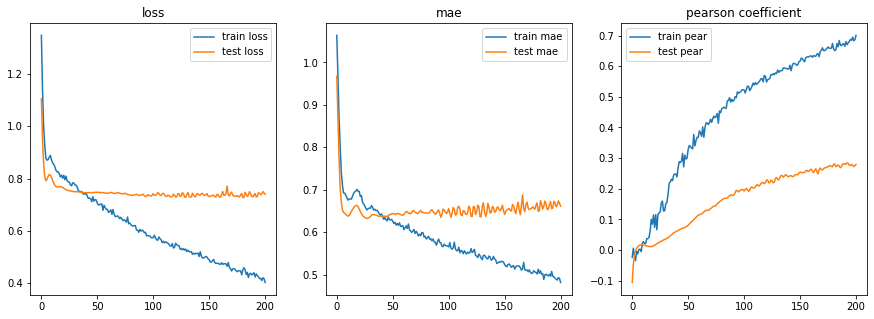

In [ ]:
import matplotlib.pyplot as plt

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))
ax1.plot(all_train_loss, label="train loss")
ax1.plot(all_test_loss, label="test loss")
ax1.legend(loc="best")
ax1.set_title("loss")

ax2.plot(all_train_mae, label="train mae")
ax2.plot(all_test_mae, label="test mae")
ax2.set_title("mae")
ax2.legend(loc="best")

ax3.plot(all_train_pear, label="train pear")
ax3.plot(all_test_pear, label="test pear")
ax3.set_title("pearson coefficient")
ax3.legend(loc="best")

# plt.show()

In [ ]:
# Instantiate model
model = RegressionModel(D_m_text, D_m_audio, D_m_video, D_m_context, D_g, D_p, D_e, D_h, dropout_rec=args["rec_dropout"], dropout=args["dropout"])
model.load_state_dict(torch.load("/content/gdrive/MyDrive/11-777 MMML/multilogue-net/logs/moseas_noneutral_regression/epoch179_testloss_0.7277_testmae_0.6488000154495239_testpear_0.28.pth"))

train_loader, valid_loader, test_loader = get_MOSEI_loaders('/content/gdrive/MyDrive/11-777 MMML/multilogue-net/data/moseas_full_no_neutral_regression.pickle', valid=0.0, batch_size=batch_size, num_workers=0)
if cuda:
    model.cuda()
loss_function = MaskedMSELoss()
train_loss, train_mae, train_pear,train_labels, train_preds, train_masks = train_or_eval_model(model, loss_function, train_loader, 1)
test_loss, test_mae, test_pear, test_label, test_pred, test_mask = train_or_eval_model(model, loss_function, test_loader, 1)


dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataload

In [ ]:
all_labels = np.concatenate([train_labels, test_label])
all_preds = np.concatenate([train_preds, test_pred])

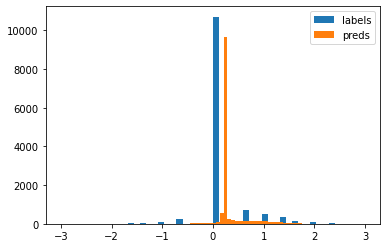

In [ ]:
import matplotlib.pyplot as plt

plt.hist(all_labels, bins=50, label="labels")
plt.hist(all_preds, bins=50, label="preds")
plt.legend()
plt.show()

In [ ]:
all_labels

array([0.6666667, 0.6666667, 1.6666666, ..., 0.       , 0.       ,
       0.       ], dtype=float32)

In [ ]:
np.logical_and(all_labels<=0.5, all_labels >= -0.5).sum()

10711

In [ ]:
all_labels

array([1.6666666, 0.       , 0.       , ..., 0.       , 0.       ,
       0.       ], dtype=float32)

# evaluate multilogue-net-nce on spanish dataset

In [ ]:
import pickle

# spanish_moseas_data = pickle.load(open("/content/gdrive/MyDrive/multilogue-net/data/moseas_spanish_full_regression.pickle", "rb"))

_, _, test_loader_sp = get_MOSEI_loaders('/content/gdrive/MyDrive/multilogue-net/data/moseas_spanish_duptextfornce_full_regression.pickle', valid=0.0, batch_size=batch_size, num_workers=0)
_, _, test_loader_fr = get_MOSEI_loaders('/content/gdrive/MyDrive/multilogue-net/data/moseas_french_duptextfornce_full_regression.pickle', valid=0.0, batch_size=batch_size, num_workers=0)


french
testset.len:  52
french
testset.len:  57


In [ ]:
len(spanish_moseas_data[0])

258

In [ ]:
all_videos_seg, all_speakers, all_labels, text_feat, audio_feat, visual_feat, train_videos, test_videos = spanish_moseas_data

In [ ]:
spanish_moseas_data = (all_videos_seg, all_speakers, all_labels, text_feat, text_feat, audio_feat, visual_feat, train_videos, test_videos)

In [ ]:
pickle.dump(spanish_moseas_data, open("/content/drive/MyDrive/11-777 MMML/multilogue-net/data/moseas_spanish_duptextfornce_full_regression.pickle", "wb"))

In [ ]:
test_loss, test_mae, test_pear, test_label, test_pred, test_mask = train_or_eval_model(model, MSEloss, crosslingualnceloss, internceloss, train_loader, e, optimizer, True)
print("Test Loss - spanish MOSEAS: ", test_loss)
print("Test MAE - spanish MOSEAS: ", test_mae)
print("Test Pear - spanish MOSEAS: ", test_pear)



5240.257771492004
-42136.297
3668.1214871406555
-40286.164
4345.1136264801025
-40464.89
3005.9989433288574
-41157.47
Test Loss - spanish MOSEAS:  -37.3195
Test MAE - spanish MOSEAS:  1.7755
Test Pear - spanish MOSEAS:  0.1037


In [ ]:
test_loss, test_mae, test_pear, test_label, test_pred, test_mask = train_or_eval_model(model, MSEloss, crosslingualnceloss, internceloss, train_loader, e, optimizer, True)
print("Test Loss - spanish MOSEAS: ", test_loss)
print("Test MAE - spanish MOSEAS: ", test_mae)
print("Test Pear - spanish MOSEAS: ", test_pear)



5635.501266956329
-39814.457
6192.907393455505
-41243.9
6310.126957893372
-40542.965
3573.788998603821
-42561.305
Test Loss - spanish MOSEAS:  -35.9723
Test MAE - spanish MOSEAS:  2.103
Test Pear - spanish MOSEAS:  -0.005


In [ ]:
_, _, test_loader = get_MOSEI_loaders('/content/gdrive/MyDrive/multilogue-net/data/moseas_french_duptextfornce_full_regression.pickle', valid=0.0, batch_size=batch_size, num_workers=0,mode="spanish-all-test")


spanish-all-test
testset.len:  285
